In [2]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs




def bokeh_plotter(data_list, x_axis_list=None, label_list=None,
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):

        color = next(color_cycle)

        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception('problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i+1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)


def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')





In [3]:

# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict






In [4]:

animals = ['PV_106','PV_143','PV_62','PV_126', 'PV_57']
block_lists = [[8,9,10,11,12],[1,2,3,4],[24, 26, 38],[7, 8, 9, 10, 11, 12], [7, 8, 9, 12, 13]]

experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks)

instantiated block number 008 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_008, new OE version
Found the sample rate for block 008 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 008
got it!
instantiated block number 009 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_009, new OE version
Found the sample rate for block 009 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 009
got it!
instantiated block number 010 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_010, new OE version
Found the sample rate for block 010 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 010
got it!
instantiated block number 011 at Path: Z:\Nimrod\exp

In [5]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later

# # NOTICE THE DIRECTIONALITY FLIP!!!
#     block.left_eye_data = horizontal_flip_eye_data(block.left_eye_data.copy(),640)
#     block.right_eye_data = horizontal_flip_eye_data(block.right_eye_data.copy(),640)
    # calibrate pupil diameter:
for block in block_collection:
    block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_raw_verified.csv')
    block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_raw_verified.csv')



running parse_open_ephys_events...
block 008 has a parsed events file, reading...
Getting eye brightness values for block 008...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 009 has a parsed events file, reading...
Getting eye brightness values for block 009...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 010 has a parsed events file, reading...
Getting eye brightness values for block 010...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_

In [6]:
 for block in block_collection:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

In [7]:
def create_saccade_events_with_direction_segmentation_robust(
        eye_data_df,
        speed_threshold,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=25,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2,
        min_net_disp=0.5  # minimal net angular displacement (in degrees) for a segment to be valid
):
    """
    Detects and segments saccade events in eye tracking data using angular speed and directional changes.
    This robust version avoids producing segments with near-zero net displacement by:
      1. Defining the saccade onset as the first frame where the angular speed exceeds the threshold.
      2. Segmenting the event based on sustained directional changes.
      3. Discarding segments whose overall net angular displacement (computed from k_phi and k_theta)
         is below a user-specified minimal value.

    Parameters:
      - eye_data_df (pd.DataFrame): DataFrame with columns including:
            'center_x', 'center_y', 'k_phi', 'k_theta', 'OE_timestamp', 'ms_axis', 'pupil_diameter'.
      - speed_threshold (float): Angular speed threshold (degrees/frame) for detection.
      - directional_delta_threshold_deg (float): Angular change threshold to determine segmentation boundaries.
      - magnitude_calib (float): Calibration factor (not applied to angular measures).
      - speed_profile (bool): Whether to record speed profiles.
      - min_subsaccade_samples (int): Minimum number of samples required for a valid segment.
      - min_net_disp (float): Minimal net angular displacement (in degrees) required for a segment to be kept.

    Returns:
      - df (pd.DataFrame): The input DataFrame with added computed columns.
      - saccade_events_df (pd.DataFrame): DataFrame listing detected and segmented saccade events, with metrics.
    """
    # Make a copy so as not to modify the original DataFrame.
    df = eye_data_df.copy()

    ### 1. Compute Frame-to-Frame Differences
    df["speed_x"] = df["center_x"].diff()
    df["speed_y"] = df["center_y"].diff()
    df["speed_r"] = np.sqrt(df["speed_x"] ** 2 + df["speed_y"] ** 2)

    # Angular differences (k_phi and k_theta are in degrees)
    df["angular_speed_phi"] = df["k_phi"].diff()
    df["angular_speed_theta"] = df["k_theta"].diff()
    df["angular_speed_r"] = np.sqrt(df["angular_speed_phi"] ** 2 + df["angular_speed_theta"] ** 2)

    ### 2. Saccade Detection Based on Angular Speed
    # Mark frames where the instantaneous angular speed exceeds the threshold.
    df["is_saccade_angle"] = df["angular_speed_r"] > speed_threshold

    # Identify transitions to detect onsets and offsets.
    saccade_on_off = df["is_saccade_angle"].astype(int) - df["is_saccade_angle"].shift(1, fill_value=0).astype(int)
    # Use the first frame above threshold as onset
    saccade_on_inds = np.where(saccade_on_off == 1)[0]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]

    # Handle mismatches: if a saccade starts but does not end, drop the last onset.
    if len(saccade_on_inds) > len(saccade_off_inds):
        saccade_on_inds = saccade_on_inds[:-1]

    saccade_events = []

    ### 3. Process Each Detected Saccade for Segmentation
    for start_ind, end_ind in zip(saccade_on_inds, saccade_off_inds):
        saccade_df = df.iloc[start_ind:end_ind + 1].copy()
        if saccade_df.empty or len(saccade_df) < min_subsaccade_samples:
            continue

        # Compute instantaneous angles (for both pixel- and angular-based estimates)
        saccade_df["inst_angle_pixel"] = np.degrees(np.arctan2(saccade_df["speed_y"], saccade_df["speed_x"]))
        saccade_df["inst_angle_deg"] = np.degrees(
            np.arctan2(saccade_df["angular_speed_theta"], saccade_df["angular_speed_phi"]))

        # Define helper function for minimal angular difference (handling circularity)
        minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180

        angles = saccade_df["inst_angle_deg"].values
        # Compute consecutive differences
        angle_diffs = np.array([minimal_angle_diff_deg(angles[i + 1], angles[i]) for i in range(len(angles) - 1)])

        # Identify candidate segmentation boundaries when the absolute change exceeds threshold.
        candidate_boundaries = np.where(np.abs(angle_diffs) > directional_delta_threshold_deg)[0].tolist()

        # Always include the first and last frame of the saccade.
        boundaries = [0] + candidate_boundaries + [len(saccade_df) - 1]

        # Process each segment defined by these boundaries.
        for i in range(len(boundaries) - 1):
            seg_start = boundaries[i]
            seg_end = boundaries[i + 1]
            subsaccade = saccade_df.iloc[seg_start: seg_end + 1]
            if len(subsaccade) < min_subsaccade_samples:
                continue

            # Compute net angular displacement using the angular positions (k_phi and k_theta)
            initial_pos_angle = subsaccade.iloc[0][["k_phi", "k_theta"]]
            final_pos_angle = subsaccade.iloc[-1][["k_phi", "k_theta"]]
            net_disp = np.sqrt((final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]) ** 2 +
                               (final_pos_angle["k_theta"] - initial_pos_angle["k_theta"]) ** 2)

            # Only record segments whose net displacement is above min_net_disp.
            if net_disp < min_net_disp:
                continue

            # Timing and indices
            sub_start_timestamp = subsaccade["OE_timestamp"].iloc[0]
            sub_end_timestamp = subsaccade["OE_timestamp"].iloc[-1]
            sub_start_ms = subsaccade["ms_axis"].iloc[0]
            sub_end_ms = subsaccade["ms_axis"].iloc[-1]
            sub_length = subsaccade.index[-1] - subsaccade.index[0]

            # Pixel-based metrics
            magnitude_raw_pixel = subsaccade["speed_r"].sum()
            magnitude_pixel = magnitude_raw_pixel * magnitude_calib

            # Angular-based metric: sum of instantaneous angular speeds
            magnitude_raw_angular = subsaccade["angular_speed_r"].sum()

            # Overall angular-based angle (from start to end)
            overall_angle_deg = (np.degrees(np.arctan2(
                final_pos_angle["k_theta"] - initial_pos_angle["k_theta"],
                final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]
            )) % 360)

            # (Optional) Capture speed profiles and other details
            speed_profile_pixel = subsaccade["speed_r"].values if speed_profile else None
            speed_profile_pixel_calib = (speed_profile_pixel * magnitude_calib) if speed_profile else None
            speed_profile_angular = subsaccade["angular_speed_r"].values if speed_profile else None
            diameter_profile = subsaccade["pupil_diameter"].values

            saccade_events.append({
                "saccade_start_ind": subsaccade.index[0],
                "saccade_end_ind": subsaccade.index[-1],
                "saccade_start_timestamp": sub_start_timestamp,
                "saccade_end_timestamp": sub_end_timestamp,
                "saccade_on_ms": sub_start_ms,
                "saccade_off_ms": sub_end_ms,
                "length": sub_length,
                "magnitude_raw_pixel": magnitude_raw_pixel,
                "magnitude_pixel": magnitude_pixel,
                "magnitude_raw_angular": magnitude_raw_angular,
                "overall_angle_deg": overall_angle_deg,
                "net_angular_disp": net_disp,
                "speed_profile_pixel": speed_profile_pixel,
                "speed_profile_pixel_calib": speed_profile_pixel_calib,
                "speed_profile_angular": speed_profile_angular,
                "diameter_profile": diameter_profile,
                "theta_init_pos": initial_pos_angle["k_theta"],
                "theta_end_pos": final_pos_angle["k_theta"],
                "phi_init_pos": initial_pos_angle["k_phi"],
                "phi_end_pos": final_pos_angle["k_phi"]
            })

    # Convert the list to a DataFrame.
    saccade_events_df = pd.DataFrame(saccade_events)

    # Optionally remove intermediate column
    df.drop(["is_saccade_angle"], axis=1, inplace=True)

    # Calculate delta columns for convenience.
    if not saccade_events_df.empty:
        saccade_events_df['delta_theta'] = saccade_events_df['theta_end_pos'] - saccade_events_df['theta_init_pos']
        saccade_events_df['delta_phi'] = saccade_events_df['phi_end_pos'] - saccade_events_df['phi_init_pos']

    return df, saccade_events_df

In [8]:
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_with_direction_segmentation_robust(block.left_eye_data,
                                                                                                        0.8,  # angular speed threshold in degrees/video frame
                                                                                                        directional_delta_threshold_deg=90,  # threshold for change in instantaneous angle (degrees)
                                                                                                        magnitude_calib=1,
                                                                                                        speed_profile=True,
                                                                                                        min_subsaccade_samples=2)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_with_direction_segmentation_robust(block.right_eye_data,
                                                                                                        0.8,  # angular speed threshold in degrees/video frame
                                                                                                        directional_delta_threshold_deg=90,  # threshold for change in instantaneous angle (degrees)
                                                                                                        magnitude_calib=1,
                                                                                                        speed_profile=True,
                                                                                                        min_subsaccade_samples=2)


PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19
PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43
PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43
PV_106, block 011, on PV106_ET_d3t4_2025-08-06_12-44-30
PV_106, block 012, on PV106_ET_d3t5_2025-08-06_13-21-30
PV_143, block 001, on PV143_ET_d1t1_2025-08-11_13-29-08
PV_143, block 002, on PV143_ET_d1t2_2025-08-11_13-50-11
PV_143, block 003, on PV143_ET_d1t3_2025-08-11_14-20-35
PV_143, block 004, on PV143_ET_d1t4_2025-08-11_14-58-28
PV_62, block 024, on 2023-04-27_11-22-56
PV_62, block 026, on 2023-04-27_12-21-41
PV_62, block 038, on 2023-05-01_13-57-45
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57
PV_126, block 011, on PV126_Trial115_eyeTracking_w7
PV_126, block 012, on PV126_Trial116_eyeTracking_h8
PV_57, block 007, on p

In [9]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:],
                    'angles': mat_data['angles'][:],
                    'staticAll': mat_data['staticAll'][:],
                    't_static_ms': mat_data['t_static_ms'][:]}
        mat_dict['phi_rad'] = mat_dict['angles'][:,0]
        mat_dict['theta_rad'] = mat_dict['angles'][:,1]
        mat_dict['theta_deg'] = np.rad2deg(mat_dict['theta_rad'])
        mat_dict['phi_deg'] = np.rad2deg(mat_dict['phi_rad'])
        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        static_df = pd.DataFrame(data=np.array([mat_dict['t_static_ms'][:, 0],
                                                mat_dict['staticAll'][:, 0],
                                                mat_dict['phi_rad'],
                                                mat_dict['theta_rad'],
                                                mat_dict['phi_deg'],
                                                mat_dict['theta_deg']]).T,
                              columns=['t_static_ms', 'staticAll','phi_rad','theta_rad','phi_deg','theta_deg'])
        mat_data.close()
        block.liz_mov_df = acc_df
        block.liz_static_df = static_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print(f'no such file {mat_path}')


# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms

        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]

        if overlapping_mov_times.size > 0:
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

# Create a list to store blocks where movement data exists
block_collection_w_mov = []

for block in block_collection:
    try:
        block_get_lizard_movement(block)  # Try loading movement data
        label_saccade_movements(block)    # Try labeling saccades

        # If both steps succeed, add block to the valid collection
        block_collection_w_mov.append(block)

    except (FileNotFoundError, OSError) as e:
        print(f"Skipping block {block}: {str(e)}")  # Notify which block failed


path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_008\oe_files\PV106_ET_d3t12025-08-06_11-52-19\Record Node 102\analysis\recNames=Block008,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_009\oe_files\PV106_ET_d3t2_2025-08-06_12-09-43\Record Node 102\analysis\recNames=Block009,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_010\oe_files\PV106_ET_d3t3_2025-08-06_12-26-43\Record Node 102\analysis\recNames=Block010,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_011\oe_files\PV106_ET_d3t4_2025-08-06_12-44-30\Record Node 102\analysis\recNames=Block011,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 011,

In [10]:
import os
import pickle
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_saccade_magnitude_vs_velocity_time_to_peak_angular(
    synced_saccade_collection, monocular_saccade_collection, export_path=None, threshold=3,
    fig_size=(3, 3), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60
):
    """
    Plots angular saccade magnitudes versus angular peak velocities as a compact scatter plot.
    Angular metrics are extracted from the synchronized saccade DataFrame:
      - Angular amplitude is taken from 'magnitude_raw_angular'
      - Peak angular velocity is computed as the maximum value from 'speed_profile_angular'
      - Time-to-peak is assumed to be stored in 'time_to_peak_v'

    Parameters:
      - synced_saccade_collection: DataFrame of synchronized saccades containing angular columns.
      - monocular_saccade_collection: DataFrame of monocular saccades (unused here, but kept for compatibility).
      - export_path (str): Directory path to export the plot and data.
      - threshold (float): Standard deviation threshold for outlier removal.
      - fig_size (tuple): Figure size (width, height).
      - velocity_threshold (float): Optional horizontal line value for peak velocities.
      - velocity_to_deg_per_ms (bool): If True, convert angular speeds from deg/frame to deg/ms.
      - frame_rate_fps (float): Frame rate in frames per second.
    """

    def extract_saccade_metrics_time_to_peak_angular(saccade_collection, eye_label):
        """
        Extracts angular saccade metrics for the given eye.
        Assumes that saccade_collection contains:
          - 'magnitude_raw_angular': angular amplitude (deg)
          - 'speed_profile_angular': list/array of angular speeds (deg/frame)
          - 'time_to_peak_v': time to reach peak angular speed (ms)
        """
        filtered_data = saccade_collection.query('eye == @eye_label')
        magnitudes = filtered_data['magnitude_raw_angular'].values
        # Compute peak angular speed (in deg/frame) from the angular speed profile
        peak_velocities = np.array([np.nanmax(profile) for profile in filtered_data['speed_profile_angular']])
        time_to_peak = filtered_data['time_to_peak_v'].values
        return magnitudes, peak_velocities, time_to_peak

    # Get metrics for left and right eyes
    l_magnitudes, l_peak_velocities, l_time_to_peak = extract_saccade_metrics_time_to_peak_angular(synced_saccade_collection, 'L')
    r_magnitudes, r_peak_velocities, r_time_to_peak = extract_saccade_metrics_time_to_peak_angular(synced_saccade_collection, 'R')

    # Concatenate the data from both eyes
    all_magnitudes = np.concatenate((l_magnitudes, r_magnitudes))
    all_peak_velocities = np.concatenate((l_peak_velocities, r_peak_velocities))
    all_time_to_peaks = np.concatenate((l_time_to_peak, r_time_to_peak))

    # Convert from deg/frame to deg/ms if requested
    frame_duration = 1000 / frame_rate_fps  # ms per frame
    if velocity_to_deg_per_ms:
        all_peak_velocities = all_peak_velocities / frame_duration

    # Combine into DataFrame
    data = pd.DataFrame({
        'magnitude': all_magnitudes,           # Angular amplitude in degrees
        'peak_velocity': all_peak_velocities,   # Angular peak velocity in deg/ms
        'time_to_peak': all_time_to_peaks         # Time to peak (ms)
    })

    # Remove outliers (this function should be defined elsewhere)
    cleaned_data = remove_outliers_from_df(data, threshold)

    # Extract cleaned data for plotting
    f_magnitudes = cleaned_data['magnitude'].values
    f_peak_velocities = cleaned_data['peak_velocity'].values
    f_time_to_peaks = cleaned_data['time_to_peak'].values

    # Create scatter plot
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    sc = ax.scatter(f_magnitudes, f_peak_velocities, s=0.7, c=f_time_to_peaks, cmap='viridis', alpha=0.7)

    ax.set_xlabel('Angular Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Peak Angular Velocity [deg/ms]', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    if velocity_threshold is not None:
        ax.axhline(y=velocity_threshold, color='red', linestyle='--', linewidth=1.5)

    # Add a limiting slope line (here, a line with slope = 1/frame_duration as a reference)
    limiting_slope = 1 / frame_duration
    x_line = np.linspace(0, f_magnitudes.max(), 100)
    y_line = limiting_slope * x_line
    ax.plot(x_line, y_line, color='orange', linestyle='--', linewidth=1.5, label='Min Detectable Speed')
    ax.legend(fontsize=8)

    # Add colorbar for time-to-peak
    cbar = plt.colorbar(sc, ax=ax, pad=0.02, aspect=10)
    cbar.set_label('Time-To-Peak [ms]', fontsize=8)
    cbar.ax.tick_params(labelsize=8)

    # Export plot and data if export_path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_magnitude_vs_velocity_time_to_peak_angular_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_magnitude_vs_velocity_time_to_peak_angular.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "cleaned_saccade_data_time_to_peak_angular.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(cleaned_data, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


In [11]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])

In [12]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [13]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])

    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')

    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


924it [00:00, 7965.49it/s]
395it [00:00, 7181.75it/s]
472it [00:00, 7733.31it/s]

105 517
102 336



1273it [00:00, 8108.31it/s]

103 320



724it [00:00, 8515.04it/s]
0it [00:00, ?it/s]

377 961
333 650


519it [00:00, 7109.62it/s]
322it [00:00, 7848.70it/s]
387it [00:00, 7166.55it/s]

234 565
145 320
256 495



265it [00:00, 8833.62it/s]
675it [00:00, 7670.70it/s]
0it [00:00, ?it/s]

93 207
262 638


623it [00:00, 4547.47it/s]
1090it [00:00, 8134.40it/s]

374 761



740it [00:00, 7326.85it/s]

1071 1649


1409it [00:00, 7080.47it/s]
429it [00:00, 7150.12it/s]
529it [00:00, 7895.42it/s]

435 1315
289 541



271it [00:00, 7528.07it/s]
710it [00:00, 7031.92it/s]

251 539
183 353


1056it [00:00, 6993.61it/s]
112it [00:00, 7454.41it/s]
567it [00:00, 4394.51it/s]

539 1251
53 123


934it [00:00, 5075.42it/s]
949it [00:00, 6827.36it/s]

1635 2183



794it [00:00, 7490.64it/s]

461 1087
487 888



786it [00:00, 6716.59it/s]
999it [00:00, 6530.69it/s]

286 763
573 1245


In [14]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df

synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


In [15]:
all_saccade_collection = pd.concat([synced_saccade_collection,non_synced_saccade_collection])


In [16]:
def remove_overlapping_saccades(df, start_col='saccade_start_timestamp', end_col='saccade_end_timestamp', eye_col='eye'):
    """
    Removes duplicate/overlapping saccade events from the dataframe.

    For each eye (grouped by the 'eye' column), the function assumes that
    the events are sorted by their start timestamps. It then checks sequentially
    and keeps an event only if its start timestamp is greater than or equal to
    the end timestamp of the previously kept event.

    Parameters:
        df (pd.DataFrame): DataFrame with saccade events.
        start_col (str): Column name for the saccade start timestamp.
        end_col (str): Column name for the saccade end timestamp.
        eye_col (str): Column name indicating the eye ('L' or 'R').

    Returns:
        pd.DataFrame: A filtered DataFrame with overlapping saccades removed.
    """
    filtered_dfs = []
    for eye in df[eye_col].unique():
        # Get events for this eye and sort them by the start timestamp.
        sub_df = df[df[eye_col] == eye].sort_values(by=start_col).copy()
        non_overlap_rows = []
        last_end = None

        for idx, row in sub_df.iterrows():
            current_start = row[start_col]
            current_end = row[end_col]

            # If no previous event or the current event starts after (or exactly at) the end
            # of the previous event, keep it.
            if last_end is None or current_start >= last_end:
                non_overlap_rows.append(row)
                last_end = current_end
            else:
                # An overlap is detected; report it (optional) and skip this event.
                print(f"Overlap detected for eye {eye} at index {idx}: current start {current_start} < previous end {last_end}. Skipping duplicate.")

        filtered_dfs.append(pd.DataFrame(non_overlap_rows))

    # Concatenate the cleaned events for all eyes and sort by eye and start time.
    cleaned_df = pd.concat(filtered_dfs).sort_values(by=[eye_col, start_col]).reset_index(drop=True)
    return cleaned_df

all_saccade_collection = remove_overlapping_saccades(all_saccade_collection, start_col='saccade_on_ms', end_col='saccade_off_ms', eye_col='eye')
synced_saccade_collection = remove_overlapping_saccades(synced_saccade_collection, start_col='saccade_on_ms', end_col='saccade_off_ms', eye_col='eye')
non_synced_saccade_collection = remove_overlapping_saccades(non_synced_saccade_collection, start_col='saccade_on_ms', end_col='saccade_off_ms', eye_col='eye')

Overlap detected for eye L at index 1: current start 35635.35 < previous end 35639.2. Skipping duplicate.
Overlap detected for eye L at index 1005: current start 36201.1 < previous end 36214.85. Skipping duplicate.
Overlap detected for eye L at index 11: current start 36916.6 < previous end 36930.3. Skipping duplicate.
Overlap detected for eye L at index 6987: current start 36926.65 < previous end 36930.3. Skipping duplicate.
Overlap detected for eye L at index 14306: current start 38121.3 < previous end 38166.9. Skipping duplicate.
Overlap detected for eye L at index 1009: current start 39497.8 < previous end 39547.3. Skipping duplicate.
Overlap detected for eye L at index 0: current start 39508.0 < previous end 39547.3. Skipping duplicate.
Overlap detected for eye L at index 1010: current start 39531.1 < previous end 39547.3. Skipping duplicate.
Overlap detected for eye L at index 11636: current start 39867.85 < previous end 39886.25. Skipping duplicate.
Overlap detected for eye L at

In [17]:
def add_time_to_peak_velocity(df, sampling_interval_ms):
    """
    Adds a 'time_to_peak_v' column to the dataframe, representing the time (in ms)
    to reach the peak velocity in the 'speed_profile' column.

    Parameters:
    - df (pd.DataFrame): DataFrame containing a 'speed_profile' column with lists of velocities.
    - sampling_interval_ms (float): Sampling interval in milliseconds.

    Returns:
    - pd.DataFrame: Modified DataFrame with a new 'time_to_peak_v' column.
    """
    def compute_time_to_peak(speed_profile):
        if speed_profile is None or len(speed_profile) == 0:  # Explicit check for empty or None
            return np.nan
        peak_index = np.argmax(speed_profile)  # Index of maximum speed
        return peak_index * sampling_interval_ms

    # Apply the computation to each row
    df['time_to_peak_v'] = df['speed_profile_angular'].apply(compute_time_to_peak)
    return df

all_saccade_collection = add_time_to_peak_velocity(all_saccade_collection,17)
synced_saccade_collection = add_time_to_peak_velocity(synced_saccade_collection,17)
non_synced_saccade_collection = add_time_to_peak_velocity(non_synced_saccade_collection,17)
saccade_collection = add_time_to_peak_velocity(saccade_collection,17)

In [19]:
def add_peak_velocity(df):
    """
    Adds a 'time_to_peak_v' column to the dataframe, representing the time (in ms)
    to reach the peak velocity in the 'speed_profile' column.

    Parameters:
    - df (pd.DataFrame): DataFrame containing a 'speed_profile' column with lists of velocities.
    - sampling_interval_ms (float): Sampling interval in milliseconds.

    Returns:
    - pd.DataFrame: Modified DataFrame with a new 'time_to_peak_v' column.
    """
    def compute_peak_v(speed_profile):
        if speed_profile is None or len(speed_profile) == 0:  # Explicit check for empty or None
            return np.nan
        peak_v = np.max(speed_profile)  # Index of maximum speed
        return peak_v

    # Apply the computation to each row
    df['peak_velocity'] = df['speed_profile_angular'].apply(compute_peak_v)
    return df

all_saccade_collection = add_peak_velocity(all_saccade_collection)
synced_saccade_collection = add_peak_velocity(synced_saccade_collection)
non_synced_saccade_collection = add_peak_velocity(non_synced_saccade_collection)
saccade_collection = add_peak_velocity(saccade_collection)

This is a manual filtering step:

In [21]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

def launch_main_sequence_lasso_plotly(
    df: pd.DataFrame,
    x_col: str = "magnitude_raw_angular",
    y_col: str = "peak_velocity",
    *,
    convert_deg_per_frame_to_ms: bool = False,
    frame_rate_fps: float = 60.0,
    title: str = "Main sequence (lasso to collect outliers)",
    point_size: float = 4.0,
    point_opacity: float = 0.45,
    show_regression: bool = True,
):
    """
    Returns:
        fig:      plotly.graph_objects.FigureWidget
        view_df:  cleaned DataFrame actually plotted; has columns ['A','V','orig_idx']
        stats:    dict with slope/intercept/r/R2 if show_regression else None
    """
    data = df.copy()
    if y_col not in data.columns:
        raise ValueError(f"'{y_col}' not in df. Provide a column or pre-compute it.")

    # Optional unit conversion (deg/frame -> deg/ms)
    if convert_deg_per_frame_to_ms:
        frame_ms = 1000.0 / float(frame_rate_fps)
        data[y_col] = data[y_col] / frame_ms

    # Clean & keep positives
    mask = (
        np.isfinite(data[x_col]) & (data[x_col] > 0) &
        np.isfinite(data[y_col]) & (data[y_col] > 0)
    )
    view_df = data.loc[mask, [x_col, y_col]].copy()
    if view_df.empty:
        raise ValueError("No valid points after filtering.")
    view_df["orig_idx"] = view_df.index
    view_df = view_df.rename(columns={x_col: "A", y_col: "V"}).copy()

    # Equal numeric span on both axes
    lo = float(min(view_df["A"].min(), view_df["V"].min()))
    hi = float(max(view_df["A"].max(), view_df["V"].max()))
    span = hi - lo
    if span <= 0:
        lo, hi = 0.0, max(1.0, hi)
    pad = 0.05 * (hi - lo if hi > lo else 1.0)
    x_range = [lo - pad, hi + pad]
    y_range = [lo - pad, hi + pad]

    # Base scatter (use Scattergl for speed with many points)
    sc = go.Scattergl(
        x=view_df["A"], y=view_df["V"],
        mode="markers",
        marker=dict(size=point_size, opacity=point_opacity),
        selected=dict(marker=dict(size=point_size+2)),
        unselected=dict(marker=dict(opacity=point_opacity)),
        name="events"
    )

    fig = go.FigureWidget(data=[sc])
    fig.update_layout(
        title=title,
        dragmode="lasso",        # start with lasso (you can switch to box in the toolbar)
        xaxis_title="Amplitude [deg]",
        yaxis_title=("Peak Velocity [deg/ms]" if convert_deg_per_frame_to_ms else "Peak Velocity [deg/frame]"),
        xaxis=dict(range=x_range, scaleratio=1, constrain="range"),
        yaxis=dict(range=y_range, scaleanchor="x"),  # same numeric span + square aspect
        height=420, width=640,
        margin=dict(l=60, r=10, t=40, b=50)
    )

    # Optional regression overlay
    stats = None
    if show_regression and len(view_df) >= 2:
        A = view_df["A"].to_numpy()
        V = view_df["V"].to_numpy()
        slope, intercept = np.polyfit(A, V, 1)
        r = np.corrcoef(A, V)[0, 1]
        r2 = float(r**2)
        stats = dict(slope=float(slope), intercept=float(intercept), r=float(r), R2=r2)

        x_line = np.linspace(x_range[0], x_range[1], 200)
        y_line = slope * x_line + intercept
        fig.add_scatter(x=x_line, y=y_line, mode="lines", name="OLS", line=dict(dash="dash"))

        fig.update_layout(title=f"{title} (r={r:.3f}, R²={r2:.3f}, slope={slope:.3f}, int.={intercept:.3f})")

    display(fig)  # ensure the widget renders in-place
    return fig, view_df, stats


def get_selected_subset_plotly(
    fig: go.FigureWidget,
    view_df: pd.DataFrame,
    original_df: pd.DataFrame = None
) -> pd.DataFrame:
    """
    Reads currently selected points from the FigureWidget and returns a DataFrame.
    If original_df is provided, returns those original rows (all columns) using 'orig_idx'.
    """
    # selectedpoints are index positions into the *trace's* data arrays (same order as view_df)
    sel = fig.data[0].selectedpoints
    if not sel:
        return pd.DataFrame(columns=(original_df.columns if original_df is not None else view_df.columns))
    picked = view_df.iloc[list(sel)]
    if original_df is None:
        return picked
    return original_df.loc[picked["orig_idx"].values]


In [24]:
# 1) Build your filtered df, as before:
df_use = all_saccade_collection.query(
    'head_movement==False and animal != "PV_62"'
)

# 2) Launch interactive figure
fig, view_df, stats = launch_main_sequence_lasso_plotly(
    df_use,
    x_col="magnitude_raw_angular",
    y_col="peak_velocity",
    convert_deg_per_frame_to_ms=False,
    title="Main sequence (lasso to collect outliers)",
    point_size=4.0, point_opacity=0.45, show_regression=True
)

FigureWidget({
    'data': [{'marker': {'opacity': 0.45, 'size': 4.0},
              'mode': 'markers',
              'name': 'events',
              'selected': {'marker': {'size': 6.0}},
              'type': 'scattergl',
              'uid': '3dbb8d5d-9f9b-4e58-b3a0-40d06855f646',
              'unselected': {'marker': {'opacity': 0.45}},
              'x': array([4.75654836, 7.52079448, 7.56731718, ..., 8.97522325, 5.40068903,
                          4.51347842]),
              'y': array([1.89750303, 3.47961434, 3.08016505, ..., 1.72715725, 1.38962263,
                          1.54272811])},
             {'line': {'dash': 'dash'},
              'mode': 'lines',
              'name': 'OLS',
              'type': 'scatter',
              'uid': 'f8bb7053-b980-4c86-a362-ff9c90ef69f2',
              'x': array([-2.73381730e+00, -2.34311578e+00, -1.95241425e+00, -1.56171273e+00,
                          -1.17101121e+00, -7.80309683e-01, -3.89608159e-01,  1.09336445e-03,
           

In [25]:
# 3) Use the toolbar lasso (or box) to select points.
#    Then run this cell to retrieve the exact rows you selected:
picked = get_selected_subset_plotly(fig, view_df, original_df=df_use)
picked.shape, picked.head()


((7, 30),
         Main  Sub  saccade_start_ind  saccade_end_ind  \
 7926  1725.0    L             125927           125929   
 4889     NaN  NaN             123586           123594   
 7088     NaN  NaN              19779            19793   
 9890     NaN  NaN              49118            49128   
 9976     NaN  NaN              50578            50592   
 
       saccade_start_timestamp  saccade_end_timestamp  saccade_on_ms  \
 7926               42400855.0             42401521.0     2120042.75   
 4889               41568471.0             41571096.0     2078423.55   
 7088                7189377.0              7193973.0      359468.85   
 9890               16728610.0             16731940.0      836430.50   
 9976               17214790.0             17219452.0      860739.50   
 
       saccade_off_ms  length  magnitude_raw_pixel  ...  phi_init_pos  \
 7926      2120076.05       2            29.378431  ...    -25.715132   
 4889      2078554.80       8           126.036431  ...    -

In [26]:
# --- Manual curation UI: multi-animal/multi-block synchronized L/R video reviewer ---
# Python 3.8 compatible; robust preload/export; annotation column kept as object dtype.

import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Optional, Tuple, Dict, List

def review_events_multi(
    block_dict: Dict[str, object],
    events_subset_df: pd.DataFrame,
    export_dir: Optional[Path] = None,     # None -> write timestamped CSV to CWD
    # column names in events_subset_df (auto-detected if not provided)
    animal_col: str = "animal",
    block_col: str = "block",
    eye_col: str = "eye",
    start_ms_col: Optional[str] = None,    # auto: 'start_ms' or 'saccade_on_ms'
    end_ms_col: Optional[str]   = None,    # auto: 'end_ms'   or 'saccade_off_ms'
    window_scale: float = 0.9,
    text_cols: Tuple[str, ...] = ("phi","theta","peak_velocity","magnitude_raw_angular","pupil_diameter"),
    font_scale: float = 0.6,
    thickness: int = 2,
    wait_ms: int = 15,
    flip_mode: str = "vertical",           # "vertical" or "none"
    # refinement / preload options
    preload_existing: bool = True,
    existing_filename: str = "joint_event_annotations.csv",
    ms_tolerance: float = 0.0,             # 0 => exact match by rounded ms; >0 => tolerant preload
    overwrite_existing: bool = True,       # on export: new tag overrides old if True
) -> pd.DataFrame:
    """
    Multi-animal/multi-block synchronized L/R eye visualizer for outlier vetting & refinement.

    UI buttons:
      - Play / Pause
      - Prev / Next
      - Step -1 / Step +1 (frame step using median ms spacing)
      - mark_bad  -> manual_outlier_detected = True  (button shows RED when active)
      - mark_good -> manual_outlier_detected = False (button shows GREEN when active)
      - export_annotated_df -> writes/merges CSV with:
            animal, block, eye, start_ms, end_ms, manual_outlier_detected

    Always returns the reviewed DataFrame with a 'manual_outlier_detected' column (object dtype).
    """
    TAG_COL = "manual_outlier_detected"

    # ---------- resolve timing cols ----------
    def _resolve_time_cols(df: pd.DataFrame, start_c: Optional[str], end_c: Optional[str]) -> Tuple[str, str]:
        cand_start = [start_c, "start_ms", "saccade_on_ms"]
        cand_end   = [end_c,   "end_ms",   "saccade_off_ms"]
        s = next((c for c in cand_start if c and c in df.columns), None)
        e = next((c for c in cand_end   if c and c in df.columns), None)
        if s is None or e is None:
            raise ValueError("Could not resolve start/end ms columns. "
                             "Tried: start in {start_ms,saccade_on_ms}, end in {end_ms,saccade_off_ms}.")
        return s, e

    start_ms_col, end_ms_col = _resolve_time_cols(events_subset_df, start_ms_col, end_ms_col)

    # ---------- working copy ----------
    events = events_subset_df.copy().reset_index(drop=True)

    # Ensure required cols exist
    for c in (animal_col, block_col, eye_col, start_ms_col, end_ms_col):
        if c not in events.columns:
            raise ValueError(f"events_subset_df is missing required column '{c}'")

    # ---------- normalize the annotation column (ALWAYS object dtype) ----------
    def _ensure_tag_col(df: pd.DataFrame):
        if TAG_COL not in df.columns:
            df[TAG_COL] = pd.Series([None] * len(df), dtype="object")
        else:
            # Force object dtype so bool assignments won't fail later
            if str(df[TAG_COL].dtype) != "object":
                df[TAG_COL] = df[TAG_COL].astype("object")

    _ensure_tag_col(events)

    # ---------- standardized keys ----------
    events["_animal_std"]   = events[animal_col].astype(str)
    events["_block_std"]    = events[block_col].astype(str)
    events["_eye_std"]      = events[eye_col].astype(str)
    events["_start_ms_std"] = pd.to_numeric(events[start_ms_col], errors="coerce").astype(float)
    events["_end_ms_std"]   = pd.to_numeric(events[end_ms_col],   errors="coerce").astype(float)
    events["_start_key"]    = pd.Series(np.rint(events["_start_ms_std"]).astype("Int64"))
    events["_end_key"]      = pd.Series(np.rint(events["_end_ms_std"]).astype("Int64"))

    # ---------- helpers ----------
    def _frame_col(df: pd.DataFrame) -> Optional[str]:
        for c in ("eye_frame", "frame", "frame_idx", "video_frame"):
            if c in df.columns:
                return c
        return None

    def _lookup_block(animal: str, block_num: int):
        for obj in block_dict.values():
            if getattr(obj, "animal_call", None) == animal and getattr(obj, "block_num", None) == block_num:
                return obj
        key1 = f"{animal}_block_{block_num}"
        key2 = f"{animal}_block_{int(block_num):03d}"
        if key1 in block_dict: return block_dict[key1]
        if key2 in block_dict: return block_dict[key2]
        raise KeyError(f"BlockSync not found for animal='{animal}', block={block_num}")

    def _nearest_row(df: pd.DataFrame, ms: float) -> Optional[pd.Series]:
        arr = df["ms_axis"].values
        if arr.size == 0: return None
        idx = int(np.argmin(np.abs(arr - ms)))
        return df.iloc[idx]

    def _apply_flip(img: np.ndarray) -> np.ndarray:
        if flip_mode == "vertical":
            return cv2.flip(img, 0)
        return img

    def _coerce_tag(v):
        # Robustly coerce to True/False/None (object)
        if v is None or (isinstance(v, float) and np.isnan(v)):
            return None
        if isinstance(v, bool):
            return v
        if isinstance(v, (int, np.integer)):
            return bool(v)
        if isinstance(v, str):
            s = v.strip().lower()
            if s in ("true", "t", "1", "yes", "y"):  return True
            if s in ("false","f","0","no","n"):      return False
        # unknown -> keep as None
        return None

    # ---------- preload existing annotations ----------
    def _preload_existing() -> int:
        if not preload_existing or export_dir is None:
            return 0
        path = Path(export_dir) / existing_filename
        if not path.exists():
            return 0

        old = pd.read_csv(path)

        if TAG_COL not in old.columns:
            return 0  # nothing useful to preload

        # Resolve timing columns from old file (supports prior schema variations)
        try:
            s_old, e_old = _resolve_time_cols(old, None, None)
        except Exception:
            s_old, e_old = "start_ms", "end_ms"
            for c in (s_old, e_old):
                if c not in old.columns:
                    return 0

        # Standardize old keys
        old["_animal_std"]   = old.get("animal", "").astype(str)
        old["_block_std"]    = old.get("block",  "").astype(str)
        old["_eye_std"]      = old.get("eye",    "").astype(str)
        old["_start_ms_std"] = pd.to_numeric(old[s_old], errors="coerce").astype(float)
        old["_end_ms_std"]   = pd.to_numeric(old[e_old], errors="coerce").astype(float)
        old["_start_key"]    = pd.Series(np.rint(old["_start_ms_std"]).astype("Int64"))
        old["_end_key"]      = pd.Series(np.rint(old["_end_ms_std"]).astype("Int64"))
        old[TAG_COL]         = old[TAG_COL].map(_coerce_tag).astype("object")

        # Ensure our working df still has the column (object)
        _ensure_tag_col(events)

        filled = 0
        if ms_tolerance <= 0.0:
            # Exact (rounded) key match via dict
            lookup = {
                (a, b, e, int(s), int(t)): v
                for a, b, e, s, t, v in zip(
                    old["_animal_std"], old["_block_std"], old["_eye_std"],
                    old["_start_key"],  old["_end_key"],
                    old[TAG_COL]
                )
                if pd.notna(s) and pd.notna(t)
            }
            for i, r in events.iterrows():
                if r[TAG_COL] is not None and not (isinstance(r[TAG_COL], float) and np.isnan(r[TAG_COL])):
                    continue
                sk = r["_start_key"]; ek = r["_end_key"]
                if pd.isna(sk) or pd.isna(ek):
                    continue
                k = (r["_animal_std"], r["_block_std"], r["_eye_std"], int(sk), int(ek))
                if k in lookup:
                    events.at[i, TAG_COL] = lookup[k]
                    filled += 1
        else:
            tol = float(ms_tolerance)
            grouped = {}
            keep_rows = old.dropna(subset=["_start_ms_std", "_end_ms_std"])
            for _, row in keep_rows.iterrows():
                key = (row["_animal_std"], row["_block_std"], row["_eye_std"])
                grouped.setdefault(key, []).append(
                    (row["_start_ms_std"], row["_end_ms_std"], row[TAG_COL])
                )
            for i, r in events.iterrows():
                if r[TAG_COL] is not None and not (isinstance(r[TAG_COL], float) and np.isnan(r[TAG_COL])):
                    continue
                key = (r["_animal_std"], r["_block_std"], r["_eye_std"])
                if key not in grouped:
                    continue
                s0, e0 = r["_start_ms_std"], r["_end_ms_std"]
                best = None
                for s1, e1, val in grouped[key]:
                    if abs(s1 - s0) <= tol and abs(e1 - e0) <= tol:
                        best = val
                        break
                if best is not None:
                    events.at[i, TAG_COL] = best
                    filled += 1
        return filled

    _ = _preload_existing()

    # ---------- lazy video state ----------
    capL = capR = None
    cur_animal = cur_block = None
    left_df = right_df = None
    left_frame_col = right_frame_col = None
    fpsL = fpsR = 60.0
    Wl = Hl = Wr = Hr = 0

    def _release_caps():
        nonlocal capL, capR
        if capL is not None: capL.release(); capL = None
        if capR is not None: capR.release(); capR = None

    def _open_for(animal: str, block_num: int):
        nonlocal cur_animal, cur_block, left_df, right_df
        nonlocal left_frame_col, right_frame_col, capL, capR, fpsL, fpsR, Wl, Hl, Wr, Hr
        if animal == cur_animal and block_num == cur_block:
            return
        _release_caps()
        bs = _lookup_block(animal, block_num)
        cur_animal, cur_block = animal, block_num
        left_df  = getattr(bs, "left_eye_data",  None)
        right_df = getattr(bs, "right_eye_data", None)
        if left_df is None or right_df is None:
            raise RuntimeError(f"Missing left/right eye data for {animal} block {block_num}.")
        if "ms_axis" not in left_df.columns or "ms_axis" not in right_df.columns:
            raise RuntimeError(f"'ms_axis' missing in eye data for {animal} block {block_num}.")
        left_frame_col  = _frame_col(left_df)
        right_frame_col = _frame_col(right_df)
        lv = Path(bs.le_videos[0]); rv = Path(bs.re_videos[0])
        capL_local = cv2.VideoCapture(str(lv)); capR_local = cv2.VideoCapture(str(rv))
        if not capL_local.isOpened(): raise RuntimeError(f"Cannot open left video: {lv}")
        if not capR_local.isOpened(): raise RuntimeError(f"Cannot open right video: {rv}")
        capL, capR = capL_local, capR_local
        Wl, Hl = int(capL.get(cv2.CAP_PROP_FRAME_WIDTH)),  int(capL.get(cv2.CAP_PROP_FRAME_HEIGHT))
        Wr, Hr = int(capR.get(cv2.CAP_PROP_FRAME_WIDTH)), int(capR.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fpsL = capL.get(cv2.CAP_PROP_FPS) or 60.0
        fpsR = capR.get(cv2.CAP_PROP_FPS) or 60.0

    def _seek(cap, idx: int): cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, int(idx)))
    def _read(cap):
        ret, f = cap.read()
        return f if ret else None

    def _overlay_text(img, lines: List[str], origin=(10, 24), vstep=22, color=(255,255,255)):
        x,y = origin
        for ln in lines:
            cv2.putText(img, ln, (x,y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness, cv2.LINE_AA)
            y += vstep

    def _overlay_ellipse(img, df_eye: Optional[pd.DataFrame], frame_idx: Optional[int]):
        if df_eye is None or frame_idx is None: return
        col = _frame_col(df_eye)
        if col is None: return
        hit = df_eye[df_eye[col] == frame_idx]
        if hit.empty: return
        row = hit.iloc[0]
        cx, cy = row.get("center_x", np.nan), row.get("center_y", np.nan)
        w, h  = row.get("width", np.nan), row.get("height", np.nan)
        phi   = row.get("phi", np.nan)
        if not (pd.isna(cx) or pd.isna(cy) or pd.isna(w) or pd.isna(h)):
            cv2.ellipse(
                img,
                (int(round(cx)), int(round(cy))),
                (max(1,int(round(w))), max(1,int(round(h)))),
                float(0 if pd.isna(phi) else phi),
                0, 360, (0,255,0), thickness
            )

    # ---------- display geometry ----------
    disp_Wl = disp_Hl = disp_Wr = disp_Hr = 0

    # ---------- controls ----------
    ctrl_w, ctrl_h = 420, 360
    buttons = {
        "Play":                  ((10,  10),(200, 60)),
        "Pause":                 ((220, 10),(410, 60)),
        "Prev":                  ((10,  80),(200,130)),
        "Next":                  ((220, 80),(410,130)),
        "Step -1":               ((10,  150),(200,200)),
        "Step +1":               ((220, 150),(410,200)),
        "mark_bad":              ((10,  220),(200,270)),   # red when BAD
        "mark_good":             ((220, 220),(410,270)),   # green when GOOD
        "export_annotated_df":   ((10,  290),(410,340)),
    }

    COLOR_BG     = (60, 60, 60)
    COLOR_BORDER = (180,180,180)
    COLOR_TEXT   = (220,220,220)
    COLOR_BAD    = (0,   0, 255)   # red
    COLOR_GOOD   = (0, 255,   0)   # green
    COLOR_EXPORT = (0, 165, 255)   # orange

    last_status = ""

    def _draw_controls(idx: int) -> np.ndarray:
        img = np.zeros((ctrl_h, ctrl_w, 3), dtype=np.uint8)
        state = events[TAG_COL].iloc[idx] if TAG_COL in events.columns else None
        state_is_na = (state is None) or (isinstance(state, float) and np.isnan(state))
        state_str = "UNSET" if state_is_na else ("BAD" if bool(state) else "GOOD")
        header = f"Event {idx+1}/{len(events)} | state={state_str}"
        cv2.putText(img, header, (10, ctrl_h-12), cv2.FONT_HERSHEY_SIMPLEX, 0.6, COLOR_TEXT, 1, cv2.LINE_AA)
        for name, ((x1,y1),(x2,y2)) in buttons.items():
            fill = COLOR_BG
            if name == "mark_bad"  and (state is True):  fill = COLOR_BAD
            if name == "mark_good" and (state is False): fill = COLOR_GOOD
            if name == "export_annotated_df":            fill = COLOR_EXPORT
            cv2.rectangle(img, (x1,y1),(x2,y2), fill, -1)
            cv2.rectangle(img, (x1,y1),(x2,y2), COLOR_BORDER, 2)
            text_size,_ = cv2.getTextSize(name, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
            tx = x1 + (x2-x1-text_size[0])//2; ty = y1 + (y2-y1+text_size[1])//2
            cv2.putText(img, name, (tx,ty), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1, cv2.LINE_AA)
        if last_status:
            cv2.putText(img, last_status, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (180,255,180), 1, cv2.LINE_AA)
        return img

    def _hit_button(x,y):
        for name, ((x1,y1),(x2,y2)) in buttons.items():
            if x1 <= x <= x2 and y1 <= y <= y2: return name
        return None

    # ---------- export (merge/overwrite-safe) ----------
    def _export_now():
        """Write/merge annotations safely:
           - Only overwrite an existing tag if the NEW tag is not None
           - Do not collapse rows that have NaN start/end (no key)
           - Give a short delta summary in the status line
        """
        nonlocal last_status

        _ensure_tag_col(events)

        # Build the outgoing table (normalized dtypes)
        out = pd.DataFrame({
            "animal":   events["_animal_std"].astype(str),
            "block":    events["_block_std"].astype(str),
            "eye":      events["_eye_std"].astype(str),
            "start_ms": pd.to_numeric(events["_start_ms_std"], errors="coerce").astype(float),
            "end_ms":   pd.to_numeric(events["_end_ms_std"],   errors="coerce").astype(float),
            TAG_COL:    events[TAG_COL].map(_coerce_tag).astype("object"),
        })

        # Choose path
        if export_dir is None:
            ts = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
            out_path = Path.cwd() / f"joint_event_annotations_{ts}.csv"
            out.to_csv(out_path, index=False)
            last_status = f"Exported: {str(out_path)} (new file)"
            return

        Path(export_dir).mkdir(parents=True, exist_ok=True)
        out_path = Path(export_dir) / existing_filename

        if not out_path.exists():
            out.to_csv(out_path, index=False)
            last_status = f"Exported: {str(out_path)} (new file, rows={len(out)})"
            return

        # --------- merge with existing (safe, monotonic unless true duplicates) ----------
        old = pd.read_csv(out_path)

        # Ensure the expected columns exist
        for c in ["animal","block","eye","start_ms","end_ms",TAG_COL]:
            if c not in old.columns:
                old[c] = np.nan

        # Normalize types
        old["animal"]   = old["animal"].astype(str)
        old["block"]    = old["block"].astype(str)
        old["eye"]      = old["eye"].astype(str)
        old["start_ms"] = pd.to_numeric(old["start_ms"], errors="coerce").astype(float)
        old["end_ms"]   = pd.to_numeric(old["end_ms"],   errors="coerce").astype(float)
        old[TAG_COL]    = old[TAG_COL].map(_coerce_tag).astype("object")

        # Build rounded-key columns (nullable Int64) to define identity
        def _with_keys(df: pd.DataFrame) -> pd.DataFrame:
            df2 = df.copy()
            df2["_start_key"] = pd.Series(np.rint(df2["start_ms"]).astype("Int64"))
            df2["_end_key"]   = pd.Series(np.rint(df2["end_ms"]).astype("Int64"))
            return df2

        old2 = _with_keys(old)
        out2 = _with_keys(out)

        # Split into rows that have valid keys vs. missing keys
        old_good = old2[old2["_start_key"].notna() & old2["_end_key"].notna()].copy()
        out_good = out2[out2["_start_key"].notna() & out2["_end_key"].notna()].copy()
        old_bad  = old2[old2["_start_key"].isna()  | old2["_end_key"].isna()].copy()
        out_bad  = out2[out2["_start_key"].isna()  | out2["_end_key"].isna()].copy()

        # Deduplicate within each side (keep last occurrence per key)
        key_cols = ["animal","block","eye","_start_key","_end_key"]
        old_good = old_good.drop_duplicates(subset=key_cols, keep="last")
        out_good = out_good.drop_duplicates(subset=key_cols, keep="last")

        # Outer-merge on identity keys
        merged = pd.merge(
            old_good, out_good, how="outer", on=key_cols,
            suffixes=("_old","_new"), copy=False
        )

        # Choose numeric times (prefer old if present; they should be almost identical)
        merged["start_ms"] = merged["start_ms_old"].combine_first(merged["start_ms_new"])
        merged["end_ms"]   = merged["end_ms_old"].combine_first(merged["end_ms_new"])

        # Tag resolution:
        # - If overwrite_existing=True: use NEW tag when it's not None; else keep OLD tag
        # - If overwrite_existing=False: keep OLD when present; otherwise use NEW
        if overwrite_existing:
            merged[TAG_COL] = merged[f"{TAG_COL}_new"].combine_first(merged[f"{TAG_COL}_old"])
        else:
            merged[TAG_COL] = merged[f"{TAG_COL}_old"].combine_first(merged[f"{TAG_COL}_new"])

        final_good = merged[["animal","block","eye","start_ms","end_ms",TAG_COL]].copy()

        # Keep all rows with missing keys (no dedupe on NA keys!)
        final = pd.concat(
            [
                final_good,
                old_bad[["animal","block","eye","start_ms","end_ms",TAG_COL]],
                out_bad[["animal","block","eye","start_ms","end_ms",TAG_COL]],
            ],
            ignore_index=True,
        )

        # Remove exact duplicate rows (identical across all 6 columns)
        final = final.drop_duplicates(
            subset=["animal","block","eye","start_ms","end_ms",TAG_COL],
            keep="last"
        )

        # ------- diagnostics for the status line -------
        # Count new keys and updated tags among "good" keys
        old_keys = set(map(tuple, old_good[key_cols].values))
        new_keys = set(map(tuple, out_good[key_cols].values))
        added_good = len(new_keys - old_keys)

        common = new_keys & old_keys
        # Rebuild small dicts for tag comparison
        old_dict = {(r["animal"], r["block"], r["eye"], r["_start_key"], r["_end_key"]): r[TAG_COL]
                    for _, r in old_good.iterrows()}
        out_dict = {(r["animal"], r["block"], r["eye"], r["_start_key"], r["_end_key"]): r[TAG_COL]
                    for _, r in out_good.iterrows()}
        updated = sum(
            (k in out_dict and out_dict[k] is not None and out_dict[k] != old_dict.get(k, None))
            for k in common
        )

        final.to_csv(out_path, index=False)
        last_status = f"Exported: {str(out_path)}  (+{added_good} new, ↑{updated} updated, total={len(final)})"
        print(last_status)

    # ---------- windows & callbacks ----------
    cv2.namedWindow("Controls", cv2.WINDOW_NORMAL)
    cv2.namedWindow("Left Eye", cv2.WINDOW_NORMAL)
    cv2.namedWindow("Right Eye", cv2.WINDOW_NORMAL)

    playing = False
    quit_flag = False
    cur_idx = 0
    controls_img = _draw_controls(cur_idx)
    cv2.imshow("Controls", controls_img)

    def _median_step_ms(df: pd.DataFrame) -> float:
        if df is None or df.empty: return 1000.0/60.0
        ms = df["ms_axis"].values
        if ms.size < 2: return 1000.0/60.0
        d = np.diff(ms); d = d[np.isfinite(d) & (d > 0)]
        return float(np.median(d)) if d.size else 1000.0/60.0

    step_ms = 1000.0/60.0
    cur_ms = None

    def on_mouse_controls(event, x, y, flags, param):
        nonlocal playing, cur_idx, controls_img, cur_ms, last_status
        if event != cv2.EVENT_LBUTTONDOWN:
            return
        name = _hit_button(x, y)
        last_status = ""
        if name == "Play":
            playing = True
        elif name == "Pause":
            playing = False
        elif name == "Prev":
            playing = False; cur_idx = (cur_idx - 1) % len(events); cur_ms = None
        elif name == "Next":
            playing = False; cur_idx = (cur_idx + 1) % len(events); cur_ms = None
        elif name == "Step -1":
            playing = False; cur_ms = None if cur_ms is None else cur_ms - step_ms
        elif name == "Step +1":
            playing = False; cur_ms = None if cur_ms is None else cur_ms + step_ms
        elif name == "mark_bad":
            _ensure_tag_col(events)
            events.at[events.index[cur_idx], TAG_COL] = True
        elif name == "mark_good":
            _ensure_tag_col(events)
            events.at[events.index[cur_idx], TAG_COL] = False
        elif name == "export_annotated_df":
            _export_now()
        controls_img = _draw_controls(cur_idx)
        cv2.imshow("Controls", controls_img)

    cv2.setMouseCallback("Controls", on_mouse_controls)

    # keyboard shortcuts
    while True:
        k = cv2.waitKey(wait_ms) & 0xFF
        if k in (27, ord('q'), ord('Q')): quit_flag = True
        elif k == 32:                    playing = not playing
        elif k == ord('['):              playing=False; cur_idx=(cur_idx-1)%len(events); cur_ms=None
        elif k == ord(']'):              playing=False; cur_idx=(cur_idx+1)%len(events); cur_ms=None
        elif k == ord(','):              playing=False; cur_ms=None if cur_ms is None else cur_ms - step_ms
        elif k == ord('.'):              playing=False; cur_ms=None if cur_ms is None else cur_ms + step_ms
        elif k in (ord('b'), ord('B')):  _ensure_tag_col(events); events.at[events.index[cur_idx], TAG_COL] = True
        elif k in (ord('g'), ord('G')):  _ensure_tag_col(events); events.at[events.index[cur_idx], TAG_COL] = False
        elif k in (ord('e'), ord('E')):  _export_now()

        if quit_flag:
            break

        row = events.iloc[cur_idx]
        animal = str(row[animal_col]); block_num = int(row[block_col])
        start_ms = float(row[start_ms_col]); end_ms = float(row[end_ms_col])

        _open_for(animal, block_num)

        if disp_Wl == 0:
            disp_Wl, disp_Hl = int(Wl*window_scale), int(Hl*window_scale)
            disp_Wr, disp_Hr = int(Wr*window_scale), int(Hr*window_scale)
            cv2.resizeWindow("Left Eye", disp_Wl, disp_Hl)
            cv2.resizeWindow("Right Eye", disp_Wr, disp_Hr)
            cv2.resizeWindow("Controls", ctrl_w, ctrl_h)

        step_ms = np.mean([_median_step_ms(left_df), _median_step_ms(right_df)])

        if cur_ms is None: cur_ms = start_ms
        cur_ms = min(max(cur_ms, start_ms), end_ms)

        rowL = _nearest_row(left_df, cur_ms)
        rowR = _nearest_row(right_df, cur_ms)

        # Left frame
        L_img = np.zeros((Hl, Wl, 3), dtype=np.uint8)
        if rowL is not None and left_frame_col is not None and pd.notna(rowL[left_frame_col]):
            L_idx = int(rowL[left_frame_col]); _seek(capL, L_idx); fL = _read(capL)
            if fL is not None:
                img = fL.copy()                    # (1) draw data on raw frame
                _overlay_ellipse(img, left_df, L_idx)
                img = _apply_flip(img)             # (2) flip vertically
                lines = [f"Left | {animal} B{block_num} | t={cur_ms:.1f}ms | frame={L_idx}"]
                for c in text_cols:
                    if c in left_df.columns:
                        v = rowL.get(c, np.nan)
                        if pd.notna(v):
                            try: lines.append(f"{c}={float(v):.3f}")
                            except Exception: pass
                _overlay_text(img, lines, origin=(10, 24))  # (3) text after flip
                L_img = img
        else:
            _overlay_text(L_img, [f"Left | {animal} B{block_num}", f"t={cur_ms:.1f}ms", "no synchronized frame"], origin=(10,24))
            L_img = _apply_flip(L_img)

        # Right frame
        R_img = np.zeros((Hr, Wr, 3), dtype=np.uint8)
        if rowR is not None and right_frame_col is not None and pd.notna(rowR[right_frame_col]):
            R_idx = int(rowR[right_frame_col]); _seek(capR, R_idx); fR = _read(capR)
            if fR is not None:
                img = fR.copy()
                _overlay_ellipse(img, right_df, R_idx)
                img = _apply_flip(img)
                lines = [f"Right | {animal} B{block_num} | t={cur_ms:.1f}ms | frame={R_idx}"]
                for c in text_cols:
                    if c in right_df.columns:
                        v = rowR.get(c, np.nan)
                        if pd.notna(v):
                            try: lines.append(f"{c}={float(v):.3f}")
                            except Exception: pass
                _overlay_text(img, lines, origin=(10, 24))
                R_img = img
        else:
            _overlay_text(R_img, [f"Right | {animal} B{block_num}", f"t={cur_ms:.1f}ms", "no synchronized frame"], origin=(10,24))
            R_img = _apply_flip(R_img)

        # show
        cv2.imshow("Left Eye",  cv2.resize(L_img, (disp_Wl, disp_Hl)))
        cv2.imshow("Right Eye", cv2.resize(R_img, (disp_Wr, disp_Hr)))
        controls_img = _draw_controls(cur_idx)
        cv2.imshow("Controls", controls_img)

        # advance time if playing
        if playing:
            cur_ms += step_ms
            if cur_ms > end_ms:
                playing = False
                cur_idx = (cur_idx + 1) % len(events)
                cur_ms = None

    # cleanup & return
    capL = None; capR = None
    cv2.destroyAllWindows()

    _ensure_tag_col(events)
    return events


In [27]:
# Suppose you built block_dict with your multi-animal collection (as in your pipeline),
# and you have a subset of rows from all_saccade_collection you want to review:
#subset = all_saccade_collection.sample(300, random_state=1)  # for example
subset=picked
export_dir = Path(r"Z:\Nimrod\experiments\multi_animal_analysis\outlier_manual_filtering")       # global (non-animal) folder

reviewed = review_events_multi(
    block_dict=block_dict,
    events_subset_df=subset,
    export_dir=export_dir,
    # If your time columns are named 'saccade_on_ms'/'saccade_off_ms', no need to pass anything.
    # If your keys in block_dict are unusual, we fall back to scanning .animal_call/.block_num on each BlockSync.
    window_scale=0.85,
    flip_mode='vertical',
    preload_existing=True,
    overwrite_existing=True
)


Exported: Z:\Nimrod\experiments\multi_animal_analysis\outlier_manual_filtering\joint_event_annotations.csv  (+7 new, ↑0 updated, total=197)


In [28]:
outliers = pd.read_csv(Path(export_dir) / "joint_event_annotations.csv")

In [33]:
# Outlier removal step, creating filtered_saccades:
import pandas as pd
import numpy as np
import re
from typing import Tuple

def filter_saccades_with_annotations(
    all_saccades: pd.DataFrame,
    annotated: pd.DataFrame,
    remove_mode: str = "bad_only",   # {"bad_only","all_annotated","good_only"}
    ms_tolerance: float = 0.0,       # 0 -> exact match after rounding; >0 -> tolerant match
    id_cols: Tuple[str, str, str] = ("animal", "block", "eye"),
    start_candidates: Tuple[str, str] = ("start_ms", "saccade_on_ms"),
    end_candidates: Tuple[str, str] = ("end_ms", "saccade_off_ms"),
    verbose: bool = True,
) -> pd.DataFrame:
    """
    Remove events from `all_saccades` based on `annotated` (manual_outlier_detected).
    Robust to non-unique indices. Uses a stable per-row _row_id to merge flags back.
    """

    def _resolve_cols(df: pd.DataFrame, start_cands, end_cands):
        s = next((c for c in start_cands if c in df.columns), None)
        e = next((c for c in end_cands if c in df.columns), None)
        if s is None or e is None:
            raise ValueError(f"Could not find start/end ms columns; tried {start_cands} and {end_cands}.")
        return s, e

    def _coerce_bool_col(series: pd.Series) -> pd.Series:
        if series.dtype == bool or series.dtype == "boolean":
            return series.astype(object)
        def _map_one(x):
            if pd.isna(x): return np.nan
            if isinstance(x, (bool, np.bool_)): return bool(x)
            s = str(x).strip().lower()
            if s in ("true","t","1","yes","y"): return True
            if s in ("false","f","0","no","n"): return False
            if isinstance(x, (int, np.integer)): return bool(x)
            return np.nan
        return series.map(_map_one).astype(object)

    def _norm_block_to_key(x) -> str:
        """ '002'->'2', 2->'2', 'block_007'->'7', else stripped string. """
        if pd.isna(x): return ""
        s = str(x).strip()
        m = re.search(r'\d+', s)
        if m: return str(int(m.group(0)))
        return s

    # ---------- standardize columns ----------
    s_all, e_all = _resolve_cols(all_saccades, start_candidates, end_candidates)
    s_ann, e_ann = _resolve_cols(annotated,     start_candidates, end_candidates)

    A = all_saccades.copy()
    B = annotated.copy()

    # Stable per-row id (avoids any reliance on A.index uniqueness)
    A["_row_id"] = np.arange(len(A), dtype=np.int64)

    # Guard: id columns exist
    for c in id_cols:
        if c not in A.columns or c not in B.columns:
            raise ValueError(f"Missing id column '{c}' in inputs.")

    # Normalize identity keys (strings), eye uppercase, block canonical string
    A["_animal_key"] = A[id_cols[0]].astype(str).str.strip()
    B["_animal_key"] = B[id_cols[0]].astype(str).str.strip()

    A["_eye_key"] = A[id_cols[2]].astype(str).str.strip().str.upper()
    B["_eye_key"] = B[id_cols[2]].astype(str).str.strip().str.upper()

    A["_block_key"] = A[id_cols[1]].apply(_norm_block_to_key)
    B["_block_key"] = B[id_cols[1]].apply(_norm_block_to_key)

    # Standardize times (float ms)
    A["_start_ms_std"] = pd.to_numeric(A[s_all], errors="coerce")
    A["_end_ms_std"]   = pd.to_numeric(A[e_all], errors="coerce")
    B["_start_ms_std"] = pd.to_numeric(B[s_ann], errors="coerce")
    B["_end_ms_std"]   = pd.to_numeric(B[e_ann], errors="coerce")

    # Drop invalid times for matching
    A_valid = A.dropna(subset=["_start_ms_std","_end_ms_std"]).copy()
    B_valid = B.dropna(subset=["_start_ms_std","_end_ms_std"]).copy()

    # Filter annotated rows according to remove_mode
    if "manual_outlier_detected" in B_valid.columns:
        B_valid["manual_outlier_detected"] = _coerce_bool_col(B_valid["manual_outlier_detected"])
        if remove_mode == "bad_only":
            B_valid = B_valid[B_valid["manual_outlier_detected"] == True]
        elif remove_mode == "good_only":
            B_valid = B_valid[B_valid["manual_outlier_detected"] == False]
        elif remove_mode == "all_annotated":
            pass
        else:
            raise ValueError("remove_mode must be one of {'bad_only','all_annotated','good_only'}")
    else:
        # If annotations lack the column and you asked for a polarity filter, nothing to remove
        if remove_mode in ("bad_only","good_only"):
            B_valid = B_valid.iloc[0:0]

    if B_valid.empty:
        if verbose:
            print("[filter] No candidate rows to remove (B_valid empty). Returning original.")
        return all_saccades.copy()

    # ---------- matching & flagging on the subset A_valid ----------
    A_valid["_to_drop"] = False

    key_cols = ["_animal_key","_block_key","_eye_key"]

    if ms_tolerance <= 0.0:
        # Exact (rounded) match on start/end
        A_valid["_start_key"] = A_valid["_start_ms_std"].round().astype("Int64")
        A_valid["_end_key"]   = A_valid["_end_ms_std"].round().astype("Int64")
        B_valid["_start_key"] = B_valid["_start_ms_std"].round().astype("Int64")
        B_valid["_end_key"]   = B_valid["_end_ms_std"].round().astype("Int64")

        # Build a set of removal keys from B
        remover_keys = set(
            zip(B_valid["_animal_key"], B_valid["_block_key"], B_valid["_eye_key"],
                B_valid["_start_key"], B_valid["_end_key"])
        )

        # Mark rows in A_valid that match
        A_valid["_to_drop"] = A_valid.apply(
            lambda r: (r["_animal_key"], r["_block_key"], r["_eye_key"], r["_start_key"], r["_end_key"]) in remover_keys,
            axis=1
        ).astype(bool)

    else:
        # Tolerant match within groups
        tol = float(ms_tolerance)
        A_valid["_to_drop"] = False

        B_groups = {
            key: sub[["_start_ms_std","_end_ms_std"]].to_numpy()
            for key, sub in B_valid.groupby(key_cols, dropna=False)
        }

        for key, subA in A_valid.groupby(key_cols, dropna=False):
            if key not in B_groups:
                continue
            b_arr = B_groups[key]  # (m,2)
            if b_arr.size == 0:
                continue
            idxs = subA.index.to_numpy()
            a_st = subA["_start_ms_std"].to_numpy()[:, None]
            a_en = subA["_end_ms_std"].to_numpy()[:, None]
            cond = (np.abs(a_st - b_arr[:,0]) <= tol) & (np.abs(a_en - b_arr[:,1]) <= tol)
            hits = cond.any(axis=1)
            A_valid.loc[idxs, "_to_drop"] = hits

    drop_count = int(A_valid["_to_drop"].sum())

    # ---------- merge flags back to A using stable _row_id (no index alignment needed) ----------
    A["_to_drop"] = False
    # Row ids marked for drop:
    to_drop_ids = set(A_valid.loc[A_valid["_to_drop"] == True, "_row_id"].tolist())
    # Boolean mask via membership in row_id set
    A["_to_drop"] = A["_row_id"].isin(to_drop_ids)

    if verbose:
        print(f"[filter] Candidates to remove (mode='{remove_mode}'): {len(B_valid)}")
        print(f"[filter] Matched & removed from all_saccades: {drop_count}")

        if drop_count == 0:
            ann_keys = set(map(tuple, B_valid[key_cols].values))
            all_keys = set(map(tuple, A_valid[key_cols].values))
            inter = ann_keys & all_keys
            print(f"[filter] Unique (animal,block,eye) keys in annotations: {len(ann_keys)}")
            print(f"[filter] Unique (animal,block,eye) keys in all_saccades: {len(all_keys)}")
            print(f"[filter] Intersection of keys: {len(inter)}")
            if len(inter) > 0 and ms_tolerance == 0.0:
                print("[filter] Key overlap exists; likely timestamp rounding differences. Try ms_tolerance=5.0.")

    # Return filtered copy without temp columns
    filtered = A.loc[~A["_to_drop"]].drop(
        columns=["_to_drop","_start_ms_std","_end_ms_std","_animal_key","_block_key","_eye_key","_row_id",
                 "_start_key","_end_key"],
        errors="ignore"
    ).copy()

    return filtered

filtered_saccades = filter_saccades_with_annotations(
    all_saccades=all_saccade_collection,
    annotated=outliers,            # your loaded CSV
    remove_mode="bad_only",
    ms_tolerance=0.0,              # if still 0 matches, try 5.0 or 10.0
    verbose=True
)
print(len(all_saccade_collection), "->", len(filtered_saccades))

[filter] Candidates to remove (mode='bad_only'): 129
[filter] Matched & removed from all_saccades: 114
28146 -> 28032


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle, datetime, pathlib

def plot_main_sequence_scatter(
    df: pd.DataFrame,
    x_col: str = "magnitude_raw_angular",
    y_col: str = "peak_velocity",
    convert_deg_per_frame_to_ms: bool = True,
    frame_rate_fps: float = 60.0,
    fig_size=(2, 1.7),
    point_size: float = 1.0,
    alpha: float = 0.5,
    export_path: pathlib.Path = None,
    plot_name: str = "MainSequence_Scatter",   # used in export filenames
    profile_cols_try=("speed_profile_angular", "speed_profile"),
    # display controls
    margin: float = 0.0,                        # axis limits: (0, max + margin)
    annotate_stats: bool = True,
    line_kwargs: dict = None,
    # fitting controls
    show_regression: bool = True,
    fit_model: str = "linear",                  # 'linear' | 'power' | 'log' | 'exp_sat' | 'mm'
    maxfev: int = 20000,
):
    """
    Scatter of amplitude vs. peak velocity with selectable fit model.
    Stats shown are MODEL-SPECIFIC:
      - linear: Pearson r,p on (A,V), slope, intercept, R^2
      - non-linear: Pearson r,p on (V, V_hat) + R^2 from SSE/SST
    Axes: xlim=(0, xmax+margin), ylim=(0, ymax+margin), square box aspect.
    """
    data = df.copy()

    # Derive y from profile if missing
    if y_col not in data.columns:
        src = None
        for cand in profile_cols_try:
            if cand in data.columns:
                src = cand
                break
        if src is None:
            raise ValueError(
                f"Column '{y_col}' not found and no profile column in {profile_cols_try} to derive it from."
            )
        def _peak_from_profile(p):
            if p is None:
                return np.nan
            try:
                arr = np.array(p, dtype=float)
                return np.nanmax(arr) if arr.size else np.nan
            except Exception:
                return np.nan
        data[y_col] = data[src].apply(_peak_from_profile)

    # Optional unit conversion deg/frame → deg/ms for y
    frame_ms = 1000.0 / float(frame_rate_fps)
    if convert_deg_per_frame_to_ms:
        data[y_col] = data[y_col] / frame_ms

    # Validate
    if x_col not in data.columns or y_col not in data.columns:
        raise ValueError(f"Required columns '{x_col}' and/or '{y_col}' not found after preparation.")

    # Clean
    mask = np.isfinite(data[x_col]) & (data[x_col] > 0) & np.isfinite(data[y_col]) & (data[y_col] > 0)
    if not np.any(mask):
        raise ValueError("No valid (finite, positive) data points after filtering.")
    A = data.loc[mask, x_col].to_numpy(dtype=float)
    V = data.loc[mask, y_col].to_numpy(dtype=float)

    # Figure
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    ax.scatter(A, V, s=point_size, c="k", alpha=alpha, linewidths=0)

    # Fit overlay
    stats = {"model": fit_model, "params": None, "pearson_r": np.nan, "p_value": np.nan, "R2": np.nan}
    _lk = dict(lw=1.0, linestyle="--")
    if line_kwargs:
        _lk.update(line_kwargs)

    # helper: compute R^2 and (r,p) vs predictions
    def _fit_quality(y, yhat):
        from scipy.stats import pearsonr
        r = p = np.nan
        try:
            r, p = pearsonr(y, yhat)
        except Exception:
            pass
        sse = float(np.sum((y - yhat) ** 2))
        sst = float(np.sum((y - np.mean(y)) ** 2))
        r2 = np.nan if sst <= 0 else (1.0 - sse / sst)
        return r, p, r2

    if show_regression and A.size >= 2:
        try:
            model = fit_model.lower().strip()
            if model == "linear":
                # OLS with intercept on (A,V)
                b1, b0 = np.polyfit(A, V, 1)
                x_line = np.linspace(0.0, float(np.nanmax(A)) + max(1e-9, float(margin)), 200)
                y_line = b1 * x_line + b0
                ax.plot(x_line, y_line, **_lk)

                # linear stats: r,p on (A,V) + R^2
                from scipy.stats import pearsonr
                r_val, p_val = np.nan, np.nan
                try:
                    r_val, p_val = pearsonr(A, V)
                except Exception:
                    pass
                # R^2
                V_hat = b1 * A + b0
                _, _, r2 = _fit_quality(V, V_hat)

                stats.update({"params": {"slope": float(b1), "intercept": float(b0)},
                              "pearson_r": float(r_val) if np.isfinite(r_val) else np.nan,
                              "p_value": float(p_val) if np.isfinite(p_val) else np.nan,
                              "R2": float(r2) if np.isfinite(r2) else np.nan})

            else:
                # Non-linear models
                from scipy.optimize import curve_fit

                def f_power(x, a, b, c):   return c + a * np.power(x, b)
                def f_log(x, a, c):        return c + a * np.log(x)
                def f_exp_sat(x, Vmax, tau, c): return c + Vmax * (1.0 - np.exp(-x / np.maximum(tau, 1e-12)))
                def f_mm(x, Vmax, A50, c): return c + Vmax * (x / (x + np.maximum(A50, 1e-12)))

                # OLS-based guesses
                b1_ols, b0_ols = np.polyfit(A, V, 1)
                vmax = float(np.max(V))
                Vmax_guess = max(vmax - max(0.0, np.percentile(V, 5)), 1e-3)
                tau_guess  = max(np.median(A) / 2.0, 1e-3)
                A50_guess  = max(np.median(A), 1e-3)
                c_guess    = max(0.0, np.percentile(V, 2))

                registry = {
                    "power":   (f_power,   [float(max(b1_ols, 1e-6)), 1.0, float(b0_ols)], ([0.0, 0.0, -np.inf], [np.inf, 5.0, np.inf])),
                    "log":     (f_log,     [float(max(b1_ols * max(np.mean(A), 1e-3), 1e-6)), float(b0_ols)], ([0.0, -np.inf], [np.inf, np.inf])),
                    "exp_sat": (f_exp_sat, [float(Vmax_guess), float(tau_guess), float(c_guess)], ([0.0, 1e-6, -np.inf], [np.inf, np.inf, np.inf])),
                    "mm":      (f_mm,      [float(Vmax_guess), float(A50_guess), float(c_guess)], ([0.0, 1e-6, -np.inf], [np.inf, np.inf, np.inf])),
                }
                if model not in registry:
                    raise ValueError(f"Unknown fit_model='{fit_model}'")
                f, p0, bounds = registry[model]
                popt, _ = curve_fit(f, A, V, p0=p0, bounds=bounds, maxfev=maxfev)

                x_line = np.linspace(0.0, float(np.nanmax(A)) + max(1e-9, float(margin)), 400)
                y_line = f(x_line, *popt)
                ax.plot(x_line, y_line, **_lk)

                V_hat = f(A, *popt)
                r_val, p_val, r2 = _fit_quality(V, V_hat)
                stats.update({"params": {name: float(val) for name, val in zip(["p0","p1","p2"][:len(popt)], popt)},
                              "pearson_r": float(r_val) if np.isfinite(r_val) else np.nan,
                              "p_value": float(p_val) if np.isfinite(p_val) else np.nan,
                              "R2": float(r2) if np.isfinite(r2) else np.nan})

        except Exception:
            pass  # keep plotting even if the fit fails



    # Limits & square box
    x_hi = float(np.nanmax(A)) if A.size else 1.0
    y_hi = float(np.nanmax(V)) if V.size else 1.0
    y_lo = float(np.nanmin(V)) if V.size else 1.0
    # Add a reference line with slope = 1/frame_duration in deg/ms.
    # For example, if amplitude = 1 deg, then minimum detectable speed = 1/frame_duration deg/ms.
    frame_duration = 1000 / frame_rate_fps
    limiting_slope = 1 / frame_duration
    x_line = np.linspace(0, x_hi, 100)
    y_line = limiting_slope * x_line
    ax.plot(x_line, y_line, color='orange', linestyle='--', linewidth=0.5, label='Min Detectable Speed')
    ax.set_xlim(0.0, x_hi + float(margin))
    ax.set_ylim(y_lo, y_hi + float(margin))
    # try:
    #     ax.set_box_aspect(1)  # square axes box (mpl >= 3.3)
    # except Exception:
    #     ax.set_aspect('auto')

    # Labels / cosmetics
    ax.set_xlabel("Amplitude [deg]", fontsize=8)
    ax.set_ylabel("Peak Velocity [deg/ms]" if convert_deg_per_frame_to_ms else "Peak Velocity [deg/frame]", fontsize=8)
    ax.tick_params(axis="both", which="major", labelsize=7)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Annotation (model-specific stats)
    if annotate_stats and (stats["pearson_r"] == stats["pearson_r"]):  # check not NaN
        txt = f"model={fit_model}, r={stats['pearson_r']:.3f}, p={stats['p_value']:.2e}, R²={stats['R2']:.3f}"
        if stats["model"] == "linear" and stats["params"] is not None:
            txt += f", slope={stats['params']['slope']:.3f}, int.={stats['params']['intercept']:.3f}"
        ax.text(0.02, 0.98, txt, transform=ax.transAxes, va="top", ha="left", fontsize=7)

    plt.tight_layout()

    # Export (timestamped folder + pdf + pkl), matching your pattern
    outdir = None
    if export_path:
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        outdir = pathlib.Path(export_path) / f"{ts}_{plot_name}_{fit_model}"
        outdir.mkdir(parents=True, exist_ok=True)

        pdf = outdir / f"{ts}_{plot_name}_{fit_model}.pdf"
        plt.savefig(pdf)
        print("Exported plot to", pdf)

        pkl = outdir / f"{ts}_{plot_name}_{fit_model}.pkl"
        payload = {
            "x_col": x_col,
            "y_col": y_col,
            "convert_deg_per_frame_to_ms": convert_deg_per_frame_to_ms,
            "frame_rate_fps": frame_rate_fps,
            "frame_ms": frame_ms,
            "margin": float(margin),
            "fit": stats,
            "A_clean": A,
            "V_clean": V,
            "n_points": int(len(A)),
            "axis_limits": {"xlim": list(ax.get_xlim()), "ylim": list(ax.get_ylim())},
            "plot_name": plot_name,
            "fit_model": fit_model
        }
        with open(pkl, "wb") as f:
            pickle.dump(payload, f)
        print("Exported data to", pkl)

    return fig, ax, outdir


In [35]:
print(len( filtered_saccades.query('head_movement==False and animal != "PV_62"')))

5479


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pathlib
import tqdm
import pandas as pd
import datetime

plt.style.use('default')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype']  = 42

def plot_right_vs_left_eye_hist2d_twopanels(
    all_saccade_collection, block_dict, export_path=None,
    iqr_multiplier=1.5, bins=100,
    macro_range=(0, 2.0), micro_range=(0, 0.25),
    macro_n_ticks=6, micro_n_ticks=6,
    macro_tick_list=None, micro_tick_list=None,
    # --- new controls ---
    event_mode="all",                   # "all" | "monocular" | "binocular"
    pair_merge_ms=60,                   # collapse L/R duplicate binocular pairs
    contra_event_window_ms=60,          # classify binocular if contra onset within ±this of ipsi onset
    contra_sample_ms=51,                # window to compute contra max (visualization only)
    frame_period_local=True             # robust per-event frame period or global median
):
    """
    Two-panel 2D histograms of Right vs Left peak angular speed (deg/ms).
    Key improvements:
      * Monocular/binocular classification uses contra-eye saccade tables.
      * Optional merging of duplicate binocular L/R pairs to remove diagonal ridge.
      * Contra peak is only sampled after the event-mode filter.
    """

    # -------- helpers --------
    def estimate_frame_period_ms(eye_df, t_ms):
        if not frame_period_local:
            diffs_global = np.diff(eye_df['ms_axis'].values)
            fp_global = np.nanmedian(diffs_global[np.isfinite(diffs_global)])
            return fp_global if (np.isfinite(fp_global) and fp_global > 0) else 17.0
        try:
            window = eye_df.query('ms_axis >= @t_ms - 51 and ms_axis <= @t_ms + 51')['ms_axis'].values
            if window.size >= 3:
                diffs = np.diff(np.sort(window))
                fp = np.nanmedian(diffs)
                if np.isfinite(fp) and fp > 0:
                    return fp
        except Exception:
            pass
        diffs_global = np.diff(eye_df['ms_axis'].values)
        fp_global = np.nanmedian(diffs_global[np.isfinite(diffs_global)])
        return fp_global if (np.isfinite(fp_global) and fp_global > 0) else 17.0

    def contra_has_event(block, eye, t_ms, win_ms):
        if eye == 'L':
            sdf = getattr(block, 'r_saccade_df', None)
        else:
            sdf = getattr(block, 'l_saccade_df', None)
        if sdf is None or 'saccade_on_ms' not in sdf.columns:
            return False, np.nan
        # nearest contra onset
        idx = np.argmin(np.abs(sdf['saccade_on_ms'].values - t_ms)) if len(sdf) else None
        if idx is None: return False, np.nan
        nearest = sdf['saccade_on_ms'].values[idx]
        return (abs(nearest - t_ms) <= win_ms), nearest

    def sample_contra_peak(contra_df, t_ms, halfwin_ms, frame_ms):
        series = contra_df.query('ms_axis >= @t_ms - @halfwin_ms and ms_axis <= @t_ms + @halfwin_ms')['angular_speed_r']
        if series.notna().sum() == 0:
            return np.nan
        return float(np.nanmax(series.values)) / frame_ms  # deg/frame -> deg/ms

    # -------- collect points --------
    right_eye_speeds, left_eye_speeds, animals_for_weights = [], [], []
    # For binocular de-duplication
    seen_pairs = set()

    # IMPORTANT: work on a copy to avoid chained assignment surprises
    rows = all_saccade_collection.copy()

    for _, row in tqdm.tqdm(rows.iterrows(), total=len(rows)):
        # Block lookup
        block_key = f"{row['animal']}_block_{row['block']}"
        block = block_dict.get(block_key, None)
        if block is None:
            continue

        eye = row['eye']
        t0 = float(row['saccade_on_ms'])

        # choose ipsi/contra dataframes
        if eye == 'L':
            ipsi_df, contra_df = block.left_eye_data, block.right_eye_data
        elif eye == 'R':
            ipsi_df, contra_df = block.right_eye_data, block.left_eye_data
        else:
            continue

        # classify event by contra saccade table
        is_binocular, contra_t = contra_has_event(block, eye, t0, contra_event_window_ms)
        if event_mode == "monocular" and is_binocular:
            continue
        if event_mode == "binocular" and not is_binocular:
            continue

        # collapse duplicate binocular L/R pairs (keep earliest onset)
        if is_binocular and pair_merge_ms is not None:
            # build a symmetric key independent of which eye we iterate
            # quantize time to pair_merge_ms to be robust to tiny jitter
            q = int(round(t0 / pair_merge_ms))
            pair_key = (row['animal'], row['block'], q)
            if pair_key in seen_pairs:
                continue
            seen_pairs.add(pair_key)

        # robust frame period
        frame_ms = estimate_frame_period_ms(ipsi_df, t0)

        # ipsi peak from its stored profile (deg/frame -> deg/ms)
        sp = row.get('speed_profile_angular', None)
        if sp is None or len(sp) == 0 or not np.isfinite(np.nanmax(sp)):
            continue
        ipsi_peak = float(np.nanmax(sp)) / frame_ms

        # contra peak only for visualization
        contra_peak = sample_contra_peak(contra_df, t0, contra_sample_ms, frame_ms)
        if not np.isfinite(contra_peak):
            continue

        if eye == 'L':
            left_eye_speeds.append(ipsi_peak)
            right_eye_speeds.append(contra_peak)
        else:
            right_eye_speeds.append(ipsi_peak)
            left_eye_speeds.append(contra_peak)
        animals_for_weights.append(row['animal'])

    right_eye_speeds = np.asarray(right_eye_speeds, float)
    left_eye_speeds  = np.asarray(left_eye_speeds,  float)
    animals_for_weights = np.asarray(animals_for_weights)

    print("Points kept:", len(right_eye_speeds))
    if len(right_eye_speeds) == 0:
        print("No valid data to plot.")
        return

    # -------- equal-animal weighting --------
    if animals_for_weights.size:
        u, c = np.unique(animals_for_weights, return_counts=True)
        w = {a: 1.0 / cnt for a, cnt in zip(u, c)}
        weights = np.array([w[a] for a in animals_for_weights], float)
        weights *= (len(weights) / np.sum(weights))
    else:
        weights = None

    # -------- IQR filter (per-eye) --------
    def iqr_bounds(arr, mult):
        q1, q3 = np.percentile(arr, [25, 75]); iqr = q3 - q1
        return q1 - mult * iqr, q3 + mult * iqr
    r_low, r_high = iqr_bounds(right_eye_speeds, iqr_multiplier)
    l_low, l_high = iqr_bounds(left_eye_speeds,  iqr_multiplier)
    keep = (right_eye_speeds >= r_low) & (right_eye_speeds <= r_high) & \
           (left_eye_speeds  >= l_low) & (left_eye_speeds  <= l_high)
    right_eye_speeds, left_eye_speeds = right_eye_speeds[keep], left_eye_speeds[keep]
    if weights is not None:
        weights = weights[keep]

    # -------- colormap with white at zero --------
    turbo = plt.get_cmap('turbo', 256)
    turbo_colors = turbo(np.linspace(0, 1, 256)); turbo_colors[0] = np.array([1, 1, 1, 1])
    custom_turbo = mcolors.ListedColormap(turbo_colors)

    fig, axs = plt.subplots(1, 2, figsize=(3, 1.7), dpi=300, constrained_layout=True)
    vmax_all = 0.0

    for ax, rng, title, n_ticks, tick_list in zip(
        axs,
        [macro_range, micro_range],
        ["Macro", "Micro"],
        [macro_n_ticks, micro_n_ticks],
        [macro_tick_list, micro_tick_list]
    ):
        minv, maxv = rng
        xbins = np.linspace(minv, maxv, bins)
        ybins = np.linspace(minv, maxv, bins)
        counts, xedges, yedges = np.histogram2d(
            right_eye_speeds, left_eye_speeds, bins=[xbins, ybins], weights=weights
        )
        norm_counts = counts / counts.sum() if counts.sum() > 0 else counts
        vmax_panel = norm_counts.max() if norm_counts.size else 1.0
        vmax_all = max(vmax_all, float(vmax_panel))

        ax.pcolormesh(xedges, yedges, norm_counts.T, cmap=custom_turbo,
                      vmin=0, vmax=vmax_panel, shading='auto')

        ax.set_box_aspect(1)
        ax.set_xlim(minv, maxv); ax.set_ylim(minv, maxv)

        if tick_list is not None:
            ax.set_xticks(tick_list); ax.set_yticks(tick_list)
        else:
            ticks = np.linspace(minv, maxv, n_ticks)
            ax.set_xticks(ticks); ax.set_yticks(ticks)

        ax.plot([minv, maxv], [minv, maxv], ls='--', color='gray', lw=1)
        ax.set_title(title, fontsize=8)
        ax.tick_params(axis='both', labelsize=7)
        ax.set_xlabel("Right max V [deg/ms]", fontsize=9)
        ax.set_ylabel("Left max V [deg/ms]", fontsize=9)
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        ax.grid(False)

    # Export
    export_dir = None
    if export_path:
        export_dir = pathlib.Path(export_path); export_dir.mkdir(parents=True, exist_ok=True)
        fig.savefig(export_dir / "right_vs_left_twopanels_clean.pdf", bbox_inches='tight')
        print("Saved two-panel figure to", export_dir)

    # standalone colorbar
    sm = plt.cm.ScalarMappable(cmap=custom_turbo,
                               norm=plt.Normalize(vmin=0, vmax=vmax_all if vmax_all > 0 else 1))
    sm.set_array([])
    fig_cbar = plt.figure(figsize=(1.2, 3.2), dpi=150)
    cax = fig_cbar.add_axes([0.35, 0.1, 0.2, 0.8])
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_label("Probability", fontsize=8)
    cbar.ax.tick_params(labelsize=8)

    if export_dir is not None:

        fig_cbar.savefig(export_dir / "right_vs_left_twopanels_colormap.pdf", bbox_inches='tight')
        print("Saved standalone colorbar to", export_dir)

    plt.show()
    return fig, axs


In [40]:
#percent of movements involving head:
total = len(all_saccade_collection)
head_mov = len(all_saccade_collection.query('head_movement==True'))
stationary = len(all_saccade_collection.query('head_movement==False'))
nan_mov = len(all_saccade_collection.query('head_movement!=head_movement'))

real_total = total - nan_mov

print(head_mov/real_total)
print(stationary/real_total)
print((stationary/real_total) + (head_mov/real_total))
print(real_total - stationary - head_mov)

0.5728707594547504
0.4271292405452496
1.0
0


100%|██████████| 5479/5479 [00:11<00:00, 457.79it/s]  


Points kept: 1536


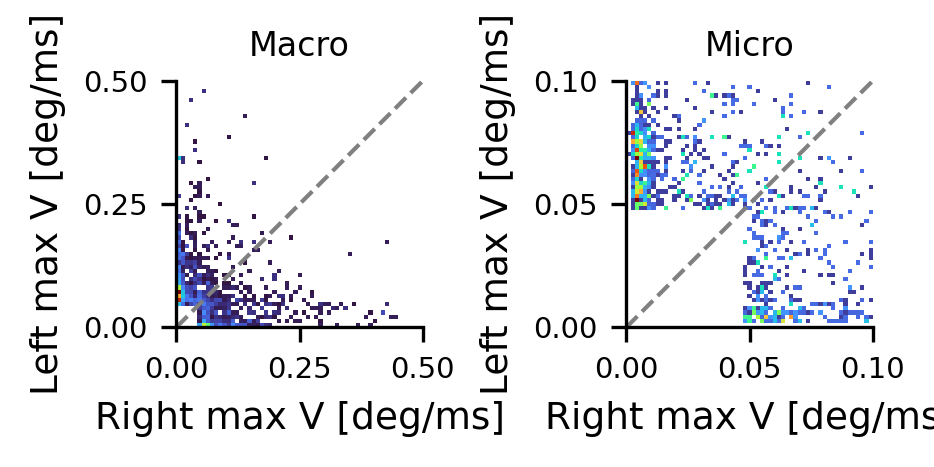

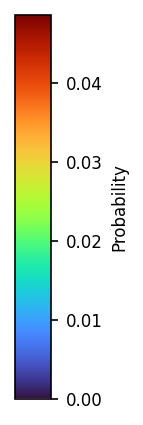

(<Figure size 900x510 with 2 Axes>,
 array([<Axes: title={'center': 'Macro'}, xlabel='Right max V [deg/ms]', ylabel='Left max V [deg/ms]'>,
        <Axes: title={'center': 'Micro'}, xlabel='Right max V [deg/ms]', ylabel='Left max V [deg/ms]'>],
       dtype=object))

In [41]:
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\{t}'
plot_right_vs_left_eye_hist2d_twopanels(
    filtered_saccades.query('head_movement==False and animal !="PV_62"'),
    block_dict,
    export_path=None,
    iqr_multiplier=60, bins=60,
    macro_range=(0, 0.5), micro_range=(0, 0.1),
    macro_tick_list=[0,0.25,0.5],
    micro_tick_list=[0,0.05,0.1],
    event_mode="monocular",            # <— only keep events with NO contra onset nearby
    contra_event_window_ms=100,
    contra_sample_ms=51
)


<ipython-input-34-448dd1ffcf05>:198: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



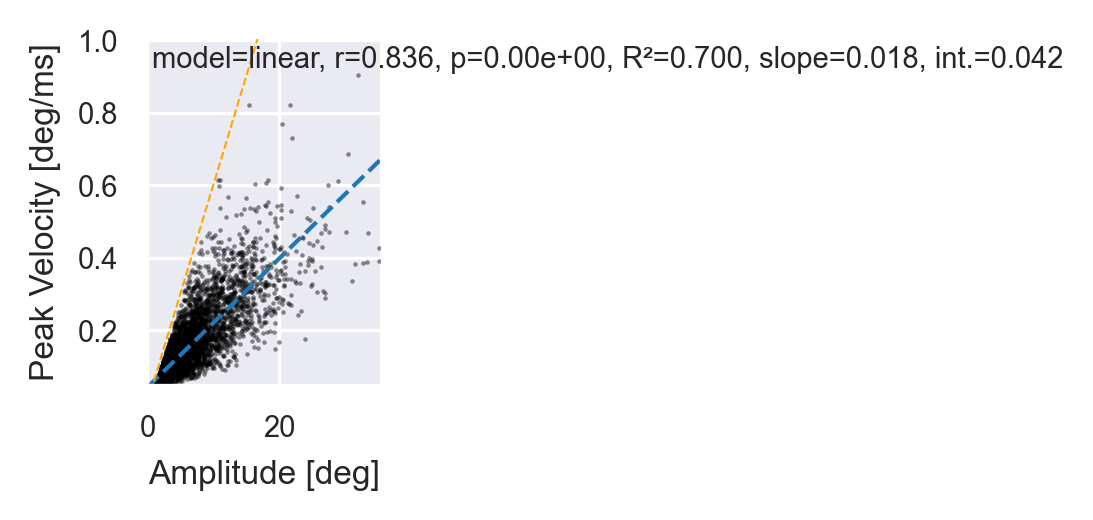

In [36]:
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\amplitude_velocity_bw'
fig, ax, outdir = plot_main_sequence_scatter(
    filtered_saccades.query('head_movement==False and animal != "PV_62"'),
    x_col="magnitude_raw_angular",
    y_col="peak_velocity",
    convert_deg_per_frame_to_ms=True,   # keep your current units if you prefer
    frame_rate_fps=60.0,
    fig_size=(1, 1.5),
    point_size=1.2,
    alpha=0.45,
    margin=0.1,
    export_path=None,
    plot_name="main_sequence_scatter",
    show_regression=True,
    fit_model="linear",        # try: 'linear' | 'power' | 'log' | 'exp_sat' | 'mm'
    annotate_stats=True,
    line_kwargs={"linestyle":"--", "lw":1.0},

)


D# From here, i go through manual saccade outlier filtering

Collect R:  21%|██        | 131/621 [00:00<00:00, 1197.89it/s]

Discovered animals: ['PV_106', 'PV_126', 'PV_143', 'PV_57', 'PV_62']
[OK] PV_106 L: raw=+25.10°, axis_min=+25.10°
[OK] PV_106 R: raw=-17.29°, axis_min=-17.29°
[OK] PV_126 L: raw=-4.46°, axis_min=-4.46°
[OK] PV_126 R: raw=+6.42°, axis_min=+6.42°
[OK] PV_143 L: raw=+4.04°, axis_min=+4.04°
[OK] PV_143 R: raw=-1.94°, axis_min=-1.94°
[OK] PV_57 L: raw=+6.97°, axis_min=+6.97°
[OK] PV_57 R: raw=-7.68°, axis_min=-7.68°
[OK] PV_62 L: raw=-7.33°, axis_min=-7.33°
[OK] PV_62 R: raw=-6.56°, axis_min=-6.56°


Collect L: 100%|██████████| 475/475 [00:00<00:00, 1266.61it/s]


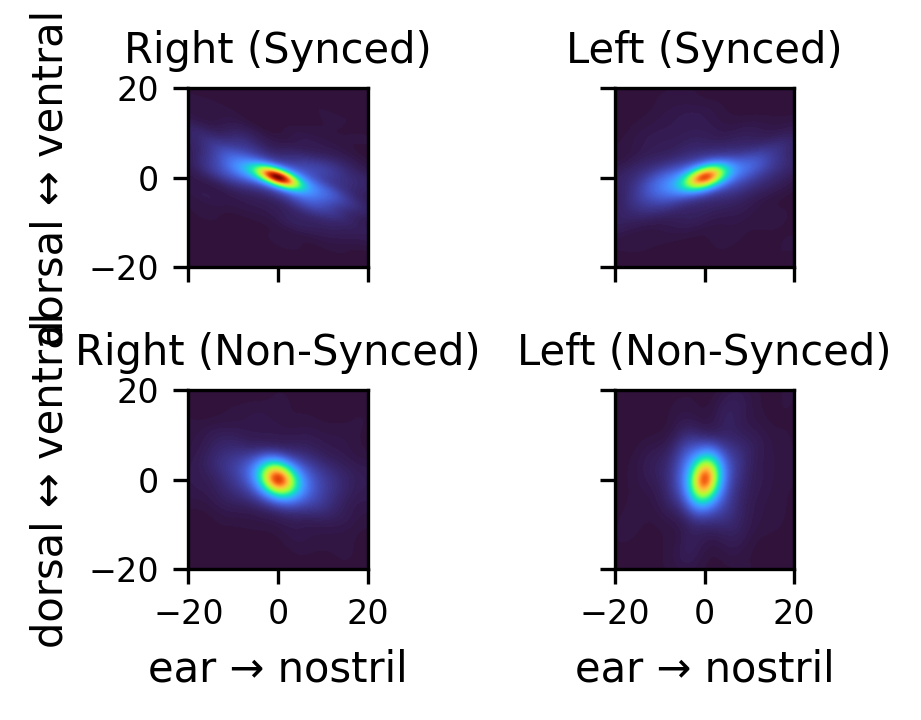

In [45]:
import re, json
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, Tuple, List, Optional

# ---------------- math helpers ----------------
def _wrap180(x_deg: float) -> float:
    return ((x_deg + 180.0) % 360.0) - 180.0

def _minimal_axis_lock_rotation(candidate_deg: float) -> float:
    """
    Axis equivalence: 0° ≡ 180°. Choose smallest-magnitude representative.
    Fold into [-90, +90).
    """
    alts = [candidate_deg, candidate_deg + 180.0, candidate_deg - 180.0]
    best = min(alts, key=lambda ang: abs(_wrap180(ang)))
    best = _wrap180(best)
    if abs(best) > 90.0:
        best = best - 180.0 * np.sign(best)
    return float(best)

def _quat_from_R(R: np.ndarray) -> np.ndarray:
    """3x3 rotation matrix -> unit quaternion (w,x,y,z), robust."""
    R = np.asarray(R, dtype=float)
    t = np.trace(R)
    if t > 0:
        s = np.sqrt(t + 1.0) * 2.0
        w = 0.25 * s
        x = (R[2,1] - R[1,2]) / s
        y = (R[0,2] - R[2,0]) / s
        z = (R[1,0] - R[0,1]) / s
    else:
        i = int(np.argmax([R[0,0], R[1,1], R[2,2]]))
        if i == 0:
            s = np.sqrt(1.0 + R[0,0] - R[1,1] - R[2,2]) * 2.0
            w = (R[2,1] - R[1,2]) / s; x = 0.25 * s
            y = (R[0,1] + R[1,0]) / s; z = (R[0,2] + R[2,0]) / s
        elif i == 1:
            s = np.sqrt(1.0 - R[0,0] + R[1,1] - R[2,2]) * 2.0
            w = (R[0,2] - R[2,0]) / s; x = (R[0,1] + R[1,0]) / s
            y = 0.25 * s;             z = (R[1,2] + R[2,1]) / s
        else:
            s = np.sqrt(1.0 - R[0,0] - R[1,1] + R[2,2]) * 2.0
            w = (R[1,0] - R[0,1]) / s; x = (R[0,2] + R[2,0]) / s
            y = (R[1,2] + R[2,1]) / s; z = 0.25 * s
    q = np.array([w, x, y, z], dtype=float)
    return q / np.linalg.norm(q)

def _twist_about_axis_deg(R: np.ndarray, axis_unit: np.ndarray) -> float:
    """
    Swing–twist decomposition: signed twist angle (deg) about axis_unit (right-hand rule).
    """
    q = _quat_from_R(R)
    w, v = q[0], q[1:]
    n = axis_unit / (np.linalg.norm(axis_unit) or 1.0)
    v_par = n * np.dot(v, n)
    q_tw = np.concatenate([[w], v_par])
    nrm = np.linalg.norm(q_tw)
    if nrm < 1e-12:
        return 0.0
    q_tw /= nrm
    ang = 2.0 * np.arctan2(np.linalg.norm(q_tw[1:]), q_tw[0])
    sign = np.sign(np.dot(v, n)) if np.linalg.norm(v_par) > 1e-12 else 1.0
    return float(np.degrees(ang) * sign)

# ---------------- I/O helpers for your layout ----------------
def _animal_from_folder(folder_name: str) -> Optional[str]:
    """
    Extract 'PV_###' from '<PV_###>_registration' folder names.
    """
    m = re.fullmatch(r'(PV_\d{2,3})_registration', folder_name)
    return m.group(1) if m else None

def discover_animals_under_root(root: Path) -> List[str]:
    """
    Scan root for folders named 'PV_###_registration' and return ['PV_###', ...].
    """
    animals = []
    for p in root.iterdir():
        if p.is_dir():
            a = _animal_from_folder(p.name)
            if a:
                animals.append(a)
    animals.sort()
    return animals

def _paths_for_animal(root: Path, animal: str) -> Dict[str, Dict[str, Path]]:
    """
    Build the exact file paths per your convention.

    Returns:
      {
        'L': {'rot': Path, 'normals': Path},
        'R': {'rot': Path, 'normals': Path}
      }
    """
    base = root / f"{animal}_registration"
    paths = {
        'L': {
            'rot':     base / "l_rot_matrix_v14.json",
            'normals': base / "l_normals_v14.json",
        },
        'R': {
            'rot':     base / "r_rot_matrix_v14.json",
            'normals': base / "r_normals_v14.json",
        }
    }
    return paths

def _load_rot_and_nref(rot_path: Path, normals_path: Path):
    R = np.array(json.loads(rot_path.read_text()), dtype=float).reshape(3,3)
    d = json.loads(normals_path.read_text())
    n_ref = np.array(d['n_ref'], dtype=float)
    n_ref = n_ref / (np.linalg.norm(n_ref) or 1.0)
    return R, n_ref

# ---------------- main catalog builder for your layout ----------------
def build_blender_roll_catalog_from_registration(
    root: Path,
    animals: Optional[List[str]] = None,
    verbose: bool = True,
) -> Dict[Tuple[str, str], float]:
    """
    Build {(animal,'L'|'R'): roll_deg_axis_min} using the fixed path layout:
      <root>/<animal>_registration/l_rot_matrix_v14.json, l_normals_v14.json, ...
    If animals is None, animals are discovered from folder names under root.
    """
    if animals is None:
        animals = discover_animals_under_root(root)
        if verbose:
            print(f"Discovered animals: {animals}")

    catalog: Dict[Tuple[str,str], float] = {}
    for animal in animals:
        files = _paths_for_animal(root, animal)
        for eye in ('L', 'R'):
            rot_p, nrm_p = files[eye]['rot'], files[eye]['normals']
            if not rot_p.exists() or not nrm_p.exists():
                if verbose:
                    print(f"[MISS] {animal} {eye}: missing files "
                          f"({rot_p.name if rot_p.exists() else 'NO rot'}, "
                          f"{nrm_p.name if nrm_p.exists() else 'NO normals'})")
                continue
            try:
                R, n_ref = _load_rot_and_nref(rot_p, nrm_p)
                roll_raw = _twist_about_axis_deg(R, n_ref)             # signed twist about n_ref
                roll_axis_min = _minimal_axis_lock_rotation(roll_raw)  # fold to axis measure [-90,+90)
                catalog[(animal, eye)] = float(roll_axis_min)
                if verbose:
                    print(f"[OK] {animal} {eye}: raw={roll_raw:+.2f}°, axis_min={roll_axis_min:+.2f}°")
            except Exception as e:
                if verbose:
                    print(f"[ERR] {animal} {eye}: {e}")
    return catalog
def plot_saccade_heatmaps_comparison_trajectories(
    synced_saccades, non_synced_saccades, block_dict,
    export_path=None, nbins=200,
    global_min=-25, global_max=25,
    cmap=plt.cm.turbo, figsize=(4, 2.5),
    rotation_catalog=None   # {(animal,'L'|'R'): rotation_deg}; optional
):
    """
    Same behavior as your latest version, but trajectories are rotated per-eye by
    the Blender-registered angle so that +X ≈ ear→nostril and +Y ≈ dorsal.
    Angles are degrees; positive means CCW rotation of image coordinates.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    import os, datetime, pickle, tqdm

    # ---------- helpers ----------
    def _deg2rad(d):
        return np.deg2rad(d)

    def _rotate2d(x, y, deg):
        """Rotate (x,y) by +deg (CCW). Works with numpy arrays."""
        if x.size == 0:
            return x, y
        th = _deg2rad(deg)
        c, s = np.cos(th), np.sin(th)
        xr = c * x - s * y
        yr = s * x + c * y
        return xr, yr

    def _per_eye_rotation(animal, eye):
        """Fetch per-eye rotation in degrees; 0 if catalog not provided/missing."""
        if rotation_catalog is None:
            return 0.0
        return float(rotation_catalog.get((animal, eye), 0.0))

    # ---------- core ----------
    def extract_zeroed_points(saccades_df, eye):
        xs, ys = [], []
        df_eye = saccades_df[saccades_df['eye'] == eye]
        for _, row in tqdm.tqdm(df_eye.iterrows(), total=len(df_eye), desc=f"Collect {eye}"):
            block_num = row['block']
            start_ms  = row['saccade_on_ms']
            end_ms    = row['saccade_off_ms']
            block_key = f"{row['animal']}_block_{block_num}"
            if block_key not in block_dict:
                continue
            block = block_dict[block_key]
            eye_df = block.left_eye_data if eye == 'L' else block.right_eye_data if eye == 'R' else None
            if eye_df is None:
                continue

            traj = eye_df[(eye_df['ms_axis'] >= start_ms) & (eye_df['ms_axis'] <= end_ms)]
            if traj.empty:
                continue

            # zero at onset
            x0 = traj['center_x'].iloc[0]
            y0 = traj['center_y'].iloc[0]
            dx = (traj['center_x'] - x0).to_numpy(dtype=float)
            dy = (traj['center_y'] - y0).to_numpy(dtype=float)

            # per-eye rotation (deg) from Blender registration
            rot_deg = _per_eye_rotation(row['animal'], eye)
            if rot_deg != 0.0:
                dx, dy = _rotate2d(dx, dy, rot_deg)

            xs.extend(dx.tolist())
            ys.extend(dy.tolist())
        return np.asarray(xs, dtype=float), np.asarray(ys, dtype=float)

    # Extract zeroed & rotated trajectory points
    r_x_synced, r_y_synced = extract_zeroed_points(synced_saccades, 'R')
    l_x_synced, l_y_synced = extract_zeroed_points(synced_saccades, 'L')
    r_x_ns,    r_y_ns      = extract_zeroed_points(non_synced_saccades, 'R')
    l_x_ns,    l_y_ns      = extract_zeroed_points(non_synced_saccades, 'L')

    def evaluate_kde(x, y):
        if len(x) == 0 or len(y) == 0:
            return None, None, None
        k  = gaussian_kde(np.vstack([x, y]).astype(float))
        xi, yi = np.mgrid[global_min:global_max:nbins*1j,
                          global_min:global_max:nbins*1j]
        zi = k(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
        zi /= np.sum(zi)
        return xi, yi, zi

    # KDEs
    xi_r_s, yi_r_s, zi_r_s = evaluate_kde(r_x_synced, r_y_synced)
    xi_l_s, yi_l_s, zi_l_s = evaluate_kde(l_x_synced, l_y_synced)
    xi_r_ns, yi_r_ns, zi_r_ns = evaluate_kde(r_x_ns, r_y_ns)
    xi_l_ns, yi_l_ns, zi_l_ns = evaluate_kde(l_x_ns, l_y_ns)

    # Shared color scale
    all_zi = [z for z in [zi_r_s, zi_l_s, zi_r_ns, zi_l_ns] if z is not None]
    vmin, vmax = (min(z.min() for z in all_zi), max(z.max() for z in all_zi)) if all_zi else (0, 1)

    # Figure
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize, dpi=300, sharey=True, sharex=True)

    def plot_heatmap(ax, xi, yi, zi, title):
        if zi is not None:
            im = ax.imshow(
                zi.T,
                extent=[global_min, global_max, global_min, global_max],
                origin='lower', cmap=cmap, vmin=vmin, vmax=vmax
            )
        else:
            im = None
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=8, transform=ax.transAxes)
        ax.set_title(title, fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_aspect('equal', 'box')
        return im

    im1 = plot_heatmap(axes[0, 0], xi_r_s,  yi_r_s,  zi_r_s,  'Right (Synced)')
    im2 = plot_heatmap(axes[0, 1], xi_l_s,  yi_l_s,  zi_l_s,  'Left (Synced)')
    im3 = plot_heatmap(axes[1, 0], xi_r_ns, yi_r_ns, zi_r_ns, 'Right (Non-Synced)')
    im4 = plot_heatmap(axes[1, 1], xi_l_ns, yi_l_ns, zi_l_ns, 'Left (Non-Synced)')

    # Label axes to reflect anatomical frame
    axes[1,0].set_xlabel("ear → nostril")
    axes[1,1].set_xlabel("ear → nostril")
    axes[0,0].set_ylabel("dorsal ↔ ventral")
    axes[1,0].set_ylabel("dorsal ↔ ventral")

    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # Export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_heatmaps_trajectories_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_heatmaps_comparison_trajectories.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_trajectories_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({
                'synced': {'R': (r_x_synced, r_y_synced), 'L': (l_x_synced, l_y_synced)},
                'non_synced': {'R': (r_x_ns, r_y_ns), 'L': (l_x_ns, l_y_ns)},
                'rotation_catalog': rotation_catalog
            }, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()

# catalog_blender should be {(animal,'R'): deg, (animal,'L'): deg}
# e.g., from your JSON loader
from pathlib import Path

root = Path(r"D:\MarkS3\Documents\BlenderFiles\Camera_angle_registration")

# Option A: auto-discover animals from folder names like 'PV_62_registration'
catalog_blender = build_blender_roll_catalog_from_registration(root, animals=None, verbose=True)

plot_saccade_heatmaps_comparison_trajectories(
    synced_saccade_collection.query('animal=="PV_143"'),
    non_synced_saccade_collection.query('animal=="PV_143"'),
    block_dict,
    export_path=None,
    nbins=200, global_min=-20, global_max=20,
    cmap=plt.cm.turbo, figsize=(4, 2.5),
    rotation_catalog=None   # <-- add this
)

(5, 19)


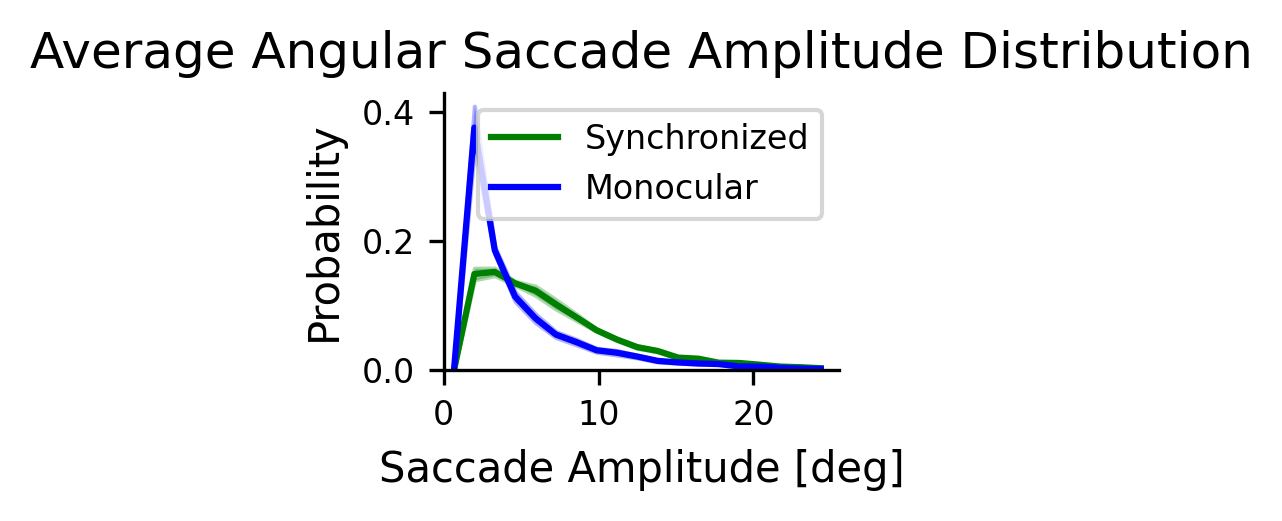

In [24]:
# overall saccade magnitude histogram
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t
import datetime
import os
import pickle

def plot_averaged_saccade_amplitude_distribution_angle(
    synced_saccade_collection, non_synced_saccade_collection, figure_size=(2.5, 1.7), export_path=None,
    bins=np.linspace(0,5,40)
):
    """
    Plots the average angular saccade amplitude likelihood histogram across animals,
    showing only the outline (with SEM shading) of the distributions.

    For each saccade event, the angular amplitude is computed as:

        angular_amplitude [deg] = sqrt( (angle_dx)^2 + (angle_dy)^2 )

    Parameters:
    - synced_saccade_collection (pd.DataFrame): DataFrame containing synced saccade data with an 'animal' column,
          and the angular delta columns 'angle_dx' and 'angle_dy'.
    - non_synced_saccade_collection (pd.DataFrame): DataFrame containing non-synced saccade data with an 'animal' column,
          and the angular delta columns.
    - figure_size (tuple): Size of the figure for the plot.
    - export_path (str or pathlib.Path, optional): Path to save the plot and data.
    - bins (array-like): Bin edges for the histogram (default spans 0 to 5 deg).
    """
    # Compute angular amplitude for each event (if not already computed)
    # We'll add a new column "angular_magnitude" computed from angle_dx and angle_dy.
    for df in [synced_saccade_collection, non_synced_saccade_collection]:
        if 'magnitude_raw_angular' not in df.columns:
            df['magnitude_raw_angular'] = np.abs(df['delta_phi']) + np.abs(df['delta_theta'])

    bin_centers = (bins[:-1] + bins[1:]) / 2  # For plotting the outline

    # Group by animals
    animals = synced_saccade_collection['animal'].unique()
    num_animals = len(animals)

    # Store normalized histograms for synced and non-synced data
    synced_likelihoods = []
    non_synced_likelihoods = []

    for animal in animals:
        # For each animal, filter the angular amplitudes
        synced_data = synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values
        non_synced_data = non_synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values

        # Calculate histograms normalized to probabilities
        synced_hist, _ = np.histogram(synced_data, bins=bins)
        non_synced_hist, _ = np.histogram(non_synced_data, bins=bins)
        if synced_hist.sum() > 0:
            synced_hist = synced_hist / synced_hist.sum()
        if non_synced_hist.sum() > 0:
            non_synced_hist = non_synced_hist / non_synced_hist.sum()

        synced_likelihoods.append(synced_hist)
        non_synced_likelihoods.append(non_synced_hist)

    # Convert to arrays for averaging
    synced_likelihoods = np.array(synced_likelihoods)
    non_synced_likelihoods = np.array(non_synced_likelihoods)
    print(np.shape(synced_likelihoods))

    # Calculate mean and SEM across animals
    synced_mean = synced_likelihoods.mean(axis=0)
    synced_sem = synced_likelihoods.std(axis=0) / np.sqrt(num_animals)

    non_synced_mean = non_synced_likelihoods.mean(axis=0)
    non_synced_sem = non_synced_likelihoods.std(axis=0) / np.sqrt(num_animals)

    # Plot averaged histograms
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)

    # Plot outline and SEM for synced (angle-based)
    ax.plot(bin_centers, synced_mean, color='green', linestyle='-', linewidth=1.5, label='Synchronized')
    ax.fill_between(bin_centers, synced_mean - synced_sem, synced_mean + synced_sem, color='green', alpha=0.3)

    # Plot outline and SEM for non-synced (angle-based)
    ax.plot(bin_centers, non_synced_mean, color='blue', linestyle='-', linewidth=1.5, label='Monocular')
    ax.fill_between(bin_centers, non_synced_mean - non_synced_sem, non_synced_mean + non_synced_sem, color='blue', alpha=0.3)

    # Customize the plot
    ax.set_title('Average Angular Saccade Amplitude Distribution', fontsize=12)
    ax.set_xlabel('Saccade Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Probability', fontsize=10)
    ax.legend(fontsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    # Handle export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_amplitude_averaged_histogram_angle_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_amplitude_averaged_histogram_angle.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "averaged_saccade_amplitude_angle_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({
                'synced_mean': synced_mean,
                'synced_sem': synced_sem,
                'non_synced_mean': non_synced_mean,
                'non_synced_sem': non_synced_sem,
                'bins': bins,
            }, f)
        print(f"Exported plot and data to: {full_export_path}")


    plt.show()
    print()

export_path = r"Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_amp_hist_deg"

plot_averaged_saccade_amplitude_distribution_angle(
    synced_saccade_collection, non_synced_saccade_collection, figure_size=(1.7, 1.2), export_path=None,
    bins=np.linspace(0,25,20))

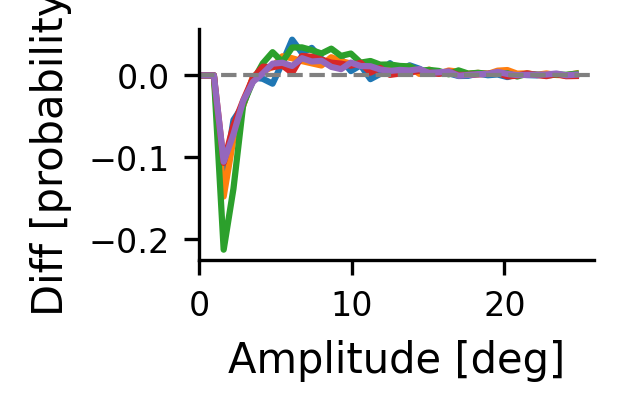

In [23]:
def plot_difference_saccade_amplitude_distribution_all_animals(
    synced_saccade_collection, non_synced_saccade_collection, figure_size=(2, 1.5), export_path=None,
    bins=np.linspace(0,5,40)
):
    """
    Plots the difference (synchronized minus monocular) of the normalized saccade amplitude histograms
    for each animal on a single plot. Each animal's trace is given a unique color.

    Parameters:
    - synced_saccade_collection (pd.DataFrame): DataFrame containing synchronized saccade data with an 'animal' column,
          and angular data (e.g. 'delta_phi' and 'delta_theta').
    - non_synced_saccade_collection (pd.DataFrame): DataFrame containing non-synchronized saccade data with an 'animal' column.
    - figure_size (tuple): Size of the figure.
    - export_path (str or pathlib.Path, optional): Directory where the plot and data will be saved.
    - bins (array-like): Bin edges for the histogram (default spans 0 to 5 deg).
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import datetime, os, pickle

    # Make sure both DataFrames have the computed angular amplitude column.
    for df in [synced_saccade_collection, non_synced_saccade_collection]:
        if 'magnitude_raw_angular' not in df.columns:
            df['magnitude_raw_angular'] = np.abs(df['delta_phi']) + np.abs(df['delta_theta'])

    # Compute bin centers for plotting.
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Retrieve unique animals.
    animals = synced_saccade_collection['animal'].unique()

    # Set up a single figure and axes.
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)

    # Get the default color cycle from matplotlib.
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Loop over each animal and plot its difference trace.
    for i, animal in enumerate(animals):
        # Filter data for the current animal.
        synced_data = synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values
        non_synced_data = non_synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values

        # Compute histograms.
        synced_hist, _ = np.histogram(synced_data, bins=bins)
        non_synced_hist, _ = np.histogram(non_synced_data, bins=bins)

        # Normalize the histograms.
        if synced_hist.sum() > 0:
            synced_hist = synced_hist / synced_hist.sum()
        if non_synced_hist.sum() > 0:
            non_synced_hist = non_synced_hist / non_synced_hist.sum()

        # Compute the difference: (synchronized minus monocular).
        diff_trace = synced_hist - non_synced_hist

        # Plot the trace using a color from the cycle.
        ax.plot(bin_centers, diff_trace, color=colors[i % len(colors)], linestyle='-',
                linewidth=1.5, label=f'{animal}')

    # Add a horizontal reference line at zero.
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Customize the plot.
    #ax.set_title('Difference in Saccade Amplitude Distribution\n(Synchronized - Monocular)', fontsize=12)
    ax.set_xlabel('Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Diff [probability]', fontsize=10)
    #ax.legend(fontsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(left=0)

    # Optionally export the plot and data.
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_amplitude_difference_all_animals_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_amplitude_difference_all_animals.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_amplitude_difference_all_animals_data.pkl")
        # Save each animal's difference trace keyed by animal name.
        data_dict = {}
        for animal in animals:
            synced_data = synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values
            non_synced_data = non_synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values
            synced_hist, _ = np.histogram(synced_data, bins=bins)
            non_synced_hist, _ = np.histogram(non_synced_data, bins=bins)
            if synced_hist.sum() > 0:
                synced_hist = synced_hist / synced_hist.sum()
            if non_synced_hist.sum() > 0:
                non_synced_hist = non_synced_hist / non_synced_hist.sum()
            data_dict[animal] = synced_hist - non_synced_hist
        with open(data_file, 'wb') as f:
            pickle.dump({
                'animal_diff_traces': data_dict,
                'bins': bins,
            }, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_amp_hist_deg\diff_per_animal'
plot_difference_saccade_amplitude_distribution_all_animals(synced_saccade_collection,
                                                          non_synced_saccade_collection,
                                                          figure_size=(1.7, 1),
                                                          export_path=None,
                                                          bins=np.linspace(0,25,40))


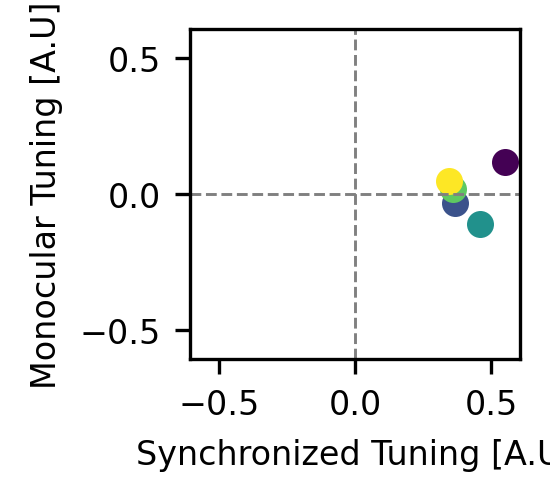

{'PV_143': (0.5518796992481203, 0.1182994454713493),
 'PV_62': (0.36865148861646224, -0.031075697211155384),
 'PV_106': (0.45789640927867814, -0.1110173068805404),
 'PV_126': (0.3607327383748238, 0.017363851617995252),
 'PV_57': (0.3436293436293436, 0.046583116576022654)}

In [25]:
import numpy as np
import matplotlib.pyplot as plt
def calculate_orientation_tuning(saccade_angles):
    """
    Calculates the orientation tuning statistic for a collection of saccade angles.

    Parameters:
        saccade_angles (array-like): List or array of saccade angles in degrees.

    Returns:
        float: Orientation tuning statistic.
    """
    # Convert angles to range [0, 360] if they aren't already
    saccade_angles = np.array(saccade_angles) % 360

    # Define horizontal saccade ranges
    horizontal_ranges = [
        (315, 360),  # 330° to 0°
        (0, 45),     # 0° to 30°
        (135, 225)   # 150° to 210°
    ]

    # Identify horizontal saccades
    is_horizontal = np.logical_or.reduce([
        (saccade_angles >= low) & (saccade_angles <= high)
        if low < high else
        (saccade_angles >= low) | (saccade_angles <= high)
        for low, high in horizontal_ranges
    ])

    # Calculate probabilities
    p_horizontal = np.sum(is_horizontal) / len(saccade_angles)
    p_vertical = 1 - p_horizontal  # Vertical saccades are the complement

    # Calculate orientation tuning
    tuning_statistic = (p_horizontal - p_vertical) / (p_horizontal + p_vertical)

    return tuning_statistic

# 'tuning' is not good - I need to use something that will be clear to someone without reading the text.. maybe saccade horizontal bias

def analyze_orientation_tuning(synced_df, non_synced_df, export_path=None):
    """
    Analyze orientation tuning for each unique animal in the given dataframes.

    Parameters:
        synced_df (pd.DataFrame): DataFrame containing 'animal' and 'angle' columns for synchronized saccades.
        non_synced_df (pd.DataFrame): DataFrame containing 'animal' and 'angle' columns for non-synchronized saccades.

    Returns:
        dict: Dictionary with animal IDs as keys and a tuple of (synced_tuning, non_synced_tuning) as values.
    """
    # Initialize dictionary to store results
    tuning_results = {}

    # Get unique animals
    unique_animals = synced_df['animal'].unique()

    for animal in unique_animals:
        # Filter data for the current animal
        synced_angles = synced_df.query('animal == @animal')['overall_angle_deg'].values
        non_synced_angles = non_synced_df.query('animal == @animal')['overall_angle_deg'].values

        # Calculate orientation tuning
        synced_tuning = calculate_orientation_tuning(synced_angles)
        non_synced_tuning = calculate_orientation_tuning(non_synced_angles)

        # Save to dictionary
        tuning_results[animal] = (synced_tuning, non_synced_tuning)

    # Plot results
    fig, ax = plt.subplots(figsize=(2, 2), dpi=300)

    synced_tuning_values = [v[0] for v in tuning_results.values()]
    non_synced_tuning_values = [v[1] for v in tuning_results.values()]
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_animals)))  # Generate unique colors

    for i, animal in enumerate(unique_animals):
        ax.scatter(
            synced_tuning_values[i],
            non_synced_tuning_values[i],
            color=colors[i],
            label=f"{animal}",
            s=30  # Marker size
        )

    # Formatting
    ax.set_xlabel("Synchronized Tuning [A.U]", fontsize=8)
    ax.set_ylabel("Monocular Tuning [A.U]", fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_aspect('equal')  # Ensure equal scaling
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.7)

    # Adjust axes limits to make sure x and y scales are identical
    all_values = synced_tuning_values + non_synced_tuning_values
    axis_limit = max(abs(min(all_values)), abs(max(all_values))) * 1.1
    ax.set_xlim(-axis_limit, axis_limit)
    ax.set_ylim(-axis_limit, axis_limit)

    # Move legend outside the plot
    #ax.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0)

    plt.tight_layout()
    if export_path:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_dir = pathlib.Path(export_path) / f'{timestamp}_horizontal_tuning_per_animal'
        export_dir.mkdir(parents=True, exist_ok=True)

        # Save PDF
        export_file_pdf = export_dir / f'{timestamp}_horizontal_tuning_per_animal.pdf'
        plt.savefig(export_file_pdf, format='pdf')
        print(f"Exported plot to {export_file_pdf}")

        # Save Pickle
        export_file_pkl = export_dir / f'{timestamp}_saccade_angles_data.pkl'
        with open(export_file_pkl, 'wb') as pkl_file:
            pickle.dump(saccade_collection, pkl_file)
        print(f"Exported data to {export_file_pkl}")
    plt.show()

    return tuning_results

export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\horizontal_tuning'
analyze_orientation_tuning(synced_saccade_collection,non_synced_saccade_collection,export_path=None)

###END OF CLEANED SECTION

In [240]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

def launch_main_sequence_lasso_plotly(
    df: pd.DataFrame,
    x_col: str = "magnitude_raw_angular",
    y_col: str = "peak_velocity",
    *,
    convert_deg_per_frame_to_ms: bool = False,
    frame_rate_fps: float = 60.0,
    title: str = "Main sequence (lasso to collect outliers)",
    point_size: float = 4.0,
    point_opacity: float = 0.45,
    show_regression: bool = True,
):
    """
    Returns:
        fig:      plotly.graph_objects.FigureWidget
        view_df:  cleaned DataFrame actually plotted; has columns ['A','V','orig_idx']
        stats:    dict with slope/intercept/r/R2 if show_regression else None
    """
    data = df.copy()
    if y_col not in data.columns:
        raise ValueError(f"'{y_col}' not in df. Provide a column or pre-compute it.")

    # Optional unit conversion (deg/frame -> deg/ms)
    if convert_deg_per_frame_to_ms:
        frame_ms = 1000.0 / float(frame_rate_fps)
        data[y_col] = data[y_col] / frame_ms

    # Clean & keep positives
    mask = (
        np.isfinite(data[x_col]) & (data[x_col] > 0) &
        np.isfinite(data[y_col]) & (data[y_col] > 0)
    )
    view_df = data.loc[mask, [x_col, y_col]].copy()
    if view_df.empty:
        raise ValueError("No valid points after filtering.")
    view_df["orig_idx"] = view_df.index
    view_df = view_df.rename(columns={x_col: "A", y_col: "V"}).copy()

    # Equal numeric span on both axes
    lo = float(min(view_df["A"].min(), view_df["V"].min()))
    hi = float(max(view_df["A"].max(), view_df["V"].max()))
    span = hi - lo
    if span <= 0:
        lo, hi = 0.0, max(1.0, hi)
    pad = 0.05 * (hi - lo if hi > lo else 1.0)
    x_range = [lo - pad, hi + pad]
    y_range = [lo - pad, hi + pad]

    # Base scatter (use Scattergl for speed with many points)
    sc = go.Scattergl(
        x=view_df["A"], y=view_df["V"],
        mode="markers",
        marker=dict(size=point_size, opacity=point_opacity),
        selected=dict(marker=dict(size=point_size+2)),
        unselected=dict(marker=dict(opacity=point_opacity)),
        name="events"
    )

    fig = go.FigureWidget(data=[sc])
    fig.update_layout(
        title=title,
        dragmode="lasso",        # start with lasso (you can switch to box in the toolbar)
        xaxis_title="Amplitude [deg]",
        yaxis_title=("Peak Velocity [deg/ms]" if convert_deg_per_frame_to_ms else "Peak Velocity [deg/frame]"),
        xaxis=dict(range=x_range, scaleratio=1, constrain="range"),
        yaxis=dict(range=y_range, scaleanchor="x"),  # same numeric span + square aspect
        height=420, width=640,
        margin=dict(l=60, r=10, t=40, b=50)
    )

    # Optional regression overlay
    stats = None
    if show_regression and len(view_df) >= 2:
        A = view_df["A"].to_numpy()
        V = view_df["V"].to_numpy()
        slope, intercept = np.polyfit(A, V, 1)
        r = np.corrcoef(A, V)[0, 1]
        r2 = float(r**2)
        stats = dict(slope=float(slope), intercept=float(intercept), r=float(r), R2=r2)

        x_line = np.linspace(x_range[0], x_range[1], 200)
        y_line = slope * x_line + intercept
        fig.add_scatter(x=x_line, y=y_line, mode="lines", name="OLS", line=dict(dash="dash"))

        fig.update_layout(title=f"{title} (r={r:.3f}, R²={r2:.3f}, slope={slope:.3f}, int.={intercept:.3f})")

    display(fig)  # ensure the widget renders in-place
    return fig, view_df, stats


def get_selected_subset_plotly(
    fig: go.FigureWidget,
    view_df: pd.DataFrame,
    original_df: pd.DataFrame = None
) -> pd.DataFrame:
    """
    Reads currently selected points from the FigureWidget and returns a DataFrame.
    If original_df is provided, returns those original rows (all columns) using 'orig_idx'.
    """
    # selectedpoints are index positions into the *trace's* data arrays (same order as view_df)
    sel = fig.data[0].selectedpoints
    if not sel:
        return pd.DataFrame(columns=(original_df.columns if original_df is not None else view_df.columns))
    picked = view_df.iloc[list(sel)]
    if original_df is None:
        return picked
    return original_df.loc[picked["orig_idx"].values]


In [249]:
# 1) Build your filtered df, as before:
df_use = filtered_saccades.query(
    'head_movement==False and animal != "PV_62"'
)

# 2) Launch interactive figure
fig, view_df, stats = launch_main_sequence_lasso_plotly(
    df_use,
    x_col="magnitude_raw_angular",
    y_col="peak_velocity",
    convert_deg_per_frame_to_ms=False,
    title="Main sequence (lasso to collect outliers)",
    point_size=4.0, point_opacity=0.45, show_regression=True
)

FigureWidget({
    'data': [{'marker': {'opacity': 0.45, 'size': 4.0},
              'mode': 'markers',
              'name': 'events',
              'selected': {'marker': {'size': 6.0}},
              'type': 'scattergl',
              'uid': '2878857c-982b-485c-9546-0b153a6c9d0c',
              'unselected': {'marker': {'opacity': 0.45}},
              'x': array([4.75654836, 3.77292389, 1.70140414, ..., 8.97522325, 5.40068903,
                          4.51347842]),
              'y': array([1.89750303, 2.89177602, 0.94773718, ..., 1.72715725, 1.38962263,
                          1.54272811])},
             {'line': {'dash': 'dash'},
              'mode': 'lines',
              'name': 'OLS',
              'type': 'scatter',
              'uid': 'a50105db-8ff4-4641-8bdf-254d29bfb29a',
              'x': array([-9.22986035e-01, -7.32461609e-01, -5.41937184e-01, -3.51412758e-01,
                          -1.60888332e-01,  2.96360940e-02,  2.20160520e-01,  4.10684946e-01,
           

In [242]:
# 3) Use the toolbar lasso (or box) to select points.
#    Then run this cell to retrieve the exact rows you selected:
picked = get_selected_subset_plotly(fig, view_df, original_df=df_use)
picked.shape, picked.head()


((39, 30),
         Main  Sub  saccade_start_ind  saccade_end_ind  \
 3655     NaN  NaN              25661            25668   
 4351     NaN  NaN              29865            29869   
 6153  1876.0    L              41620            41625   
 8347  1997.0    L              60319            60326   
 8624  6640.0    L              65494            65500   
 
       saccade_start_timestamp  saccade_end_timestamp  saccade_on_ms  \
 3655                8996732.0              8999063.0      449836.60   
 4351               10383020.0             10384352.0      519151.00   
 6153               14448568.0             14450233.0      722428.40   
 8347               20675335.0             20677666.0     1033766.75   
 8624               22315556.0             22317524.0     1115777.80   
 
       saccade_off_ms  length  magnitude_raw_pixel  ...  phi_init_pos  \
 3655       449953.15       7            31.295507  ...     -1.883892   
 4351       519217.60       4            33.843447  ...    

In [243]:
picked

Main  Sub  saccade_start_ind  saccade_end_ind  \
3655      NaN  NaN              25661            25668   
4351      NaN  NaN              29865            29869   
6153   1876.0    L              41620            41625   
8347   1997.0    L              60319            60326   
8624   6640.0    L              65494            65500   
8969      NaN  NaN              71735            71741   
10732  2120.0    L             107267           107271   
10740  2125.0    L             107349           107359   
10757  2134.0    L             107774           107782   
10766  2135.0    L             107863           107869   
11176  1742.0    L             126731           126738   
11228  1760.0    L             128324           128334   
11749  2732.0    R               1354             1355   
12433  2744.0    R               5605             5608   
13185  2198.0    R              10278            10280   
16693  6214.0    R              30723            30730   
16980  6229.0    R              32109            32112   
17007  6231.0    R              32278            32285   
18110     NaN  NaN              38243            38252   
20563     NaN  NaN              57004            57016   
20696  6589.0    R              57664            57670   
20706  6591.0    R              57935            57941   
20748  6594.0    R              58481            58486   
20773  6595.0    R              58722            58730   
21010  6626.0    R              62236            62238   
21653  6732.0    R              74014            74020   
21919  6755.0    R              78279            78287   
22040  6766.0    R              81107            81112   
22371  6816.0    R              86650            86660   
22376  6817.0    R              86808            86816   
22780     NaN  NaN              94632            94636   
23066  6891.0    R             100186           100194   
23410  2124.0    R             107293           107301   
23432  2134.0    R             107774           107779   
23445  2139.0    R             108162           108168   
23634     NaN  NaN             115631           115637   
23674     NaN  NaN             117596           117601   
23750  1707.0    R             120603           120607   
24224     NaN  NaN             142844           142845   

       saccade_start_timestamp  saccade_end_timestamp  saccade_on_ms  \
3655                 8996732.0              8999063.0      449836.60   
4351                10383020.0             10384352.0      519151.00   
6153                14448568.0             14450233.0      722428.40   
8347                20675335.0             20677666.0     1033766.75   
8624                22315556.0             22317524.0     1115777.80   
8969                24476863.0             24478861.0     1223843.15   
10732               36309019.0             36310351.0     1815450.95   
10740               36336325.0             36339655.0     1816816.25   
10757               36477850.0             36480514.0     1823892.50   
10766               36507487.0             36509485.0     1825374.35   
11176               42668587.0             42670918.0     2133429.35   
11228               43199056.0             43202386.0     2159952.80   
11749                 930353.0               930686.0       46517.65   
12433                2345936.0              2346935.0      117296.80   
13185                3766979.0              3767645.0      188348.95   
16693               10908469.0             10910760.0      545423.45   
16980               11363164.0             11364143.0      568158.20   
17007               11418595.0             11420896.0      570929.75   
18110               13554747.0             13557697.0      677737.35   
20563               19326737.0             19330733.0      966336.85   
20696               19746928.0             19748896.0      987346.40   
20706               19835842.0             19837810.0      991792.10   
20748               20014942.0  

In [232]:
# old version for safety
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Optional, Tuple, Dict, List

def review_events_multi(
    block_dict: Dict[str, object],
    events_subset_df: pd.DataFrame,
    export_dir: Optional[Path] = None,   # <-- now optional; None is allowed
    # column names in events_subset_df (auto-detected if not provided)
    animal_col: str = "animal",
    block_col: str = "block",
    eye_col: str = "eye",
    start_ms_col: Optional[str] = None,  # auto-detect among: 'start_ms','saccade_on_ms'
    end_ms_col: Optional[str] = None,    # auto-detect among: 'end_ms','saccade_off_ms'
    window_scale: float = 0.9,
    text_cols: Tuple[str, ...] = ("phi","theta","peak_velocity","magnitude_raw_angular","pupil_diameter"),
    font_scale: float = 0.6,
    thickness: int = 2,
    wait_ms: int = 15,
    flip_mode: str = "vertical",  # "vertical" or "none"
) -> pd.DataFrame:
    """
    Multi-animal/multi-block synchronized L/R eye visualizer for outlier vetting.

    Adds UI buttons:
      - mark_bad  -> sets manual_outlier_detected=True (button shown RED for current event)
      - mark_good -> sets manual_outlier_detected=False (button shown GREEN for current event)
      - export_annotated_df -> writes CSV with columns:
          animal, block, eye, start_ms, end_ms, manual_outlier_detected
        If export_dir is None, writes to CWD with a timestamped filename.

    Always returns the reviewed DataFrame with the 'manual_outlier_detected' column.
    """

    # ---------- resolve timing cols ----------
    def _resolve_time_cols(df: pd.DataFrame, start_c: Optional[str], end_c: Optional[str]) -> Tuple[str, str]:
        cand_start = [start_c, "start_ms", "saccade_on_ms"]
        cand_end   = [end_c,   "end_ms",   "saccade_off_ms"]
        s = next((c for c in cand_start if c and c in df.columns), None)
        e = next((c for c in cand_end   if c and c in df.columns), None)
        if s is None or e is None:
            raise ValueError("Could not resolve start/end ms columns. "
                             "Tried: start in {start_ms,saccade_on_ms}, end in {end_ms,saccade_off_ms}.")
        return s, e

    start_ms_col, end_ms_col = _resolve_time_cols(events_subset_df, start_ms_col, end_ms_col)

    # ---------- working copy ----------
    events = events_subset_df.copy().reset_index(drop=True)
    # keep None for "unset" until user marks
    if "manual_outlier_detected" not in events.columns:
        events["manual_outlier_detected"] = None

    # ---------- guards ----------
    for c in (animal_col, block_col, eye_col, start_ms_col, end_ms_col):
        if c not in events.columns:
            raise ValueError(f"events_subset_df is missing required column '{c}'")

    # ---------- helpers ----------
    def _frame_col(df: pd.DataFrame) -> Optional[str]:
        for c in ("eye_frame", "frame", "frame_idx", "video_frame"):
            if c in df.columns:
                return c
        return None

    def _lookup_block(animal: str, block_num: int):
        # Scan values for exact match
        for obj in block_dict.values():
            if getattr(obj, "animal_call", None) == animal and getattr(obj, "block_num", None) == block_num:
                return obj
        # Key patterns
        key1 = f"{animal}_block_{block_num}"
        key2 = f"{animal}_block_{int(block_num):03d}"
        if key1 in block_dict: return block_dict[key1]
        if key2 in block_dict: return block_dict[key2]
        raise KeyError(f"BlockSync not found for animal='{animal}', block={block_num}")

    def _nearest_row(df: pd.DataFrame, ms: float) -> Optional[pd.Series]:
        arr = df["ms_axis"].values
        if len(arr) == 0:
            return None
        idx = int(np.argmin(np.abs(arr - ms)))
        return df.iloc[idx]

    def _apply_flip(img: np.ndarray) -> np.ndarray:
        if flip_mode == "vertical":
            return cv2.flip(img, 0)  # y-axis reversal
        return img

    # ---------- lazy video state ----------
    capL, capR = None, None
    cur_animal, cur_block = None, None
    cur_blocksync = None
    left_df = None
    right_df = None
    left_frame_col = None
    right_frame_col = None
    fpsL = 60.0
    fpsR = 60.0
    Wl = Hl = Wr = Hr = 0

    def _release_caps():
        nonlocal capL, capR
        if capL is not None:
            capL.release(); capL = None
        if capR is not None:
            capR.release(); capR = None

    def _open_for(animal: str, block_num: int):
        nonlocal cur_animal, cur_block, cur_blocksync
        nonlocal left_df, right_df, left_frame_col, right_frame_col
        nonlocal capL, capR, fpsL, fpsR, Wl, Hl, Wr, Hr

        if animal == cur_animal and block_num == cur_block:
            return

        _release_caps()
        bs = _lookup_block(animal, block_num)
        cur_blocksync = bs
        cur_animal, cur_block = animal, block_num

        left_df = getattr(bs, "left_eye_data", None)
        right_df = getattr(bs, "right_eye_data", None)
        if left_df is None or right_df is None:
            raise RuntimeError(f"Missing left/right eye data for {animal} block {block_num}.")
        if "ms_axis" not in left_df.columns or "ms_axis" not in right_df.columns:
            raise RuntimeError(f"'ms_axis' missing in eye data for {animal} block {block_num}.")

        left_frame_col = _frame_col(left_df)
        right_frame_col = _frame_col(right_df)

        lv = Path(bs.le_videos[0])
        rv = Path(bs.re_videos[0])
        capL_local = cv2.VideoCapture(str(lv))
        capR_local = cv2.VideoCapture(str(rv))
        if not capL_local.isOpened():
            raise RuntimeError(f"Cannot open left video: {lv}")
        if not capR_local.isOpened():
            raise RuntimeError(f"Cannot open right video: {rv}")
        capL, capR = capL_local, capR_local

        Wl, Hl = int(capL.get(cv2.CAP_PROP_FRAME_WIDTH)), int(capL.get(cv2.CAP_PROP_FRAME_HEIGHT))
        Wr, Hr = int(capR.get(cv2.CAP_PROP_FRAME_WIDTH)), int(capR.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fpsL = capL.get(cv2.CAP_PROP_FPS) or 60.0
        fpsR = capR.get(cv2.CAP_PROP_FPS) or 60.0

    def _seek(cap, idx: int):
        cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, int(idx)))

    def _read(cap):
        ret, f = cap.read()
        if not ret: return None
        return f

    def _overlay_text(img, lines: List[str], origin=(10, 24), vstep=22, color=(255,255,255)):
        x,y = origin
        for ln in lines:
            cv2.putText(img, ln, (x,y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness, cv2.LINE_AA)
            y += vstep

    def _overlay_ellipse(img, df_eye: Optional[pd.DataFrame], frame_idx: Optional[int]):
        if df_eye is None or frame_idx is None: return
        col = _frame_col(df_eye)
        if col is None: return
        hit = df_eye[df_eye[col] == frame_idx]
        if hit.empty: return
        row = hit.iloc[0]
        cx, cy = row.get("center_x", np.nan), row.get("center_y", np.nan)
        w, h  = row.get("width", np.nan), row.get("height", np.nan)
        phi   = row.get("phi", np.nan)
        if not (pd.isna(cx) or pd.isna(cy) or pd.isna(w) or pd.isna(h)):
            cv2.ellipse(
                img,
                (int(round(cx)), int(round(cy))),
                (max(1,int(round(w))), max(1,int(round(h)))),
                float(0 if pd.isna(phi) else phi),
                0, 360, (0,255,0), thickness
            )

    # ---------- display geometry ----------
    disp_Wl, disp_Hl = 0, 0
    disp_Wr, disp_Hr = 0, 0

    # ---------- controls ----------
    ctrl_w, ctrl_h = 420, 360
    buttons = {
        "Play":                  ((10,  10),(200, 60)),
        "Pause":                 ((220, 10),(410, 60)),
        "Prev":                  ((10,  80),(200,130)),
        "Next":                  ((220, 80),(410,130)),
        "Step -1":               ((10,  150),(200,200)),
        "Step +1":               ((220, 150),(410,200)),
        "mark_bad":              ((10,  220),(200,270)),   # red when BAD
        "mark_good":             ((220, 220),(410,270)),   # green when GOOD
        "export_annotated_df":   ((10,  290),(410,340)),
    }

    # BGR colors
    COLOR_BG      = (60, 60, 60)
    COLOR_BORDER  = (180,180,180)
    COLOR_TEXT    = (220,220,220)
    COLOR_BAD     = (0,   0, 255)   # bright red
    COLOR_GOOD    = (0, 255,   0)   # bright green
    COLOR_EXPORT  = (0, 165, 255)   # orange

    last_status = ""  # echoed message (e.g., after export)

    def _draw_controls(idx: int) -> np.ndarray:
        img = np.zeros((ctrl_h, ctrl_w, 3), dtype=np.uint8)

        state = events.iloc[idx]["manual_outlier_detected"]
        state_str = "UNSET" if state is None else ("BAD" if bool(state) else "GOOD")
        header = f"Event {idx+1}/{len(events)} | state={state_str}"
        cv2.putText(img, header, (10, ctrl_h-12), cv2.FONT_HERSHEY_SIMPLEX, 0.6, COLOR_TEXT, 1, cv2.LINE_AA)

        for name, ((x1,y1),(x2,y2)) in buttons.items():
            fill = COLOR_BG
            if name == "mark_bad"  and state is True:  fill = COLOR_BAD
            if name == "mark_good" and state is False: fill = COLOR_GOOD
            if name == "export_annotated_df":          fill = COLOR_EXPORT

            cv2.rectangle(img, (x1,y1), (x2,y2), fill, -1)
            cv2.rectangle(img, (x1,y1), (x2,y2), COLOR_BORDER, 2)
            label = name
            text_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
            tx = x1 + (x2 - x1 - text_size[0]) // 2
            ty = y1 + (y2 - y1 + text_size[1]) // 2
            cv2.putText(img, label, (tx, ty), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1, cv2.LINE_AA)

        if last_status:
            cv2.putText(img, last_status, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (180,255,180), 1, cv2.LINE_AA)

        return img

    def _hit_button(x,y):
        for name, ((x1,y1),(x2,y2)) in buttons.items():
            if x1 <= x <= x2 and y1 <= y <= y2:
                return name
        return None

    cv2.namedWindow("Controls", cv2.WINDOW_NORMAL)
    cv2.namedWindow("Left Eye", cv2.WINDOW_NORMAL)
    cv2.namedWindow("Right Eye", cv2.WINDOW_NORMAL)

    playing = False
    quit_flag = False
    cur_idx = 0
    controls_img = _draw_controls(cur_idx)
    cv2.imshow("Controls", controls_img)

    # timing step from ms_axis median spacing
    def _median_step_ms(df: pd.DataFrame) -> float:
        if df is None or df.empty: return 1000.0/60.0
        ms = df["ms_axis"].values
        if ms.size < 2: return 1000.0/60.0
        d = np.diff(ms)
        d = d[np.isfinite(d) & (d>0)]
        if d.size == 0: return 1000.0/60.0
        return float(np.median(d))

    step_ms = 1000.0/60.0
    cur_ms = None

    def _export_now():
        """Write the annotated table. If export_dir is None, write to CWD with timestamp."""
        nonlocal last_status
        # Build dataframe to export
        out = events[[animal_col, block_col, eye_col, start_ms_col, end_ms_col, "manual_outlier_detected"]].copy()
        out = out.rename(columns={
            animal_col: "animal",
            block_col: "block",
            eye_col: "eye",
            start_ms_col: "start_ms",
            end_ms_col: "end_ms",
        })
        # Choose path
        if export_dir is None:
            ts = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
            out_path = Path.cwd() / f"joint_event_annotations_{ts}.csv"
        else:
            export_dir.mkdir(parents=True, exist_ok=True)
            out_path = export_dir / "joint_event_annotations.csv"
        # Write
        out.to_csv(out_path, index=False)
        last_status = f"Exported: {str(out_path)}"

    def on_mouse_controls(event, x, y, flags, param):
        nonlocal playing, cur_idx, controls_img, cur_ms, last_status
        if event != cv2.EVENT_LBUTTONDOWN:
            return
        name = _hit_button(x, y)
        last_status = ""  # clear unless export sets it
        if name == "Play":
            playing = True
        elif name == "Pause":
            playing = False
        elif name == "Prev":
            playing = False; cur_idx = (cur_idx - 1) % len(events); cur_ms = None
        elif name == "Next":
            playing = False; cur_idx = (cur_idx + 1) % len(events); cur_ms = None
        elif name == "Step -1":
            playing = False; cur_ms = None if cur_ms is None else cur_ms - step_ms
        elif name == "Step +1":
            playing = False; cur_ms = None if cur_ms is None else cur_ms + step_ms
        elif name == "mark_bad":
            events.at[events.index[cur_idx], "manual_outlier_detected"] = True
        elif name == "mark_good":
            events.at[events.index[cur_idx], "manual_outlier_detected"] = False
        elif name == "export_annotated_df":
            _export_now()
        controls_img = _draw_controls(cur_idx)
        cv2.imshow("Controls", controls_img)

    cv2.setMouseCallback("Controls", on_mouse_controls)

    # keyboard shortcuts
    # SPACE play/pause; [ / ] prev/next; , / . step; B mark_bad; G mark_good; E export; Q/ESC quit
    while True:
        k = cv2.waitKey(wait_ms) & 0xFF
        if k in (27, ord('q'), ord('Q')):
            quit_flag = True
        elif k == 32:  # space
            playing = not playing
        elif k == ord('['):
            playing = False; cur_idx = (cur_idx - 1) % len(events); cur_ms = None
            controls_img = _draw_controls(cur_idx); cv2.imshow("Controls", controls_img)
        elif k == ord(']'):
            playing = False; cur_idx = (cur_idx + 1) % len(events); cur_ms = None
            controls_img = _draw_controls(cur_idx); cv2.imshow("Controls", controls_img)
        elif k in (ord(','),):  # step -1
            playing = False; cur_ms = None if cur_ms is None else cur_ms - step_ms
        elif k in (ord('.'),):  # step +1
            playing = False; cur_ms = None if cur_ms is None else cur_ms + step_ms
        elif k in (ord('b'), ord('B')):
            events.at[events.index[cur_idx], "manual_outlier_detected"] = True
            controls_img = _draw_controls(cur_idx); cv2.imshow("Controls", controls_img)
        elif k in (ord('g'), ord('G')):
            events.at[events.index[cur_idx], "manual_outlier_detected"] = False
            controls_img = _draw_controls(cur_idx); cv2.imshow("Controls", controls_img)
        elif k in (ord('e'), ord('E')):
            _export_now()
            controls_img = _draw_controls(cur_idx); cv2.imshow("Controls", controls_img)

        if quit_flag:
            break

        # load current event info
        row = events.iloc[cur_idx]
        animal = str(row[animal_col])
        block_num = int(row[block_col])
        start_ms = float(row[start_ms_col])
        end_ms   = float(row[end_ms_col])

        _open_for(animal, block_num)

        if disp_Wl == 0:
            disp_Wl, disp_Hl = int(Wl * window_scale), int(Hl * window_scale)
            disp_Wr, disp_Hr = int(Wr * window_scale), int(Hr * window_scale)
            cv2.resizeWindow("Left Eye", disp_Wl, disp_Hl)
            cv2.resizeWindow("Right Eye", disp_Wr, disp_Hr)
            cv2.resizeWindow("Controls", ctrl_w, ctrl_h)

        step_ms = np.mean([_median_step_ms(left_df), _median_step_ms(right_df)])

        if cur_ms is None:
            cur_ms = start_ms
        cur_ms = min(max(cur_ms, start_ms), end_ms)

        rowL = _nearest_row(left_df, cur_ms)
        rowR = _nearest_row(right_df, cur_ms)

        # ---------- Left frame ----------
        L_img = np.zeros((Hl, Wl, 3), dtype=np.uint8)
        if rowL is not None:
            if left_frame_col is not None and pd.notna(rowL[left_frame_col]):
                L_frame_idx = int(rowL[left_frame_col])
                _seek(capL, L_frame_idx)
                fL = _read(capL)
                if fL is not None:
                    img = fL.copy()
                    # (1) DATA overlays on raw frame
                    _overlay_ellipse(img, left_df, L_frame_idx)
                    # (2) vertical flip
                    img = _apply_flip(img)
                    # (3) TEXT after flip
                    lines = [f"Left | {animal} B{block_num} | t={cur_ms:.1f}ms | frame={L_frame_idx}"]
                    if left_df is not None and left_frame_col is not None:
                        for c in text_cols:
                            if c in left_df.columns:
                                v = rowL.get(c, np.nan)
                                if pd.notna(v):
                                    try:
                                        lines.append(f"{c}={float(v):.3f}")
                                    except Exception:
                                        pass
                    _overlay_text(img, lines, origin=(10, 24))
                    L_img = img
            else:
                _overlay_text(L_img, [f"Left | {animal} B{block_num}",
                                      f"t={cur_ms:.1f}ms", "no synchronized frame"], origin=(10,24))
                L_img = _apply_flip(L_img)
        else:
            _overlay_text(L_img, [f"Left | {animal} B{block_num}", "no data"], origin=(10,24))
            L_img = _apply_flip(L_img)

        # ---------- Right frame ----------
        R_img = np.zeros((Hr, Wr, 3), dtype=np.uint8)
        if rowR is not None:
            if right_frame_col is not None and pd.notna(rowR[right_frame_col]):
                R_frame_idx = int(rowR[right_frame_col])
                _seek(capR, R_frame_idx)
                fR = _read(capR)
                if fR is not None:
                    img = fR.copy()
                    _overlay_ellipse(img, right_df, R_frame_idx)   # (1) overlays on raw
                    img = _apply_flip(img)                         # (2) flip
                    lines = [f"Right | {animal} B{block_num} | t={cur_ms:.1f}ms | frame={R_frame_idx}"]
                    if right_df is not None and right_frame_col is not None:
                        for c in text_cols:
                            if c in right_df.columns:
                                v = rowR.get(c, np.nan)
                                if pd.notna(v):
                                    try:
                                        lines.append(f"{c}={float(v):.3f}")
                                    except Exception:
                                        pass
                    _overlay_text(img, lines, origin=(10, 24))     # (3) text after flip
                    R_img = img
            else:
                _overlay_text(R_img, [f"Right | {animal} B{block_num}",
                                      f"t={cur_ms:.1f}ms", "no synchronized frame"], origin=(10,24))
                R_img = _apply_flip(R_img)
        else:
            _overlay_text(R_img, [f"Right | {animal} B{block_num}", "no data"], origin=(10,24))
            R_img = _apply_flip(R_img)

        # show
        cv2.imshow("Left Eye",  cv2.resize(L_img, (disp_Wl, disp_Hl)))
        cv2.imshow("Right Eye", cv2.resize(R_img, (disp_Wr, disp_Hr)))
        cv2.imshow("Controls", controls_img)

        # advance time if playing
        if playing:
            cur_ms += step_ms
            if cur_ms > end_ms:
                playing = False
                cur_idx = (cur_idx + 1) % len(events)
                cur_ms = None
                controls_img = _draw_controls(cur_idx)
                cv2.imshow("Controls", controls_img)

    # cleanup windows; always return the annotated dataframe
    _release_caps()
    cv2.destroyAllWindows()
    return events


In [244]:
# --- Manual curation UI: multi-animal/multi-block synchronized L/R video reviewer ---
# Python 3.8 compatible; robust preload/export; annotation column kept as object dtype.

import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Optional, Tuple, Dict, List

def review_events_multi(
    block_dict: Dict[str, object],
    events_subset_df: pd.DataFrame,
    export_dir: Optional[Path] = None,     # None -> write timestamped CSV to CWD
    # column names in events_subset_df (auto-detected if not provided)
    animal_col: str = "animal",
    block_col: str = "block",
    eye_col: str = "eye",
    start_ms_col: Optional[str] = None,    # auto: 'start_ms' or 'saccade_on_ms'
    end_ms_col: Optional[str]   = None,    # auto: 'end_ms'   or 'saccade_off_ms'
    window_scale: float = 0.9,
    text_cols: Tuple[str, ...] = ("phi","theta","peak_velocity","magnitude_raw_angular","pupil_diameter"),
    font_scale: float = 0.6,
    thickness: int = 2,
    wait_ms: int = 15,
    flip_mode: str = "vertical",           # "vertical" or "none"
    # refinement / preload options
    preload_existing: bool = True,
    existing_filename: str = "joint_event_annotations.csv",
    ms_tolerance: float = 0.0,             # 0 => exact match by rounded ms; >0 => tolerant preload
    overwrite_existing: bool = True,       # on export: new tag overrides old if True
) -> pd.DataFrame:
    """
    Multi-animal/multi-block synchronized L/R eye visualizer for outlier vetting & refinement.

    UI buttons:
      - Play / Pause
      - Prev / Next
      - Step -1 / Step +1 (frame step using median ms spacing)
      - mark_bad  -> manual_outlier_detected = True  (button shows RED when active)
      - mark_good -> manual_outlier_detected = False (button shows GREEN when active)
      - export_annotated_df -> writes/merges CSV with:
            animal, block, eye, start_ms, end_ms, manual_outlier_detected

    Always returns the reviewed DataFrame with a 'manual_outlier_detected' column (object dtype).
    """
    TAG_COL = "manual_outlier_detected"

    # ---------- resolve timing cols ----------
    def _resolve_time_cols(df: pd.DataFrame, start_c: Optional[str], end_c: Optional[str]) -> Tuple[str, str]:
        cand_start = [start_c, "start_ms", "saccade_on_ms"]
        cand_end   = [end_c,   "end_ms",   "saccade_off_ms"]
        s = next((c for c in cand_start if c and c in df.columns), None)
        e = next((c for c in cand_end   if c and c in df.columns), None)
        if s is None or e is None:
            raise ValueError("Could not resolve start/end ms columns. "
                             "Tried: start in {start_ms,saccade_on_ms}, end in {end_ms,saccade_off_ms}.")
        return s, e

    start_ms_col, end_ms_col = _resolve_time_cols(events_subset_df, start_ms_col, end_ms_col)

    # ---------- working copy ----------
    events = events_subset_df.copy().reset_index(drop=True)

    # Ensure required cols exist
    for c in (animal_col, block_col, eye_col, start_ms_col, end_ms_col):
        if c not in events.columns:
            raise ValueError(f"events_subset_df is missing required column '{c}'")

    # ---------- normalize the annotation column (ALWAYS object dtype) ----------
    def _ensure_tag_col(df: pd.DataFrame):
        if TAG_COL not in df.columns:
            df[TAG_COL] = pd.Series([None] * len(df), dtype="object")
        else:
            # Force object dtype so bool assignments won't fail later
            if str(df[TAG_COL].dtype) != "object":
                df[TAG_COL] = df[TAG_COL].astype("object")

    _ensure_tag_col(events)

    # ---------- standardized keys ----------
    events["_animal_std"]   = events[animal_col].astype(str)
    events["_block_std"]    = events[block_col].astype(str)
    events["_eye_std"]      = events[eye_col].astype(str)
    events["_start_ms_std"] = pd.to_numeric(events[start_ms_col], errors="coerce").astype(float)
    events["_end_ms_std"]   = pd.to_numeric(events[end_ms_col],   errors="coerce").astype(float)
    events["_start_key"]    = pd.Series(np.rint(events["_start_ms_std"]).astype("Int64"))
    events["_end_key"]      = pd.Series(np.rint(events["_end_ms_std"]).astype("Int64"))

    # ---------- helpers ----------
    def _frame_col(df: pd.DataFrame) -> Optional[str]:
        for c in ("eye_frame", "frame", "frame_idx", "video_frame"):
            if c in df.columns:
                return c
        return None

    def _lookup_block(animal: str, block_num: int):
        for obj in block_dict.values():
            if getattr(obj, "animal_call", None) == animal and getattr(obj, "block_num", None) == block_num:
                return obj
        key1 = f"{animal}_block_{block_num}"
        key2 = f"{animal}_block_{int(block_num):03d}"
        if key1 in block_dict: return block_dict[key1]
        if key2 in block_dict: return block_dict[key2]
        raise KeyError(f"BlockSync not found for animal='{animal}', block={block_num}")

    def _nearest_row(df: pd.DataFrame, ms: float) -> Optional[pd.Series]:
        arr = df["ms_axis"].values
        if arr.size == 0: return None
        idx = int(np.argmin(np.abs(arr - ms)))
        return df.iloc[idx]

    def _apply_flip(img: np.ndarray) -> np.ndarray:
        if flip_mode == "vertical":
            return cv2.flip(img, 0)
        return img

    def _coerce_tag(v):
        # Robustly coerce to True/False/None (object)
        if v is None or (isinstance(v, float) and np.isnan(v)):
            return None
        if isinstance(v, bool):
            return v
        if isinstance(v, (int, np.integer)):
            return bool(v)
        if isinstance(v, str):
            s = v.strip().lower()
            if s in ("true", "t", "1", "yes", "y"):  return True
            if s in ("false","f","0","no","n"):      return False
        # unknown -> keep as None
        return None

    # ---------- preload existing annotations ----------
    def _preload_existing() -> int:
        if not preload_existing or export_dir is None:
            return 0
        path = Path(export_dir) / existing_filename
        if not path.exists():
            return 0

        old = pd.read_csv(path)

        if TAG_COL not in old.columns:
            return 0  # nothing useful to preload

        # Resolve timing columns from old file (supports prior schema variations)
        try:
            s_old, e_old = _resolve_time_cols(old, None, None)
        except Exception:
            s_old, e_old = "start_ms", "end_ms"
            for c in (s_old, e_old):
                if c not in old.columns:
                    return 0

        # Standardize old keys
        old["_animal_std"]   = old.get("animal", "").astype(str)
        old["_block_std"]    = old.get("block",  "").astype(str)
        old["_eye_std"]      = old.get("eye",    "").astype(str)
        old["_start_ms_std"] = pd.to_numeric(old[s_old], errors="coerce").astype(float)
        old["_end_ms_std"]   = pd.to_numeric(old[e_old], errors="coerce").astype(float)
        old["_start_key"]    = pd.Series(np.rint(old["_start_ms_std"]).astype("Int64"))
        old["_end_key"]      = pd.Series(np.rint(old["_end_ms_std"]).astype("Int64"))
        old[TAG_COL]         = old[TAG_COL].map(_coerce_tag).astype("object")

        # Ensure our working df still has the column (object)
        _ensure_tag_col(events)

        filled = 0
        if ms_tolerance <= 0.0:
            # Exact (rounded) key match via dict
            lookup = {
                (a, b, e, int(s), int(t)): v
                for a, b, e, s, t, v in zip(
                    old["_animal_std"], old["_block_std"], old["_eye_std"],
                    old["_start_key"],  old["_end_key"],
                    old[TAG_COL]
                )
                if pd.notna(s) and pd.notna(t)
            }
            for i, r in events.iterrows():
                if r[TAG_COL] is not None and not (isinstance(r[TAG_COL], float) and np.isnan(r[TAG_COL])):
                    continue
                sk = r["_start_key"]; ek = r["_end_key"]
                if pd.isna(sk) or pd.isna(ek):
                    continue
                k = (r["_animal_std"], r["_block_std"], r["_eye_std"], int(sk), int(ek))
                if k in lookup:
                    events.at[i, TAG_COL] = lookup[k]
                    filled += 1
        else:
            tol = float(ms_tolerance)
            grouped = {}
            keep_rows = old.dropna(subset=["_start_ms_std", "_end_ms_std"])
            for _, row in keep_rows.iterrows():
                key = (row["_animal_std"], row["_block_std"], row["_eye_std"])
                grouped.setdefault(key, []).append(
                    (row["_start_ms_std"], row["_end_ms_std"], row[TAG_COL])
                )
            for i, r in events.iterrows():
                if r[TAG_COL] is not None and not (isinstance(r[TAG_COL], float) and np.isnan(r[TAG_COL])):
                    continue
                key = (r["_animal_std"], r["_block_std"], r["_eye_std"])
                if key not in grouped:
                    continue
                s0, e0 = r["_start_ms_std"], r["_end_ms_std"]
                best = None
                for s1, e1, val in grouped[key]:
                    if abs(s1 - s0) <= tol and abs(e1 - e0) <= tol:
                        best = val
                        break
                if best is not None:
                    events.at[i, TAG_COL] = best
                    filled += 1
        return filled

    _ = _preload_existing()

    # ---------- lazy video state ----------
    capL = capR = None
    cur_animal = cur_block = None
    left_df = right_df = None
    left_frame_col = right_frame_col = None
    fpsL = fpsR = 60.0
    Wl = Hl = Wr = Hr = 0

    def _release_caps():
        nonlocal capL, capR
        if capL is not None: capL.release(); capL = None
        if capR is not None: capR.release(); capR = None

    def _open_for(animal: str, block_num: int):
        nonlocal cur_animal, cur_block, left_df, right_df
        nonlocal left_frame_col, right_frame_col, capL, capR, fpsL, fpsR, Wl, Hl, Wr, Hr
        if animal == cur_animal and block_num == cur_block:
            return
        _release_caps()
        bs = _lookup_block(animal, block_num)
        cur_animal, cur_block = animal, block_num
        left_df  = getattr(bs, "left_eye_data",  None)
        right_df = getattr(bs, "right_eye_data", None)
        if left_df is None or right_df is None:
            raise RuntimeError(f"Missing left/right eye data for {animal} block {block_num}.")
        if "ms_axis" not in left_df.columns or "ms_axis" not in right_df.columns:
            raise RuntimeError(f"'ms_axis' missing in eye data for {animal} block {block_num}.")
        left_frame_col  = _frame_col(left_df)
        right_frame_col = _frame_col(right_df)
        lv = Path(bs.le_videos[0]); rv = Path(bs.re_videos[0])
        capL_local = cv2.VideoCapture(str(lv)); capR_local = cv2.VideoCapture(str(rv))
        if not capL_local.isOpened(): raise RuntimeError(f"Cannot open left video: {lv}")
        if not capR_local.isOpened(): raise RuntimeError(f"Cannot open right video: {rv}")
        capL, capR = capL_local, capR_local
        Wl, Hl = int(capL.get(cv2.CAP_PROP_FRAME_WIDTH)),  int(capL.get(cv2.CAP_PROP_FRAME_HEIGHT))
        Wr, Hr = int(capR.get(cv2.CAP_PROP_FRAME_WIDTH)), int(capR.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fpsL = capL.get(cv2.CAP_PROP_FPS) or 60.0
        fpsR = capR.get(cv2.CAP_PROP_FPS) or 60.0

    def _seek(cap, idx: int): cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, int(idx)))
    def _read(cap):
        ret, f = cap.read()
        return f if ret else None

    def _overlay_text(img, lines: List[str], origin=(10, 24), vstep=22, color=(255,255,255)):
        x,y = origin
        for ln in lines:
            cv2.putText(img, ln, (x,y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness, cv2.LINE_AA)
            y += vstep

    def _overlay_ellipse(img, df_eye: Optional[pd.DataFrame], frame_idx: Optional[int]):
        if df_eye is None or frame_idx is None: return
        col = _frame_col(df_eye)
        if col is None: return
        hit = df_eye[df_eye[col] == frame_idx]
        if hit.empty: return
        row = hit.iloc[0]
        cx, cy = row.get("center_x", np.nan), row.get("center_y", np.nan)
        w, h  = row.get("width", np.nan), row.get("height", np.nan)
        phi   = row.get("phi", np.nan)
        if not (pd.isna(cx) or pd.isna(cy) or pd.isna(w) or pd.isna(h)):
            cv2.ellipse(
                img,
                (int(round(cx)), int(round(cy))),
                (max(1,int(round(w))), max(1,int(round(h)))),
                float(0 if pd.isna(phi) else phi),
                0, 360, (0,255,0), thickness
            )

    # ---------- display geometry ----------
    disp_Wl = disp_Hl = disp_Wr = disp_Hr = 0

    # ---------- controls ----------
    ctrl_w, ctrl_h = 420, 360
    buttons = {
        "Play":                  ((10,  10),(200, 60)),
        "Pause":                 ((220, 10),(410, 60)),
        "Prev":                  ((10,  80),(200,130)),
        "Next":                  ((220, 80),(410,130)),
        "Step -1":               ((10,  150),(200,200)),
        "Step +1":               ((220, 150),(410,200)),
        "mark_bad":              ((10,  220),(200,270)),   # red when BAD
        "mark_good":             ((220, 220),(410,270)),   # green when GOOD
        "export_annotated_df":   ((10,  290),(410,340)),
    }

    COLOR_BG     = (60, 60, 60)
    COLOR_BORDER = (180,180,180)
    COLOR_TEXT   = (220,220,220)
    COLOR_BAD    = (0,   0, 255)   # red
    COLOR_GOOD   = (0, 255,   0)   # green
    COLOR_EXPORT = (0, 165, 255)   # orange

    last_status = ""

    def _draw_controls(idx: int) -> np.ndarray:
        img = np.zeros((ctrl_h, ctrl_w, 3), dtype=np.uint8)
        state = events[TAG_COL].iloc[idx] if TAG_COL in events.columns else None
        state_is_na = (state is None) or (isinstance(state, float) and np.isnan(state))
        state_str = "UNSET" if state_is_na else ("BAD" if bool(state) else "GOOD")
        header = f"Event {idx+1}/{len(events)} | state={state_str}"
        cv2.putText(img, header, (10, ctrl_h-12), cv2.FONT_HERSHEY_SIMPLEX, 0.6, COLOR_TEXT, 1, cv2.LINE_AA)
        for name, ((x1,y1),(x2,y2)) in buttons.items():
            fill = COLOR_BG
            if name == "mark_bad"  and (state is True):  fill = COLOR_BAD
            if name == "mark_good" and (state is False): fill = COLOR_GOOD
            if name == "export_annotated_df":            fill = COLOR_EXPORT
            cv2.rectangle(img, (x1,y1),(x2,y2), fill, -1)
            cv2.rectangle(img, (x1,y1),(x2,y2), COLOR_BORDER, 2)
            text_size,_ = cv2.getTextSize(name, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
            tx = x1 + (x2-x1-text_size[0])//2; ty = y1 + (y2-y1+text_size[1])//2
            cv2.putText(img, name, (tx,ty), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1, cv2.LINE_AA)
        if last_status:
            cv2.putText(img, last_status, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (180,255,180), 1, cv2.LINE_AA)
        return img

    def _hit_button(x,y):
        for name, ((x1,y1),(x2,y2)) in buttons.items():
            if x1 <= x <= x2 and y1 <= y <= y2: return name
        return None

    # ---------- export (merge/overwrite-safe) ----------
    def _export_now():
        """Write/merge annotations safely:
           - Only overwrite an existing tag if the NEW tag is not None
           - Do not collapse rows that have NaN start/end (no key)
           - Give a short delta summary in the status line
        """
        nonlocal last_status

        _ensure_tag_col(events)

        # Build the outgoing table (normalized dtypes)
        out = pd.DataFrame({
            "animal":   events["_animal_std"].astype(str),
            "block":    events["_block_std"].astype(str),
            "eye":      events["_eye_std"].astype(str),
            "start_ms": pd.to_numeric(events["_start_ms_std"], errors="coerce").astype(float),
            "end_ms":   pd.to_numeric(events["_end_ms_std"],   errors="coerce").astype(float),
            TAG_COL:    events[TAG_COL].map(_coerce_tag).astype("object"),
        })

        # Choose path
        if export_dir is None:
            ts = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
            out_path = Path.cwd() / f"joint_event_annotations_{ts}.csv"
            out.to_csv(out_path, index=False)
            last_status = f"Exported: {str(out_path)} (new file)"
            return

        Path(export_dir).mkdir(parents=True, exist_ok=True)
        out_path = Path(export_dir) / existing_filename

        if not out_path.exists():
            out.to_csv(out_path, index=False)
            last_status = f"Exported: {str(out_path)} (new file, rows={len(out)})"
            return

        # --------- merge with existing (safe, monotonic unless true duplicates) ----------
        old = pd.read_csv(out_path)

        # Ensure the expected columns exist
        for c in ["animal","block","eye","start_ms","end_ms",TAG_COL]:
            if c not in old.columns:
                old[c] = np.nan

        # Normalize types
        old["animal"]   = old["animal"].astype(str)
        old["block"]    = old["block"].astype(str)
        old["eye"]      = old["eye"].astype(str)
        old["start_ms"] = pd.to_numeric(old["start_ms"], errors="coerce").astype(float)
        old["end_ms"]   = pd.to_numeric(old["end_ms"],   errors="coerce").astype(float)
        old[TAG_COL]    = old[TAG_COL].map(_coerce_tag).astype("object")

        # Build rounded-key columns (nullable Int64) to define identity
        def _with_keys(df: pd.DataFrame) -> pd.DataFrame:
            df2 = df.copy()
            df2["_start_key"] = pd.Series(np.rint(df2["start_ms"]).astype("Int64"))
            df2["_end_key"]   = pd.Series(np.rint(df2["end_ms"]).astype("Int64"))
            return df2

        old2 = _with_keys(old)
        out2 = _with_keys(out)

        # Split into rows that have valid keys vs. missing keys
        old_good = old2[old2["_start_key"].notna() & old2["_end_key"].notna()].copy()
        out_good = out2[out2["_start_key"].notna() & out2["_end_key"].notna()].copy()
        old_bad  = old2[old2["_start_key"].isna()  | old2["_end_key"].isna()].copy()
        out_bad  = out2[out2["_start_key"].isna()  | out2["_end_key"].isna()].copy()

        # Deduplicate within each side (keep last occurrence per key)
        key_cols = ["animal","block","eye","_start_key","_end_key"]
        old_good = old_good.drop_duplicates(subset=key_cols, keep="last")
        out_good = out_good.drop_duplicates(subset=key_cols, keep="last")

        # Outer-merge on identity keys
        merged = pd.merge(
            old_good, out_good, how="outer", on=key_cols,
            suffixes=("_old","_new"), copy=False
        )

        # Choose numeric times (prefer old if present; they should be almost identical)
        merged["start_ms"] = merged["start_ms_old"].combine_first(merged["start_ms_new"])
        merged["end_ms"]   = merged["end_ms_old"].combine_first(merged["end_ms_new"])

        # Tag resolution:
        # - If overwrite_existing=True: use NEW tag when it's not None; else keep OLD tag
        # - If overwrite_existing=False: keep OLD when present; otherwise use NEW
        if overwrite_existing:
            merged[TAG_COL] = merged[f"{TAG_COL}_new"].combine_first(merged[f"{TAG_COL}_old"])
        else:
            merged[TAG_COL] = merged[f"{TAG_COL}_old"].combine_first(merged[f"{TAG_COL}_new"])

        final_good = merged[["animal","block","eye","start_ms","end_ms",TAG_COL]].copy()

        # Keep all rows with missing keys (no dedupe on NA keys!)
        final = pd.concat(
            [
                final_good,
                old_bad[["animal","block","eye","start_ms","end_ms",TAG_COL]],
                out_bad[["animal","block","eye","start_ms","end_ms",TAG_COL]],
            ],
            ignore_index=True,
        )

        # Remove exact duplicate rows (identical across all 6 columns)
        final = final.drop_duplicates(
            subset=["animal","block","eye","start_ms","end_ms",TAG_COL],
            keep="last"
        )

        # ------- diagnostics for the status line -------
        # Count new keys and updated tags among "good" keys
        old_keys = set(map(tuple, old_good[key_cols].values))
        new_keys = set(map(tuple, out_good[key_cols].values))
        added_good = len(new_keys - old_keys)

        common = new_keys & old_keys
        # Rebuild small dicts for tag comparison
        old_dict = {(r["animal"], r["block"], r["eye"], r["_start_key"], r["_end_key"]): r[TAG_COL]
                    for _, r in old_good.iterrows()}
        out_dict = {(r["animal"], r["block"], r["eye"], r["_start_key"], r["_end_key"]): r[TAG_COL]
                    for _, r in out_good.iterrows()}
        updated = sum(
            (k in out_dict and out_dict[k] is not None and out_dict[k] != old_dict.get(k, None))
            for k in common
        )

        final.to_csv(out_path, index=False)
        last_status = f"Exported: {str(out_path)}  (+{added_good} new, ↑{updated} updated, total={len(final)})"
        print(last_status)

    # ---------- windows & callbacks ----------
    cv2.namedWindow("Controls", cv2.WINDOW_NORMAL)
    cv2.namedWindow("Left Eye", cv2.WINDOW_NORMAL)
    cv2.namedWindow("Right Eye", cv2.WINDOW_NORMAL)

    playing = False
    quit_flag = False
    cur_idx = 0
    controls_img = _draw_controls(cur_idx)
    cv2.imshow("Controls", controls_img)

    def _median_step_ms(df: pd.DataFrame) -> float:
        if df is None or df.empty: return 1000.0/60.0
        ms = df["ms_axis"].values
        if ms.size < 2: return 1000.0/60.0
        d = np.diff(ms); d = d[np.isfinite(d) & (d > 0)]
        return float(np.median(d)) if d.size else 1000.0/60.0

    step_ms = 1000.0/60.0
    cur_ms = None

    def on_mouse_controls(event, x, y, flags, param):
        nonlocal playing, cur_idx, controls_img, cur_ms, last_status
        if event != cv2.EVENT_LBUTTONDOWN:
            return
        name = _hit_button(x, y)
        last_status = ""
        if name == "Play":
            playing = True
        elif name == "Pause":
            playing = False
        elif name == "Prev":
            playing = False; cur_idx = (cur_idx - 1) % len(events); cur_ms = None
        elif name == "Next":
            playing = False; cur_idx = (cur_idx + 1) % len(events); cur_ms = None
        elif name == "Step -1":
            playing = False; cur_ms = None if cur_ms is None else cur_ms - step_ms
        elif name == "Step +1":
            playing = False; cur_ms = None if cur_ms is None else cur_ms + step_ms
        elif name == "mark_bad":
            _ensure_tag_col(events)
            events.at[events.index[cur_idx], TAG_COL] = True
        elif name == "mark_good":
            _ensure_tag_col(events)
            events.at[events.index[cur_idx], TAG_COL] = False
        elif name == "export_annotated_df":
            _export_now()
        controls_img = _draw_controls(cur_idx)
        cv2.imshow("Controls", controls_img)

    cv2.setMouseCallback("Controls", on_mouse_controls)

    # keyboard shortcuts
    while True:
        k = cv2.waitKey(wait_ms) & 0xFF
        if k in (27, ord('q'), ord('Q')): quit_flag = True
        elif k == 32:                    playing = not playing
        elif k == ord('['):              playing=False; cur_idx=(cur_idx-1)%len(events); cur_ms=None
        elif k == ord(']'):              playing=False; cur_idx=(cur_idx+1)%len(events); cur_ms=None
        elif k == ord(','):              playing=False; cur_ms=None if cur_ms is None else cur_ms - step_ms
        elif k == ord('.'):              playing=False; cur_ms=None if cur_ms is None else cur_ms + step_ms
        elif k in (ord('b'), ord('B')):  _ensure_tag_col(events); events.at[events.index[cur_idx], TAG_COL] = True
        elif k in (ord('g'), ord('G')):  _ensure_tag_col(events); events.at[events.index[cur_idx], TAG_COL] = False
        elif k in (ord('e'), ord('E')):  _export_now()

        if quit_flag:
            break

        row = events.iloc[cur_idx]
        animal = str(row[animal_col]); block_num = int(row[block_col])
        start_ms = float(row[start_ms_col]); end_ms = float(row[end_ms_col])

        _open_for(animal, block_num)

        if disp_Wl == 0:
            disp_Wl, disp_Hl = int(Wl*window_scale), int(Hl*window_scale)
            disp_Wr, disp_Hr = int(Wr*window_scale), int(Hr*window_scale)
            cv2.resizeWindow("Left Eye", disp_Wl, disp_Hl)
            cv2.resizeWindow("Right Eye", disp_Wr, disp_Hr)
            cv2.resizeWindow("Controls", ctrl_w, ctrl_h)

        step_ms = np.mean([_median_step_ms(left_df), _median_step_ms(right_df)])

        if cur_ms is None: cur_ms = start_ms
        cur_ms = min(max(cur_ms, start_ms), end_ms)

        rowL = _nearest_row(left_df, cur_ms)
        rowR = _nearest_row(right_df, cur_ms)

        # Left frame
        L_img = np.zeros((Hl, Wl, 3), dtype=np.uint8)
        if rowL is not None and left_frame_col is not None and pd.notna(rowL[left_frame_col]):
            L_idx = int(rowL[left_frame_col]); _seek(capL, L_idx); fL = _read(capL)
            if fL is not None:
                img = fL.copy()                    # (1) draw data on raw frame
                _overlay_ellipse(img, left_df, L_idx)
                img = _apply_flip(img)             # (2) flip vertically
                lines = [f"Left | {animal} B{block_num} | t={cur_ms:.1f}ms | frame={L_idx}"]
                for c in text_cols:
                    if c in left_df.columns:
                        v = rowL.get(c, np.nan)
                        if pd.notna(v):
                            try: lines.append(f"{c}={float(v):.3f}")
                            except Exception: pass
                _overlay_text(img, lines, origin=(10, 24))  # (3) text after flip
                L_img = img
        else:
            _overlay_text(L_img, [f"Left | {animal} B{block_num}", f"t={cur_ms:.1f}ms", "no synchronized frame"], origin=(10,24))
            L_img = _apply_flip(L_img)

        # Right frame
        R_img = np.zeros((Hr, Wr, 3), dtype=np.uint8)
        if rowR is not None and right_frame_col is not None and pd.notna(rowR[right_frame_col]):
            R_idx = int(rowR[right_frame_col]); _seek(capR, R_idx); fR = _read(capR)
            if fR is not None:
                img = fR.copy()
                _overlay_ellipse(img, right_df, R_idx)
                img = _apply_flip(img)
                lines = [f"Right | {animal} B{block_num} | t={cur_ms:.1f}ms | frame={R_idx}"]
                for c in text_cols:
                    if c in right_df.columns:
                        v = rowR.get(c, np.nan)
                        if pd.notna(v):
                            try: lines.append(f"{c}={float(v):.3f}")
                            except Exception: pass
                _overlay_text(img, lines, origin=(10, 24))
                R_img = img
        else:
            _overlay_text(R_img, [f"Right | {animal} B{block_num}", f"t={cur_ms:.1f}ms", "no synchronized frame"], origin=(10,24))
            R_img = _apply_flip(R_img)

        # show
        cv2.imshow("Left Eye",  cv2.resize(L_img, (disp_Wl, disp_Hl)))
        cv2.imshow("Right Eye", cv2.resize(R_img, (disp_Wr, disp_Hr)))
        controls_img = _draw_controls(cur_idx)
        cv2.imshow("Controls", controls_img)

        # advance time if playing
        if playing:
            cur_ms += step_ms
            if cur_ms > end_ms:
                playing = False
                cur_idx = (cur_idx + 1) % len(events)
                cur_ms = None

    # cleanup & return
    capL = None; capR = None
    cv2.destroyAllWindows()

    _ensure_tag_col(events)
    return events


In [245]:
# Suppose you built block_dict with your multi-animal collection (as in your pipeline),
# and you have a subset of rows from all_saccade_collection you want to review:
#subset = all_saccade_collection.sample(300, random_state=1)  # for example
subset=picked
export_dir = Path(r"Z:\Nimrod\experiments\multi_animal_analysis\outlier_manual_filtering")       # global (non-animal) folder

reviewed = review_events_multi(
    block_dict=block_dict,
    events_subset_df=subset,
    export_dir=export_dir,
    # If your time columns are named 'saccade_on_ms'/'saccade_off_ms', no need to pass anything.
    # If your keys in block_dict are unusual, we fall back to scanning .animal_call/.block_num on each BlockSync.
    window_scale=0.85,
    flip_mode='vertical',
    preload_existing=True,
    overwrite_existing=True
)


Exported: Z:\Nimrod\experiments\multi_animal_analysis\outlier_manual_filtering\joint_event_annotations.csv  (+39 new, ↑0 updated, total=227)


In [246]:
outliers = pd.read_csv(Path(export_dir) / "joint_event_annotations.csv")

In [247]:
print(len(outliers))

227


In [248]:
# Outlier removal step, creating filtered_saccades:
import pandas as pd
import numpy as np
import re
from typing import Tuple

def filter_saccades_with_annotations(
    all_saccades: pd.DataFrame,
    annotated: pd.DataFrame,
    remove_mode: str = "bad_only",   # {"bad_only","all_annotated","good_only"}
    ms_tolerance: float = 0.0,       # 0 -> exact match after rounding; >0 -> tolerant match
    id_cols: Tuple[str, str, str] = ("animal", "block", "eye"),
    start_candidates: Tuple[str, str] = ("start_ms", "saccade_on_ms"),
    end_candidates: Tuple[str, str] = ("end_ms", "saccade_off_ms"),
    verbose: bool = True,
) -> pd.DataFrame:
    """
    Remove events from `all_saccades` based on `annotated` (manual_outlier_detected).
    Normalizes IDs so 'block' matches across '002' vs 2, eye case, etc.
    """

    def _resolve_cols(df: pd.DataFrame, start_cands, end_cands):
        s = next((c for c in start_cands if c in df.columns), None)
        e = next((c for c in end_cands if c in df.columns), None)
        if s is None or e is None:
            raise ValueError(f"Could not find start/end ms columns; tried {start_cands} and {end_cands}.")
        return s, e

    def _coerce_bool_col(series: pd.Series) -> pd.Series:
        if series.dtype == bool:
            return series
        def _map_one(x):
            if pd.isna(x): return np.nan
            if isinstance(x, (bool, np.bool_)): return bool(x)
            s = str(x).strip().lower()
            if s in ("true","t","1","yes","y"): return True
            if s in ("false","f","0","no","n"): return False
            if isinstance(x, (int, np.integer)): return bool(x)
            return np.nan
        return series.map(_map_one)

    def _norm_block_to_key(x) -> str:
        """
        Convert block label to a canonical string key with no leading zeros:
          '002' -> '2', 2 -> '2', 'block_007' -> '7'. If no digits, keep stripped string.
        """
        if pd.isna(x): return ""
        s = str(x).strip()
        m = re.search(r'\d+', s)
        if m:
            return str(int(m.group(0)))
        return s

    # ---------- standardize columns ----------
    s_all, e_all = _resolve_cols(all_saccades, start_candidates, end_candidates)
    s_ann, e_ann = _resolve_cols(annotated,     start_candidates, end_candidates)

    A = all_saccades.copy()
    B = annotated.copy()

    # Guard: id columns exist
    for c in id_cols:
        if c not in A.columns or c not in B.columns:
            raise ValueError(f"Missing id column '{c}' in inputs.")

    # Normalize identity keys (strings), eye uppercase, block canonical string
    A["_animal_key"] = A[id_cols[0]].astype(str).str.strip()
    B["_animal_key"] = B[id_cols[0]].astype(str).str.strip()

    A["_eye_key"] = A[id_cols[2]].astype(str).str.strip().str.upper()
    B["_eye_key"] = B[id_cols[2]].astype(str).str.strip().str.upper()

    A["_block_key"] = A[id_cols[1]].apply(_norm_block_to_key)
    B["_block_key"] = B[id_cols[1]].apply(_norm_block_to_key)

    # Standardize times
    A["_start_ms_std"] = pd.to_numeric(A[s_all], errors="coerce")
    A["_end_ms_std"]   = pd.to_numeric(A[e_all], errors="coerce")
    B["_start_ms_std"] = pd.to_numeric(B[s_ann], errors="coerce")
    B["_end_ms_std"]   = pd.to_numeric(B[e_ann], errors="coerce")

    # Drop invalid times
    A_valid = A.dropna(subset=["_start_ms_std","_end_ms_std"]).copy()
    B_valid = B.dropna(subset=["_start_ms_std","_end_ms_std"]).copy()

    # Filter annotated rows according to remove_mode
    if "manual_outlier_detected" in B_valid.columns:
        B_valid["manual_outlier_detected"] = _coerce_bool_col(B_valid["manual_outlier_detected"])
        if remove_mode == "bad_only":
            B_valid = B_valid[B_valid["manual_outlier_detected"] == True]
        elif remove_mode == "good_only":
            B_valid = B_valid[B_valid["manual_outlier_detected"] == False]
        elif remove_mode == "all_annotated":
            pass
        else:
            raise ValueError("remove_mode must be one of {'bad_only','all_annotated','good_only'}")
    else:
        if remove_mode in ("bad_only","good_only"):
            B_valid = B_valid.iloc[0:0]

    if B_valid.empty:
        if verbose:
            print("[filter] No candidate rows to remove (B_valid empty). Returning original.")
        return all_saccades.copy()

    # ---------- matching ----------
    drop_count = 0
    key_cols = ["_animal_key","_block_key","_eye_key"]

    if ms_tolerance <= 0.0:
        # Exact (rounded) match
        A_valid["_start_key"] = A_valid["_start_ms_std"].round().astype(np.int64)
        A_valid["_end_key"]   = A_valid["_end_ms_std"].round().astype(np.int64)
        B_valid["_start_key"] = B_valid["_start_ms_std"].round().astype(np.int64)
        B_valid["_end_key"]   = B_valid["_end_ms_std"].round().astype(np.int64)

        remover_keys = set(
            zip(B_valid["_animal_key"], B_valid["_block_key"], B_valid["_eye_key"],
                B_valid["_start_key"], B_valid["_end_key"])
        )

        A_valid["_to_drop"] = A_valid.apply(
            lambda r: (r["_animal_key"], r["_block_key"], r["_eye_key"], r["_start_key"], r["_end_key"]) in remover_keys,
            axis=1
        )
        drop_count = int(A_valid["_to_drop"].sum())

    else:
        # Tolerant match within groups
        tol = float(ms_tolerance)
        A_valid["_to_drop"] = False

        B_groups = {
            key: sub[["_start_ms_std","_end_ms_std"]].values
            for key, sub in B_valid.groupby(key_cols)
        }

        for key, subA in A_valid.groupby(key_cols):
            if key not in B_groups:
                continue
            b_arr = B_groups[key]  # (m,2)
            if b_arr.size == 0:
                continue
            idxs = subA.index.values
            a_st = subA["_start_ms_std"].values[:, None]
            a_en = subA["_end_ms_std"].values[:, None]
            cond = (np.abs(a_st - b_arr[:,0]) <= tol) & (np.abs(a_en - b_arr[:,1]) <= tol)
            A_valid.loc[idxs, "_to_drop"] = cond.any(axis=1)

        drop_count = int(A_valid["_to_drop"].sum())

    # Merge flags back to A
    A["_to_drop"] = False
    A.loc[A_valid.index, "_to_drop"] = A_valid["_to_drop"].values

    if verbose:
        print(f"[filter] Candidates to remove (mode='{remove_mode}'): {len(B_valid)}")
        print(f"[filter] Matched & removed from all_saccades: {drop_count}")

        # Extra diagnostics if zero matches
        if drop_count == 0:
            ann_keys = set(map(tuple, B_valid[key_cols].values))
            all_keys = set(map(tuple, A_valid[key_cols].values))
            inter = ann_keys & all_keys
            print(f"[filter] Unique (animal,block,eye) keys in annotations: {len(ann_keys)}")
            print(f"[filter] Unique (animal,block,eye) keys in all_saccades: {len(all_keys)}")
            print(f"[filter] Intersection of keys: {len(inter)}")
            if len(inter) > 0 and ms_tolerance == 0.0:
                print("[filter] Key overlap exists; likely timestamp rounding differences. Try ms_tolerance=5.0.")

    filtered = A.loc[~A["_to_drop"]].drop(
        columns=["_to_drop","_start_ms_std","_end_ms_std","_animal_key","_block_key","_eye_key"],
        errors="ignore"
    ).copy()

    # Clean temp cols in the working copies (not necessary for return, but tidy)
    for df in (A_valid, B_valid):
        for c in ["_start_key","_end_key","_to_drop"]:
            if c in df.columns: df.drop(columns=c, inplace=True, errors="ignore")

    return filtered



filtered_saccades = filter_saccades_with_annotations(
    all_saccades=all_saccade_collection,
    annotated=outliers,            # your loaded CSV
    remove_mode="bad_only",
    ms_tolerance=0.0,              # if still 0 matches, try 5.0 or 10.0
    verbose=True
)
print(len(all_saccade_collection), "->", len(filtered_saccades))

[filter] Candidates to remove (mode='bad_only'): 122
[filter] Matched & removed from all_saccades: 122
24628 -> 24506


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle, datetime, pathlib

def plot_magnitude_vs_length_scatter(
    df: pd.DataFrame,
    x_col: str = "magnitude_raw_angular",     # amplitude [deg]
    # Duration detection order:
    duration_ms_col: str = None,              # if you already have a ready "saccade_duration_ms" column, pass its name
    prefer_ms_columns: tuple = ("saccade_off_ms", "saccade_on_ms"),  # we compute off - on if available
    length_frames_col: str = "length",        # fallback: samples/frames
    frame_rate_fps: float = 60.0,             # used only if converting frames→ms
    fig_size=(2, 1.7),
    point_size: float = 2.0,
    alpha: float = 0.5,
    export_path: pathlib.Path = None,
    plot_name: str = "magnitude_vs_length_scatter",
    loglog: bool = True,                      # keep complementary look; set False if you want linear axes
    equal_aspect: bool = True
):
    """
    Simple scatter: saccade magnitude [deg] vs. saccade length [ms].
    Robust duration extraction:
      1) If `duration_ms_col` is given and exists -> use it.
      2) Else if both `prefer_ms_columns` (off_ms, on_ms) exist -> duration_ms = off_on_diff.
      3) Else if `length_frames_col` exists -> duration_ms = length_frames * (1000 / fps).
      4) Else raises a clear error.

    Exports (if export_path is provided):
      - <export_path>/<plot_name>_<timestamp>/figure.pdf
      - <export_path>/<plot_name>_<timestamp>/figure.png
      - <export_path>/<plot_name>_<timestamp>/data.pkl
    """
    data = df.copy()

    # --- resolve duration in ms ---
    frame_ms = 1000.0 / float(frame_rate_fps)

    if duration_ms_col is not None and duration_ms_col in data.columns:
        data["_duration_ms_"] = data[duration_ms_col].astype(float)
        used_source = f"direct:{duration_ms_col}"
    elif all(col in data.columns for col in prefer_ms_columns):
        off_col, on_col = prefer_ms_columns
        data["_duration_ms_"] = (data[off_col].astype(float) - data[on_col].astype(float))
        used_source = f"diff:{off_col}-{on_col}"
    elif length_frames_col in data.columns:
        data["_duration_ms_"] = data[length_frames_col].astype(float) * frame_ms
        used_source = f"frames:{length_frames_col}"
    else:
        raise ValueError(
            "Could not determine duration. Provide `duration_ms_col`, or ensure either "
            f"{prefer_ms_columns} exist, or `{length_frames_col}` exists."
        )

    # --- validate columns and filter to log-safe data ---
    if x_col not in data.columns:
        raise ValueError(f"Amplitude column '{x_col}' not found.")
    mask = (
        np.isfinite(data[x_col]) & (data[x_col] > 0) &
        np.isfinite(data["_duration_ms_"]) & (data["_duration_ms_"] > 0)
    )
    if not np.any(mask):
        raise ValueError("No valid (finite, positive) points for log-safe plotting.")

    A = data.loc[mask, x_col].to_numpy(dtype=float)              # deg
    T = data.loc[mask, "_duration_ms_"].to_numpy(dtype=float)    # ms

    # --- plot ---
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    ax.scatter(A, T, s=point_size, c="k", alpha=alpha, linewidths=0)

    if loglog:
        ax.set_xscale("log")
        ax.set_yscale("log")

    if equal_aspect:
        ax.set_aspect("equal", adjustable="box")

    ax.set_xlabel("Amplitude [deg]", fontsize=8)
    ax.set_ylabel("Saccade Length [ms]", fontsize=8)
    ax.tick_params(axis="both", which="major", labelsize=7)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()

    # --- export ---
    export_dir = None
    if export_path is not None:
        export_path = pathlib.Path(export_path)
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        export_dir = export_path / f"{plot_name}_{timestamp}"
        export_dir.mkdir(parents=True, exist_ok=True)

        fig.savefig(export_dir / "figure.pdf", format="pdf", bbox_inches="tight")
        fig.savefig(export_dir / "figure.png", dpi=300, bbox_inches="tight")

        payload = {
            "x_col": x_col,
            "duration_source": used_source,
            "prefer_ms_columns": prefer_ms_columns,
            "length_frames_col": length_frames_col,
            "frame_rate_fps": frame_rate_fps,
            "frame_ms": frame_ms,
            "fig_size": fig_size,
            "point_size": point_size,
            "alpha": alpha,
            "loglog": loglog,
            "equal_aspect": equal_aspect,
            "A_clean_deg": A,
            "T_clean_ms": T,
            "n_points": len(A),
            "plot_name": plot_name,
            "timestamp": timestamp,
        }
        with open(export_dir / "data.pkl", "wb") as f:
            pickle.dump(payload, f)
        print(f"Exported to: {export_dir}")

    return fig, ax, export_dir


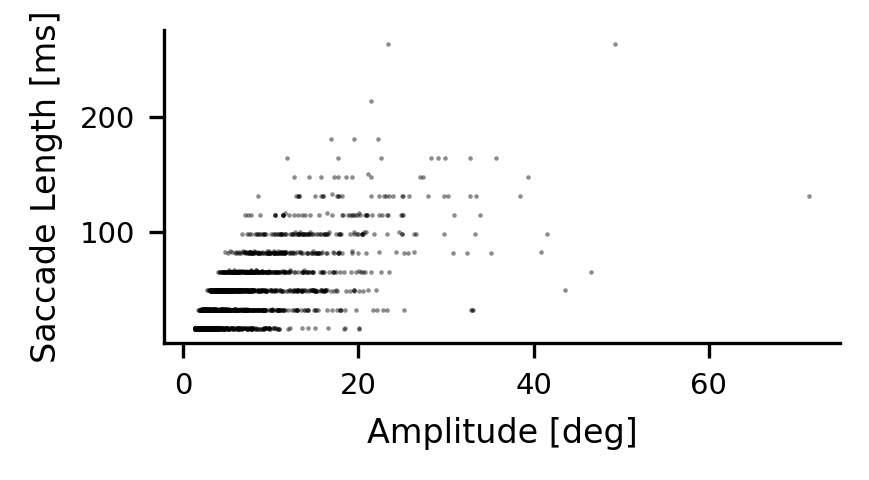

In [26]:
# mark comments:
# this could benefit from calculating the average duration per amplitude (to show the relationship without sampling rate effects (its kind of smoothing via average))

fig, ax, outdir = plot_magnitude_vs_length_scatter(
    all_saccade_collection.query('head_movement==False and animal=="PV_126"'),
    x_col="magnitude_raw_angular",
    prefer_ms_columns=("saccade_off_ms", "saccade_on_ms"),
    frame_rate_fps=60.0,
    fig_size=(3, 1.7),
    point_size=1.2,
    alpha=0.45,
    export_path=None,
    plot_name="magnitude_vs_length",
    loglog=False,
    equal_aspect=False)


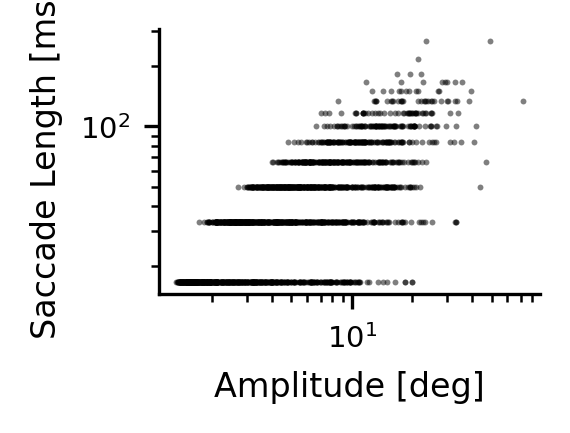

In [59]:
fig, ax, outdir = plot_magnitude_vs_length_scatter(
    all_saccade_collection.query('head_movement==False and animal=="PV_126"'),
    x_col="magnitude_raw_angular",
    prefer_ms_columns=("nonexistent1","nonexistent2"),  # forces fallback
    length_frames_col="length",
    frame_rate_fps=60.0,
    export_path=None)


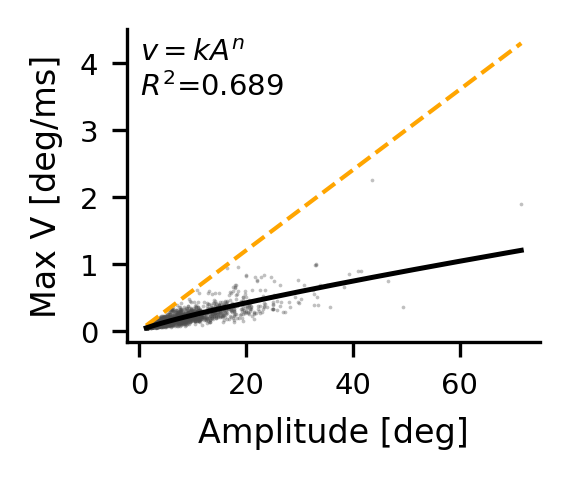

power [0.03501376 0.82808387] 0.6890110842605044


In [43]:
# === Auto-select single-plot main-sequence fit (log-log, equal aspect, with intercept support) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ---------- model definitions (with and without intercept) ----------
def _power(A, k, n):                 # v = k * A^n
    return k * np.power(A, n)

def _power_c(A, c, k, n):            # v = c + k * A^n
    return c + k * np.power(A, n)

def _sqrt(A, k):                      # v = k * sqrt(A)
    return k * np.sqrt(A)

def _sqrt_c(A, c, k):                 # v = c + k * sqrt(A)
    return c + k * np.sqrt(A)

def _exp_sat(A, Vmax, tau):           # v = Vmax * (1 - e^{-A/tau})
    return Vmax * (1.0 - np.exp(-A / tau))

def _exp_sat_c(A, c, Vmax, tau):      # v = c + Vmax * (1 - e^{-A/tau})
    return c + Vmax * (1.0 - np.exp(-A / tau))

def _michaelis(A, Vmax, K):           # v = (Vmax * A)/(A+K)
    return (Vmax * A) / (A + K)

def _michaelis_c(A, c, Vmax, K):      # v = c + (Vmax * A)/(A+K)
    return c + (Vmax * A) / (A + K)

_MODELS = {
    # name         func          n_params  latex label
    "power":       (_power,       2, r"$v=kA^n$"),
    "power_c":     (_power_c,     3, r"$v=c+kA^n$"),
    "sqrt":        (_sqrt,        1, r"$v=k\sqrt{A}$"),
    "sqrt_c":      (_sqrt_c,      2, r"$v=c+k\sqrt{A}$"),
    "exp_sat":     (_exp_sat,     2, r"$v=V_{\max}(1-e^{-A/\tau})$"),
    "exp_sat_c":   (_exp_sat_c,   3, r"$v=c+V_{\max}(1-e^{-A/\tau})$"),
    "michaelis":   (_michaelis,   2, r"$v=\dfrac{V_{\max}A}{A+K}$"),
    "michaelis_c": (_michaelis_c, 3, r"$v=c+\dfrac{V_{\max}A}{A+K}$"),
}

# ---------- helpers ----------
def _finite_pos(x):
    x = np.asarray(x)
    return np.isfinite(x) & (x > 0)

def _r2(y, yhat):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.nanmean(y))**2)
    return 1.0 - (ss_res / ss_tot if ss_tot > 0 else np.nan), ss_res

def _bic_from_sse(n, sse, p):
    # Gaussian likelihood approximation; constant terms cancel in comparison
    return n * np.log(max(sse / n, 1e-300)) + p * np.log(n)

def _initial_guesses(A, V):
    """Heuristic inits for stability across models."""
    A = np.asarray(A, float); V = np.asarray(V, float)
    Amin, Amed, Amax = np.min(A), np.median(A), np.max(A)
    Vmin, Vmed, Vmax = np.min(V), np.median(V), np.max(V)

    # power-law via log fit
    logA = np.log(A); logV = np.log(V)
    b, a = np.polyfit(logA, logV, 1)      # slope=b ~ n, intercept=a ~ ln(k)
    k0 = float(np.exp(a)); n0 = float(b)
    # baseline guess c0 as a small fraction of Vmin/Vmed
    c0 = max(0.0, 0.05 * Vmed)

    # sqrt
    denom = max(np.dot(np.sqrt(A), np.sqrt(A)), 1e-12)
    k_sqrt = float(np.dot(np.sqrt(A), V) / denom)

    # exp-sat
    Vmax0 = float(Vmax) * 1.05
    tau0 = float(Amed)

    # michaelis: K0 ~ A at ~half saturation
    try:
        idx = np.argsort(np.abs(V - 0.5 * Vmax0))[:max(5, len(A)//20)]
        A50 = float(np.median(A[idx]))
    except Exception:
        A50 = float(Amed)
    K0 = max(A50, np.percentile(A, 10))

    return dict(
        power=(k0, n0), power_c=(c0, k0, n0),
        sqrt=(k_sqrt,), sqrt_c=(c0, k_sqrt),
        exp_sat=(Vmax0, tau0), exp_sat_c=(c0, Vmax0, tau0),
        michaelis=(Vmax0, K0), michaelis_c=(c0, Vmax0, K0),
    )

def _bounds_for(name):
    # Enforce positivity, allow c >= 0
    if name == "power":        return (0.0, [np.inf, 3.0])
    if name == "power_c":      return ([0.0, 0.0, 0.0], [np.inf, np.inf, 3.0])
    if name == "sqrt":         return (0.0, np.inf)
    if name == "sqrt_c":       return ([0.0, 0.0], [np.inf, np.inf])
    if name == "exp_sat":      return ([0.0, 1e-6], [np.inf, np.inf])
    if name == "exp_sat_c":    return ([0.0, 0.0, 1e-6], [np.inf, np.inf, np.inf])
    if name == "michaelis":    return ([0.0, 1e-6], [np.inf, np.inf])
    if name == "michaelis_c":  return ([0.0, 0.0, 1e-6], [np.inf, np.inf, np.inf])
    raise ValueError("Unknown model for bounds")

def fit_and_plot_main_sequence_auto(
    df,
    x_col="magnitude_raw_angular",   # amplitude [deg]
    y_col="peak_velocity",           # peak velocity [deg/frame] unless converted
    candidate_models=("power_c","michaelis_c","exp_sat_c","sqrt_c","power","michaelis","exp_sat","sqrt"),
    convert_deg_per_frame_to_ms=True,
    frame_rate_fps=60.0,
    fig_size=(2, 1.7),
    point_size=1.0,
    point_alpha=0.35,
    show_limit_line=True,
    scatter_kwargs=None,
    line_kwargs=None,
    limit_line_kwargs=None,
    return_all_fits=False,
):
    """
    Auto-selects the best main-sequence model (by BIC), fits it (with intercept where allowed),
    and renders a single compact log–log plot with R² only.

    Returns
    -------
    fig, ax, best_fit[, all_fits]
      best_fit: dict(name, label, params, cov, R2, BIC)
    """
    data = df.copy()

    # If y_col missing, derive from 'speed_profile_angular' by max()
    if y_col not in data.columns and "speed_profile_angular" in data.columns:
        data[y_col] = data["speed_profile_angular"].apply(
            lambda p: np.nan if p is None or len(p) == 0 else np.nanmax(p)
        )

    # Convert deg/frame -> deg/ms if requested
    frame_ms = 1000.0 / float(frame_rate_fps)
    if convert_deg_per_frame_to_ms:
        data[y_col] = data[y_col] / frame_ms

    # Keep only finite positive values (log–log safe)
    mask = _finite_pos(data[x_col].values) & _finite_pos(data[y_col].values)
    data = data.loc[mask, [x_col, y_col]]
    if data.empty:
        raise ValueError("No valid (finite, positive) data after filtering.")

    A = data[x_col].values.astype(float)
    V = data[y_col].values.astype(float)
    n = V.size

    # Fit all candidates
    inits = _initial_guesses(A, V)
    fits = []
    for name in candidate_models:
        if name not in _MODELS:
            continue
        f, pcount, label = _MODELS[name]
        p0 = inits[name]
        bounds = _bounds_for(name)
        try:
            popt, pcov = curve_fit(f, A, V, p0=p0, bounds=bounds, maxfev=20000)
            Vhat = f(A, *popt)
            r2, sse = _r2(V, Vhat)
            bic = _bic_from_sse(n, sse, pcount)
            fits.append({"name": name, "label": label, "f": f,
                         "params": popt, "cov": pcov, "R2": r2, "BIC": bic})
        except Exception as e:
            # Keep a placeholder so selection is robust
            fits.append({"name": name, "label": label, "f": None,
                         "params": None, "cov": None, "R2": np.nan, "BIC": np.inf})

    # Select best by BIC
    best = min(fits, key=lambda d: d["BIC"])

    # Plot
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    skw = dict(s=point_size, c="0.3", alpha=point_alpha, linewidths=0)
    if scatter_kwargs: skw.update(scatter_kwargs)
    ax.scatter(A, V, **skw)

    #ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_xlabel("Amplitude [deg]", fontsize=8)
    ax.set_ylabel("Max V [deg/ms]", fontsize=8)
    ax.tick_params(axis='both', labelsize=7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.set_aspect("equal", adjustable="box")  # equal decades on both axes

    # Limit (min-detectable-speed) line
    if show_limit_line:
        slope = 1.0 / frame_ms
        xline = np.logspace(np.log10(np.min(A)), np.log10(np.max(A)), 200)
        yline = slope * xline
        lkw = dict(ls="--", lw=1.0, color="orange")
        if limit_line_kwargs: lkw.update(limit_line_kwargs)
        ax.plot(xline, yline, **lkw)

    # Best fit curve
    if best["f"] is not None and best["params"] is not None:
        xgrid = np.logspace(np.log10(np.min(A)), np.log10(np.max(A)), 400)
        ygrid = best["f"](xgrid, *best["params"])
        lkw = dict(lw=1.2, color="k")
        if line_kwargs: lkw.update(line_kwargs)
        ax.plot(xgrid, ygrid, **lkw)
        ax.text(0.03, 0.97, f"{best['label']}\n$R^2$={best['R2']:.3f}",
                transform=ax.transAxes, va="top", ha="left", fontsize=7)

    plt.tight_layout()
    return (fig, ax, best, fits) if return_all_fits else (fig, ax, best)
fig, ax, best = fit_and_plot_main_sequence_auto(
    all_saccade_collection.query('head_movement==False and animal=="PV_126"'),
    x_col="magnitude_raw_angular",
    y_col="peak_velocity",           # or let it derive from 'speed_profile_angular'
    candidate_models=("sqrt_c","power","michaelis","exp_sat","sqrt"),
    convert_deg_per_frame_to_ms=True,
    frame_rate_fps=60.0,
    fig_size=(2, 1.7),
    point_size=0.8
)
plt.show()
print(best["name"], best["params"], best["R2"])


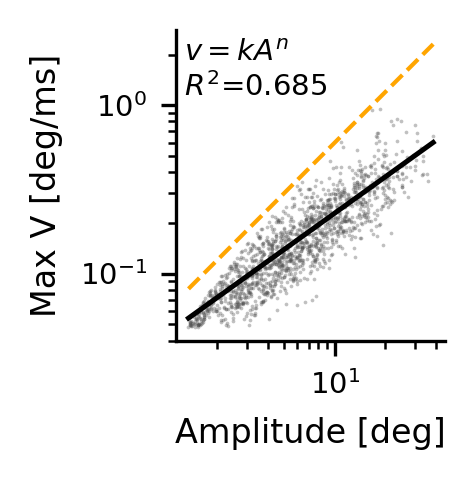

{'name': 'power', 'label': '$v=kA^n$', 'params': array([0.04374528, 0.71805788]), 'cov': array([[ 2.23761309e-06, -1.92846296e-05],
       [-1.92846296e-05,  1.77397829e-04]]), 'R2': 0.6847890607393163}


In [32]:
# === Single-plot main-sequence fit (log-log, equal aspect) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ------ models ------
def _model_power(A, k, n):        # v = k * A^n
    return k * np.power(A, n)

def _model_sqrt(A, k):            # v = k * sqrt(A)
    return k * np.sqrt(A)

def _model_exp_sat(A, Vmax, tau): # v = Vmax * (1 - exp(-A/tau))
    return Vmax * (1.0 - np.exp(-A / tau))

def _model_michaelis(A, Vmax, K): # v = (Vmax * A) / (A + K)
    return (Vmax * A) / (A + K)

_MODELS = {
    "power":     {"f": _model_power,     "p": 2, "label": r"$v=kA^n$"},
    "sqrt":      {"f": _model_sqrt,      "p": 1, "label": r"$v=k\sqrt{A}$"},
    "exp_sat":   {"f": _model_exp_sat,   "p": 2, "label": r"$v=V_{\max}(1-e^{-A/\tau})$"},
    "michaelis": {"f": _model_michaelis, "p": 2, "label": r"$v=\dfrac{V_{\max}A}{A+K}$"},
}

def _finite_pos(x):
    x = np.asarray(x)
    return np.isfinite(x) & (x > 0)

def _initial_guesses(A, V):
    """Heuristic initial guesses for stable fits."""
    A = np.asarray(A, float)
    V = np.asarray(V, float)

    # Power-law init via linear regression in log-space
    logA = np.log(A)
    logV = np.log(V)
    b, a = np.polyfit(logA, logV, 1)  # slope=b ~ n, intercept=a ~ ln(k)
    k0 = np.exp(a)
    n0 = float(b)

    # sqrt: least squares for k
    k_sqrt = np.dot(np.sqrt(A), V) / max(np.dot(np.sqrt(A), np.sqrt(A)), 1e-12)

    Vmax0 = float(np.nanmax(V)) * 1.05
    tau0 = float(np.median(A))
    # Michaelis K0 ~ half-saturation A
    try:
        A50 = np.median(A[np.argsort(np.abs(V - 0.5 * Vmax0))[:max(5, len(A)//20)]])
    except Exception:
        A50 = np.median(A)
    K0 = max(float(A50), np.percentile(A, 10))

    return (k0, n0), (k_sqrt,), (Vmax0, tau0), (Vmax0, K0)

def _bounds_for(model):
    if model == "power":      return (0, [np.inf, 3.0])      # positive k, n<=3 for stability
    if model == "sqrt":       return (0, np.inf)             # k>0
    if model == "exp_sat":    return ([0, 1e-6], [np.inf, np.inf])  # Vmax>0, tau>0
    if model == "michaelis":  return ([0, 1e-6], [np.inf, np.inf])  # Vmax>0, K>0
    raise ValueError("Unknown model for bounds")

def _r2(y, yhat):
    y = np.asarray(y)
    yhat = np.asarray(yhat)
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.nanmean(y))**2)
    return 1.0 - (ss_res / ss_tot if ss_tot > 0 else np.nan)

def fit_and_plot_main_sequence_single(
    df,
    x_col="magnitude_raw_angular",   # amplitude [deg]
    y_col="peak_velocity",           # peak velocity [deg/frame] unless converted
    model="power",                   # {"power","sqrt","exp_sat","michaelis"}
    convert_deg_per_frame_to_ms=True,
    frame_rate_fps=60.0,
    fig_size=(2, 1.7),
    point_size=1.0,
    point_alpha=0.35,
    show_limit_line=True,
    limit_line_kwargs=None,
    scatter_kwargs=None,
    line_kwargs=None,
):
    """
    Single log-log plot with chosen main-sequence model and R² only.
    Enforces equal aspect on log axes and (optionally) draws the theoretical
    minimum-detectable-speed line with slope = 1/frame_ms.

    Returns
    -------
    fig, ax, fit_result : (Figure, Axes, dict)
        fit_result contains: {"name","label","params","cov","R2"}
    """
    if model not in _MODELS:
        raise ValueError(f"Unknown model '{model}'. Choose from {list(_MODELS.keys())}.")

    data = df.copy()

    # If y_col missing, derive from 'speed_profile_angular' by max()
    if y_col not in data.columns and "speed_profile_angular" in data.columns:
        data[y_col] = data["speed_profile_angular"].apply(
            lambda p: np.nan if p is None or len(p) == 0 else np.nanmax(p)
        )

    # Unit conversion (deg/frame -> deg/ms)
    frame_ms = 1000.0 / float(frame_rate_fps)
    if convert_deg_per_frame_to_ms:
        data[y_col] = data[y_col] / frame_ms

    # Keep only finite positive values
    mask = _finite_pos(data[x_col].values) & _finite_pos(data[y_col].values)
    data = data.loc[mask, [x_col, y_col]]
    if data.empty:
        raise ValueError("No valid (finite, positive) data after filtering.")

    A = data[x_col].values.astype(float)
    V = data[y_col].values.astype(float)

    # Initial guesses and bounds
    p0s = _initial_guesses(A, V)
    if model == "power":
        p0 = p0s[0]
    elif model == "sqrt":
        p0 = p0s[1]
    elif model == "exp_sat":
        p0 = p0s[2]
    elif model == "michaelis":
        p0 = p0s[3]
    bounds = _bounds_for(model)

    # Fit
    f = _MODELS[model]["f"]
    try:
        popt, pcov = curve_fit(f, A, V, p0=p0, bounds=bounds, maxfev=10000)
        Vhat = f(A, *popt)
        r2 = _r2(V, Vhat)
    except Exception as e:
        popt, pcov, r2 = None, None, np.nan
        print(f"[WARN] Fit failed for '{model}': {e}")

    # Prepare plot
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    skw = dict(s=point_size, c="0.3", alpha=point_alpha, linewidths=0)
    if scatter_kwargs: skw.update(scatter_kwargs)
    ax.scatter(A, V, **skw)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Amplitude [deg]", fontsize=8)
    ax.set_ylabel("Max V [deg/ms]", fontsize=8)
    ax.tick_params(axis='both', labelsize=7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Equal aspect on log axes (same number of decades per axis unit)
    ax.set_aspect("equal", adjustable="box")

    # Theoretical detection limit
    if show_limit_line:
        slope = 1.0 / frame_ms
        xline = np.logspace(np.log10(np.min(A)), np.log10(np.max(A)), 200)
        yline = slope * xline
        lkw = dict(ls="--", lw=1.0, color="orange")
        if limit_line_kwargs: lkw.update(limit_line_kwargs)
        ax.plot(xline, yline, **lkw)

    # Fit curve
    if popt is not None:
        xgrid = np.logspace(np.log10(np.min(A)), np.log10(np.max(A)), 400)
        ygrid = f(xgrid, *popt)
        lkw = dict(lw=1.2, color="k")
        if line_kwargs: lkw.update(line_kwargs)
        ax.plot(xgrid, ygrid, **lkw)

        # Only R² in the corner
        ax.text(0.03, 0.97, f"{_MODELS[model]['label']}\n$R^2$={r2:.3f}",
                transform=ax.transAxes, va="top", ha="left", fontsize=7)

    plt.tight_layout()
    fit_result = {
        "name": model,
        "label": _MODELS[model]["label"],
        "params": popt,
        "cov": pcov,
        "R2": r2,
    }
    return fig, ax, fit_result

fig, ax, fit = fit_and_plot_main_sequence_single(
    synced_saccade_collection.query('head_movement==False and animal=="PV_126"'),
    x_col="magnitude_raw_angular",
    y_col="peak_velocity",          # or let it derive from 'speed_profile_angular'
    model="power",              # {"power","sqrt","exp_sat","michaelis"}
    convert_deg_per_frame_to_ms=True,
    frame_rate_fps=60.0,
    fig_size=(2, 1.7),
    point_size=0.8
)
plt.show()
print(fit)


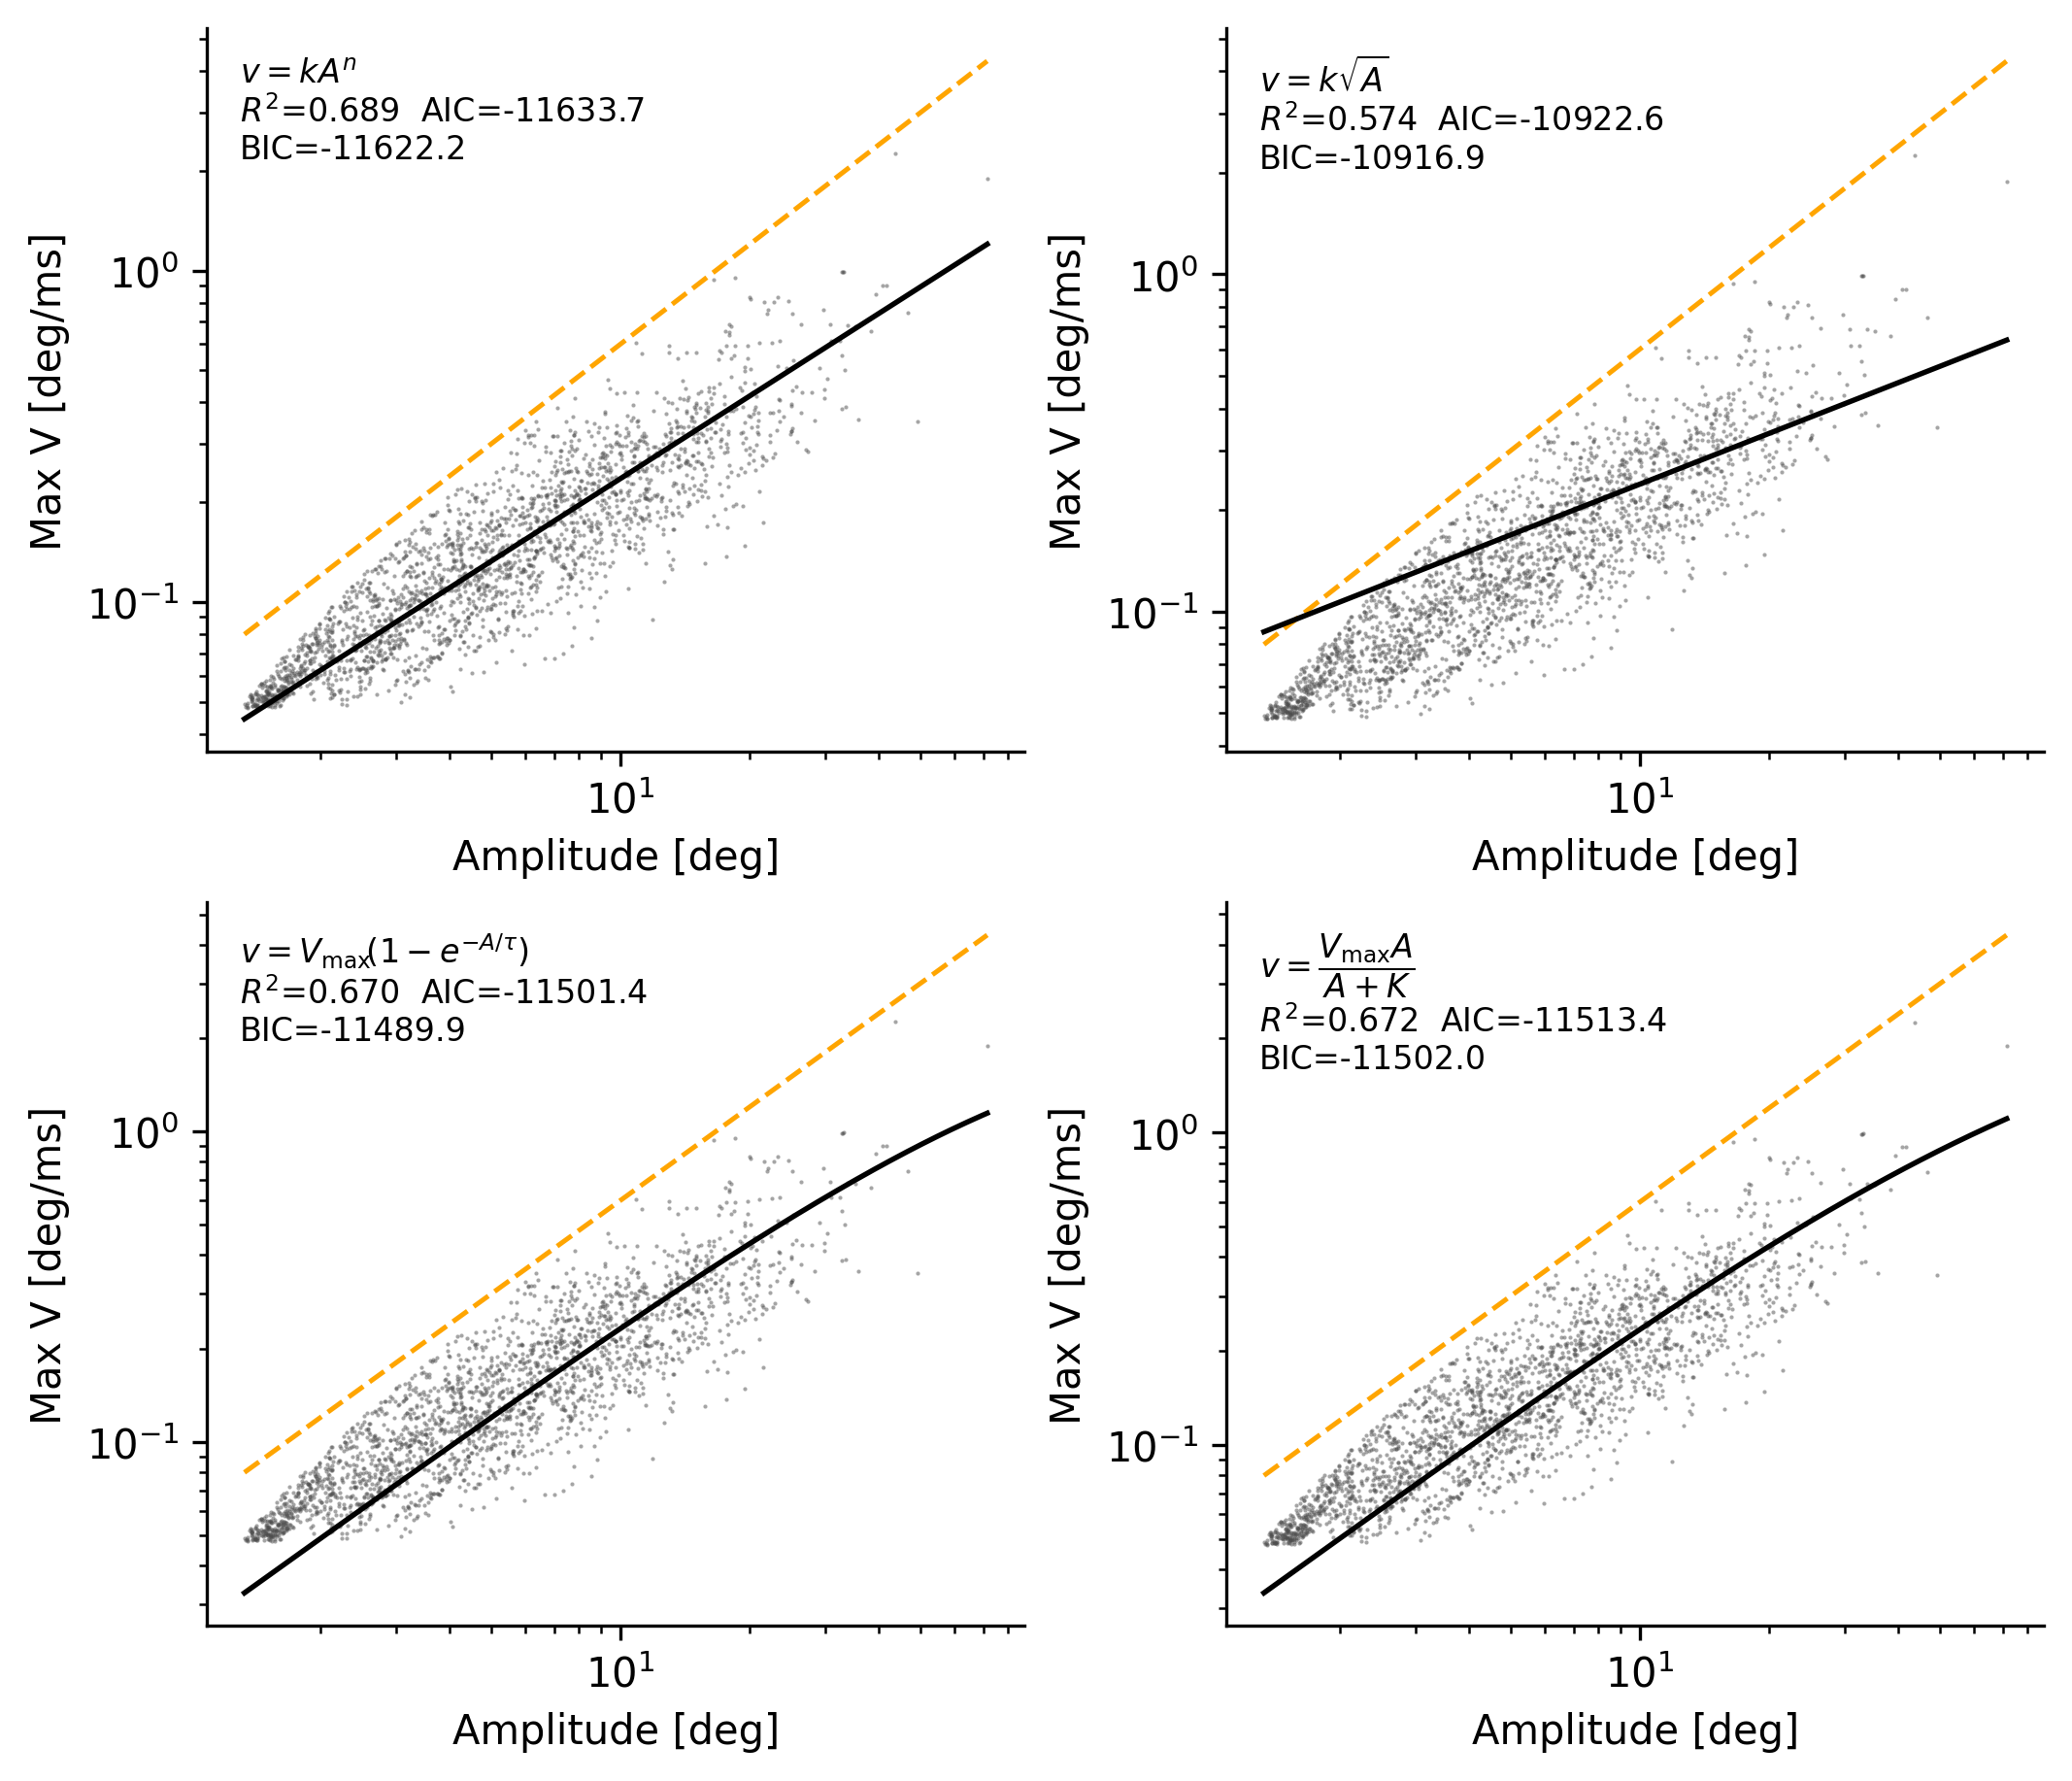

[{'name': 'power',
  'f': <function __main__.model_power(A, k, n)>,
  'params': array([0.03501376, 0.82808387]),
  'cov': array([[ 1.10952572e-06, -1.13533325e-05],
         [-1.13533325e-05,  1.24826895e-04]]),
  'label': '$v=kA^n$',
  'metrics': {'R2': 0.6890110842605044,
   'adjR2': 0.688736722623328,
   'AIC': -11633.658018381439,
   'BIC': -11622.202948160488,
   'SSE': 13.474695464126004}},
 {'name': 'sqrt',
  'f': <function __main__.model_sqrt(A, k)>,
  'params': array([0.07547884]),
  'cov': array([[5.16188869e-07]]),
  'label': '$v=k\\sqrt{A}$',
  'metrics': {'R2': 0.5742425897654684,
   'adjR2': 0.5740548660396154,
   'AIC': -10922.622748511316,
   'BIC': -10916.89521340084,
   'SSE': 18.447446690707523}},
 {'name': 'exp_sat',
  'f': <function __main__.model_exp_sat(A, Vmax, tau)>,
  'params': array([ 1.87111186, 75.49759495]),
  'cov': array([[4.00544957e-02, 1.80661983e+00],
         [1.80661983e+00, 8.19664039e+01]]),
  'label': '$v=V_{\\max}\\!\\left(1-e^{-A/\\tau}\\right

In [18]:
# ==== Main-sequence model comparison (peak velocity vs amplitude) ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ---------- models ----------
def model_power(A, k, n):
    # v = k * A^n
    return k * np.power(A, n)

def model_sqrt(A, k):
    # v = k * sqrt(A)   (power-law with exponent fixed to 1/2)
    return k * np.sqrt(A)

def model_exp_sat(A, Vmax, tau):
    # v = Vmax * (1 - exp(-A/tau))
    return Vmax * (1.0 - np.exp(-A / tau))

def model_michaelis(A, Vmax, K):
    # v = (Vmax * A) / (A + K)
    return (Vmax * A) / (A + K)

# ---------- helpers ----------
def _finite_positive(x):
    x = np.asarray(x)
    return np.isfinite(x) & (x > 0)

def _r2_metrics(y, yhat, p):
    """
    Returns dict with R2, adjR2, AIC, BIC
    p = number of fitted parameters
    """
    y = np.asarray(y)
    yhat = np.asarray(yhat)
    n = y.size
    ss_res = np.sum((y - yhat) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    r2 = 1.0 - (ss_res / ss_tot if ss_tot > 0 else np.nan)
    adj = 1.0 - (1.0 - r2) * (n - 1) / max(n - p - 1, 1)
    # Gaussian likelihood -> AIC/BIC from SSE
    # Ignore constant terms since used comparatively across models
    aic = n * np.log(ss_res / n + 1e-300) + 2 * p
    bic = n * np.log(ss_res / n + 1e-300) + p * np.log(n)
    return dict(R2=r2, adjR2=adj, AIC=aic, BIC=bic, SSE=ss_res)

def _initial_guesses(A, V):
    """Heuristic initial guesses for each model."""
    A, V = np.asarray(A), np.asarray(V)
    # power-law init via linear regression in log space
    logA = np.log(A)
    logV = np.log(V)
    n0 = np.polyfit(logA, logV, 1)[0]
    k0 = np.exp(np.polyfit(logA, logV, 1)[1])

    # sqrt is special case; just estimate k from least squares
    k_sqrt = np.dot(np.sqrt(A), V) / np.dot(np.sqrt(A), np.sqrt(A))

    Vmax0 = np.nanmax(V) * 1.05
    tau0 = np.median(A)
    # Michaelis: K at half-saturation approx
    # Estimate A_50 by median of A where V ~ 0.5*Vmax0, fall back to median(A)
    try:
        A50 = np.median(A[np.argsort(np.abs(V - 0.5 * Vmax0))[:max(5, len(A)//20)]])
    except Exception:
        A50 = np.median(A)
    K0 = max(A50, np.percentile(A, 10))

    return (k0, n0), (k_sqrt,), (Vmax0, tau0), (Vmax0, K0)

def _fit_one(model_name, A, V):
    """Fit a single model and return params, metrics, callable, label."""
    A = np.asarray(A, float)
    V = np.asarray(V, float)

    bounds = None
    if model_name == "power":
        f = model_power
        p0 = _initial_guesses(A, V)[0]
        # enforce positive params
        bounds = (0, [np.inf, 3.0])
        label = r"$v=kA^n$"
    elif model_name == "sqrt":
        f = model_sqrt
        p0 = _initial_guesses(A, V)[1]
        bounds = (0, np.inf)
        label = r"$v=k\sqrt{A}$"
    elif model_name == "exp_sat":
        f = model_exp_sat
        p0 = _initial_guesses(A, V)[2]
        bounds = ([0, 1e-6], [np.inf, np.inf])
        label = r"$v=V_{\max}\!\left(1-e^{-A/\tau}\right)$"
    elif model_name == "michaelis":
        f = model_michaelis
        p0 = _initial_guesses(A, V)[3]
        bounds = ([0, 1e-6], [np.inf, np.inf])
        label = r"$v=\dfrac{V_{\max}A}{A+K}$"
    else:
        raise ValueError("Unknown model name")

    try:
        popt, pcov = curve_fit(f, A, V, p0=p0, bounds=bounds, maxfev=10000)
        Vhat = f(A, *popt)
        p = len(popt)
        metrics = _r2_metrics(V, Vhat, p)
        return dict(name=model_name, f=f, params=popt, cov=pcov, label=label, metrics=metrics)
    except Exception as e:
        return dict(name=model_name, f=None, params=None, cov=None,
                    label=label + " (fit failed)", metrics=dict(R2=np.nan, adjR2=np.nan, AIC=np.nan, BIC=np.nan, SSE=np.nan), error=str(e))

def compare_main_sequence_models(
    df,
    x_col="magnitude_raw_angular",
    y_col="peak_velocity",
    convert_deg_per_frame_to_ms=True,
    frame_rate_fps=60.0,
    per_animal=False,
    animal_col="animal",
    fig_size=(7, 6),
    point_size=3,
):
    """
    Compare multiple main-sequence models, optionally per-animal.
    Adds theoretical minimum-detectable-speed line: v = A / frame_duration.
    """
    data = df.copy()

    # compute peak velocity if needed
    if y_col not in data.columns and "speed_profile_angular" in data.columns:
        data[y_col] = data["speed_profile_angular"].apply(
            lambda p: np.nan if p is None or len(p) == 0 else np.nanmax(p)
        )

    # unit conversion
    if convert_deg_per_frame_to_ms:
        frame_ms = 1000.0 / float(frame_rate_fps)
        data[y_col] = data[y_col] / frame_ms
    else:
        frame_ms = 1000.0 / float(frame_rate_fps)  # still needed for slope line

    # keep finite positive
    mask = np.isfinite(data[x_col]) & (data[x_col] > 0) & np.isfinite(data[y_col]) & (data[y_col] > 0)
    data = data.loc[mask, [x_col, y_col] + ([animal_col] if animal_col in data.columns else [])].copy()
    A = data[x_col].values
    V = data[y_col].values

    def _plot_set(ax):
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("Amplitude [deg]")
        ax.set_ylabel("Max V [deg/ms]")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # --- add theoretical detection limit line ---
        slope = 1.0 / frame_ms
        x_line = np.logspace(np.log10(A.min()), np.log10(A.max()), 200)
        y_line = slope * x_line
        ax.plot(x_line, y_line, linestyle='--', color='orange', lw=1.2, label='Min Detectable Speed')

    model_list = ["power", "sqrt", "exp_sat", "michaelis"]

    if not per_animal:
        fits = [_fit_one(mn, A, V) for mn in model_list]

        # plot
        n = len(fits)
        ncols = 2
        nrows = int(np.ceil(n / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=fig_size, dpi=300, constrained_layout=True)
        axes = np.atleast_1d(axes).ravel()

        for ax, fit in zip(axes, fits):
            ax.scatter(A, V, s=point_size, c='0.3', alpha=0.5, linewidths=0)
            _plot_set(ax)

            if fit["f"] is not None:
                xgrid = np.logspace(np.log10(A.min()), np.log10(A.max()), 400)
                ygrid = fit["f"](xgrid, *fit["params"])
                ax.plot(xgrid, ygrid, 'k-', lw=1.3)

            mt = fit["metrics"]
            txt = f"{fit['label']}\n" \
                  f"$R^2$={mt['R2']:.3f}  AIC={mt['AIC']:.1f}\n" \
                  f"BIC={mt['BIC']:.1f}"
            ax.text(0.04, 0.96, txt, transform=ax.transAxes, va='top', ha='left', fontsize=8)

        for j in range(len(fits), len(axes)):
            axes[j].axis('off')

        plt.show()
        return fits

    else:
        # per-animal option (similar structure, with slope line too)
        if animal_col not in data.columns:
            raise ValueError(f"per_animal=True requires '{animal_col}' column.")
        animals = sorted(data[animal_col].unique())
        n = len(animals)
        ncols = 3
        nrows = int(np.ceil(n / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3.0, nrows*2.7), dpi=300, constrained_layout=True)
        axes = np.atleast_1d(axes).ravel()

        results = {}
        for ax, animal in zip(axes, animals):
            sub = data[data[animal_col] == animal]
            A_sub, V_sub = sub[x_col].values, sub[y_col].values
            fits = [_fit_one(mn, A_sub, V_sub) for mn in model_list]
            best = min(fits, key=lambda d: (np.inf if np.isnan(d["metrics"]["BIC"]) else d["metrics"]["BIC"]))
            results[animal] = {f['name']: f for f in fits}

            ax.scatter(A_sub, V_sub, s=point_size, c='0.3', alpha=0.5, linewidths=0)
            _plot_set(ax)
            if best["f"] is not None:
                xgrid = np.logspace(np.log10(A_sub.min()), np.log10(A_sub.max()), 300)
                ygrid = best["f"](xgrid, *best["params"])
                ax.plot(xgrid, ygrid, 'k-', lw=1.3)

            mt = best["metrics"]
            ax.set_title(f"{animal}: {best['label']}\n"
                         f"$R^2$={mt['R2']:.3f}  BIC={mt['BIC']:.1f}", fontsize=8)

        for j in range(len(animals), len(axes)):
            axes[j].axis('off')

        plt.show()
        return results
compare_main_sequence_models(
    all_saccade_collection.query('head_movement==False and animal=="PV_126"'),
    x_col="magnitude_raw_angular",
    y_col="peak_velocity",
    convert_deg_per_frame_to_ms=True,
    frame_rate_fps=60.0,
    per_animal=False,
    animal_col="animal",
    fig_size=(7, 6),
    point_size=1,
)

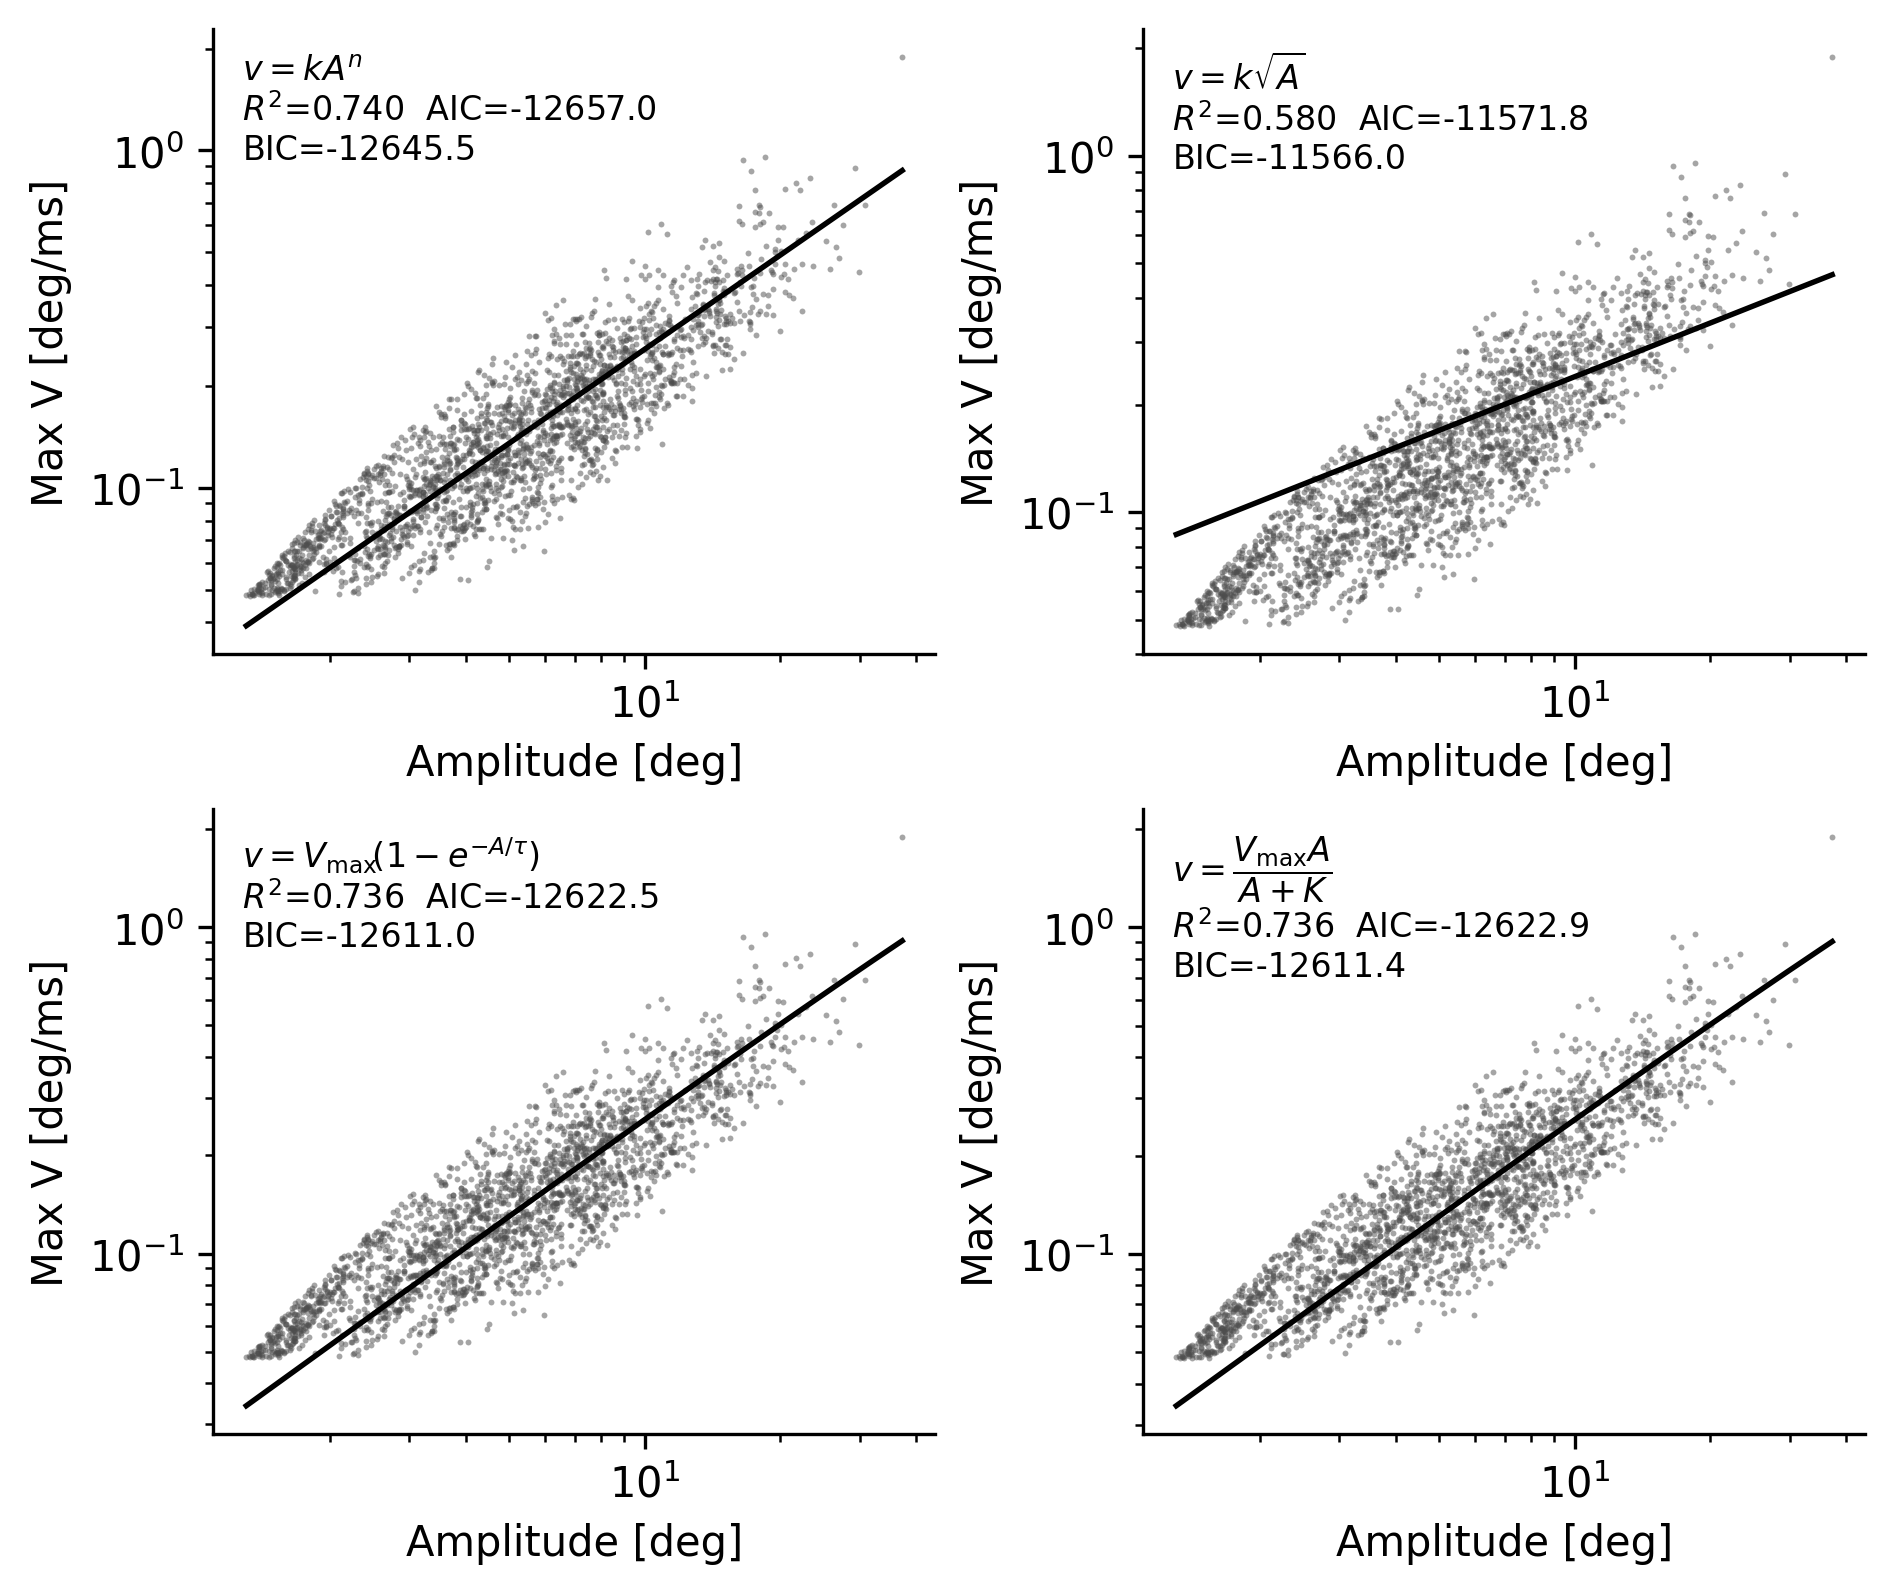

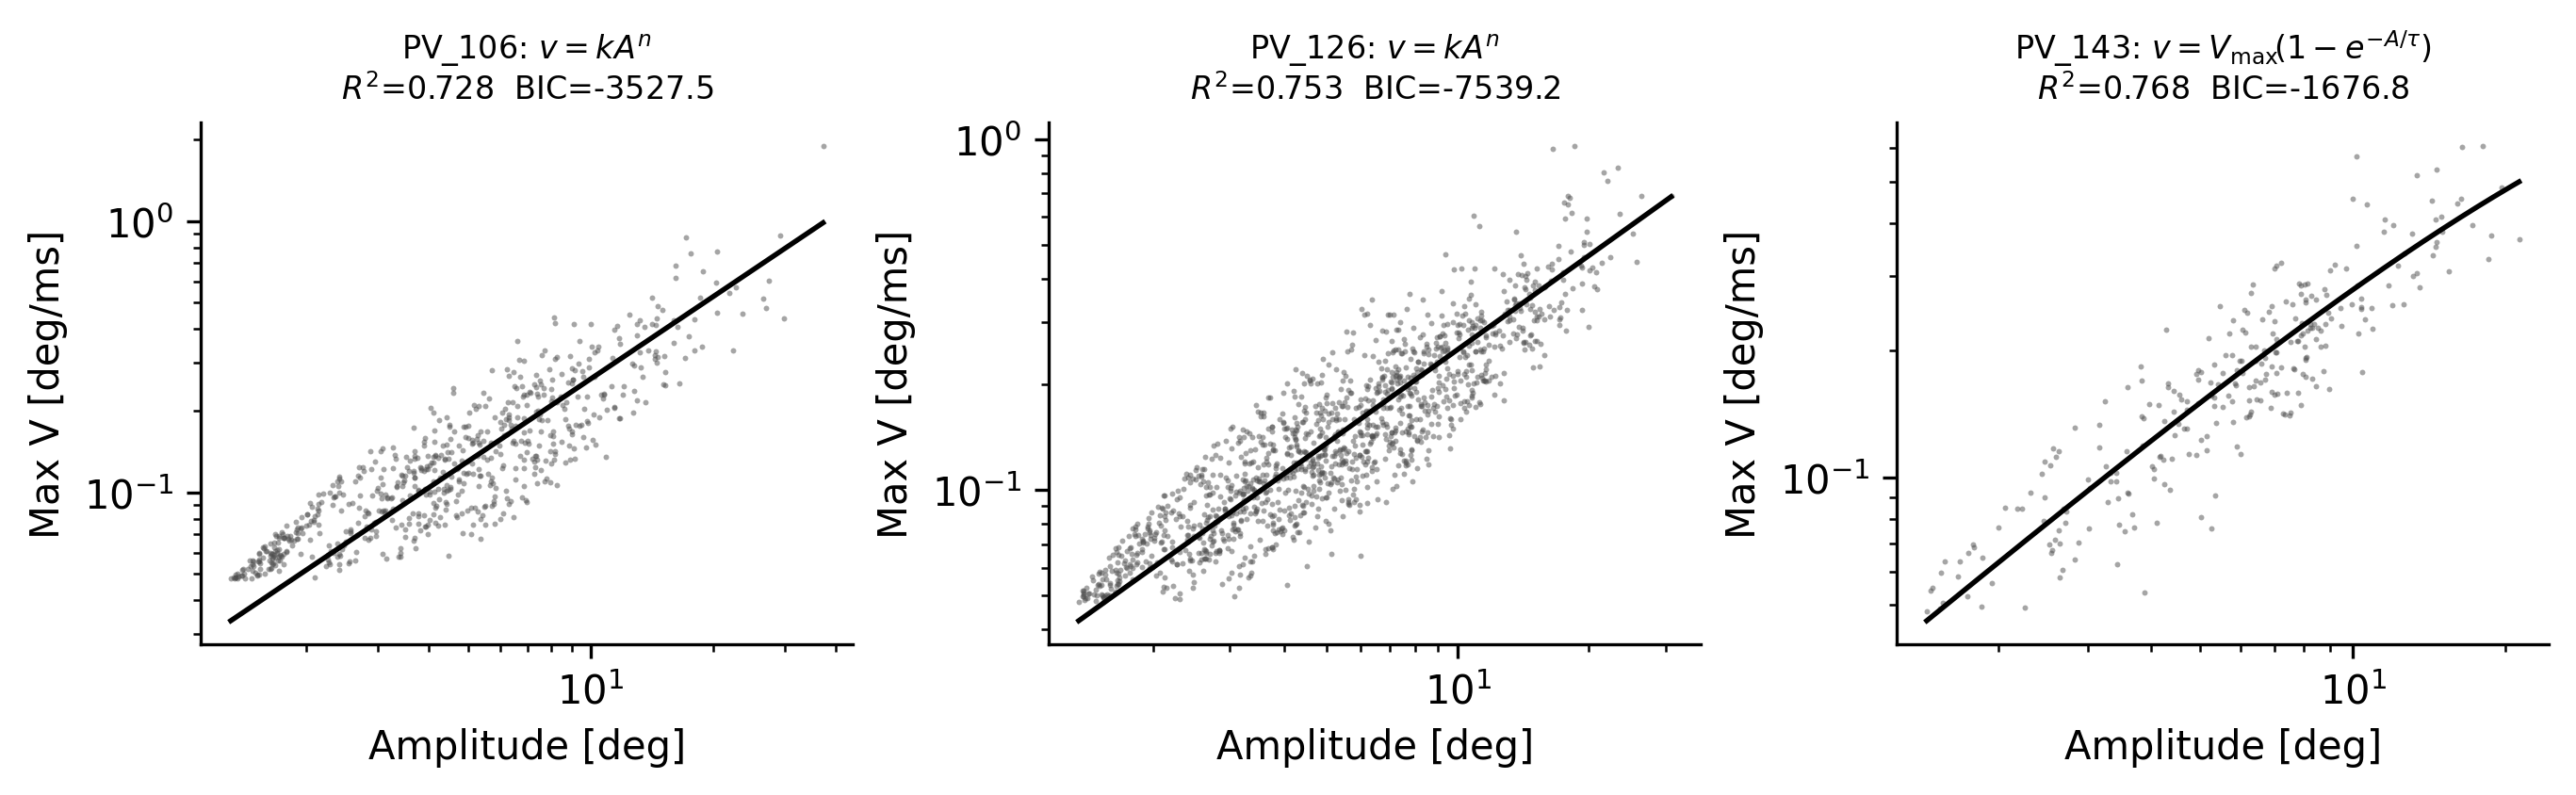

In [31]:
# ==== Main-sequence model comparison (peak velocity vs amplitude) ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ---------- models ----------
def model_power(A, k, n):
    # v = k * A^n
    return k * np.power(A, n)

def model_sqrt(A, k):
    # v = k * sqrt(A)   (power-law with exponent fixed to 1/2)
    return k * np.sqrt(A)

def model_exp_sat(A, Vmax, tau):
    # v = Vmax * (1 - exp(-A/tau))
    return Vmax * (1.0 - np.exp(-A / tau))

def model_michaelis(A, Vmax, K):
    # v = (Vmax * A) / (A + K)
    return (Vmax * A) / (A + K)

# ---------- helpers ----------
def _finite_positive(x):
    x = np.asarray(x)
    return np.isfinite(x) & (x > 0)

def _r2_metrics(y, yhat, p):
    """
    Returns dict with R2, adjR2, AIC, BIC
    p = number of fitted parameters
    """
    y = np.asarray(y)
    yhat = np.asarray(yhat)
    n = y.size
    ss_res = np.sum((y - yhat) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    r2 = 1.0 - (ss_res / ss_tot if ss_tot > 0 else np.nan)
    adj = 1.0 - (1.0 - r2) * (n - 1) / max(n - p - 1, 1)
    # Gaussian likelihood -> AIC/BIC from SSE
    # Ignore constant terms since used comparatively across models
    aic = n * np.log(ss_res / n + 1e-300) + 2 * p
    bic = n * np.log(ss_res / n + 1e-300) + p * np.log(n)
    return dict(R2=r2, adjR2=adj, AIC=aic, BIC=bic, SSE=ss_res)

def _initial_guesses(A, V):
    """Heuristic initial guesses for each model."""
    A, V = np.asarray(A), np.asarray(V)
    # power-law init via linear regression in log space
    logA = np.log(A)
    logV = np.log(V)
    n0 = np.polyfit(logA, logV, 1)[0]
    k0 = np.exp(np.polyfit(logA, logV, 1)[1])

    # sqrt is special case; just estimate k from least squares
    k_sqrt = np.dot(np.sqrt(A), V) / np.dot(np.sqrt(A), np.sqrt(A))

    Vmax0 = np.nanmax(V) * 1.05
    tau0 = np.median(A)
    # Michaelis: K at half-saturation approx
    # Estimate A_50 by median of A where V ~ 0.5*Vmax0, fall back to median(A)
    try:
        A50 = np.median(A[np.argsort(np.abs(V - 0.5 * Vmax0))[:max(5, len(A)//20)]])
    except Exception:
        A50 = np.median(A)
    K0 = max(A50, np.percentile(A, 10))

    return (k0, n0), (k_sqrt,), (Vmax0, tau0), (Vmax0, K0)

def _fit_one(model_name, A, V):
    """Fit a single model and return params, metrics, callable, label."""
    A = np.asarray(A, float)
    V = np.asarray(V, float)

    bounds = None
    if model_name == "power":
        f = model_power
        p0 = _initial_guesses(A, V)[0]
        # enforce positive params
        bounds = (0, [np.inf, 3.0])
        label = r"$v=kA^n$"
    elif model_name == "sqrt":
        f = model_sqrt
        p0 = _initial_guesses(A, V)[1]
        bounds = (0, np.inf)
        label = r"$v=k\sqrt{A}$"
    elif model_name == "exp_sat":
        f = model_exp_sat
        p0 = _initial_guesses(A, V)[2]
        bounds = ([0, 1e-6], [np.inf, np.inf])
        label = r"$v=V_{\max}\!\left(1-e^{-A/\tau}\right)$"
    elif model_name == "michaelis":
        f = model_michaelis
        p0 = _initial_guesses(A, V)[3]
        bounds = ([0, 1e-6], [np.inf, np.inf])
        label = r"$v=\dfrac{V_{\max}A}{A+K}$"
    else:
        raise ValueError("Unknown model name")

    try:
        popt, pcov = curve_fit(f, A, V, p0=p0, bounds=bounds, maxfev=10000)
        Vhat = f(A, *popt)
        p = len(popt)
        metrics = _r2_metrics(V, Vhat, p)
        return dict(name=model_name, f=f, params=popt, cov=pcov, label=label, metrics=metrics)
    except Exception as e:
        return dict(name=model_name, f=None, params=None, cov=None,
                    label=label + " (fit failed)", metrics=dict(R2=np.nan, adjR2=np.nan, AIC=np.nan, BIC=np.nan, SSE=np.nan), error=str(e))

def compare_main_sequence_models(
    df,
    x_col="magnitude_raw_angular",
    y_col="peak_velocity",
    convert_deg_per_frame_to_ms=True,
    frame_rate_fps=60.0,
    per_animal=False,
    animal_col="animal",
    fig_size=(7, 6),
    point_size=3,
):
    """
    df: DataFrame containing columns:
         - x_col: amplitude in deg
         - y_col or 'speed_profile_angular' -> peak velocity; if y_col missing,
           compute from 'speed_profile_angular'
         - optional animal_col for per-animal fits
    """
    data = df.copy()

    # compute peak velocity if needed
    if y_col not in data.columns and "speed_profile_angular" in data.columns:
        data[y_col] = data["speed_profile_angular"].apply(lambda p: np.nan if p is None or len(p)==0 else np.nanmax(p))

    # unit conversion
    if convert_deg_per_frame_to_ms:
        frame_ms = 1000.0 / float(frame_rate_fps)
        data[y_col] = data[y_col] / frame_ms

    # keep finite positive
    m = _finite_positive(data[x_col]) & _finite_positive(data[y_col])
    data = data.loc[m, [x_col, y_col] + ([animal_col] if animal_col in data.columns else [])].copy()
    A = data[x_col].values
    V = data[y_col].values

    def _plot_set(ax):
        ax.set_xscale("log"); ax.set_yscale("log")
        ax.set_xlabel("Amplitude [deg]")
        ax.set_ylabel("Max V [deg/ms]")
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)

    model_list = ["power", "sqrt", "exp_sat", "michaelis"]

    if not per_animal:
        fits = [ _fit_one(mn, A, V) for mn in model_list ]

        # plot
        n = len(fits)
        ncols = 2
        nrows = int(np.ceil(n / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=fig_size, dpi=300, constrained_layout=True)
        axes = np.atleast_1d(axes).ravel()

        for ax, fit in zip(axes, fits):
            ax.scatter(A, V, s=point_size, c='0.3', alpha=0.5, linewidths=0)
            _plot_set(ax)

            if fit["f"] is not None:
                xgrid = np.logspace(np.log10(A.min()), np.log10(A.max()), 400)
                ygrid = fit["f"](xgrid, *fit["params"])
                ax.plot(xgrid, ygrid, 'k-', lw=1.3)

            mt = fit["metrics"]
            txt = f"{fit['label']}\n" \
                  f"$R^2$={mt['R2']:.3f}  AIC={mt['AIC']:.1f}\n" \
                  f"BIC={mt['BIC']:.1f}"
            ax.text(0.04, 0.96, txt, transform=ax.transAxes, va='top', ha='left', fontsize=8)
        # hide any leftover axes
        for j in range(len(fits), len(axes)):
            axes[j].axis('off')

        plt.show()
        return fits

    else:
        # per-animal grid; each panel shows the best model by BIC
        if animal_col not in data.columns:
            raise ValueError(f"per_animal=True requires '{animal_col}' column.")
        animals = sorted(data[animal_col].unique())
        n = len(animals)
        ncols = 3
        nrows = int(np.ceil(n / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3.0, nrows*2.7), dpi=300, constrained_layout=True)
        axes = np.atleast_1d(axes).ravel()

        results = {}
        for ax, animal in zip(axes, animals):
            sub = data[data[animal_col] == animal]
            A_sub, V_sub = sub[x_col].values, sub[y_col].values
            fits = [ _fit_one(mn, A_sub, V_sub) for mn in model_list ]
            # choose best by BIC (lower is better)
            best = min(fits, key=lambda d: (np.inf if np.isnan(d["metrics"]["BIC"]) else d["metrics"]["BIC"]))
            results[animal] = {f['name']: f for f in fits}

            ax.scatter(A_sub, V_sub, s=point_size, c='0.3', alpha=0.5, linewidths=0)
            _plot_set(ax)
            if best["f"] is not None:
                xgrid = np.logspace(np.log10(A_sub.min()), np.log10(A_sub.max()), 300)
                ygrid = best["f"](xgrid, *best["params"])
                ax.plot(xgrid, ygrid, 'k-', lw=1.3)

            mt = best["metrics"]
            ax.set_title(f"{animal}: {best['label']}\n"
                         f"$R^2$={mt['R2']:.3f}  BIC={mt['BIC']:.1f}", fontsize=8)

        # clean empty axes
        for j in range(len(animals), len(axes)):
            axes[j].axis('off')

        plt.show()
        return results

# ----------------- Example calls -----------------
# (1) All animals pooled, four models compared in subplots:
fits = compare_main_sequence_models(
    synced_saccade_collection.query('length < 6 and animal!="PV_62" and head_movement==False'),
    x_col='magnitude_raw_angular',
    y_col='peak_velocity',     # if absent, will be computed from speed_profile_angular
    convert_deg_per_frame_to_ms=True,
    frame_rate_fps=60,
    per_animal=False,
    fig_size=(6.2, 5.2),
    point_size=2,
)

# (2) Per-animal figure choosing the best model (by BIC) for each animal:
per_animal_results = compare_main_sequence_models(
    synced_saccade_collection.query('length < 6 and animal!="PV_62" and head_movement==False'),
    x_col='magnitude_raw_angular',
    y_col='peak_velocity',
    convert_deg_per_frame_to_ms=True,
    frame_rate_fps=60,
    per_animal=True,
    animal_col='animal',
    fig_size=(9.0, 6.5),
    point_size=2,
)


Saccades in plot: 849
Fit (fixed exponent = 0.5):  v = 0.07899 · A^0.5
R² = 0.603


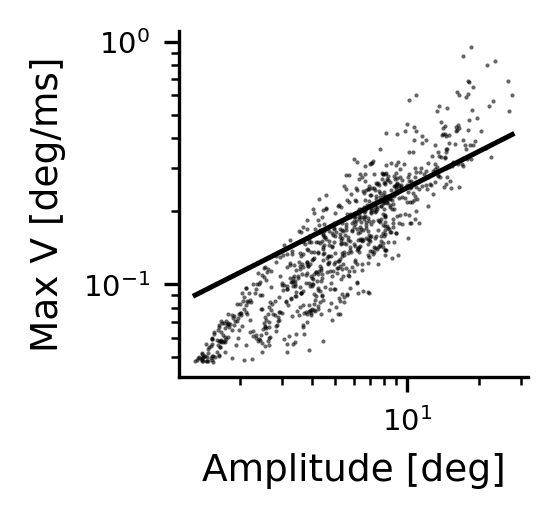

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime, os, pickle

def plot_saccade_magnitude_vs_velocity_length_angular_multiple_animals(
    synced_saccade_collection,
    monocular_saccade_collection=None,   # kept for API compatibility, unused
    export_path=None,
    fig_size=(1.5, 1.5),
    velocity_to_deg_per_ms=True,
    frame_rate_fps=60,
    equal_sample=True,
    random_state=42,
    exponent=0.5,                        # fixed exponent for the power-law fit (default √)
):
    """
    Black/white log–log scatter of angular amplitude (deg) vs peak angular velocity (deg/ms),
    with a single constrained power-law fit: v = k * A**exponent (default exponent=0.5).
    Each animal contributes an equal number of samples (if equal_sample=True).

    Expects columns in `synced_saccade_collection`:
        - 'animal'
        - 'magnitude_raw_angular' (deg)
        - 'speed_profile_angular' (list/array of deg/frame)
    """

    df = synced_saccade_collection.copy()

    # --- compute metrics ---
    if 'animal' not in df.columns:
        raise ValueError("Input dataframe must contain an 'animal' column.")
    df['magnitude'] = df['magnitude_raw_angular']
    # peak angular speed (deg/frame)
    df['peak_velocity'] = df['speed_profile_angular'].apply(lambda p: np.nan if p is None or len(p)==0 else np.nanmax(p))

    # convert to deg/ms if requested
    if velocity_to_deg_per_ms:
        frame_duration_ms = 1000.0 / float(frame_rate_fps)   # ms per frame
        df['peak_velocity'] = df['peak_velocity'] / frame_duration_ms

    # keep only finite, strictly positive values (needed for log–log and √ fit)
    df = df[np.isfinite(df['magnitude']) & np.isfinite(df['peak_velocity'])]
    df = df[(df['magnitude'] > 0) & (df['peak_velocity'] > 0)]

    # equalize sample count per animal (optional)
    if equal_sample:
        g = df.groupby('animal')
        n_min = g.size().min()
        df = g.apply(lambda x: x.sample(n=n_min, random_state=random_state)).reset_index(drop=True)

    # --- constrained power-law fit with fixed exponent ---
    # v = k * A**exponent  => linear least squares for k with design vector s = A**exponent
    A = df['magnitude'].values.astype(float)
    V = df['peak_velocity'].values.astype(float)
    s = A ** float(exponent)

    # closed-form least-squares estimate for k (no intercept)
    denom = np.dot(s, s)
    if denom == 0:
        raise ValueError("Degenerate data for fit (all magnitudes identical or zero).")
    k_hat = np.dot(s, V) / denom

    V_hat = k_hat * s
    ss_res = np.sum((V - V_hat)**2)
    ss_tot = np.sum((V - V.mean())**2)
    R2 = 1.0 - (ss_res / ss_tot if ss_tot > 0 else np.nan)

    print(f"Saccades in plot: {len(df)}")
    print(f"Fit (fixed exponent = {exponent}):  v = {k_hat:.4g} · A^{exponent}")
    print(f"R² = {R2:.3f}")

    # --- plotting ---
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)

    # black & white small markers
    ax.scatter(df['magnitude'], df['peak_velocity'], s=1, c='k', alpha=0.6, linewidths=0)

    # log–log axes
    ax.set_xscale('log')
    ax.set_yscale('log')

    # draw the fitted curve across the data range
    x_fit = np.linspace(df['magnitude'].min(), df['magnitude'].max(), 200)
    y_fit = k_hat * (x_fit ** float(exponent))
    ax.plot(x_fit, y_fit, '-', color='k', linewidth=1.2)

    ax.set_xlabel('Amplitude [deg]', fontsize=9)
    ax.set_ylabel('Max V [deg/ms]', fontsize=9)
    ax.tick_params(axis='both', which='both', labelsize=7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # optional export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        out_dir = os.path.join(export_path, f"amp_vel_loglog_fixedsqrt_{timestamp}")
        os.makedirs(out_dir, exist_ok=True)
        fig.savefig(os.path.join(out_dir, "amp_vel_loglog_fixedsqrt.pdf"),
                    format='pdf', bbox_inches='tight', dpi=300)
        with open(os.path.join(out_dir, "sampled_data.pkl"), "wb") as f:
            pickle.dump(df[['animal','magnitude','peak_velocity']].copy(), f)
        print(f"Exported to: {out_dir}")

    plt.show()
plot_saccade_magnitude_vs_velocity_length_angular_multiple_animals(
    synced_saccade_collection.query('length < 6 and animal!="PV_62" and head_movement==False'),
    export_path=None, fig_size=(1.5,1.5), velocity_to_deg_per_ms=True, frame_rate_fps=60, exponent=0.5
)


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from scipy.stats import t
import datetime
import os
import pickle

def remove_outliers_from_df(df, threshold=3):
    mask = (np.abs(df - df.mean()) <= threshold * df.std()).all(axis=1)
    return df[mask]

def extract_saccade_metrics_length_angular(saccade_collection, eye_label):
    """
    Extracts angular saccade metrics for the given eye.
    Uses the angular amplitude (in degrees) from 'magnitude_raw_angular'
    and angular speed profiles from 'speed_profile_angular'. The saccade length is
    defined as the number of samples in the angular speed profile.
    """
    filtered_data = saccade_collection.query('eye == @eye_label')
    magnitudes = filtered_data['magnitude_raw_angular'].values
    peak_velocities = np.array([np.nanmax(profile) for profile in filtered_data['speed_profile_angular']])
    saccade_length = np.array([len(profile) for profile in filtered_data['speed_profile_angular']])
    return magnitudes, peak_velocities, saccade_length

def plot_saccade_magnitude_vs_velocity_length_angular(
    synced_saccade_collection, monocular_saccade_collection, export_path=None, threshold=3,
    fig_size=(3, 3), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60
):
    """
    Plots angular saccade amplitudes versus angular peak velocities as a scatter plot.

    Angular metrics are extracted from the synchronized saccade DataFrame:
      - Angular amplitude is taken from 'magnitude_raw_angular' (in degrees).
      - Peak angular velocity is computed as the maximum value from 'speed_profile_angular'
        (in deg/frame) and then converted to deg/ms (if velocity_to_deg_per_ms is True).
      - Saccade length is defined as the number of frames in the angular speed profile, which is then
        converted to milliseconds (by multiplying by 17).

    Scatter points are colored by the saccade length (in ms). A regression line is fitted for each
    group (grouped by saccade length), and a reference line is plotted.

    Parameters:
      - synced_saccade_collection: DataFrame of synchronized saccades with angular columns.
      - monocular_saccade_collection: DataFrame of monocular saccades (unused here, for compatibility).
      - export_path (str): Directory path to export the plot and data.
      - threshold (float): Standard deviation threshold for outlier removal.
      - fig_size (tuple): Figure size (width, height).
      - velocity_threshold (float): Optional horizontal line value for peak velocities.
      - velocity_to_deg_per_ms (bool): If True, converts angular speeds from deg/frame to deg/ms.
      - frame_rate_fps (float): Frame rate in frames per second.
    """
    # Extract metrics for left and right eyes using angular columns
    l_magnitudes, l_peak_velocities, l_length = extract_saccade_metrics_length_angular(synced_saccade_collection, 'L')
    r_magnitudes, r_peak_velocities, r_length = extract_saccade_metrics_length_angular(synced_saccade_collection, 'R')

    # Concatenate all data
    all_magnitudes = np.concatenate((l_magnitudes, r_magnitudes))
    all_peak_velocities = np.concatenate((l_peak_velocities, r_peak_velocities))
    all_lens = np.concatenate((l_length, r_length))

    # Convert saccade length from frames to milliseconds (using factor ~17 ms per frame)
    all_lens = all_lens * 17

    # Convert angular peak velocity from deg/frame to deg/ms if requested.
    # Each frame lasts frame_duration ms = 1000 / frame_rate_fps.
    if velocity_to_deg_per_ms:
        frame_duration = 1000 / frame_rate_fps  # ms per frame (e.g., ~16.67 ms for 60 fps)
        all_peak_velocities = all_peak_velocities / frame_duration

    # Combine into DataFrame and remove outliers
    data = pd.DataFrame({
        'magnitude': all_magnitudes,         # Angular amplitude in degrees
        'peak_velocity': all_peak_velocities, # Angular peak velocity in deg/ms
        'length': all_lens                    # Saccade duration in milliseconds
    })

    cleaned_data = remove_outliers_from_df(data, threshold)
    print(f'saccades in plot: {len(cleaned_data)}')

    # Extract cleaned data for plotting
    f_magnitudes = cleaned_data['magnitude'].values
    f_peak_velocities = cleaned_data['peak_velocity'].values
    f_len = cleaned_data['length'].values

    # Plot settings
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)

    # Scatter plot with points colored by saccade length (in ms)
    sc = ax.scatter(f_magnitudes, f_peak_velocities, s=0.7, c=f_len, cmap='viridis', alpha=0.7)

    # Customize appearance
    ax.set_xlabel('Angular Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Peak Angular Velocity [deg/ms]', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    # Add horizontal line if velocity_threshold is provided
    if velocity_threshold is not None:
        ax.axhline(y=velocity_threshold, color='red', linestyle='--', linewidth=1.5)

    # Group data by saccade length (in ms) and fit regression lines
    grouped_data = cleaned_data.groupby('length')
    norm = Normalize(vmin=cleaned_data['length'].min(), vmax=cleaned_data['length'].max())
    cmap_ = plt.cm.viridis

    for length, group in grouped_data:
        clean_group = group[['magnitude', 'peak_velocity']].dropna()
        x = clean_group['magnitude'].values.reshape(-1, 1)
        y = clean_group['peak_velocity'].values

        line_color = cmap_(norm(length))
        if len(x) > 1:
            model = LinearRegression().fit(x, y)
            slope = model.coef_[0]
            intercept = model.intercept_
            r_squared = model.score(x, y)
            y_pred = model.predict(x)
            residuals = y - y_pred
            rse = np.sqrt(np.sum(residuals**2) / (len(x) - 2))
            se_slope = rse / np.sqrt(np.sum((x - x.mean())**2))
            t_stat = slope / se_slope
            df_deg = len(x) - 2
            p_value = 2 * t.sf(np.abs(t_stat), df_deg)
            x_vals = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
            y_vals = model.predict(x_vals)
            ax.plot(x_vals, y_vals, linestyle='-', linewidth=1, color='black', alpha=0.9, zorder=1)
            ax.plot(x_vals, y_vals, linestyle='-', linewidth=0.5, color=line_color, alpha=0.7, zorder=2)
            legend_text = f'Len={length} ms, R²={r_squared:.2f}, p={p_value:.2g}'
            print(legend_text, '\n')

    # Add a reference line with slope = 1/frame_duration in deg/ms.
    # For example, if amplitude = 1 deg, then minimum detectable speed = 1/frame_duration deg/ms.
    frame_duration = 1000 / frame_rate_fps
    limiting_slope = 1 / frame_duration
    x_line = np.linspace(0, f_magnitudes.max(), 100)
    y_line = limiting_slope * x_line
    ax.plot(x_line, y_line, color='orange', linestyle='--', linewidth=1.5, label='Min Detectable Speed')
    #ax.legend(fontsize=8)

    # Add colorbar for saccade length (in ms)
    cbar = plt.colorbar(sc, ax=ax, pad=0.02, aspect=10)
    cbar.set_label('Length [ms]', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    # Handle export if export_path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_magnitude_vs_velocity_length_angular_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_magnitude_vs_velocity_length_angular.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "cleaned_saccade_data_length_angular.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(cleaned_data, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


saccades in plot: 13942
Len=34 ms, R²=0.92, p=0 

Len=51 ms, R²=0.90, p=0 

Len=68 ms, R²=0.87, p=0 

Len=85 ms, R²=0.85, p=0 

Len=102 ms, R²=0.84, p=0 



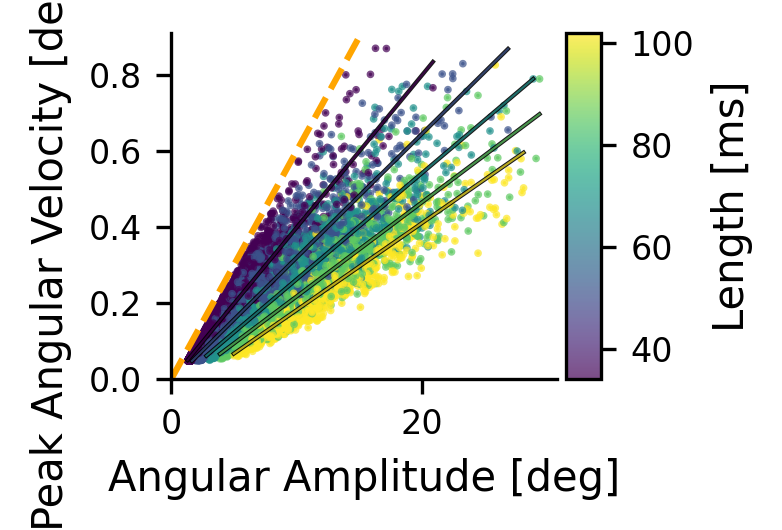

In [36]:
plot_saccade_magnitude_vs_velocity_length_angular(
    synced_saccade_collection.query('length < 6'), non_synced_saccade_collection.query('length < 6'), export_path=None, threshold=5,
    fig_size=(2, 1.5), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60)

Saccades in plot (after equal sampling): 849
Len=34 ms, R²=0.93, p=2.8e-121 

Len=51 ms, R²=0.90, p=6.6e-130 

Len=68 ms, R²=0.85, p=1.7e-100 

Len=85 ms, R²=0.86, p=1.2e-41 

Len=102 ms, R²=0.90, p=5.5e-29 



KeyboardInterrupt: 

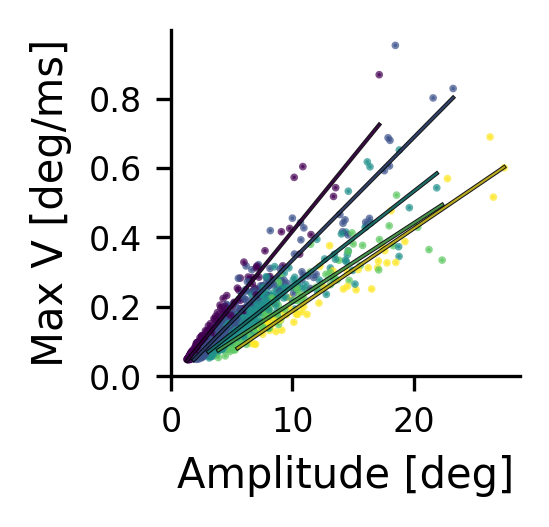

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from scipy.stats import t
import datetime
import os
import pickle

def plot_saccade_magnitude_vs_velocity_length_angular_multiple_animals(
    synced_saccade_collection, monocular_saccade_collection, export_path=None,
    fig_size=(3, 3), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60
):
    """
    Plots angular saccade amplitudes versus angular peak velocities as a scatter plot.

    In this revised version:
      - All datapoints are kept (no outlier removal).
      - The data is grouped by animal (using the 'animal' column),
        and a random sampling is done so that each animal contributes the same number
        of datapoints (equal to the count of the animal with the fewest datapoints).
      - Angular metrics are computed as follows:
            magnitude: taken from 'magnitude_raw_angular' (in degrees)
            peak_velocity: maximum value from 'speed_profile_angular' (converted to deg/ms if desired)
            length: defined as the number of frames in 'speed_profile_angular' multiplied by 17 to convert to ms.

    Parameters:
      - synced_saccade_collection: DataFrame of synchronized saccades with angular columns and an 'animal' column.
      - monocular_saccade_collection: DataFrame of monocular saccades (unused, for compatibility).
      - export_path (str): Directory path to export the plot and data.
      - fig_size (tuple): Figure size (width, height).
      - velocity_threshold (float): Optional horizontal line value for peak velocities.
      - velocity_to_deg_per_ms (bool): If True, converts angular speeds from deg/frame to deg/ms.
      - frame_rate_fps (float): Frame rate in frames per second.
    """
    # Make a copy of the data and compute the key metrics.
    df = synced_saccade_collection.copy()

    # Ensure that an 'animal' column exists
    if 'animal' not in df.columns:
        raise ValueError("The input dataframe must contain an 'animal' column.")

    # Compute metrics:
    #  - 'magnitude' from 'magnitude_raw_angular'
    #  - 'peak_velocity' as the maximum of each speed profile
    #  - 'length' as the number of frames (converted to ms by multiplying by 17)
    df['magnitude'] = df['magnitude_raw_angular']
    df['peak_velocity'] = df['speed_profile_angular'].apply(np.nanmax)
    df['length'] = df['speed_profile_angular'].apply(lambda x: len(x)) * 17

    # Optionally convert angular peak velocity from deg/frame to deg/ms.
    if velocity_to_deg_per_ms:
        frame_duration = 1000 / frame_rate_fps  # ms per frame
        df['peak_velocity'] = df['peak_velocity'] / frame_duration

    # Group by animal and sample equally: find the smallest group size.
    grouped = df.groupby('animal')
    min_count = grouped.size().min()
    sampled_dfs = []
    for animal, group in grouped:
        # Randomly sample min_count rows from each animal group (using a fixed random_state for reproducibility)
        sampled_group = group.sample(n=min_count, random_state=42)
        sampled_dfs.append(sampled_group)

    sampled_data = pd.concat(sampled_dfs, axis=0)
    print(f'Saccades in plot (after equal sampling): {len(sampled_data)}')

    # Plot settings
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)

    # Scatter plot: angular amplitude (x-axis) vs. peak angular velocity (y-axis)
    # Points are colored by saccade length (in ms)
    sc = ax.scatter(sampled_data['magnitude'], sampled_data['peak_velocity'], s=0.7,
                    c=sampled_data['length'], cmap='viridis', alpha=0.7)

    ax.set_xlabel('Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Max V [deg/ms]', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    # Add optional horizontal line if a velocity_threshold is provided.
    if velocity_threshold is not None:
        ax.axhline(y=velocity_threshold, color='red', linestyle='--', linewidth=1.5)

    # Optionally, group data by saccade length and fit regression lines.
    grouped_data = sampled_data.groupby('length')
    norm = Normalize(vmin=sampled_data['length'].min(), vmax=sampled_data['length'].max())
    cmap_ = plt.cm.viridis

    for length, group in grouped_data:
        clean_group = group[['magnitude', 'peak_velocity']].dropna()
        x = clean_group['magnitude'].values.reshape(-1, 1)
        y = clean_group['peak_velocity'].values
        line_color = cmap_(norm(length))
        if len(x) > 1:
            model = LinearRegression().fit(x, y)
            slope = model.coef_[0]
            intercept = model.intercept_
            r_squared = model.score(x, y)
            y_pred = model.predict(x)
            residuals = y - y_pred
            rse = np.sqrt(np.sum(residuals**2) / (len(x) - 2))
            se_slope = rse / np.sqrt(np.sum((x - x.mean())**2))
            t_stat = slope / se_slope
            df_deg = len(x) - 2
            p_value = 2 * t.sf(np.abs(t_stat), df_deg)
            x_vals = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
            y_vals = model.predict(x_vals)
            ax.plot(x_vals, y_vals, linestyle='-', linewidth=1, color='black', alpha=0.9, zorder=1)
            ax.plot(x_vals, y_vals, linestyle='-', linewidth=0.5, color=line_color, alpha=0.7, zorder=2)
            legend_text = f'Len={length} ms, R²={r_squared:.2f}, p={p_value:.2g}'
            print(legend_text, '\n')

    # Add a reference line with slope = 1/frame_duration in deg/ms.
    frame_duration = 1000 / frame_rate_fps
    limiting_slope = 1 / frame_duration
    x_line = np.linspace(0, sampled_data['magnitude'].max(), 100)
    y_line = limiting_slope * x_line
    ax.plot(x_line, y_line, color='orange', linestyle='--', linewidth=1.5, label='Min Detectable Speed')
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # Add colorbar for saccade length (in ms)
    #cbar = plt.colorbar(sc, ax=ax, pad=0.02, aspect=10)
    #cbar.set_label('Length [ms]', fontsize=10)
    #cbar.ax.tick_params(labelsize=8)
    #ax.set_xlim(0,30)
    #ax.set_ylim(0,1)


    # Handle export if export_path is provided.
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_magnitude_vs_velocity_length_angular_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_magnitude_vs_velocity_length_angular.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "sampled_saccade_data_length_angular.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(sampled_data, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()

export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\amplitude_velocity_length'
plot_saccade_magnitude_vs_velocity_length_angular_multiple_animals(
    synced_saccade_collection.query('length < 6 and animal!="PV_62" and head_movement==False'),
    non_synced_saccade_collection.query('length < 6 and animal!="PV_62" and head_movement==False'), export_path=None,
    fig_size=(1.5, 1.5), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60)

In [69]:
all_saccade_collection.columns

Index(['Main', 'Sub', 'saccade_start_ind', 'saccade_end_ind',
       'saccade_start_timestamp', 'saccade_end_timestamp', 'saccade_on_ms',
       'saccade_off_ms', 'length', 'magnitude_raw_pixel', 'magnitude_pixel',
       'magnitude_raw_angular', 'overall_angle_deg', 'net_angular_disp',
       'speed_profile_pixel', 'speed_profile_pixel_calib',
       'speed_profile_angular', 'diameter_profile', 'theta_init_pos',
       'theta_end_pos', 'phi_init_pos', 'phi_end_pos', 'delta_theta',
       'delta_phi', 'head_movement', 'eye', 'block', 'animal',
       'time_to_peak_v'],
      dtype='object')

saccades in plot: 2261
Len=34 ms, R²=0.92, p=2.7e-314 

Len=51 ms, R²=0.90, p=2.6e-320 

Len=68 ms, R²=0.88, p=6.4e-255 

Len=85 ms, R²=0.85, p=1.1e-121 

Len=102 ms, R²=0.90, p=9.2e-89 



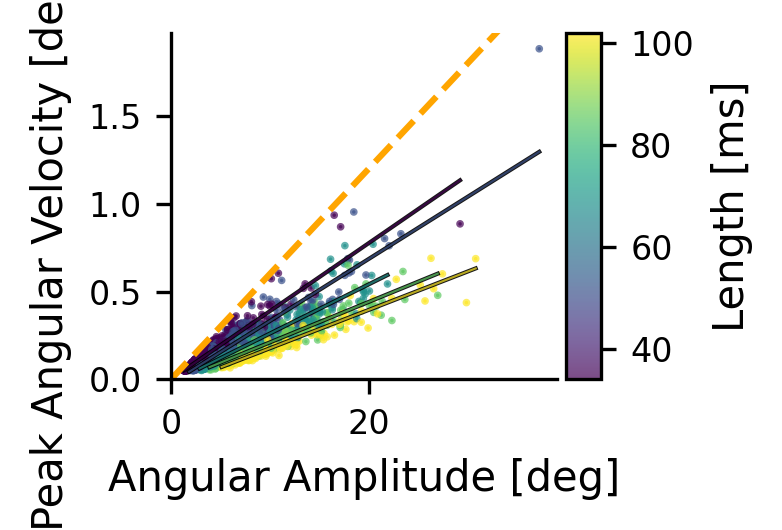

In [25]:
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\amplitude_velocity_length'

plot_saccade_magnitude_vs_velocity_length_angular(
    synced_saccade_collection.query(' animal != "PV_62" and length < 6 and head_movement==False'),
    non_synced_saccade_collection.query('animal != "PV_62" and length < 6 and head_movement==False'), export_path=None, threshold=15,
    fig_size=(2, 1.5), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60)

Saccades in plot (after equal sampling & cleaning): 9125
Len=33 ms | log10(V)= +1.559 + 1.056·log10(A) | R²=0.95, p=0
Len=50 ms | log10(V)= +1.409 + 1.113·log10(A) | R²=0.92, p=0
Len=67 ms | log10(V)= +1.235 + 1.191·log10(A) | R²=0.90, p=0
Len=83 ms | log10(V)= +1.056 + 1.277·log10(A) | R²=0.89, p=0
Len=100 ms | log10(V)= +0.988 + 1.259·log10(A) | R²=0.87, p=7.2e-305
Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\amplitude_velocity_length\saccade_magnitude_vs_velocity_length_angular_2025_09_10_14_14_09


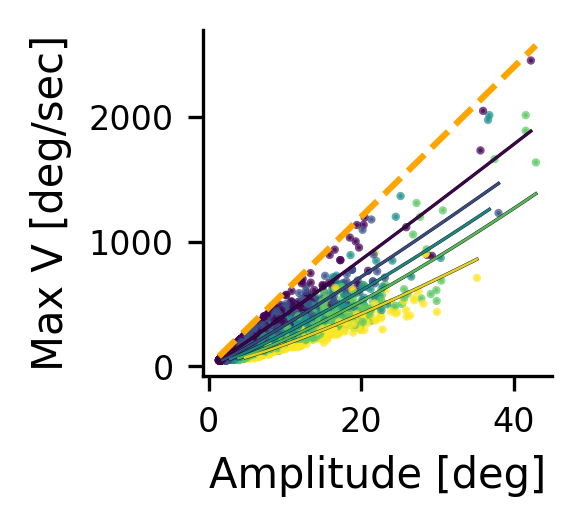

In [66]:
# over here, we correct the fit to power law
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.colors import Normalize
from scipy.stats import t
import datetime
import os
import pickle

def plot_saccade_magnitude_vs_velocity_length_angular_multiple_animals(
    synced_saccade_collection, monocular_saccade_collection, export_path=None,
    fig_size=(3, 3), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60,
    log_scale=True, min_points_per_group=3
):
    """
    Plots angular saccade amplitude (deg) vs peak angular velocity (deg/sec) with log–log scaling
    and per-length power-law fits.

    Key behavior:
      - y in deg/sec (deg/frame × fps).
      - length in ms = (#frames) × (1000/fps).
      - Equal samples per animal (random, size of smallest animal group).
      - Regression is done in log10 space: log10(V) = a + b*log10(A)  ->  V = 10^a * A^b
        (fits and R² computed in log10 space; lines plotted back in linear space).
      - Frame-limited reference line: V = fps * A (slope 1 in log–log).

    Args:
      synced_saccade_collection : DataFrame with columns:
          - 'animal'
          - 'magnitude_raw_angular' (deg)
          - 'speed_profile_angular' (array-like of deg/frame values)
      monocular_saccade_collection : unused (kept for signature compatibility)
      export_path : optional directory to export PDF + sampled data pickle
      fig_size : tuple, inches
      velocity_threshold : float or None; horizontal line in deg/sec
      velocity_to_deg_per_ms : kept for backward compat; if True, convert to deg/sec
      frame_rate_fps : float; camera rate
      log_scale : bool; if True, uses log–log axes
      min_points_per_group : int; minimum positive (A,V) points required to fit a line per length group
    """
    # --- Copy and basic checks ---
    df = synced_saccade_collection.copy()
    if 'animal' not in df.columns:
        raise ValueError("The input dataframe must contain an 'animal' column.")

    # --- Compute metrics ---
    frame_duration_ms = 1000.0 / float(frame_rate_fps)  # ms per frame

    # Amplitude in deg
    df['magnitude'] = df['magnitude_raw_angular']

    # Peak velocity in deg/frame -> will convert to deg/sec
    df['peak_velocity'] = df['speed_profile_angular'].apply(np.nanmax)

    # Length in ms
    df['length'] = df['speed_profile_angular'].apply(
        lambda x: len(x) if hasattr(x, '__len__') else np.nan
    ) * frame_duration_ms

    # Convert to deg/sec (flag name retained for back-compat)
    if velocity_to_deg_per_ms:
        df['peak_velocity'] = df['peak_velocity'] * float(frame_rate_fps)

    # --- Equalize samples per animal ---
    grouped_anim = df.groupby('animal')
    min_count = grouped_anim.size().min()
    sampled_dfs = []
    for animal, group in grouped_anim:
        if min_count is None or min_count < 1:
            continue
        sampled_group = group.sample(n=min_count, random_state=42)
        sampled_dfs.append(sampled_group)
    if not sampled_dfs:
        raise ValueError("No data available after grouping/sampling; check input data.")
    sampled_data = pd.concat(sampled_dfs, axis=0)

    # Keep only rows with finite numbers
    sampled_data = sampled_data.replace([np.inf, -np.inf], np.nan)
    sampled_data = sampled_data.dropna(subset=['magnitude', 'peak_velocity', 'length'])

    print(f"Saccades in plot (after equal sampling & cleaning): {len(sampled_data)}")

    # --- Plot ---
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)

    sc = ax.scatter(
        sampled_data['magnitude'],
        sampled_data['peak_velocity'],
        s=1,
        c=sampled_data['length'],
        cmap='viridis',
        alpha=0.7
    )

    ax.set_xlabel('Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Max V [deg/sec]', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Log–log axes (recommended for revealing low-A, low-V structure)
    if log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')

    # Optional horizontal threshold in deg/sec (works fine on log y)
    if velocity_threshold is not None and np.isfinite(velocity_threshold) and velocity_threshold > 0:
        ax.axhline(y=velocity_threshold, color='red', linestyle='--', linewidth=1.5)

    # --- Per-length power-law (log–log) regressions ---
    # We group by exact length (ms). If you prefer length bins, we can add that easily.
    grouped_len = sampled_data.groupby('length')

    norm = Normalize(vmin=sampled_data['length'].min(), vmax=sampled_data['length'].max())
    cmap_ = plt.cm.viridis

    def _fit_loglog_and_plot(x_lin, y_lin, color):
        """
        Fit log10(y) = a + b*log10(x), return (a, b, R2, pval) and draw the curve in linear space.
        """
        # Keep strictly positive pairs for log transform:
        mask = (x_lin > 0) & (y_lin > 0) & np.isfinite(x_lin) & np.isfinite(y_lin)
        x = x_lin[mask]
        y = y_lin[mask]
        if x.size < min_points_per_group:
            return None

        Xlog = np.log10(x).reshape(-1, 1)
        Ylog = np.log10(y)

        model = LinearRegression().fit(Xlog, Ylog)
        a = float(model.intercept_)        # log10(alpha)
        b = float(model.coef_[0])          # power exponent
        R2 = float(model.score(Xlog, Ylog))

        # p-value for slope in log space (simple linear regression)
        Yhat = model.predict(Xlog)
        resid = Ylog - Yhat
        n = len(Ylog)
        df_deg = n - 2
        if df_deg > 0:
            s2 = np.sum(resid**2) / df_deg
            Sxx = np.sum((Xlog - Xlog.mean())**2)
            if Sxx > 0:
                se_b = np.sqrt(s2 / Sxx)
                t_stat = b / se_b if se_b > 0 else np.inf
                p_val = 2 * t.sf(np.abs(t_stat), df_deg)
            else:
                p_val = np.nan
        else:
            p_val = np.nan

        # Draw the line as a power curve in linear space across the observed x-range
        x_line = np.logspace(np.log10(x.min()), np.log10(x.max()), 100)
        y_line = (10.0**a) * (x_line**b)
        ax.plot(x_line, y_line, linestyle='-', linewidth=0.8, color='black', alpha=0.9, zorder=1)
        ax.plot(x_line, y_line, linestyle='-', linewidth=0.6, color=color, alpha=0.9, zorder=2)

        return a, b, R2, p_val

    for length_ms, group in grouped_len:
        clean = group[['magnitude', 'peak_velocity']].dropna().to_numpy()
        if clean.shape[0] < min_points_per_group:
            continue
        x_lin = clean[:, 0].astype(float)
        y_lin = clean[:, 1].astype(float)
        line_color = cmap_(norm(length_ms))
        fit = _fit_loglog_and_plot(x_lin, y_lin, line_color)
        if fit is not None:
            a_log10, b_pow, R2, p_val = fit
            print(f"Len={length_ms:.0f} ms | log10(V)= {a_log10:+.3f} + {b_pow:.3f}·log10(A) | "
                  f"R²={R2:.2f}, p={p_val:.2g}")

    # --- Frame-limited reference line: V = fps * A (slope=1 in log–log) ---
    if len(sampled_data) > 0:
        x_min_pos = sampled_data['magnitude'][sampled_data['magnitude'] > 0].min()
        x_max_pos = sampled_data['magnitude'].max()
        if np.isfinite(x_min_pos) and np.isfinite(x_max_pos) and x_min_pos > 0 and x_max_pos > 0:
            x_ref = np.logspace(np.log10(x_min_pos), np.log10(x_max_pos), 100)
            y_ref = float(frame_rate_fps) * x_ref
            ax.plot(x_ref, y_ref, color='orange', linestyle='--', linewidth=1.5, label='Frame-limited (V = fps·A)')

    # Optional colorbar (length in ms)
    # cbar = plt.colorbar(sc, ax=ax, pad=0.02, aspect=10)
    # cbar.set_label('Length [ms]', fontsize=10)
    # cbar.ax.tick_params(labelsize=8)

    # Export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_magnitude_vs_velocity_length_angular_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_magnitude_vs_velocity_length_angular.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "sampled_saccade_data_length_angular.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(sampled_data, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\amplitude_velocity_length'
plot_saccade_magnitude_vs_velocity_length_angular_multiple_animals(
    synced_saccade_collection.query('length<6'), non_synced_saccade_collection, export_path=export_path,
    fig_size=(1.5, 1.5), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60,
    log_scale=False, min_points_per_group=3
)

In [23]:
for block in block_collection:
    print(block)
    print('left:',block.L_pix_size)
    print('right:',block.R_pix_size)


PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19
left: 0.0634
right: 0.05
PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43
left: 0.0632
right: 0.05
PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43
left: 0.0632
right: 0.0505
PV_106, block 011, on PV106_ET_d3t4_2025-08-06_12-44-30
left: 0.059000000000000004
right: 0.047
PV_106, block 012, on PV106_ET_d3t5_2025-08-06_13-21-30
left: 0.059000000000000004
right: 0.047
PV_143, block 001, on PV143_ET_d1t1_2025-08-11_13-29-08
left: 0.037000000000000005
right: 0.0417
PV_143, block 002, on PV143_ET_d1t2_2025-08-11_13-50-11
left: 0.037000000000000005
right: 0.0417
PV_143, block 003, on PV143_ET_d1t3_2025-08-11_14-20-35
left: 0.038
right: 0.0424
PV_143, block 004, on PV143_ET_d1t4_2025-08-11_14-58-28
left: 0.038
right: 0.0424
PV_62, block 024, on 2023-04-27_11-22-56
left: 0.045
right: 0.047
PV_62, block 026, on 2023-04-27_12-21-41
left: 0.045
right: 0.047
PV_62, block 038, on 2023-05-01_13-57-45
left: 0.04605644273172008
right: 

Value = 17, count = 1758
Value = 34, count = 479
Value = 51, count = 155
Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\ttp_profiles_segmented\angular_speed_profiles_2025_09_01_18_47_02


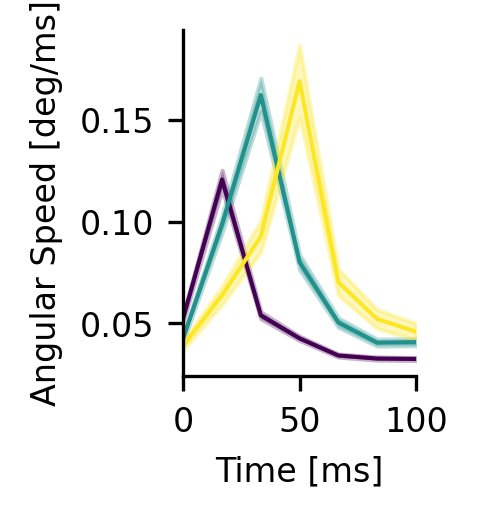

In [54]:
import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde, t
from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('default')
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

def plot_speed_profiles_with_export_angular(
    saccade_collection, sampling_rate=60, floor=None, ceiling=None, export_path=None,
    fig_size=(2.5,1.7), set_xlim=None
):
    """
    Plots average angular speed profiles grouped by unique time-to-peak values, up to a ceiling value.
    Angular speed profiles are taken from the 'speed_profile_angular' column, which is assumed to be in deg/frame.
    They are converted to deg/ms by dividing by the frame duration (1000/sampling_rate).

    Parameters:
      - saccade_collection: DataFrame containing angular speed profiles (in 'speed_profile_angular') and
                            time-to-peak values in 'time_to_peak_v'.
      - sampling_rate: Sampling rate in Hz (default 60 Hz).
      - floor: Minimum time-to-peak value to include (optional).
      - ceiling: Maximum time-to-peak value to include (optional).
      - export_path: Directory path to export the plot and data (optional).
      - fig_size: Figure size (width, height).
      - set_xlim: Optional x-axis limits.
    """
    # Filter unique time-to-peak values and apply ceiling/floor if provided
    unique_time_to_peak_values = np.unique(saccade_collection['time_to_peak_v'].dropna().astype(int))
    if ceiling is not None:
        unique_time_to_peak_values = unique_time_to_peak_values[unique_time_to_peak_values <= ceiling]
    if floor is not None:
        unique_time_to_peak_values = unique_time_to_peak_values[unique_time_to_peak_values >= floor]
    unique_time_to_peak_values = unique_time_to_peak_values[unique_time_to_peak_values >= 0]

    # Prepare the figure
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=unique_time_to_peak_values.min(), vmax=unique_time_to_peak_values.max())

    # Calculate frame duration (ms per frame)
    frame_duration = 1000 / sampling_rate  # e.g., ~16.67 ms at 60 Hz

    # Iterate over each unique time-to-peak value
    for idx, time_to_peak in enumerate(unique_time_to_peak_values):
        # Filter the angular speed profiles for the current time-to-peak value.
        # Note: We now use the 'speed_profile_angular' column.
        profiles = saccade_collection.loc[
            saccade_collection['time_to_peak_v'] == time_to_peak,
            'speed_profile_angular'
        ].dropna().values

        if len(profiles) == 0:
            continue

        # Convert each speed profile from deg/frame to deg/ms
        converted_profiles = []
        for profile in profiles:
            # Ensure profile is a NumPy array
            profile = np.array(profile)
            # Convert: deg/frame divided by (ms/frame) gives deg/ms.
            converted_profiles.append(profile / frame_duration)

        # Align the converted profiles to the same length
        max_length = max(len(p) for p in converted_profiles)
        aligned_profiles = np.full((len(converted_profiles), max_length), np.nan)
        for i, profile in enumerate(converted_profiles):
            aligned_profiles[i, :len(profile)] = profile

        # Compute average profile and standard error
        avg_profile = np.nanmean(aligned_profiles, axis=0)
        std_error = np.nanstd(aligned_profiles, axis=0) / np.sqrt(len(converted_profiles))

        # Define time points (in ms) for the profile based on sampling rate
        time_points = np.arange(0, len(avg_profile) * frame_duration, frame_duration)

        # If set_xlim is provided, filter the data to only include points within the specified range.
        if set_xlim is not None:
            lower_bound, upper_bound = set_xlim
            mask = (time_points >= lower_bound) & (time_points <= upper_bound)
            time_points = time_points[mask]
            avg_profile = avg_profile[mask]
            std_error = std_error[mask]

        # Plot the average speed profile with its error region
        ax.plot(time_points, avg_profile, color=cmap(norm(time_to_peak)), lw=1)
        ax.fill_between(time_points, avg_profile - std_error, avg_profile + std_error,
                        color=cmap(norm(time_to_peak)), alpha=0.3)

    if set_xlim is not None:
        ax.set_xlim(set_xlim)

    # Customize the plot labels and appearance
    ax.set_xlabel('Time [ms]', fontsize=8)
    ax.set_ylabel('Angular Speed [deg/ms]', fontsize=8)
    ax.tick_params(axis='both', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add a colorbar for time-to-peak values
    #sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    #sm.set_array([])
    #cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
    # Uncomment the following line if you wish to add a label to the colorbar:
    # cbar.set_label('Time-to-Peak [ms]', fontsize=8)

    # Print counts for debugging
    for value in unique_time_to_peak_values:
        count = len(saccade_collection.query('time_to_peak_v == @value'))
        print(f'Value = {value}, count = {count}')

    # Export the figure and data if export_path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"angular_speed_profiles_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "angular_speed_profiles.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(saccade_collection, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()

export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\ttp_profiles_segmented'
plot_speed_profiles_with_export_angular(all_saccade_collection.query('animal == "PV_62" and head_movement==False'), sampling_rate=60, floor=1, ceiling=52, export_path=export_path, fig_size=(1,1.5), set_xlim=(0,100))

In [1]:
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\ttp_profiles_segmented'
plot_speed_profiles_with_export_angular(all_saccade_collection.query('animal == "PV_62" and head_movement==False'), sampling_rate=60, floor=1, ceiling=52, export_path=export_path, fig_size=(1,1.5), set_xlim=(0,100))

NameError: name 'all_saccade_collection' is not defined

Collect L: 100%|██████████| 2478/2478 [00:02<00:00, 1209.93it/s]


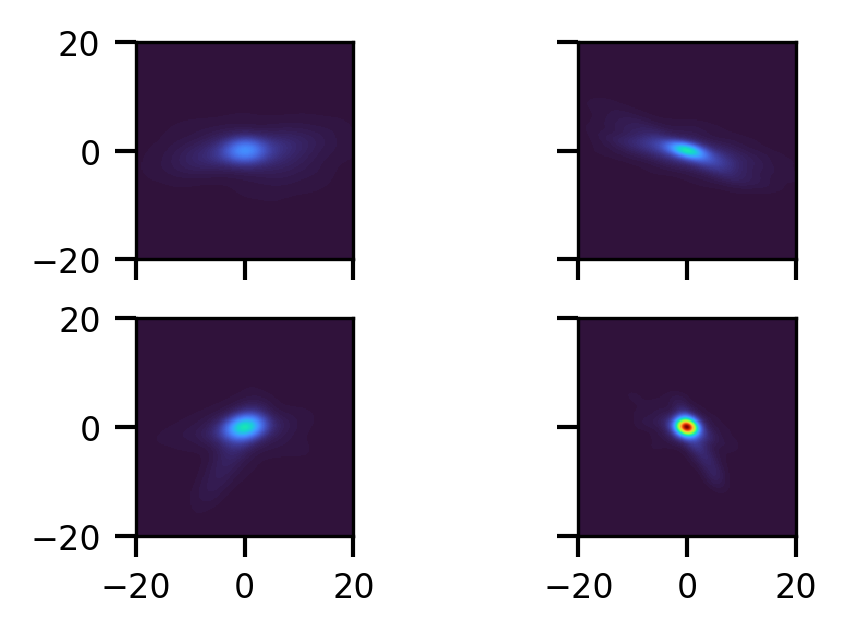

In [56]:
def plot_saccade_heatmaps_comparison_trajectories(
    synced_saccades, non_synced_saccades, block_dict,
    export_path=None, nbins=200,
    global_min=-25, global_max=25,
    cmap=plt.cm.turbo, figsize=(4, 2.5)
):
    """
    See original docstring; behavior unchanged except:
      - no per-axes titles
      - top-row x tick labels removed; right-column y tick labels removed
      - panels are square & undistorted (equal aspect and identical x/y limits)
      - colorbar exported as a separate PDF file when export_path is provided
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from matplotlib.colors import Normalize
    from scipy.stats import gaussian_kde
    import os, datetime, pickle, pathlib, tqdm

    def extract_zeroed_points(saccades_df, eye):
        xs, ys = [], []
        df_eye = saccades_df[saccades_df['eye'] == eye]
        for _, row in tqdm.tqdm(df_eye.iterrows(), total=len(df_eye), desc=f"Collect {eye}"):
            block_num = row['block']
            start_ms = row['saccade_on_ms']
            end_ms = row['saccade_off_ms']
            block_key = f"{row['animal']}_block_{block_num}"
            if block_key not in block_dict:
                continue
            block = block_dict[block_key]
            eye_df = block.left_eye_data if eye == 'L' else block.right_eye_data if eye == 'R' else None
            if eye_df is None:
                continue
            traj = eye_df[(eye_df['ms_axis'] >= start_ms) & (eye_df['ms_axis'] <= end_ms)]
            if traj.empty:
                continue
            x0, y0 = traj['center_x'].iloc[0], traj['center_y'].iloc[0]
            xs.extend((traj['center_x'] - x0).to_list())
            ys.extend((traj['center_y'] - y0).to_list())
        return np.asarray(xs), np.asarray(ys)

    # Gather points
    r_x_synced, r_y_synced = extract_zeroed_points(synced_saccades, 'R')
    l_x_synced, l_y_synced = extract_zeroed_points(synced_saccades, 'L')
    r_x_ns,    r_y_ns    = extract_zeroed_points(non_synced_saccades, 'R')
    l_x_ns,    l_y_ns    = extract_zeroed_points(non_synced_saccades, 'L')

    def evaluate_kde(x, y):
        if x.size == 0 or y.size == 0:
            return None
        k = gaussian_kde(np.vstack([x, y]).astype(float))
        xi, yi = np.mgrid[global_min:global_max:nbins*1j,
                          global_min:global_max:nbins*1j]
        zi = k(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
        zi = zi / zi.sum()  # normalize density to 1
        return xi, yi, zi

    kdeds = {
        ('synced', 'R'): evaluate_kde(r_x_synced, r_y_synced),
        ('synced', 'L'): evaluate_kde(l_x_synced, l_y_synced),
        ('non',    'R'): evaluate_kde(r_x_ns,    r_y_ns),
        ('non',    'L'): evaluate_kde(l_x_ns,    l_y_ns),
    }

    # Shared color scale (only over existing arrays)
    all_zi = [trip[2] for trip in kdeds.values() if trip is not None]
    vmin, vmax = (min(z.min() for z in all_zi), max(z.max() for z in all_zi)) if all_zi else (0.0, 1.0)
    norm = Normalize(vmin=vmin, vmax=vmax)

    # Figure: 2x2 panels, square aspect, shared limits, no colorbar here
    fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=figsize, dpi=300,
        sharex=True, sharey=True, constrained_layout=True
    )

    # Helper to draw one heatmap without title
    def draw(ax, key):
        trip = kdeds.get(key, None)
        if trip is None:
            ax.set_xlim(global_min, global_max)
            ax.set_ylim(global_min, global_max)
            ax.set_aspect('equal', adjustable='box')
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=8, transform=ax.transAxes)
            return None
        _, _, zi = trip
        im = ax.imshow(
            zi.T,
            extent=[global_min, global_max, global_min, global_max],
            origin='lower', cmap=cmap, norm=norm, interpolation='nearest'
        )
        ax.set_xlim(global_min, global_max)
        ax.set_ylim(global_min, global_max)
        ax.set_aspect('equal', adjustable='box')
        return im

    # Layout: [0,0]=Right Synced ; [0,1]=Left Synced ; [1,0]=Right Non ; [1,1]=Left Non
    draw(axes[0,0], ('synced','R'))
    draw(axes[0,1], ('synced','L'))
    draw(axes[1,0], ('non','R'))
    draw(axes[1,1], ('non','L'))

    # Remove titles
    for ax in axes.ravel():
        ax.set_title("")

    # Tick label visibility rules
    # - top row: hide x tick labels
    axes[0,0].tick_params(axis='x', labelbottom=False)
    axes[0,1].tick_params(axis='x', labelbottom=False)
    # - right column: hide y tick labels
    axes[0,1].tick_params(axis='y', labelleft=False)
    axes[1,1].tick_params(axis='y', labelleft=False)

    # (Optional) thin ticks & smaller font for compactness
    for ax in axes.ravel():
        ax.tick_params(which='both', width=1, length=5, labelsize=8)

    # Export(s)
    if export_path is not None:
        export_path = pathlib.Path(export_path)
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        out_dir = export_path / f"saccade_heatmaps_trajectories_{timestamp}"
        out_dir.mkdir(parents=True, exist_ok=True)

        # Main figure (no colorbar)
        fig.savefig(out_dir / "saccade_heatmaps_comparison_trajectories.pdf",
                    format='pdf', bbox_inches='tight', dpi=300)

        # Separate colorbar PDF
        if all_zi:
            # slim, vertical colorbar figure
            fig_cb, ax_cb = plt.subplots(figsize=(0.6, 2.0), dpi=300)
            sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
            sm.set_array([])
            cb = plt.colorbar(sm, ax=ax_cb)
            cb.set_label('Relative density', fontsize=9)
            ax_cb.remove()  # only keep the colorbar
            fig_cb.savefig(out_dir / "saccade_heatmaps_colorbar.pdf",
                           format='pdf', bbox_inches='tight', dpi=300)
            plt.close(fig_cb)

        # Save aggregated points for reproducibility
        with open(out_dir / "saccade_trajectories_data.pkl", "wb") as f:
            pickle.dump({
                'synced': {'R': (r_x_synced, r_y_synced), 'L': (l_x_synced, l_y_synced)},
                'non_synced': {'R': (r_x_ns, r_y_ns), 'L': (l_x_ns, l_y_ns)},
                'grid': {'nbins': nbins, 'global_min': global_min, 'global_max': global_max},
                'vmin_vmax': (vmin, vmax),
            }, f)

        print(f"Exported to: {out_dir}")

    plt.show()
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_heatmaps_degree_verified')
synced_saccades = synced_saccade_collection.query('animal == "PV_106"')
non_synced_saccades = non_synced_saccade_collection.query('animal == "PV_106"')
plot_saccade_heatmaps_comparison_trajectories(synced_saccades, non_synced_saccades, block_dict=block_dict,export_path=None, nbins=200,
                                       global_min=-20, global_max=20, cmap=plt.cm.turbo, figsize=(3, 2))

# This version tweaks the plot for the paper

Collect L: 100%|██████████| 838/838 [00:00<00:00, 1235.94it/s]


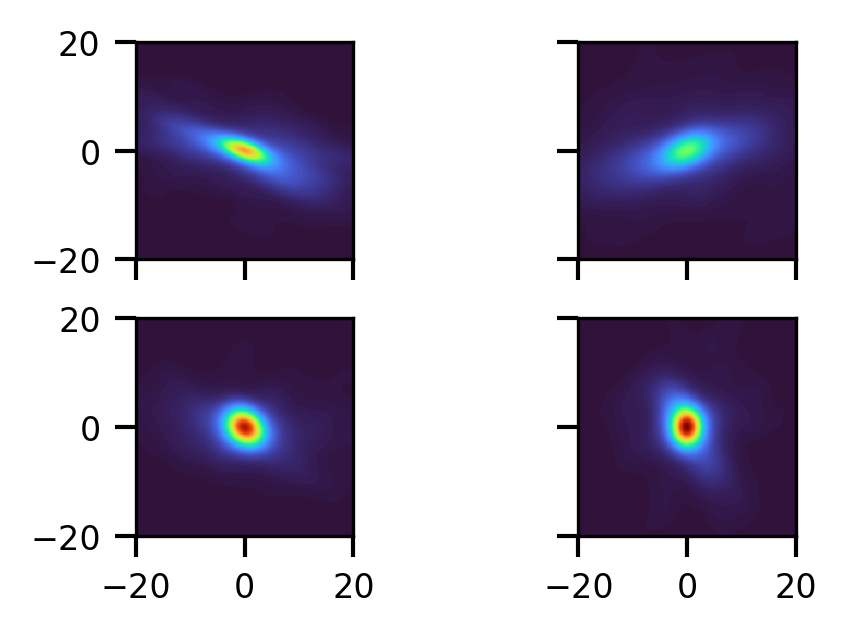

In [57]:
synced_saccades = synced_saccade_collection.query('animal == "PV_143"')
non_synced_saccades = non_synced_saccade_collection.query('animal == "PV_143"')
plot_saccade_heatmaps_comparison_trajectories(synced_saccades, non_synced_saccades, block_dict=block_dict,export_path=None, nbins=200,
                                       global_min=-20, global_max=20, cmap=plt.cm.turbo, figsize=(3, 2))

1624it [00:01, 1186.27it/s]
1914it [00:01, 1241.01it/s]
1567it [00:01, 1172.44it/s]
2478it [00:02, 1198.19it/s]


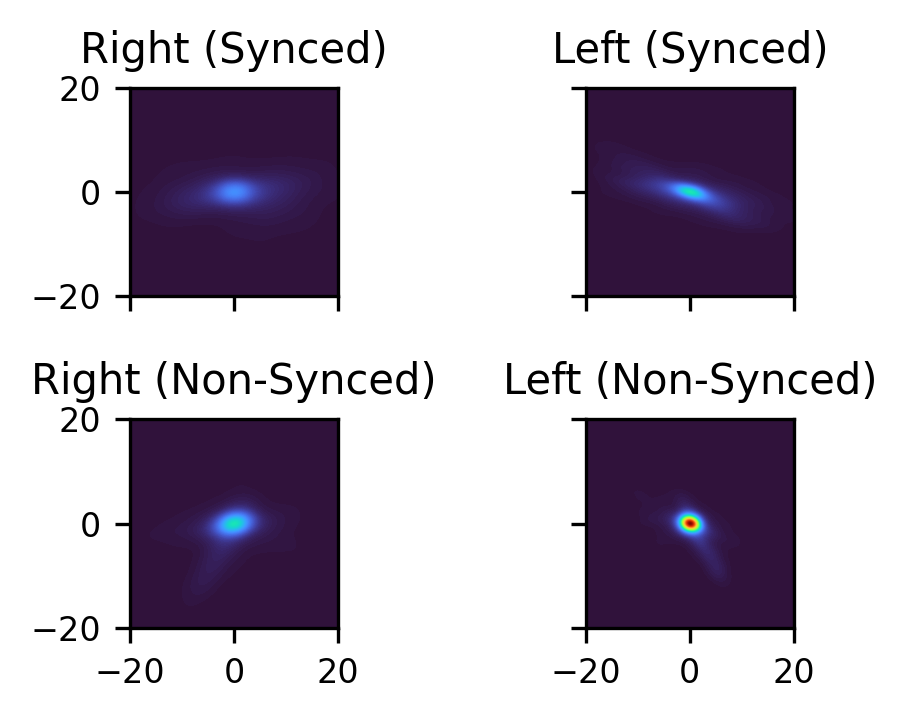

In [61]:
# this is an alternative approach for the heatmaps story, and it has the option to rotate according to 3D registration angles:


def plot_saccade_heatmaps_comparison_trajectories(synced_saccades, non_synced_saccades, block_dict,
                                                  export_path=None, nbins=200,
                                                  global_min=-25, global_max=25,
                                                  cmap=plt.cm.turbo, figsize=(4, 2.5)):
    """
    Plots stacked 2D KDE heatmaps for synced (top row) and non-synced (bottom row) saccade trajectories.

    For each saccade event, this function:
      - Retrieves the block object from block_dict (using block number and animal).
      - Selects the appropriate eye DataFrame (block.left_eye_data or block.right_eye_data).
      - Extracts the trajectory using the ms_axis timestamps (saccade_on_ms and saccade_off_ms).
      - Zeroes the trajectory by subtracting its initial (center_x, center_y) coordinate.
      - Aggregates all points for each condition (synced vs. non-synced) and eye (R and L).
      - Computes and plots a 2D KDE of the aggregated points.

    Parameters:
      - synced_saccades: DataFrame with synced saccade events. Must include columns:
          'block', 'animal', 'eye', 'saccade_on_ms', 'saccade_off_ms'.
      - non_synced_saccades: DataFrame for non-synced saccade events (same columns).
      - block_dict: Dictionary mapping block keys (e.g. "PV_126_block_7") to block objects.
      - export_path: Optional export directory.
      - nbins: Number of bins for the KDE grid.
      - global_min, global_max: Limits for the KDE evaluation grid.
      - cmap: Colormap for the heatmap.
      - figsize: Figure size.

    Returns:
      - None. The function displays (and optionally exports) the heatmap plot.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    import os
    import datetime
    import pickle

    def extract_zeroed_points(saccades_df, eye):
        xs = []
        ys = []
        # Filter for the current eye (e.g., "L" or "R")
        df_eye = saccades_df[saccades_df['eye'] == eye]
        for _, row in tqdm.tqdm(df_eye.iterrows()):
            block_num = row['block']
            start_ms = row['saccade_on_ms']
            end_ms = row['saccade_off_ms']
            block_key = f"{row['animal']}_block_{block_num}"
            if block_key not in block_dict:
                continue
            block = block_dict[block_key]
            # Choose the appropriate eye data based on row's 'eye'
            if eye == 'L':
                eye_df = block.left_eye_data
            elif eye == 'R':
                eye_df = block.right_eye_data
            else:
                continue
            # Extract the trajectory using the ms_axis time window
            traj = eye_df[(eye_df['ms_axis'] >= start_ms) & (eye_df['ms_axis'] <= end_ms)]
            if traj.empty:
                continue
            # Zero the trajectory by subtracting the first coordinate
            x0 = traj['center_x'].iloc[0]
            y0 = traj['center_y'].iloc[0]
            traj_x = traj['center_x'] - x0
            traj_y = traj['center_y'] - y0
            xs.extend(traj_x.tolist())
            ys.extend(traj_y.tolist())
        return np.array(xs), np.array(ys)

    # Extract zeroed trajectory points for synced and non-synced saccades, for both eyes.
    r_x_synced, r_y_synced = extract_zeroed_points(synced_saccades, 'R')
    l_x_synced, l_y_synced = extract_zeroed_points(synced_saccades, 'L')
    r_x_ns, r_y_ns = extract_zeroed_points(non_synced_saccades, 'R')
    l_x_ns, l_y_ns = extract_zeroed_points(non_synced_saccades, 'L')

    def evaluate_kde(x, y):
        if len(x) == 0 or len(y) == 0:
            return None, None, None
        k = gaussian_kde(np.vstack([x, y]).astype(float))
        xi, yi = np.mgrid[global_min:global_max:nbins*1j, global_min:global_max:nbins*1j]
        zi = k(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
        zi /= np.sum(zi)  # Normalize so the total density equals 1
        return xi, yi, zi

    # Compute KDEs for each set of points.
    xi_r_s, yi_r_s, zi_r_s = evaluate_kde(r_x_synced, r_y_synced)
    xi_l_s, yi_l_s, zi_l_s = evaluate_kde(l_x_synced, l_y_synced)
    xi_r_ns, yi_r_ns, zi_r_ns = evaluate_kde(r_x_ns, r_y_ns)
    xi_l_ns, yi_l_ns, zi_l_ns = evaluate_kde(l_x_ns, l_y_ns)

    # Determine a consistent color scale if any data exists.
    all_zi = [zi for zi in [zi_r_s, zi_l_s, zi_r_ns, zi_l_ns] if zi is not None]
    if all_zi:
        vmin = min(z.min() for z in all_zi)
        vmax = max(z.max() for z in all_zi)
    else:
        vmin, vmax = 0, 1

    # Create a 2x2 figure: top row for synced events; bottom row for non-synced; columns for R and L.
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize, dpi=300,
                             sharey=True, sharex=True)

    def plot_heatmap(ax, xi, yi, zi, title):
        if zi is not None:
            im = ax.imshow(zi.T, extent=[global_min, global_max, global_min, global_max],
                           origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            im = None
            ax.text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center')
        ax.set_title(title, fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_aspect('equal', 'box')
        return im

    im1 = plot_heatmap(axes[0, 0], xi_r_s, yi_r_s, zi_r_s, 'Right (Synced)')
    im2 = plot_heatmap(axes[0, 1], xi_l_s, yi_l_s, zi_l_s, 'Left (Synced)')
    im3 = plot_heatmap(axes[1, 0], xi_r_ns, yi_r_ns, zi_r_ns, 'Right (Non-Synced)')
    im4 = plot_heatmap(axes[1, 1], xi_l_ns, yi_l_ns, zi_l_ns, 'Left (Non-Synced)')

    # Add a colorbar if at least one KDE was generated.
    # if im1 is not None:
    #     cax = fig.add_axes([0.92, 0.20, 0.02, 0.6])
    #     cb = plt.colorbar(im1, cax=cax)
    #     cb.set_label('Relative Density', fontsize=10)

    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # Optionally export the plot and aggregated trajectory data.
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_heatmaps_trajectories_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_heatmaps_comparison_trajectories.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_trajectories_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({
                'synced': {'R': (r_x_synced, r_y_synced), 'L': (l_x_synced, l_y_synced)},
                'non_synced': {'R': (r_x_ns, r_y_ns), 'L': (l_x_ns, l_y_ns)}
            }, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()

export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_heatmaps_degree_verified')
plot_saccade_heatmaps_comparison_trajectories(synced_saccade_collection.query('animal=="PV_106"'), non_synced_saccade_collection.query('animal=="PV_106"'), block_dict,
                                                  export_path=None, nbins=200,
                                                  global_min=-20, global_max=20,
                                                  cmap=plt.cm.turbo, figsize=(4, 2.5))

Collect R:   0%|          | 0/621 [00:00<?, ?it/s]

Discovered animals: ['PV_106', 'PV_126', 'PV_143', 'PV_57', 'PV_62']
[OK] PV_106 L: raw=+25.10°, axis_min=+25.10°
[OK] PV_106 R: raw=-17.29°, axis_min=-17.29°
[OK] PV_126 L: raw=-4.46°, axis_min=-4.46°
[OK] PV_126 R: raw=+6.42°, axis_min=+6.42°
[OK] PV_143 L: raw=+4.04°, axis_min=+4.04°
[OK] PV_143 R: raw=-1.94°, axis_min=-1.94°
[OK] PV_57 L: raw=+6.97°, axis_min=+6.97°
[OK] PV_57 R: raw=-7.68°, axis_min=-7.68°
[OK] PV_62 L: raw=-7.33°, axis_min=-7.33°
[OK] PV_62 R: raw=-6.56°, axis_min=-6.56°


Collect L: 100%|██████████| 475/475 [00:00<00:00, 1169.89it/s]


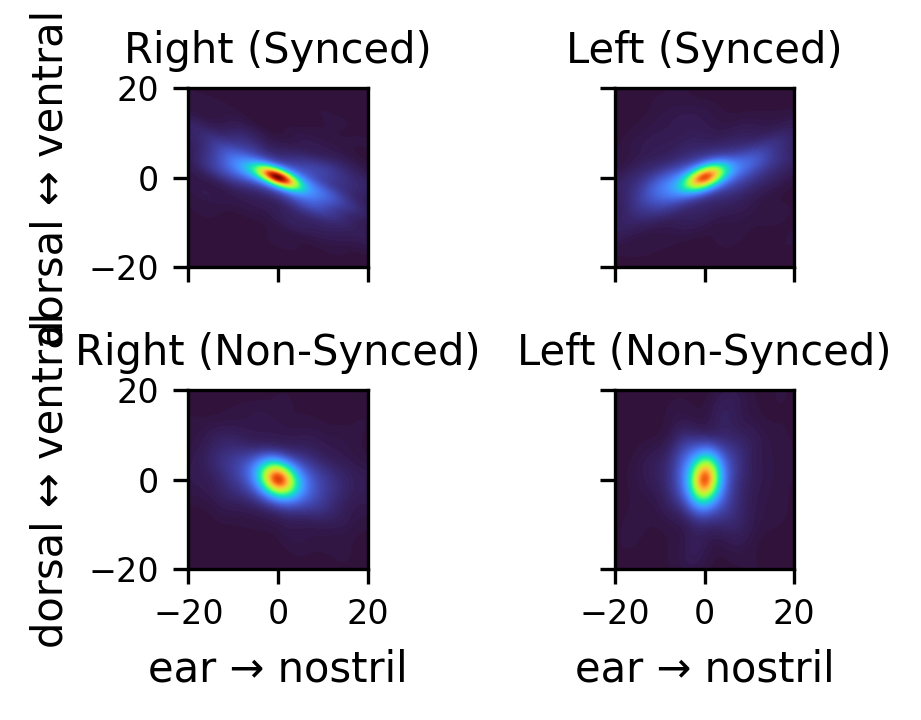

In [42]:
import re, json
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, Tuple, List, Optional

# ---------------- math helpers ----------------
def _wrap180(x_deg: float) -> float:
    return ((x_deg + 180.0) % 360.0) - 180.0

def _minimal_axis_lock_rotation(candidate_deg: float) -> float:
    """
    Axis equivalence: 0° ≡ 180°. Choose smallest-magnitude representative.
    Fold into [-90, +90).
    """
    alts = [candidate_deg, candidate_deg + 180.0, candidate_deg - 180.0]
    best = min(alts, key=lambda ang: abs(_wrap180(ang)))
    best = _wrap180(best)
    if abs(best) > 90.0:
        best = best - 180.0 * np.sign(best)
    return float(best)

def _quat_from_R(R: np.ndarray) -> np.ndarray:
    """3x3 rotation matrix -> unit quaternion (w,x,y,z), robust."""
    R = np.asarray(R, dtype=float)
    t = np.trace(R)
    if t > 0:
        s = np.sqrt(t + 1.0) * 2.0
        w = 0.25 * s
        x = (R[2,1] - R[1,2]) / s
        y = (R[0,2] - R[2,0]) / s
        z = (R[1,0] - R[0,1]) / s
    else:
        i = int(np.argmax([R[0,0], R[1,1], R[2,2]]))
        if i == 0:
            s = np.sqrt(1.0 + R[0,0] - R[1,1] - R[2,2]) * 2.0
            w = (R[2,1] - R[1,2]) / s; x = 0.25 * s
            y = (R[0,1] + R[1,0]) / s; z = (R[0,2] + R[2,0]) / s
        elif i == 1:
            s = np.sqrt(1.0 - R[0,0] + R[1,1] - R[2,2]) * 2.0
            w = (R[0,2] - R[2,0]) / s; x = (R[0,1] + R[1,0]) / s
            y = 0.25 * s;             z = (R[1,2] + R[2,1]) / s
        else:
            s = np.sqrt(1.0 - R[0,0] - R[1,1] + R[2,2]) * 2.0
            w = (R[1,0] - R[0,1]) / s; x = (R[0,2] + R[2,0]) / s
            y = (R[1,2] + R[2,1]) / s; z = 0.25 * s
    q = np.array([w, x, y, z], dtype=float)
    return q / np.linalg.norm(q)

def _twist_about_axis_deg(R: np.ndarray, axis_unit: np.ndarray) -> float:
    """
    Swing–twist decomposition: signed twist angle (deg) about axis_unit (right-hand rule).
    """
    q = _quat_from_R(R)
    w, v = q[0], q[1:]
    n = axis_unit / (np.linalg.norm(axis_unit) or 1.0)
    v_par = n * np.dot(v, n)
    q_tw = np.concatenate([[w], v_par])
    nrm = np.linalg.norm(q_tw)
    if nrm < 1e-12:
        return 0.0
    q_tw /= nrm
    ang = 2.0 * np.arctan2(np.linalg.norm(q_tw[1:]), q_tw[0])
    sign = np.sign(np.dot(v, n)) if np.linalg.norm(v_par) > 1e-12 else 1.0
    return float(np.degrees(ang) * sign)

# ---------------- I/O helpers for your layout ----------------
def _animal_from_folder(folder_name: str) -> Optional[str]:
    """
    Extract 'PV_###' from '<PV_###>_registration' folder names.
    """
    m = re.fullmatch(r'(PV_\d{2,3})_registration', folder_name)
    return m.group(1) if m else None

def discover_animals_under_root(root: Path) -> List[str]:
    """
    Scan root for folders named 'PV_###_registration' and return ['PV_###', ...].
    """
    animals = []
    for p in root.iterdir():
        if p.is_dir():
            a = _animal_from_folder(p.name)
            if a:
                animals.append(a)
    animals.sort()
    return animals

def _paths_for_animal(root: Path, animal: str) -> Dict[str, Dict[str, Path]]:
    """
    Build the exact file paths per your convention.

    Returns:
      {
        'L': {'rot': Path, 'normals': Path},
        'R': {'rot': Path, 'normals': Path}
      }
    """
    base = root / f"{animal}_registration"
    paths = {
        'L': {
            'rot':     base / "l_rot_matrix_v14.json",
            'normals': base / "l_normals_v14.json",
        },
        'R': {
            'rot':     base / "r_rot_matrix_v14.json",
            'normals': base / "r_normals_v14.json",
        }
    }
    return paths

def _load_rot_and_nref(rot_path: Path, normals_path: Path):
    R = np.array(json.loads(rot_path.read_text()), dtype=float).reshape(3,3)
    d = json.loads(normals_path.read_text())
    n_ref = np.array(d['n_ref'], dtype=float)
    n_ref = n_ref / (np.linalg.norm(n_ref) or 1.0)
    return R, n_ref

# ---------------- main catalog builder for your layout ----------------
def build_blender_roll_catalog_from_registration(
    root: Path,
    animals: Optional[List[str]] = None,
    verbose: bool = True,
) -> Dict[Tuple[str, str], float]:
    """
    Build {(animal,'L'|'R'): roll_deg_axis_min} using the fixed path layout:
      <root>/<animal>_registration/l_rot_matrix_v14.json, l_normals_v14.json, ...
    If animals is None, animals are discovered from folder names under root.
    """
    if animals is None:
        animals = discover_animals_under_root(root)
        if verbose:
            print(f"Discovered animals: {animals}")

    catalog: Dict[Tuple[str,str], float] = {}
    for animal in animals:
        files = _paths_for_animal(root, animal)
        for eye in ('L', 'R'):
            rot_p, nrm_p = files[eye]['rot'], files[eye]['normals']
            if not rot_p.exists() or not nrm_p.exists():
                if verbose:
                    print(f"[MISS] {animal} {eye}: missing files "
                          f"({rot_p.name if rot_p.exists() else 'NO rot'}, "
                          f"{nrm_p.name if nrm_p.exists() else 'NO normals'})")
                continue
            try:
                R, n_ref = _load_rot_and_nref(rot_p, nrm_p)
                roll_raw = _twist_about_axis_deg(R, n_ref)             # signed twist about n_ref
                roll_axis_min = _minimal_axis_lock_rotation(roll_raw)  # fold to axis measure [-90,+90)
                catalog[(animal, eye)] = float(roll_axis_min)
                if verbose:
                    print(f"[OK] {animal} {eye}: raw={roll_raw:+.2f}°, axis_min={roll_axis_min:+.2f}°")
            except Exception as e:
                if verbose:
                    print(f"[ERR] {animal} {eye}: {e}")
    return catalog
def plot_saccade_heatmaps_comparison_trajectories(
    synced_saccades, non_synced_saccades, block_dict,
    export_path=None, nbins=200,
    global_min=-25, global_max=25,
    cmap=plt.cm.turbo, figsize=(4, 2.5),
    rotation_catalog=None   # {(animal,'L'|'R'): rotation_deg}; optional
):
    """
    Same behavior as your latest version, but trajectories are rotated per-eye by
    the Blender-registered angle so that +X ≈ ear→nostril and +Y ≈ dorsal.
    Angles are degrees; positive means CCW rotation of image coordinates.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    import os, datetime, pickle, tqdm

    # ---------- helpers ----------
    def _deg2rad(d):
        return np.deg2rad(d)

    def _rotate2d(x, y, deg):
        """Rotate (x,y) by +deg (CCW). Works with numpy arrays."""
        if x.size == 0:
            return x, y
        th = _deg2rad(deg)
        c, s = np.cos(th), np.sin(th)
        xr = c * x - s * y
        yr = s * x + c * y
        return xr, yr

    def _per_eye_rotation(animal, eye):
        """Fetch per-eye rotation in degrees; 0 if catalog not provided/missing."""
        if rotation_catalog is None:
            return 0.0
        return float(rotation_catalog.get((animal, eye), 0.0))

    # ---------- core ----------
    def extract_zeroed_points(saccades_df, eye):
        xs, ys = [], []
        df_eye = saccades_df[saccades_df['eye'] == eye]
        for _, row in tqdm.tqdm(df_eye.iterrows(), total=len(df_eye), desc=f"Collect {eye}"):
            block_num = row['block']
            start_ms  = row['saccade_on_ms']
            end_ms    = row['saccade_off_ms']
            block_key = f"{row['animal']}_block_{block_num}"
            if block_key not in block_dict:
                continue
            block = block_dict[block_key]
            eye_df = block.left_eye_data if eye == 'L' else block.right_eye_data if eye == 'R' else None
            if eye_df is None:
                continue

            traj = eye_df[(eye_df['ms_axis'] >= start_ms) & (eye_df['ms_axis'] <= end_ms)]
            if traj.empty:
                continue

            # zero at onset
            x0 = traj['center_x'].iloc[0]
            y0 = traj['center_y'].iloc[0]
            dx = (traj['center_x'] - x0).to_numpy(dtype=float)
            dy = (traj['center_y'] - y0).to_numpy(dtype=float)

            # per-eye rotation (deg) from Blender registration
            rot_deg = _per_eye_rotation(row['animal'], eye)
            if rot_deg != 0.0:
                dx, dy = _rotate2d(dx, dy, rot_deg)

            xs.extend(dx.tolist())
            ys.extend(dy.tolist())
        return np.asarray(xs, dtype=float), np.asarray(ys, dtype=float)

    # Extract zeroed & rotated trajectory points
    r_x_synced, r_y_synced = extract_zeroed_points(synced_saccades, 'R')
    l_x_synced, l_y_synced = extract_zeroed_points(synced_saccades, 'L')
    r_x_ns,    r_y_ns      = extract_zeroed_points(non_synced_saccades, 'R')
    l_x_ns,    l_y_ns      = extract_zeroed_points(non_synced_saccades, 'L')

    def evaluate_kde(x, y):
        if len(x) == 0 or len(y) == 0:
            return None, None, None
        k  = gaussian_kde(np.vstack([x, y]).astype(float))
        xi, yi = np.mgrid[global_min:global_max:nbins*1j,
                          global_min:global_max:nbins*1j]
        zi = k(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
        zi /= np.sum(zi)
        return xi, yi, zi

    # KDEs
    xi_r_s, yi_r_s, zi_r_s = evaluate_kde(r_x_synced, r_y_synced)
    xi_l_s, yi_l_s, zi_l_s = evaluate_kde(l_x_synced, l_y_synced)
    xi_r_ns, yi_r_ns, zi_r_ns = evaluate_kde(r_x_ns, r_y_ns)
    xi_l_ns, yi_l_ns, zi_l_ns = evaluate_kde(l_x_ns, l_y_ns)

    # Shared color scale
    all_zi = [z for z in [zi_r_s, zi_l_s, zi_r_ns, zi_l_ns] if z is not None]
    vmin, vmax = (min(z.min() for z in all_zi), max(z.max() for z in all_zi)) if all_zi else (0, 1)

    # Figure
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize, dpi=300, sharey=True, sharex=True)

    def plot_heatmap(ax, xi, yi, zi, title):
        if zi is not None:
            im = ax.imshow(
                zi.T,
                extent=[global_min, global_max, global_min, global_max],
                origin='lower', cmap=cmap, vmin=vmin, vmax=vmax
            )
        else:
            im = None
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=8, transform=ax.transAxes)
        ax.set_title(title, fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_aspect('equal', 'box')
        return im

    im1 = plot_heatmap(axes[0, 0], xi_r_s,  yi_r_s,  zi_r_s,  'Right (Synced)')
    im2 = plot_heatmap(axes[0, 1], xi_l_s,  yi_l_s,  zi_l_s,  'Left (Synced)')
    im3 = plot_heatmap(axes[1, 0], xi_r_ns, yi_r_ns, zi_r_ns, 'Right (Non-Synced)')
    im4 = plot_heatmap(axes[1, 1], xi_l_ns, yi_l_ns, zi_l_ns, 'Left (Non-Synced)')

    # Label axes to reflect anatomical frame
    axes[1,0].set_xlabel("ear → nostril")
    axes[1,1].set_xlabel("ear → nostril")
    axes[0,0].set_ylabel("dorsal ↔ ventral")
    axes[1,0].set_ylabel("dorsal ↔ ventral")

    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # Export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_heatmaps_trajectories_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_heatmaps_comparison_trajectories.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_trajectories_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({
                'synced': {'R': (r_x_synced, r_y_synced), 'L': (l_x_synced, l_y_synced)},
                'non_synced': {'R': (r_x_ns, r_y_ns), 'L': (l_x_ns, l_y_ns)},
                'rotation_catalog': rotation_catalog
            }, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()

# catalog_blender should be {(animal,'R'): deg, (animal,'L'): deg}
# e.g., from your JSON loader
from pathlib import Path

root = Path(r"D:\MarkS3\Documents\BlenderFiles\Camera_angle_registration")

# Option A: auto-discover animals from folder names like 'PV_62_registration'
catalog_blender = build_blender_roll_catalog_from_registration(root, animals=None, verbose=True)

plot_saccade_heatmaps_comparison_trajectories(
    synced_saccade_collection.query('animal=="PV_143"'),
    non_synced_saccade_collection.query('animal=="PV_143"'),
    block_dict,
    export_path=None,
    nbins=200, global_min=-20, global_max=20,
    cmap=plt.cm.turbo, figsize=(4, 2.5),
    rotation_catalog=catalog_blender   # <-- add this
)

In [31]:
# monocular saccade graph:
import os
import pathlib
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle


def process_profile(profile, expected_length):
    """
    Adjusts a profile to the expected length by either padding or snipping.
    """
    current_length = len(profile)

    if current_length == expected_length:
        return profile

    # Snip or pad to match the expected length
    if current_length > expected_length:
        excess = (current_length - expected_length) // 2
        return profile[excess:excess + expected_length]
    else:
        pad_before = (expected_length - current_length) // 2
        pad_after = expected_length - current_length - pad_before
        return np.pad(profile, (pad_before, pad_after), constant_values=np.nan)


def average_saccade_profile(non_synced_saccade_collection, block_dict, window_ms=200, sampling_rate=60,
                            export_path=None):
    half_window = window_ms // 2
    expected_length = int((window_ms / 1000) * sampling_rate)
    time_axis = (np.arange(expected_length) * 1000 / sampling_rate) - half_window

    saccade_profiles = []
    opposite_eye_profiles = []

    for _, row in non_synced_saccade_collection.iterrows():
        block_num = row['block']
        eye = row['eye']
        start_ts = row['saccade_on_ms']
        opposite_eye = 'L' if eye == 'R' else 'R'

        block_key = f"{row['animal']}_block_{block_num}"
        if block_key not in block_dict:
            continue

        block = block_dict[block_key]
        current_eye_data = block.left_eye_data if eye == 'L' else block.right_eye_data
        opposite_eye_data = block.left_eye_data if opposite_eye == 'L' else block.right_eye_data

        saccade_profile = current_eye_data.query(
            'ms_axis >= @start_ts - @half_window and ms_axis <= @start_ts + @half_window')['speed_r'].values
        opposite_profile = opposite_eye_data.query(
            'ms_axis >= @start_ts - @half_window and ms_axis <= @start_ts + @half_window')['speed_r'].values

        if len(saccade_profile) == 0 or len(opposite_profile) == 0:
            print(f"Skipped saccade at {start_ts} due to missing data.")
            continue

        # Ensure fixed length through padding or snipping
        saccade_profiles.append(process_profile(saccade_profile, expected_length))
        opposite_eye_profiles.append(process_profile(opposite_profile, expected_length))

    if not saccade_profiles or not opposite_eye_profiles:
        print("No valid saccade profiles found.")
        return None, None

    avg_saccade = np.nanmean(np.vstack(saccade_profiles), axis=0)
    avg_opposite_eye = np.nanmean(np.vstack(opposite_eye_profiles), axis=0)

    # Plot the results
    fig, ax = plt.subplots(figsize=(1.7, 1.2), dpi=100)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.tick_params(axis='both', which='major', length=5, color='black')
    ax.ticklabel_format(axis='y', style='plain')
    ax.set_ylabel("Speed (pixels/ms)", fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    ax.plot(time_axis, avg_saccade, label="Monocular Saccade", color='g')
    ax.plot(time_axis, avg_opposite_eye, label="Opposite Eye", color='b')
    ax.set_title("Average Saccade Profiles")
    ax.set_xlabel("Time (ms)")
    ax.legend(loc='center left', bbox_to_anchor=(0.6, 0.8), fontsize=6)
    plt.show()

    # Save results
    if export_path:
        t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_dir = pathlib.Path(export_path) / f"Saccade_Profile_{t}"
        os.makedirs(export_dir, exist_ok=True)

        pdf_path = export_dir / "average_saccade_profiles.pdf"
        fig.savefig(pdf_path, format='pdf', bbox_inches='tight')

        data_dict = {
            'time_axis': time_axis,
            'avg_saccade': avg_saccade,
            'avg_opposite_eye': avg_opposite_eye,
            'saccade_collection': non_synced_saccade_collection
        }
        pickle_path = export_dir / "saccade_profiles.pkl"
        with open(pickle_path, "wb") as f:
            pickle.dump(data_dict, f)
        print(f"Data saved to {export_dir}")

    return saccade_profiles, opposite_eye_profiles




37750it [01:05, 573.13it/s] 
<ipython-input-76-3240c26ddd47>:156: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig2.colorbar(sm, orientation='vertical')
<ipython-input-76-3240c26ddd47>:159: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


Number of data points: 23987


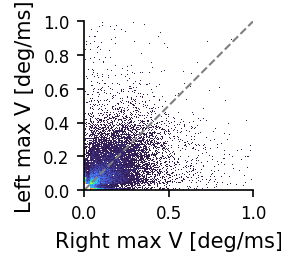

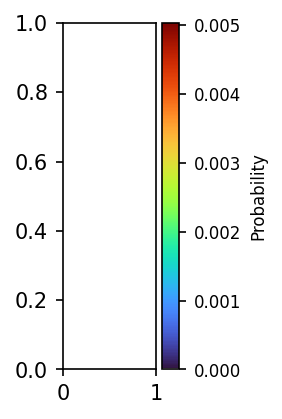

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pathlib
import tqdm
import pickle
import datetime
import pandas as pd  # Assuming pandas is imported as well

def plot_right_vs_left_eye_hist2d(all_saccade_collection, block_dict, export_path=None,
                                  iqr_multiplier=1.5, bins=100, sync_diff_threshold=31, value_range=(0,2)):
    """
    Plots a 2D probability histogram (normalized so that the sum of all bins is 1) where the x-axis
    represents the right eye's max speed and the y-axis represents the left eye's max speed.
    Uses a custom colormap based on 'turbo' (with only the 0 value set to white) and applies a robust
    exclusion rule so that saccades that are within sync_diff_threshold of a previously processed saccade
    (for the same animal and block) are excluded.

    The axes are kept equal and the colorbar is saved to a separate PDF.

    Parameters:
        all_saccade_collection (pd.DataFrame): DataFrame containing detected saccades.
        block_dict (dict): Dictionary mapping block keys to block objects with eye data.
        export_path (str or pathlib.Path, optional): Path to save the plot and colorbar PDFs.
        iqr_multiplier (float): Multiplier for the interquartile range (IQR) in outlier detection.
        bins (int): Number of bins to use for both x and y directions in the histogram.
        sync_diff_threshold (float): Time difference threshold to consider saccades synchronized
                                       (in the same units as 'saccade_on_ms').
    """
    right_eye_speeds = []
    left_eye_speeds = []

    # Dictionary to track processed saccades for each (animal, block).
    # Keys are (animal, block) and values are lists of saccade timestamps already used.
    processed_events = {}

    # Loop through each saccade entry.
    for _, row in tqdm.tqdm(all_saccade_collection.iterrows()):
        key = (row['animal'], row['block'])
        current_timestamp = row['saccade_on_ms']

        # Check if a saccade for this (animal, block) has already been processed
        # within sync_diff_threshold.
        if key in processed_events:
            if any(abs(current_timestamp - ts) < sync_diff_threshold for ts in processed_events[key]):
                continue  # Skip as this saccade is considered synchronized with a previous one.
            else:
                processed_events[key].append(current_timestamp)
        else:
            processed_events[key] = [current_timestamp]

        block_key = f"{row['animal']}_block_{row['block']}"
        if block_key not in block_dict:
            continue

        block = block_dict[block_key]

        # Get contralateral eye's data based on which eye was detected.
        if row['eye'] == 'L':
            contralateral_eye_speed_profile = block.right_eye_data.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        elif row['eye'] == 'R':
            contralateral_eye_speed_profile = block.left_eye_data.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        else:
            continue

        # Compute the maximum speeds (scaling as in the original function)
        max_detected = np.nanmax(row['speed_profile_angular'] / 17) if len(row['speed_profile_angular']) > 0 else np.nan
        max_contralateral = (np.nanmax(contralateral_eye_speed_profile.values / 17)
                             if contralateral_eye_speed_profile.notna().sum() > 0 else np.nan)

        # Append valid pairs.
        if not np.isnan(max_detected) and not np.isnan(max_contralateral):
            if row['eye'] == 'L':
                left_eye_speeds.append(max_detected)
                right_eye_speeds.append(max_contralateral)
            elif row['eye'] == 'R':
                right_eye_speeds.append(max_detected)
                left_eye_speeds.append(max_contralateral)

    # Convert lists to NumPy arrays.
    right_eye_speeds = np.array(right_eye_speeds)
    left_eye_speeds = np.array(left_eye_speeds)
    print("Number of data points:", len(right_eye_speeds))

    # Outlier removal using IQR on the combined speeds.
    all_speeds = np.concatenate([right_eye_speeds, left_eye_speeds])
    q1, q3 = np.percentile(all_speeds, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    valid_indices = ((right_eye_speeds >= lower_bound) & (right_eye_speeds <= upper_bound) &
                     (left_eye_speeds >= lower_bound) & (left_eye_speeds <= upper_bound))
    right_eye_speeds = right_eye_speeds[valid_indices]
    left_eye_speeds = left_eye_speeds[valid_indices]

    # Fixed axis limits.
    min_value = value_range[0]
    max_value = value_range[1]

    # Create the custom turbo colormap: get a discrete version of turbo and replace the first color with white.
    n_colors = 256
    turbo = plt.get_cmap('turbo', n_colors)
    turbo_colors = turbo(np.linspace(0, 1, n_colors))
    turbo_colors[0] = np.array([1, 1, 1, 1])  # Set the lowest count (0 probability) to perfect white.
    custom_turbo = mcolors.ListedColormap(turbo_colors)

    # Prepare the figure for the histogram.
    fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
    xbins = np.linspace(min_value, max_value, bins)
    ybins = np.linspace(min_value, max_value, bins)

    # Compute the 2D histogram manually.
    counts, xedges, yedges = np.histogram2d(right_eye_speeds, left_eye_speeds, bins=[xbins, ybins])
    normalized_counts = counts / counts.sum()  # Normalize so that the overall sum equals 1.

    # Plot the normalized histogram using pcolormesh.
    pc = ax.pcolormesh(xedges, yedges, normalized_counts.T, cmap=custom_turbo,
                         vmin=0, vmax=normalized_counts.max())

    # Ensure equal axes.
    ax.set_aspect('equal', 'box')
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)

    # Add a diagonal reference line.
    ax.plot([min_value, max_value], [min_value, max_value], linestyle='--', color='gray', linewidth=1)

    # Set axis labels.
    ax.set_xlabel("Right max V [deg/ms]", fontsize=10)
    ax.set_ylabel("Left max V [deg/ms]", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)
    plt.tight_layout()

    # Save the histogram plot if export_path is provided.
    if export_path:
        export_dir = pathlib.Path(export_path)
        export_dir.mkdir(parents=True, exist_ok=True)
        hist_pdf_path = export_dir / "right_vs_left_hist2d.pdf"
        fig.savefig(hist_pdf_path, format='pdf', bbox_inches='tight')
        print(f"2D histogram saved to {hist_pdf_path}")

    # Create a separate figure for the colorbar.
    vmin_val = 0
    vmax_val = normalized_counts.max()
    sm = plt.cm.ScalarMappable(cmap=custom_turbo, norm=plt.Normalize(vmin=vmin_val, vmax=vmax_val))
    sm.set_array([])
    fig2 = plt.figure(figsize=(1, 3), dpi=150)
    cbar = fig2.colorbar(sm, orientation='vertical')
    cbar.set_label("Probability", fontsize=8)
    cbar.ax.tick_params(labelsize=8)
    plt.tight_layout()

    # Save the colorbar to a separate PDF if export_path is provided.
    if export_path:
        cbar_pdf_path = export_dir / "right_vs_left_colorbar.pdf"
        fig2.savefig(cbar_pdf_path, format='pdf', bbox_inches='tight')
        print(f"Colorbar saved to {cbar_pdf_path}")

    plt.show()


t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\{t}'
plot_right_vs_left_eye_hist2d(all_saccade_collection, block_dict, export_path=None, iqr_multiplier=200, bins=200,value_range=(0,1))


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pathlib
import tqdm
import pandas as pd
import datetime

plt.style.use('default')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype']  = 42

def plot_right_vs_left_eye_hist2d_twopanels(
    all_saccade_collection, block_dict, export_path=None,
    iqr_multiplier=1.5, bins=100,
    macro_range=(0, 2.0), micro_range=(0, 0.25),
    macro_n_ticks=6, micro_n_ticks=6,
    macro_tick_list=None, micro_tick_list=None,
    # --- new controls ---
    event_mode="all",                   # "all" | "monocular" | "binocular"
    pair_merge_ms=60,                   # collapse L/R duplicate binocular pairs
    contra_event_window_ms=60,          # classify binocular if contra onset within ±this of ipsi onset
    contra_sample_ms=51,                # window to compute contra max (visualization only)
    frame_period_local=True             # robust per-event frame period or global median
):
    """
    Two-panel 2D histograms of Right vs Left peak angular speed (deg/ms).
    Key improvements:
      * Monocular/binocular classification uses contra-eye saccade tables.
      * Optional merging of duplicate binocular L/R pairs to remove diagonal ridge.
      * Contra peak is only sampled after the event-mode filter.
    """

    # -------- helpers --------
    def estimate_frame_period_ms(eye_df, t_ms):
        if not frame_period_local:
            diffs_global = np.diff(eye_df['ms_axis'].values)
            fp_global = np.nanmedian(diffs_global[np.isfinite(diffs_global)])
            return fp_global if (np.isfinite(fp_global) and fp_global > 0) else 17.0
        try:
            window = eye_df.query('ms_axis >= @t_ms - 51 and ms_axis <= @t_ms + 51')['ms_axis'].values
            if window.size >= 3:
                diffs = np.diff(np.sort(window))
                fp = np.nanmedian(diffs)
                if np.isfinite(fp) and fp > 0:
                    return fp
        except Exception:
            pass
        diffs_global = np.diff(eye_df['ms_axis'].values)
        fp_global = np.nanmedian(diffs_global[np.isfinite(diffs_global)])
        return fp_global if (np.isfinite(fp_global) and fp_global > 0) else 17.0

    def contra_has_event(block, eye, t_ms, win_ms):
        if eye == 'L':
            sdf = getattr(block, 'r_saccade_df', None)
        else:
            sdf = getattr(block, 'l_saccade_df', None)
        if sdf is None or 'saccade_on_ms' not in sdf.columns:
            return False, np.nan
        # nearest contra onset
        idx = np.argmin(np.abs(sdf['saccade_on_ms'].values - t_ms)) if len(sdf) else None
        if idx is None: return False, np.nan
        nearest = sdf['saccade_on_ms'].values[idx]
        return (abs(nearest - t_ms) <= win_ms), nearest

    def sample_contra_peak(contra_df, t_ms, halfwin_ms, frame_ms):
        series = contra_df.query('ms_axis >= @t_ms - @halfwin_ms and ms_axis <= @t_ms + @halfwin_ms')['angular_speed_r']
        if series.notna().sum() == 0:
            return np.nan
        return float(np.nanmax(series.values)) / frame_ms  # deg/frame -> deg/ms

    # -------- collect points --------
    right_eye_speeds, left_eye_speeds, animals_for_weights = [], [], []
    # For binocular de-duplication
    seen_pairs = set()

    # IMPORTANT: work on a copy to avoid chained assignment surprises
    rows = all_saccade_collection.copy()

    for _, row in tqdm.tqdm(rows.iterrows(), total=len(rows)):
        # Block lookup
        block_key = f"{row['animal']}_block_{row['block']}"
        block = block_dict.get(block_key, None)
        if block is None:
            continue

        eye = row['eye']
        t0 = float(row['saccade_on_ms'])

        # choose ipsi/contra dataframes
        if eye == 'L':
            ipsi_df, contra_df = block.left_eye_data, block.right_eye_data
        elif eye == 'R':
            ipsi_df, contra_df = block.right_eye_data, block.left_eye_data
        else:
            continue

        # classify event by contra saccade table
        is_binocular, contra_t = contra_has_event(block, eye, t0, contra_event_window_ms)
        if event_mode == "monocular" and is_binocular:
            continue
        if event_mode == "binocular" and not is_binocular:
            continue

        # collapse duplicate binocular L/R pairs (keep earliest onset)
        if is_binocular and pair_merge_ms is not None:
            # build a symmetric key independent of which eye we iterate
            # quantize time to pair_merge_ms to be robust to tiny jitter
            q = int(round(t0 / pair_merge_ms))
            pair_key = (row['animal'], row['block'], q)
            if pair_key in seen_pairs:
                continue
            seen_pairs.add(pair_key)

        # robust frame period
        frame_ms = estimate_frame_period_ms(ipsi_df, t0)

        # ipsi peak from its stored profile (deg/frame -> deg/ms)
        sp = row.get('speed_profile_angular', None)
        if sp is None or len(sp) == 0 or not np.isfinite(np.nanmax(sp)):
            continue
        ipsi_peak = float(np.nanmax(sp)) / frame_ms

        # contra peak only for visualization
        contra_peak = sample_contra_peak(contra_df, t0, contra_sample_ms, frame_ms)
        if not np.isfinite(contra_peak):
            continue

        if eye == 'L':
            left_eye_speeds.append(ipsi_peak)
            right_eye_speeds.append(contra_peak)
        else:
            right_eye_speeds.append(ipsi_peak)
            left_eye_speeds.append(contra_peak)
        animals_for_weights.append(row['animal'])

    right_eye_speeds = np.asarray(right_eye_speeds, float)
    left_eye_speeds  = np.asarray(left_eye_speeds,  float)
    animals_for_weights = np.asarray(animals_for_weights)

    print("Points kept:", len(right_eye_speeds))
    if len(right_eye_speeds) == 0:
        print("No valid data to plot.")
        return

    # -------- equal-animal weighting --------
    if animals_for_weights.size:
        u, c = np.unique(animals_for_weights, return_counts=True)
        w = {a: 1.0 / cnt for a, cnt in zip(u, c)}
        weights = np.array([w[a] for a in animals_for_weights], float)
        weights *= (len(weights) / np.sum(weights))
    else:
        weights = None

    # -------- IQR filter (per-eye) --------
    def iqr_bounds(arr, mult):
        q1, q3 = np.percentile(arr, [25, 75]); iqr = q3 - q1
        return q1 - mult * iqr, q3 + mult * iqr
    r_low, r_high = iqr_bounds(right_eye_speeds, iqr_multiplier)
    l_low, l_high = iqr_bounds(left_eye_speeds,  iqr_multiplier)
    keep = (right_eye_speeds >= r_low) & (right_eye_speeds <= r_high) & \
           (left_eye_speeds  >= l_low) & (left_eye_speeds  <= l_high)
    right_eye_speeds, left_eye_speeds = right_eye_speeds[keep], left_eye_speeds[keep]
    if weights is not None:
        weights = weights[keep]

    # -------- colormap with white at zero --------
    turbo = plt.get_cmap('turbo', 256)
    turbo_colors = turbo(np.linspace(0, 1, 256)); turbo_colors[0] = np.array([1, 1, 1, 1])
    custom_turbo = mcolors.ListedColormap(turbo_colors)

    fig, axs = plt.subplots(1, 2, figsize=(3, 1.7), dpi=300, constrained_layout=True)
    vmax_all = 0.0

    for ax, rng, title, n_ticks, tick_list in zip(
        axs,
        [macro_range, micro_range],
        ["Macro", "Micro"],
        [macro_n_ticks, micro_n_ticks],
        [macro_tick_list, micro_tick_list]
    ):
        minv, maxv = rng
        xbins = np.linspace(minv, maxv, bins)
        ybins = np.linspace(minv, maxv, bins)
        counts, xedges, yedges = np.histogram2d(
            right_eye_speeds, left_eye_speeds, bins=[xbins, ybins], weights=weights
        )
        norm_counts = counts / counts.sum() if counts.sum() > 0 else counts
        vmax_panel = norm_counts.max() if norm_counts.size else 1.0
        vmax_all = max(vmax_all, float(vmax_panel))

        ax.pcolormesh(xedges, yedges, norm_counts.T, cmap=custom_turbo,
                      vmin=0, vmax=vmax_panel, shading='auto')

        ax.set_box_aspect(1)
        ax.set_xlim(minv, maxv); ax.set_ylim(minv, maxv)

        if tick_list is not None:
            ax.set_xticks(tick_list); ax.set_yticks(tick_list)
        else:
            ticks = np.linspace(minv, maxv, n_ticks)
            ax.set_xticks(ticks); ax.set_yticks(ticks)

        ax.plot([minv, maxv], [minv, maxv], ls='--', color='gray', lw=1)
        ax.set_title(title, fontsize=8)
        ax.tick_params(axis='both', labelsize=7)
        ax.set_xlabel("Right max V [deg/ms]", fontsize=9)
        ax.set_ylabel("Left max V [deg/ms]", fontsize=9)
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        ax.grid(False)

    # Export
    export_dir = None
    if export_path:
        export_dir = pathlib.Path(export_path); export_dir.mkdir(parents=True, exist_ok=True)
        fig.savefig(export_dir / "right_vs_left_twopanels_clean.pdf", bbox_inches='tight')
        print("Saved two-panel figure to", export_dir)

    # standalone colorbar
    sm = plt.cm.ScalarMappable(cmap=custom_turbo,
                               norm=plt.Normalize(vmin=0, vmax=vmax_all if vmax_all > 0 else 1))
    sm.set_array([])
    fig_cbar = plt.figure(figsize=(1.2, 3.2), dpi=150)
    cax = fig_cbar.add_axes([0.35, 0.1, 0.2, 0.8])
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_label("Probability", fontsize=8)
    cbar.ax.tick_params(labelsize=8)

    if export_dir is not None:

        fig_cbar.savefig(export_dir / "right_vs_left_twopanels_colormap.pdf", bbox_inches='tight')
        print("Saved standalone colorbar to", export_dir)

    plt.show()
    return fig, axs


In [38]:
#percent of movements involving head:
total = len(all_saccade_collection)
head_mov = len(all_saccade_collection.query('head_movement==True'))
stationary = len(all_saccade_collection.query('head_movement==False'))
nan_mov = len(all_saccade_collection.query('head_movement!=head_movement'))

real_total = total - nan_mov

print(head_mov/real_total)
print(stationary/real_total)
print((stationary/real_total) + (head_mov/real_total))
print(real_total - stationary - head_mov)

0.5728707594547504
0.4271292405452496
1.0
0


100%|██████████| 4645/4645 [00:08<00:00, 537.21it/s]


Points kept: 1329
Saved two-panel figure to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\2025_09_21_02_24
Saved standalone colorbar to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\2025_09_21_02_24


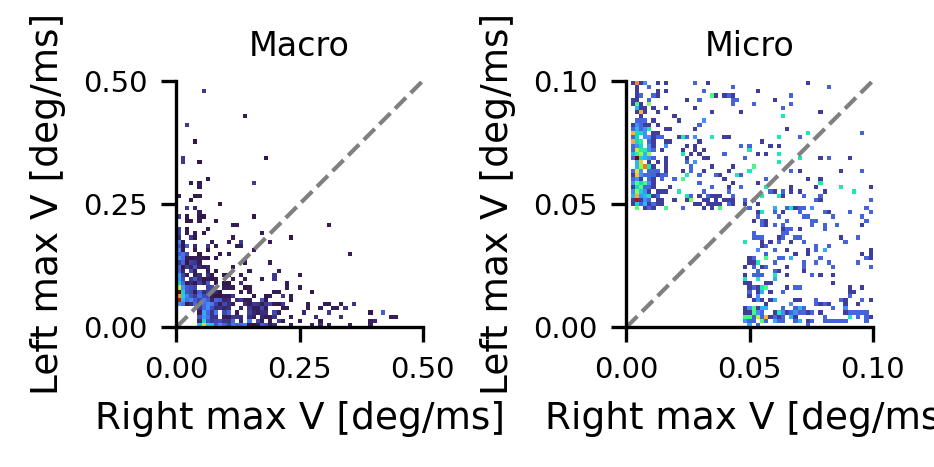

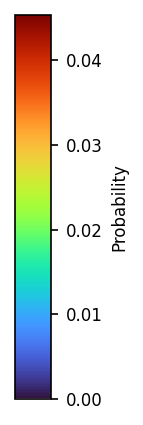

(<Figure size 900x510 with 2 Axes>,
 array([<Axes: title={'center': 'Macro'}, xlabel='Right max V [deg/ms]', ylabel='Left max V [deg/ms]'>,
        <Axes: title={'center': 'Micro'}, xlabel='Right max V [deg/ms]', ylabel='Left max V [deg/ms]'>],
       dtype=object))

In [286]:
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\{t}'
plot_right_vs_left_eye_hist2d_twopanels(
    filtered_saccades.query('head_movement==False and animal !="PV_62"'),
    block_dict,
    export_path=export_path,
    iqr_multiplier=60, bins=60,
    macro_range=(0, 0.5), micro_range=(0, 0.1),
    macro_tick_list=[0,0.25,0.5],
    micro_tick_list=[0,0.05,0.1],
    event_mode="monocular",            # <— only keep events with NO contra onset nearby
    contra_event_window_ms=100,
    contra_sample_ms=51
)


100%|██████████| 7355/7355 [00:13<00:00, 530.09it/s] 


Points kept: 2721


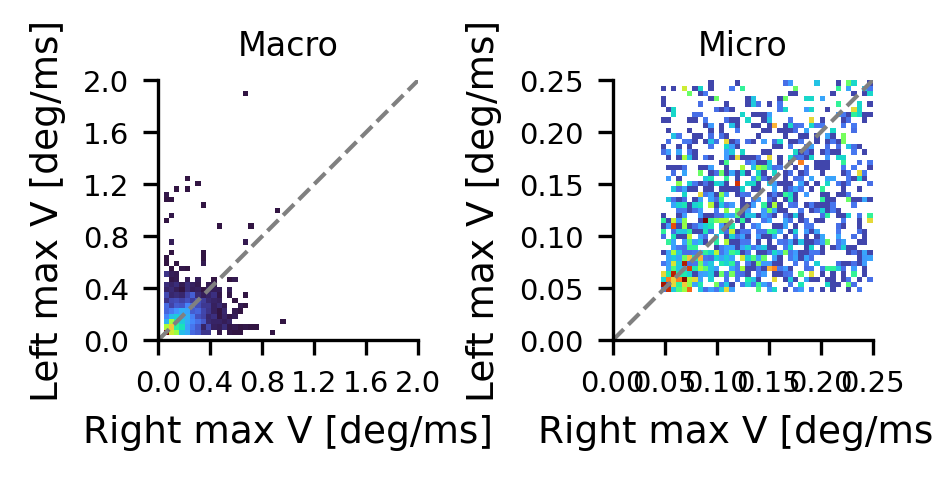

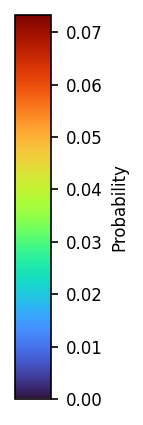

(<Figure size 900x510 with 2 Axes>,
 array([<Axes: title={'center': 'Macro'}, xlabel='Right max V [deg/ms]', ylabel='Left max V [deg/ms]'>,
        <Axes: title={'center': 'Micro'}, xlabel='Right max V [deg/ms]', ylabel='Left max V [deg/ms]'>],
       dtype=object))

In [67]:
plot_right_vs_left_eye_hist2d_twopanels(
    all_saccade_collection.query('head_movement==False'),
    block_dict,
    iqr_multiplier=60, bins=50,
    event_mode="binocular",
    pair_merge_ms=60,                  # <— collapse duplicate L/R pairs
)


In [20]:
#### THIS CELL DUPLICATES SACCADES!!! ####
# currently, the cell goes through synchronized saccades twice! I need to somehow label saccade events with an ID, and have synchronized saccades share that ID - then plot them according to ID and not simply the ms window
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pathlib
import tqdm
import pandas as pd
import datetime
# %matplotlib inline  # keep as you prefer in your notebook
plt.style.use('default')
plt.rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
plt.rcParams['ps.fonttype']  = 42  # Ensure compatibility with vector outputs


def plot_right_vs_left_eye_hist2d_twopanels(
    all_saccade_collection, block_dict, export_path=None,
    iqr_multiplier=1.5, bins=100, sync_diff_threshold=31,
    macro_range=(0, 2.0), micro_range=(0, 0.25),
    macro_n_ticks=6, micro_n_ticks=6,
    macro_tick_list=None, micro_tick_list=None
):
    """
    Two-panel version: side-by-side 2D histograms of Right vs Left peak angular speed.

    Tick control:
      - If macro_tick_list / micro_tick_list are provided, use them directly.
      - Otherwise fall back to evenly spaced ticks (macro_n_ticks / micro_n_ticks).

    Exports: main figure PDF and a standalone colorbar PDF.
    """

    # ---- data extraction (kept from your corrected logic) ----
    right_eye_speeds, left_eye_speeds, animals_for_weights = [], [], []
    processed_events = {}

    def estimate_frame_period_ms(eye_df, t_ms):
        try:
            window = eye_df.query('ms_axis >= @t_ms - 51 and ms_axis <= @t_ms + 51')['ms_axis'].values
            if window.size >= 3:
                diffs = np.diff(np.sort(window))
                fp = np.nanmedian(diffs)
                if np.isfinite(fp) and fp > 0:
                    return fp
        except Exception:
            pass
        diffs_global = np.diff(eye_df['ms_axis'].values)
        fp_global = np.nanmedian(diffs_global[np.isfinite(diffs_global)])
        return fp_global if (np.isfinite(fp_global) and fp_global > 0) else 17.0

    for _, row in tqdm.tqdm(all_saccade_collection.iterrows()):
        key = (row['animal'], row['block'])
        current_timestamp = row['saccade_on_ms']

        if key in processed_events:
            if any(abs(current_timestamp - ts) <= sync_diff_threshold for ts in processed_events[key]):
                continue
            processed_events[key].append(current_timestamp)
        else:
            processed_events[key] = [current_timestamp]

        block_key = f"{row['animal']}_block_{row['block']}"
        if block_key not in block_dict:
            continue
        block = block_dict[block_key]

        if row['eye'] == 'L':
            ipsi_eye_df = block.left_eye_data
            contra_eye_df = block.right_eye_data
            contra_series = contra_eye_df.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        elif row['eye'] == 'R':
            ipsi_eye_df = block.right_eye_data
            contra_eye_df = block.left_eye_data
            contra_series = contra_eye_df.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        else:
            continue

        frame_period_ms = estimate_frame_period_ms(ipsi_eye_df, current_timestamp)
        max_detected = (np.nanmax(row['speed_profile_angular']) / frame_period_ms
                        if len(row['speed_profile_angular']) > 0 else np.nan)
        max_contra = (np.nanmax(contra_series.values) / frame_period_ms
                      if contra_series.notna().sum() > 0 else np.nan)

        if not np.isnan(max_detected) and not np.isnan(max_contra):
            if row['eye'] == 'L':
                left_eye_speeds.append(max_detected); right_eye_speeds.append(max_contra)
            else:
                right_eye_speeds.append(max_detected); left_eye_speeds.append(max_contra)
            animals_for_weights.append(row['animal'])

    right_eye_speeds = np.array(right_eye_speeds, dtype=float)
    left_eye_speeds  = np.array(left_eye_speeds,  dtype=float)
    animals_for_weights = np.array(animals_for_weights)

    print("Number of data points:", len(right_eye_speeds))
    if len(right_eye_speeds) == 0:
        print("No valid data to plot.")
        return

    # Equal animal weighting
    if animals_for_weights.size:
        unique_animals, counts = np.unique(animals_for_weights, return_counts=True)
        inv_count = {a: 1.0 / c for a, c in zip(unique_animals, counts)}
        weights = np.array([inv_count[a] for a in animals_for_weights], dtype=float)
        weights *= (len(weights) / np.sum(weights))
    else:
        weights = None

    # Per-eye IQR filtering
    def iqr_bounds(arr, mult):
        q1, q3 = np.percentile(arr, [25, 75]); iqr = q3 - q1
        return q1 - mult * iqr, q3 + mult * iqr
    r_low, r_high = iqr_bounds(right_eye_speeds, iqr_multiplier)
    l_low, l_high = iqr_bounds(left_eye_speeds,  iqr_multiplier)
    keep = (right_eye_speeds >= r_low) & (right_eye_speeds <= r_high) & \
           (left_eye_speeds  >= l_low) & (left_eye_speeds  <= l_high)
    right_eye_speeds, left_eye_speeds = right_eye_speeds[keep], left_eye_speeds[keep]
    if weights is not None:
        weights = weights[keep]

    # turbo with 0 set to white
    turbo = plt.get_cmap('turbo', 256)
    turbo_colors = turbo(np.linspace(0, 1, 256)); turbo_colors[0] = np.array([1, 1, 1, 1])
    custom_turbo = mcolors.ListedColormap(turbo_colors)

    fig, axs = plt.subplots(1, 2, figsize=(3, 1.7), dpi=300, constrained_layout=True)
    vmax_all = 0.0

    for ax, rng, title, n_ticks, tick_list in zip(
        axs,
        [macro_range, micro_range],
        ["Macro", "Micro"],
        [macro_n_ticks, micro_n_ticks],
        [macro_tick_list, micro_tick_list]
    ):
        minv, maxv = rng
        xbins = np.linspace(minv, maxv, bins)
        ybins = np.linspace(minv, maxv, bins)
        counts, xedges, yedges = np.histogram2d(
            right_eye_speeds, left_eye_speeds, bins=[xbins, ybins], weights=weights
        )
        norm_counts = counts / counts.sum() if counts.sum() > 0 else counts
        vmax_panel = norm_counts.max() if norm_counts.size else 1.0
        vmax_all = max(vmax_all, float(vmax_panel))

        ax.pcolormesh(
            xedges, yedges, norm_counts.T, cmap=custom_turbo,
            vmin=0, vmax=vmax_panel, shading='auto'
        )

        # square, explicit limits
        ax.set_box_aspect(1)
        ax.set_xlim(minv, maxv); ax.set_ylim(minv, maxv)

        # enforce ticks: explicit list if given, else linspace fallback
        if tick_list is not None:
            ax.set_xticks(tick_list)
            ax.set_yticks(tick_list)
        else:
            ticks = np.linspace(minv, maxv, n_ticks)
            ax.set_xticks(ticks)
            ax.set_yticks(ticks)

        # diagonal line
        ax.plot([minv, maxv], [minv, maxv], ls='--', color='gray', lw=1)

        # labels and style
        ax.set_title(title, fontsize=8)
        ax.tick_params(axis='both', labelsize=7)
        if ax is axs[0]:
            ax.set_xlabel("Right max V [deg/ms]", fontsize=9)
            ax.set_ylabel("Left max V [deg/ms]", fontsize=9)
        else:
            ax.set_xlabel("Right [deg/ms]", fontsize=9)
            ax.set_ylabel("Left [deg/ms]", fontsize=9)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(False)

    # Export main figure
    export_dir = None
    if export_path:
        export_dir = pathlib.Path(export_path)
        export_dir.mkdir(parents=True, exist_ok=True)
        fig.savefig(export_dir / "right_vs_left_twopanels_clean.pdf", bbox_inches='tight')
        print("Saved two-panel figure to", export_dir)

    # Standalone colorbar
    sm = plt.cm.ScalarMappable(cmap=custom_turbo,
                               norm=plt.Normalize(vmin=0, vmax=vmax_all if vmax_all > 0 else 1))
    sm.set_array([])
    fig_cbar = plt.figure(figsize=(1.2, 3.2), dpi=150)
    cax = fig_cbar.add_axes([0.35, 0.1, 0.2, 0.8])
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_label("Probability", fontsize=8)
    cbar.ax.tick_params(labelsize=8)

    if export_dir is not None:
        fig_cbar.savefig(export_dir / "right_vs_left_twopanels_colormap.pdf", bbox_inches='tight')
        print("Saved standalone colorbar to", export_dir)

    plt.show()
    return fig, axs

4467it [00:20, 215.01it/s]


Number of data points: 3485
Saved two-panel figure to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\2025_09_13_21_27
Saved standalone colorbar to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\2025_09_13_21_27


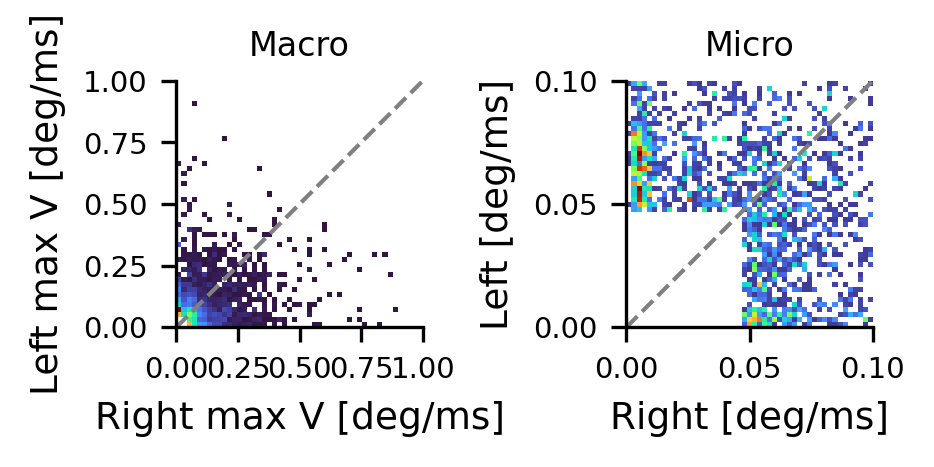

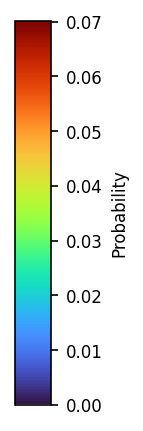

(<Figure size 900x510 with 2 Axes>,
 array([<Axes: title={'center': 'Macro'}, xlabel='Right max V [deg/ms]', ylabel='Left max V [deg/ms]'>,
        <Axes: title={'center': 'Micro'}, xlabel='Right [deg/ms]', ylabel='Left [deg/ms]'>],
       dtype=object))

In [61]:


t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\{t}'

plot_right_vs_left_eye_hist2d_twopanels(
    non_synced_saccade_collection.query('head_movement==False'), block_dict,
    export_path=export_path,
    iqr_multiplier=60, bins=50,
    macro_range=(0, 1), micro_range=(0, 0.1),
    macro_tick_list=[0,0.25,0.5,0.75,1], # adjust if you want more/fewer tick stops
    micro_tick_list=[0,0.05,0.1]
)


In [23]:
# this one with no duplications:
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\{t}'
plot_right_vs_left_eye_hist2d_twopanels(
    all_saccade_collection, block_dict,
    export_path=export_path,
    iqr_multiplier=None, bins=125,
    macro_range=(0, 2.0), micro_range=(0, 0.1),
    macro_tick_list=[0,0.5,1.0,1.5,2.0], # adjust if you want more/fewer tick stops
    micro_tick_list=[0,0.1,0.2]
)


34424it [01:42, 336.11it/s] 

Number of data points: 21517


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

37750it [01:02, 599.77it/s] 


Number of data points: 23987
2D histogram saved to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\2025_08_24_11_40\right_vs_left_hist2d.pdf


<ipython-input-97-fc82c0351dd5>:156: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig2.colorbar(sm, orientation='vertical')


Colorbar saved to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\2025_08_24_11_40\right_vs_left_colorbar.pdf


<ipython-input-97-fc82c0351dd5>:159: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


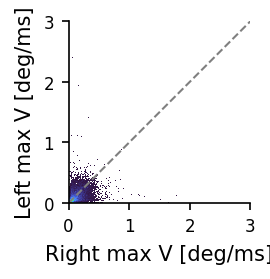

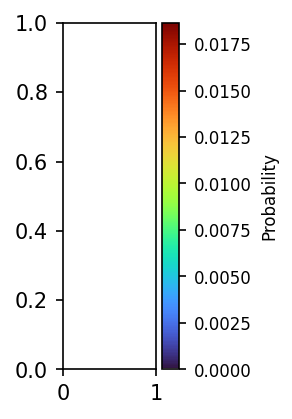

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pathlib
import tqdm
import pickle
import datetime
import pandas as pd  # Assuming pandas is imported as well

def plot_right_vs_left_eye_hist2d(all_saccade_collection, block_dict, export_path=None,
                                  iqr_multiplier=1.5, bins=100, sync_diff_threshold=31):
    """
    Plots a 2D probability histogram (normalized so that the sum of all bins is 1) where the x-axis
    represents the right eye's max speed and the y-axis represents the left eye's max speed.
    Uses a custom colormap based on 'turbo' (with only the 0 value set to white) and applies a robust
    exclusion rule so that saccades that are within sync_diff_threshold of a previously processed saccade
    (for the same animal and block) are excluded.

    The axes are kept equal and the colorbar is saved to a separate PDF.

    Parameters:
        all_saccade_collection (pd.DataFrame): DataFrame containing detected saccades.
        block_dict (dict): Dictionary mapping block keys to block objects with eye data.
        export_path (str or pathlib.Path, optional): Path to save the plot and colorbar PDFs.
        iqr_multiplier (float): Multiplier for the interquartile range (IQR) in outlier detection.
        bins (int): Number of bins to use for both x and y directions in the histogram.
        sync_diff_threshold (float): Time difference threshold to consider saccades synchronized
                                       (in the same units as 'saccade_on_ms').
    """
    right_eye_speeds = []
    left_eye_speeds = []

    # Dictionary to track processed saccades for each (animal, block).
    # Keys are (animal, block) and values are lists of saccade timestamps already used.
    processed_events = {}

    # Loop through each saccade entry.
    for _, row in tqdm.tqdm(all_saccade_collection.iterrows()):
        key = (row['animal'], row['block'])
        current_timestamp = row['saccade_on_ms']

        # Check if a saccade for this (animal, block) has already been processed
        # within sync_diff_threshold.
        if key in processed_events:
            if any(abs(current_timestamp - ts) < sync_diff_threshold for ts in processed_events[key]):
                continue  # Skip as this saccade is considered synchronized with a previous one.
            else:
                processed_events[key].append(current_timestamp)
        else:
            processed_events[key] = [current_timestamp]

        block_key = f"{row['animal']}_block_{row['block']}"
        if block_key not in block_dict:
            continue

        block = block_dict[block_key]

        # Get contralateral eye's data based on which eye was detected.
        if row['eye'] == 'L':
            contralateral_eye_speed_profile = block.right_eye_data.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        elif row['eye'] == 'R':
            contralateral_eye_speed_profile = block.left_eye_data.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        else:
            continue

        # Compute the maximum speeds (scaling as in the original function)
        max_detected = np.nanmax(row['speed_profile_angular'] / 17) if len(row['speed_profile_angular']) > 0 else np.nan
        max_contralateral = (np.nanmax(contralateral_eye_speed_profile.values / 17)
                             if contralateral_eye_speed_profile.notna().sum() > 0 else np.nan)

        # Append valid pairs.
        if not np.isnan(max_detected) and not np.isnan(max_contralateral):
            if row['eye'] == 'L':
                left_eye_speeds.append(max_detected)
                right_eye_speeds.append(max_contralateral)
            elif row['eye'] == 'R':
                right_eye_speeds.append(max_detected)
                left_eye_speeds.append(max_contralateral)

    # Convert lists to NumPy arrays.
    right_eye_speeds = np.array(right_eye_speeds)
    left_eye_speeds = np.array(left_eye_speeds)
    print("Number of data points:", len(right_eye_speeds))

    # Outlier removal using IQR on the combined speeds.
    all_speeds = np.concatenate([right_eye_speeds, left_eye_speeds])
    q1, q3 = np.percentile(all_speeds, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    valid_indices = ((right_eye_speeds >= lower_bound) & (right_eye_speeds <= upper_bound) &
                     (left_eye_speeds >= lower_bound) & (left_eye_speeds <= upper_bound))
    right_eye_speeds = right_eye_speeds[valid_indices]
    left_eye_speeds = left_eye_speeds[valid_indices]

    # Fixed axis limits.
    min_value = 0
    max_value = 3

    # Create the custom turbo colormap: get a discrete version of turbo and replace the first color with white.
    n_colors = 256
    turbo = plt.get_cmap('turbo', n_colors)
    turbo_colors = turbo(np.linspace(0, 1, n_colors))
    turbo_colors[0] = np.array([1, 1, 1, 1])  # Set the lowest count (0 probability) to perfect white.
    custom_turbo = mcolors.ListedColormap(turbo_colors)

    # Prepare the figure for the histogram.
    fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
    xbins = np.linspace(min_value, max_value, bins)
    ybins = np.linspace(min_value, max_value, bins)

    # Compute the 2D histogram manually.
    counts, xedges, yedges = np.histogram2d(right_eye_speeds, left_eye_speeds, bins=[xbins, ybins])
    normalized_counts = counts / counts.sum()  # Normalize so that the overall sum equals 1.

    # Plot the normalized histogram using pcolormesh.
    pc = ax.pcolormesh(xedges, yedges, normalized_counts.T, cmap=custom_turbo,
                         vmin=0, vmax=normalized_counts.max())

    # Ensure equal axes.
    ax.set_aspect('equal', 'box')
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)

    # Add a diagonal reference line.
    ax.plot([min_value, max_value], [min_value, max_value], linestyle='--', color='gray', linewidth=1)

    # Set axis labels.
    ax.set_xlabel("Right max V [deg/ms]", fontsize=10)
    ax.set_ylabel("Left max V [deg/ms]", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)
    plt.tight_layout()

    # Save the histogram plot if export_path is provided.
    if export_path:
        export_dir = pathlib.Path(export_path)
        export_dir.mkdir(parents=True, exist_ok=True)
        hist_pdf_path = export_dir / "right_vs_left_hist2d.pdf"
        fig.savefig(hist_pdf_path, format='pdf', bbox_inches='tight')
        print(f"2D histogram saved to {hist_pdf_path}")

    # Create a separate figure for the colorbar.
    vmin_val = 0
    vmax_val = normalized_counts.max()
    sm = plt.cm.ScalarMappable(cmap=custom_turbo, norm=plt.Normalize(vmin=vmin_val, vmax=vmax_val))
    sm.set_array([])
    fig2 = plt.figure(figsize=(1, 3), dpi=150)
    cbar = fig2.colorbar(sm, orientation='vertical')
    cbar.set_label("Probability", fontsize=8)
    cbar.ax.tick_params(labelsize=8)
    plt.tight_layout()

    # Save the colorbar to a separate PDF if export_path is provided.
    if export_path:
        cbar_pdf_path = export_dir / "right_vs_left_colorbar.pdf"
        fig2.savefig(cbar_pdf_path, format='pdf', bbox_inches='tight')
        print(f"Colorbar saved to {cbar_pdf_path}")

    plt.show()

# Example usage:
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\{t}'
plot_right_vs_left_eye_hist2d(all_saccade_collection, block_dict, export_path=export_path, iqr_multiplier=200, bins=250)


In [ ]:
def plot_correlation_max_speed_vs_amplitude(
    saccade_collection, sampling_rate=60, export_path=None, fig_size=(4,3)
):
    """
    Plots the correlation between the maximal angular speed and the overall amplitude of saccades.

    For each saccade (row in the dataframe), the function computes the maximal value of the
    'speed_profile_angular' array (converted from deg/frame to deg/ms using the provided sampling_rate)
    and compares it to the 'magnitude_raw_angular' value.

    A scatter plot is generated with a fitted regression line. The Pearson correlation coefficient
    and its p-value are printed and also shown on the plot.

    Parameters:
      - saccade_collection: DataFrame containing at least the columns 'speed_profile_angular' (an array)
                            and 'magnitude_raw_angular'.
      - sampling_rate: Sampling rate in Hz (default 60 Hz) used to convert speeds from deg/frame to deg/ms.
      - export_path: Optional directory path to export the plot and data.
      - fig_size: Tuple specifying the size (width, height) of the figure.
    """
    import os
    import datetime
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import pearsonr

    # Compute frame duration (ms per frame)
    frame_duration = 1000 / sampling_rate

    max_speeds = []
    amplitudes = []

    # Iterate over rows to compute maximum speed and corresponding amplitude
    for idx, row in saccade_collection.iterrows():
        profile = row['speed_profile_angular']
        amplitude = row['magnitude_raw_angular']
        # Check for missing data or empty profiles
        if profile is None or len(profile) == 0 or np.isnan(amplitude):
            continue
        # Convert profile to numpy array and convert to deg/ms
        profile = np.array(profile)
        # Compute maximum, ignoring any NaN values
        max_speed = np.nanmax(profile / frame_duration)
        max_speeds.append(max_speed)
        amplitudes.append(amplitude)

    max_speeds = np.array(max_speeds)
    amplitudes = np.array(amplitudes)

    if len(max_speeds) == 0:
        print("No valid saccade entries to compute correlation.")
        return

    # Compute Pearson correlation coefficient and p-value
    corr_coef, p_value = pearsonr(max_speeds, amplitudes)

    # Create scatter plot
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    ax.scatter(max_speeds, amplitudes, s=10, color='blue', alpha=0.7)

    # Compute and plot the regression line
    slope, intercept = np.polyfit(max_speeds, amplitudes, 1)
    x_vals = np.linspace(max_speeds.min(), max_speeds.max(), 100)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, color='red', lw=1)

    # Label the plot
    ax.set_xlabel('Max Angular Speed [deg/ms]', fontsize=10)
    ax.set_ylabel('Overall Amplitude [deg]', fontsize=10)
    ax.set_title('Correlation between Max Angular Speed and Overall Amplitude', fontsize=12)
    ax.legend(fontsize=8)

    # Display correlation stats on the plot
    textstr = f'Pearson r = {corr_coef:.3f}\nP-value = {p_value:.3e}'
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    print(f"Pearson correlation coefficient: {corr_coef:.3f}")
    print(f"P-value: {p_value:.3e}")

    # Optionally export the plot and saccade data
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"max_speed_vs_amplitude_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "max_speed_vs_amplitude.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(saccade_collection, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\correlation_plots'
plot_correlation_max_speed_vs_amplitude(
    saccade_collection, sampling_rate=60, export_path=None, fig_size=(4,3)
)

In [ ]:
synced_saccade_collection.columns

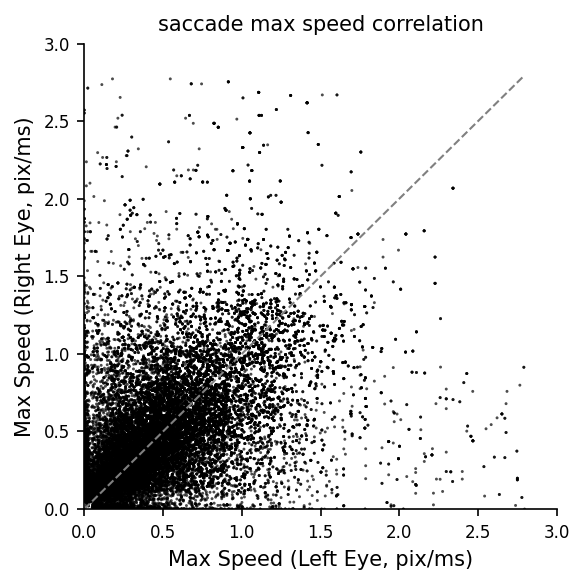

In [30]:


def plot_max_speeds_scatter(all_saccade_collection, block_dict, export_path=None,iqr_multiplier=1.5):
    """
    Plots a scatter plot of maximum speeds of the left eye vs the right eye for all saccades.

    Parameters:
        all_saccade_collection (pd.DataFrame): DataFrame containing all saccade data.
        block_dict (dict): Dictionary containing block objects with eye data.
        export_path (str or pathlib.Path, optional): Path to save the plot. Defaults to None.
    """
    left_eye_max_speeds = []
    right_eye_max_speeds = []

    for _, row in all_saccade_collection.iterrows():
        block_num = row['block']
        start_ts = row['saccade_on_ms']

        block_key = f"{row['animal']}_block_{block_num}"
        if block_key not in block_dict:
            continue

        block = block_dict[block_key]

        # Get speed data for the left and right eyes
        left_eye_data = block.left_eye_data.query(
            'ms_axis >= @start_ts - 100 and ms_axis <= @start_ts + 100')['speed_r'].values / 17
        right_eye_data = block.right_eye_data.query(
            'ms_axis >= @start_ts - 100 and ms_axis <= @start_ts + 100')['speed_r'].values / 17

        if len(left_eye_data) == 0 or len(right_eye_data) == 0:
            continue
        # Append maximum speeds only if valid data is available
        if not np.all(np.isnan(left_eye_data)):
            left_eye_max_speeds.append(np.nanmax(left_eye_data))
        else:
            left_eye_max_speeds.append(0)  # Or any other default value, like np.nan

        if not np.all(np.isnan(right_eye_data)):
            right_eye_max_speeds.append(np.nanmax(right_eye_data))
        else:
            right_eye_max_speeds.append(0)  # Or any other default value, like np.nan

    # Convert to NumPy arrays for easier filtering
    left_eye_max_speeds = np.array(left_eye_max_speeds)
    right_eye_max_speeds = np.array(right_eye_max_speeds)

    # Outlier removal using the IQR method
    all_speeds = np.concatenate([left_eye_max_speeds, right_eye_max_speeds])
    q1, q3 = np.percentile(all_speeds, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    # Filter points within bounds
    valid_indices = (left_eye_max_speeds >= lower_bound) & (left_eye_max_speeds <= upper_bound) & \
                    (right_eye_max_speeds >= lower_bound) & (right_eye_max_speeds <= upper_bound)

    left_eye_max_speeds = left_eye_max_speeds[valid_indices]
    right_eye_max_speeds = right_eye_max_speeds[valid_indices]

    # Create scatter plot
    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
    ax.scatter(left_eye_max_speeds, right_eye_max_speeds, alpha=0.7, s=2, c='k', edgecolors='none')

    # Plot diagonal reference line
    max_val = max(max(left_eye_max_speeds, default=0), max(right_eye_max_speeds, default=0))
    ax.plot([0, max_val], [0, max_val], linestyle='--', color='gray', linewidth=1)

    # Configure plot appearance
    ax.set_title("saccade max speed correlation", fontsize=10)
    ax.set_xlabel("Max Speed (Left Eye, pix/ms)", fontsize=10)
    ax.set_ylabel("Max Speed (Right Eye, pix/ms)", fontsize=10)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(0,3)
    ax.set_ylim(0,3)

    plt.tight_layout()

    # Save the plot if export_path is provided
    if export_path:
        export_dir = pathlib.Path(export_path)
        export_dir.mkdir(parents=True, exist_ok=True)
        pdf_path = export_dir / "max_speeds_scatter.pdf"
        fig.savefig(pdf_path, format='pdf', bbox_inches='tight')
        print(f"Scatter plot saved to {pdf_path}")

    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\temporary_drafts\saccade_speed_correlation_all'
plot_max_speeds_scatter(all_saccade_collection, block_dict, iqr_multiplier=4, export_path=None)

In [95]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Core circular utilities ----------

def _angle_to_unitvec(theta):
    """theta in radians -> complex unit vector e^{i theta}."""
    return np.exp(1j * theta)

def _mean_resultant(z):
    """z is complex unit vectors; returns R (length), rbar, mean angle."""
    R = np.abs(np.sum(z))
    n = len(z)
    rbar = R / n
    mu = np.angle(np.sum(z))
    return R, rbar, mu

def _rayleigh_test(z):
    """
    Rayleigh test of non-uniformity for unit vectors z = e^{i theta}.
    Returns z_stat and p-value using standard small-sample corrected approximation.
    Reference: Berens (2009) 'CircStat' notes / Batschelet (1981).
    """
    n = len(z)
    R = np.abs(np.sum(z))
    z_stat = (R**2) / n
    # p-value approximation with finite-sample correction
    # p = exp(-z) * [1 + (2z - z^2)/(4n) - (24z - 132z^2 + 76z^3 - 9z^4)/(288 n^2)]
    # Guard n for very small samples
    z = z_stat
    p = np.exp(-z) * (
        1.0 +
        (2.0*z - z**2) / (4.0*n) -
        (24.0*z - 132.0*z**2 + 76.0*z**3 - 9.0*z**4) / (288.0 * n**2)
    )
    p = min(max(p, 0.0), 1.0)
    return z_stat, p

def _bootstrap_axis_ci(angles_rad, axial=True, alpha=0.05, n_boot=2000, rng=None):
    """
    Nonparametric bootstrap CI for the mean axis (axial) or mean direction (directional).
    Returns (low, high) bounds in radians, with wrap-around handling.
    """
    rng = np.random.default_rng(None if rng is None else rng)
    n = len(angles_rad)
    samples = []
    if axial:
        # double angles, mean direction, then halve and fold into [0, pi)
        for _ in range(n_boot):
            a = angles_rad[rng.integers(0, n, size=n)]
            z = _angle_to_unitvec(2.0*a)
            _, _, mu2 = _mean_resultant(z)
            axis = (mu2 / 2.0) % np.pi
            samples.append(axis)
    else:
        for _ in range(n_boot):
            a = angles_rad[rng.integers(0, n, size=n)]
            z = _angle_to_unitvec(a)
            _, _, mu = _mean_resultant(z)
            samples.append(mu % (2*np.pi))

    samples = np.array(samples)
    # Circular quantile for [0, pi) (axial) or [0, 2pi) (directional) via grid search
    period = np.pi if axial else 2*np.pi
    # choose cut that minimizes circular spread, then compute linear quantiles
    grid = np.linspace(0, period, 360, endpoint=False)
    best_spread = np.inf
    best_shift = 0.0
    for s in grid:
        shifted = (samples - s) % period
        spread = np.std(shifted)
        if spread < best_spread:
            best_spread = spread
            best_shift = s
    shifted = (samples - best_shift) % period
    lo = np.quantile(shifted, alpha/2)
    hi = np.quantile(shifted, 1 - alpha/2)
    lo = (lo + best_shift) % period
    hi = (hi + best_shift) % period
    return lo, hi

# ---------- Public API ----------

def axial_bias_test(angles_deg, alpha=0.05, n_boot=2000, return_directional=False, rng=None):
    """
    Quantify and test bias toward a MAIN AXIS (axial data; 0° ~ 180°).

    Parameters
    ----------
    angles_deg : array-like
        Saccade directions in degrees (0-360).
    alpha : float
        Confidence level for axis CI (default 0.05 -> 95% CI).
    n_boot : int
        Bootstrap iterations for the CI.
    return_directional : bool
        Also compute the directional (0-360) Rayleigh result for reference.
    rng : int or Generator
        Seed or numpy Generator for reproducibility.

    Returns
    -------
    result : dict with keys
        'n' : sample size
        'axis_deg' : preferred axis in degrees in [0, 180)
        'rbar' : axial mean resultant length (effect size, 0..1)
        'rayleigh_z' : Rayleigh z-statistic (on doubled angles)
        'p_rayleigh' : p-value (non-uniformity, i.e. presence of axis)
        'axis_ci_deg' : (low, high) CI for the axis in degrees
        'directional' : optional dict (mean_dir_deg, rbar, z, p) if return_directional=True
    """
    a = np.asarray(angles_deg).astype(float)
    a = np.deg2rad(a % 360.0)

    # Axial analysis (double angles)
    z2 = _angle_to_unitvec(2.0*a)
    R2, rbar2, mu2 = _mean_resultant(z2)
    n = len(a)
    # axial effect size is rbar on doubled angles (interpreted as orientation concentration)
    rbar_axial = rbar2
    # mean axis in [0, pi) then to degrees
    axis = (mu2 / 2.0) % np.pi
    axis_deg = np.rad2deg(axis)

    # Rayleigh on doubled angles
    z_stat, p = _rayleigh_test(z2)

    # Bootstrap CI for axis
    lo, hi = _bootstrap_axis_ci(a, axial=True, alpha=alpha, n_boot=n_boot, rng=rng)
    ci_deg = (np.rad2deg(lo), np.rad2deg(hi))

    result = dict(
        n=n,
        axis_deg=float(axis_deg),
        rbar=float(rbar_axial),
        rayleigh_z=float(z_stat),
        p_rayleigh=float(p),
        axis_ci_deg=(float(ci_deg[0]), float(ci_deg[1])),
    )

    if return_directional:
        z1 = _angle_to_unitvec(a)
        _, rbar_dir, mu_dir = _mean_resultant(z1)
        z_stat1, p1 = _rayleigh_test(z1)
        result["directional"] = dict(
            mean_dir_deg=float(np.rad2deg(mu_dir) % 360.0),
            rbar=float(rbar_dir),
            rayleigh_z=float(z_stat1),
            p_rayleigh=float(p1),
        )

    return result

def plot_axial_bias(angles_deg, summary=None, bins=18, alpha=0.05, n_boot=2000, ax=None, title=None, rng=None):
    """
    Rose plot for axial data with mean axis + CI. Uses 0..180° folding for the histogram.
    """
    angles = np.asarray(angles_deg) % 360.0
    # Fold to [0,180) for axial histogram
    angles_ax_deg = (angles % 180.0)
    angles_ax = np.deg2rad(angles_ax_deg)

    if summary is None:
        summary = axial_bias_test(angles_deg, alpha=alpha, n_boot=n_boot, rng=rng)

    if ax is None:
        fig = plt.figure(figsize=(3.2, 3.2))
        ax = plt.subplot(111, projection='polar')
    else:
        fig = ax.figure

    # Axial rose histogram (0..pi)
    counts, edges = np.histogram(angles_ax, bins=bins, range=(0, np.pi))
    widths = np.diff(edges)
    ax.bar(edges[:-1], counts, width=widths, align='edge', edgecolor='none', alpha=0.4)

    # Plot mean axis and CI as rays
    axis_rad = np.deg2rad(summary['axis_deg'])
    lo, hi = np.deg2rad(summary['axis_ci_deg'][0]), np.deg2rad(summary['axis_ci_deg'][1])

    rmax = counts.max() if counts.size else 1
    ax.plot([axis_rad, axis_rad], [0, rmax], linewidth=2.5)
    # confidence limits
    ax.plot([lo, lo], [0, rmax*0.9], linestyle='--', linewidth=1.5)
    ax.plot([hi, hi], [0, rmax*0.9], linestyle='--', linewidth=1.5)

    ax.set_theta_zero_location('E')   # 0° to the right, like typical screen coords
    ax.set_theta_direction(-1)        # increase clockwise (optional, matches many eye data plots)
    ax.set_thetalim(0, np.pi)         # axial half-rose
    ax.set_yticklabels([])

    if title is None:
        title = (f"Axial bias: axis={summary['axis_deg']:.1f}° "
                 f"(95% CI {summary['axis_ci_deg'][0]:.1f}–{summary['axis_ci_deg'][1]:.1f}°)\n"
                 f"r̄={summary['rbar']:.3f}, Rayleigh p={summary['p_rayleigh']:.2g}, n={summary['n']}")
    ax.set_title(title, fontsize=9)
    fig.tight_layout()
    return ax, summary


Main Sub saccade_start_ind saccade_end_ind saccade_start_timestamp  \
0   0.0   L               951             954             1.01946e+06   
1   1.0   L               974             975             1.02712e+06   
2   2.0   L               975             982             1.02745e+06   
3   3.0   L              1009            1011             1.03877e+06   
4   4.0   L              1011            1019             1.03944e+06   

  saccade_end_timestamp saccade_on_ms saccade_off_ms length  \
0           1.02046e+06       50972.8        51022.8      3   
1           1.02745e+06       51355.8        51372.4      1   
2           1.02978e+06       51372.4        51488.9      7   
3           1.03944e+06       51938.5        51971.8      2   
4            1.0421e+06       51971.8          52105      8   

  magnitude_raw_pixel  ... theta_end_pos phi_init_pos phi_end_pos delta_theta  \
0             31.2363  ...      -25.5542     -18.5377     -10.858     19.8961   
1             25.6174  ...      -32.8717     -5.02841     1.23004    -2.34805   
2             44.6078  ...      -28.1092      1.23004    -20.7524     4.76251   
3             18.6336  ...      -29.4525     -20.3102    -13.8045    -3.55944   
4              22.844  ...       -29.331     -13.8045    -25.6732    0.121506   

  delta_phi head_movement eye block  animal time_to_peak_v  
0   7.67964          True   L   008  PV_106             17  
1   6.25845          True   L   008  PV_106              0  
2  -21.9824          True   L   008  PV_106             34  
3   6.50568          True   L   008  PV_106              0  
4  -11.8687          True   L   008  PV_106              0  

[5 rows x 29 columns]

In [20]:
# ==== Axial (orientation) bias analysis for saccade directions ====
# Works directly on your `all_saccade_collection` DataFrame.
# - Uses overall_angle_deg when present; otherwise falls back to atan2(delta_phi, delta_theta).
# - Treats directions axially (0° ≡ 180°), appropriate for "main axis" bias (e.g., horizontal vs vertical).
# - Outputs per-animal + overall summaries, rose plots, and an r̄ bar chart.
#
# Minimal deps: numpy, pandas, matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------- config -----------------------
DF = all_saccade_collection            # <-- your dataframe variable
ANGLE_COL = "overall_angle_deg"        # fallback to (delta_theta, delta_phi) if absent/NaN
EXCLUDE_HEAD_MOVES = False             # drop rows with head_movement==True
GROUPBY = ("animal",)                  # group granularity for per-group summaries/plots
BINS = 18                              # bins for rose plots (on 0..180°)
N_BOOT = 2000                          # bootstrap samples for axis CI
ALPHA = 0.05                           # 95% CI
ORI_HALF_WIDTH_DEG = 30.0              # ± around 0° (horizontal) and ± around 90° (vertical) on 0..180°
RNG_SEED = 0                           # set to None for random
SAVE_FIGS = False                      # True to export PDFs next to the notebook
OUT_PREFIX = "saccade_axial_bias"      # file name prefix if SAVE_FIGS=True
# ------------------------------------------------------

# ---------- circular utilities ----------
def _angle_to_unitvec(theta_rad):
    return np.exp(1j * theta_rad)

def _mean_resultant(z):
    R = np.abs(np.sum(z))
    n = len(z)
    rbar = R / max(n, 1)
    mu = np.angle(np.sum(z)) if n else np.nan
    return R, rbar, mu

def _rayleigh_test(z):
    """
    Rayleigh test for non-uniformity. Input: unit vectors z = exp(i*theta).
    Returns z_stat and p-value (finite-sample corrected approximation).
    """
    n = len(z)
    if n == 0:
        return np.nan, np.nan
    R = np.abs(np.sum(z))
    z_stat = (R**2) / n
    z = z_stat
    # finite-sample corrected p-value approximation (Batschelet/CircStat)
    p = np.exp(-z) * (
        1.0
        + (2.0*z - z**2) / (4.0*n)
        - (24.0*z - 132.0*z**2 + 76.0*z**3 - 9.0*z**4) / (288.0 * n**2)
    )
    return float(z_stat), float(np.clip(p, 0.0, 1.0))

def _bootstrap_axis_ci(angles_rad, alpha=0.05, n_boot=2000, rng=None):
    """
    Bootstrap CI for mean axis (axial data). angles_rad are 0..2π directions.
    Doubles angles, computes mean direction, halves back to axis in [0, π).
    Returns (lo, hi) in radians with wrap-around handling.
    """
    if len(angles_rad) == 0:
        return np.nan, np.nan
    period = np.pi
    rng = np.random.default_rng(rng)
    idx = np.arange(len(angles_rad))
    samples = np.empty(n_boot, dtype=float)
    for i in range(n_boot):
        a = angles_rad[rng.choice(idx, size=len(idx), replace=True)]
        z2 = _angle_to_unitvec(2.0 * a)
        _, _, mu2 = _mean_resultant(z2)
        samples[i] = (mu2 / 2.0) % period

    # choose shift minimizing circular spread, then take linear quantiles
    grid = np.linspace(0, period, 360, endpoint=False)
    best_shift = min(grid, key=lambda s: np.std((samples - s) % period))
    shifted = (samples - best_shift) % period
    lo = np.quantile(shifted, alpha/2)
    hi = np.quantile(shifted, 1 - alpha/2)
    return (lo + best_shift) % period, (hi + best_shift) % period

# ---------- main stats ----------
def axial_bias_test(angles_deg, alpha=0.05, n_boot=2000, rng=None):
    """
    Axial Rayleigh analysis:
      - preferred axis (0..180°),
      - mean resultant length r̄ (on doubled angles),
      - Rayleigh z and p (non-uniformity),
      - bootstrap 95% CI for axis.
    """
    a = np.deg2rad(np.asarray(angles_deg).astype(float) % 360.0)
    if a.size == 0:
        return dict(n=0, axis_deg=np.nan, axis_ci_deg=(np.nan, np.nan),
                    rbar=np.nan, rayleigh_z=np.nan, p_rayleigh=np.nan)

    z2 = _angle_to_unitvec(2.0 * a)
    _, rbar2, mu2 = _mean_resultant(z2)
    axis = (mu2 / 2.0) % np.pi
    z_stat, p = _rayleigh_test(z2)
    lo, hi = _bootstrap_axis_ci(a, alpha=alpha, n_boot=n_boot, rng=rng)
    return dict(
        n=int(a.size),
        axis_deg=float(np.rad2deg(axis)),
        axis_ci_deg=(float(np.rad2deg(lo)), float(np.rad2deg(hi))),
        rbar=float(rbar2),
        rayleigh_z=float(z_stat),
        p_rayleigh=float(p),
    )

def orientation_index(angles_deg, half_width=30.0):
    """
    Descriptive Horizontal-vs-Vertical index on 0..180° folded angles.
      OI = (H - V) / (H + V), where
        H counts angles within ±half_width of 0° or 180°
        V counts angles within ±half_width of 90°
    Also returns an exact two-sided binomial p-value for H vs V (conditional on being in either window).
    """
    a = (np.asarray(angles_deg).astype(float) % 180.0)
    # Horizontal windows around 0° and 180° (folded -> near 0° or near 180° ≡ near 0°)
    H = ((a <= half_width) | (a >= 180.0 - half_width)).sum()
    # Vertical window around 90°
    V = ((np.abs(a - 90.0) <= half_width)).sum()
    k = int(H)
    n = int(H + V)
    oi = 0.0 if n == 0 else (H - V) / n

    # exact two-sided binomial test for p=0.5 on k successes out of n
    def _binom_p_two_sided(k, n):
        if n == 0: return np.nan
        # probability mass function
        from math import comb
        p_half = 0.5**n
        # observed probability
        p_obs = comb(n, k) * p_half
        # sum probabilities <= p_obs on both tails
        probs = np.array([comb(n, i) * p_half for i in range(n+1)])
        mask = probs <= p_obs + 1e-15
        return float(np.clip(probs[mask].sum(), 0.0, 1.0))
    p_binom = _binom_p_two_sided(k, n)

    return dict(orientation_index=float(oi), H=int(H), V=int(V), n_in_windows=int(n), p_binom=float(p_binom))

# ---------- dataframe adapters ----------
def _extract_angles_deg(df, angle_col="overall_angle_deg", fallback=("delta_theta","delta_phi")):
    """
    Returns direction angles (0..360°). Uses angle_col if present/finite; otherwise atan2(dy, dx) from fallback.
    Convention: 0° to +x (theta), increasing CCW; axial tests are invariant to this convention.
    """
    if angle_col in df.columns:
        ang = pd.to_numeric(df[angle_col], errors="coerce").to_numpy()
        if np.isfinite(ang).sum() > 0:
            return ang % 360.0
    dx, dy = fallback
    if dx not in df.columns or dy not in df.columns:
        raise ValueError(f"No '{angle_col}' and fallback columns {fallback} not found.")
    ang = np.degrees(np.arctan2(pd.to_numeric(df[dy], errors="coerce"),
                                 pd.to_numeric(df[dx], errors="coerce")))
    return (ang % 360.0).to_numpy()

def _filter_df(df, exclude_head_movement=False):
    q = df.copy()
    if exclude_head_movement and "head_movement" in q.columns:
        q = q[~q["head_movement"].astype(bool)]
    return q

def axial_bias_by(df, groupby=("animal",), angle_col="overall_angle_deg",
                  alpha=0.05, n_boot=2000, exclude_head_movement=False, rng=None):
    """
    Tidy per-group summary with axial bias stats and orientation index.
    """
    q = _filter_df(df, exclude_head_movement=exclude_head_movement)
    use_cols = [c for c in groupby if c in q.columns]
    groups = list(q.groupby(use_cols, dropna=False)) if use_cols else [((), q)]

    rows = []
    for key, sub in groups:
        angles = _extract_angles_deg(sub, angle_col=angle_col, fallback=("delta_theta","delta_phi"))
        stats = axial_bias_test(angles, alpha=alpha, n_boot=n_boot, rng=rng)
        oi = orientation_index(angles, half_width=ORI_HALF_WIDTH_DEG)
        row = dict(zip(use_cols, key if isinstance(key, tuple) else (key,)))
        row.update(stats); row.update(oi)
        rows.append(row)
    out = pd.DataFrame(rows)
    # order columns nicely
    front = list(use_cols) + [
        "n", "axis_deg", "axis_ci_deg", "rbar",
        "rayleigh_z", "p_rayleigh",
        "orientation_index", "H", "V", "n_in_windows", "p_binom"
    ]
    return out[front] if not out.empty else out

# ---------- plotting ----------
def plot_axial_rose(angles_deg, bins=18, title=None, ax=None):
    """
    Half-rose (0..180°) with mean axis & CI.
    """
    angles = np.asarray(angles_deg) % 360.0
    folded = np.deg2rad(angles % 180.0)
    if ax is None:
        fig = plt.figure(figsize=(3.2, 3.2))
        ax = plt.subplot(111, projection="polar")
    else:
        fig = ax.figure

    counts, edges = np.histogram(folded, bins=bins, range=(0, np.pi))
    widths = np.diff(edges)
    ax.bar(edges[:-1], counts, width=widths, align='edge', edgecolor='none', alpha=0.4)

    # overlay mean axis + CI
    summary = axial_bias_test(angles, alpha=ALPHA, n_boot=N_BOOT, rng=RNG_SEED)
    axis_rad = np.deg2rad(summary["axis_deg"])
    lo, hi = map(np.deg2rad, summary["axis_ci_deg"])
    rmax = max(counts.max() if counts.size else 1, 1)
    ax.plot([axis_rad, axis_rad], [0, rmax], linewidth=2.5)
    ax.plot([lo, lo], [0, 0.9*rmax], linestyle="--", linewidth=1.5)
    ax.plot([hi, hi], [0, 0.9*rmax], linestyle="--", linewidth=1.5)

    # aesthetics
    ax.set_theta_zero_location('E')  # 0° to the right
    ax.set_theta_direction(-1)       # clockwise increase
    ax.set_thetalim(0, np.pi)
    ax.set_yticklabels([])
    if title is None:
        title = (f"Axis={summary['axis_deg']:.1f}° (95% CI {summary['axis_ci_deg'][0]:.1f}–{summary['axis_ci_deg'][1]:.1f}°)\n"
                 f"r̄={summary['rbar']:.3f}, Rayleigh p={summary['p_rayleigh']:.2g}, n={summary['n']}")
    ax.set_title(title, fontsize=9)
    fig.tight_layout()
    return ax, summary

def plot_axial_grid_by(df, groupby=("animal",), bins=18, suptitle=None):
    """
    Grid of half-rose plots per group.
    """
    q = _filter_df(df, exclude_head_movement=EXCLUDE_HEAD_MOVES)
    use_cols = [c for c in groupby if c in q.columns]
    groups = list(q.groupby(use_cols, dropna=False)) if use_cols else [((), q)]
    n = len(groups)
    ncols = min(3, n) if n else 1
    nrows = int(np.ceil(n / ncols)) if n else 1
    fig = plt.figure(figsize=(3.3*ncols, 3.4*nrows))
    for i, (key, sub) in enumerate(groups, start=1):
        ang = _extract_angles_deg(sub, angle_col=ANGLE_COL, fallback=("delta_theta","delta_phi"))
        ax = plt.subplot(nrows, ncols, i, projection="polar")
        tag = " | ".join(f"{k}={v}" for k, v in zip(use_cols, key if isinstance(key, tuple) else (key,)))
        _, summ = plot_axial_rose(ang, bins=bins, ax=ax, title=None)
        ax.set_title(f"{tag}\n"
                     f"Axis={summ['axis_deg']:.1f}° [{summ['axis_ci_deg'][0]:.1f}–{summ['axis_ci_deg'][1]:.1f}] "
                     f"r̄={summ['rbar']:.2f}, p={summ['p_rayleigh']:.2g}, n={summ['n']}", fontsize=8)
    if suptitle: fig.suptitle(suptitle, y=1.02)
    fig.tight_layout()
    return fig

def plot_rbar_bar(summary_df, group_cols=("animal",)):
    """
    Bar chart of r̄ by group with significance stars from Rayleigh p-values.
    """
    if summary_df.empty:
        return None
    tmp = summary_df.copy()
    tmp["label"] = tmp[list(group_cols)].astype(str).agg(" | ".join, axis=1) if group_cols else pd.Series(["overall"]*len(tmp))
    order = np.argsort(tmp["rbar"].to_numpy())[::-1]
    tmp = tmp.iloc[order]

    fig, ax = plt.subplots(figsize=(max(3.5, 0.5*len(tmp)), 3.2))
    bars = ax.bar(tmp["label"], tmp["rbar"])
    ax.set_ylabel("Mean resultant length r̄ (axial)")
    ax.set_ylim(0, max(0.01, tmp["rbar"].max()*1.15))

    # significance stars
    for rect, p in zip(bars, tmp["p_rayleigh"]):
        if np.isnan(p): stars = ""
        elif p < 0.001: stars = "***"
        elif p < 0.01:  stars = "**"
        elif p < 0.05:  stars = "*"
        else:           stars = ""
        if stars:
            ax.text(rect.get_x()+rect.get_width()/2, rect.get_height()*1.02, stars,
                    ha="center", va="bottom", fontsize=10)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha("right")
    fig.tight_layout()
    return fig

# ---------------------- run analysis ----------------------
rng = RNG_SEED

# Optional filtering
df_use = _filter_df(DF, exclude_head_movement=EXCLUDE_HEAD_MOVES)

# Per-animal summary
per_animal = axial_bias_by(
    df_use, groupby=GROUPBY, angle_col=ANGLE_COL,
    alpha=ALPHA, n_boot=N_BOOT, exclude_head_movement=False, rng=rng
).sort_values(list(GROUPBY))

# Overall summary (all animals together)
overall_angles = _extract_angles_deg(df_use, angle_col=ANGLE_COL, fallback=("delta_theta","delta_phi"))
overall_stats = axial_bias_test(overall_angles, alpha=ALPHA, n_boot=N_BOOT, rng=rng)
overall_oi = orientation_index(overall_angles, half_width=ORI_HALF_WIDTH_DEG)
overall_row = {**{k: "ALL" for k in GROUPBY}, **overall_stats, **overall_oi}
overall_df = pd.DataFrame([overall_row])[per_animal.columns] if not per_animal.empty else pd.DataFrame([overall_row])

# Print results
pd.set_option("display.max_colwidth", None)
print("\n=== Per-animal axial bias summary ===")
display(per_animal)

print("\n=== Overall axial bias summary ===")
display(overall_df)

# Plots
fig_grid = plot_axial_grid_by(df_use, groupby=GROUPBY, bins=BINS,
                              suptitle="Axial bias of saccade orientations (per animal)")

fig_overall, ax = plt.subplots(subplot_kw=dict(projection="polar"), figsize=(3.5, 3.5))
plot_axial_rose(overall_angles, bins=BINS, ax=ax, title="Overall axial bias")
plt.show()

fig_rbar = plot_rbar_bar(per_animal, group_cols=GROUPBY)
plt.show()

# Optional save
if SAVE_FIGS:
    if fig_grid is not None:
        fig_grid.savefig(f"{OUT_PREFIX}_grid.pdf", bbox_inches="tight")
    fig_overall.savefig(f"{OUT_PREFIX}_overall.pdf", bbox_inches="tight")
    if fig_rbar is not None:
        fig_rbar.savefig(f"{OUT_PREFIX}_rbar_per_animal.pdf", bbox_inches="tight")


OverflowError: int too large to convert to float

animal  length  mean_pv_dms  mean_ttp_ms     n
0   PV_106       1     0.121771     2.884232  2505
1   PV_106       2     0.171367     9.349057  1802
2   PV_106       3     0.205193    14.353913  1150
3   PV_126       1     0.135158     3.349492  2558
4   PV_126       2     0.166334    10.730275  2180
5   PV_126       3     0.181177    14.943450  1397
6   PV_143       1     0.158288     4.107383  1043
7   PV_143       2     0.173453    10.200000   830
8   PV_143       3     0.201261    12.655877   587
9    PV_57       1     0.134321     4.242523  3979
10   PV_57       2     0.163202    10.231936  2768
11   PV_57       3     0.190747    16.058225  1769
12   PV_62       1     0.118670     2.551748  1459
13   PV_62       2     0.151641     8.644068  1652
14   PV_62       3     0.206902    14.621928  1058

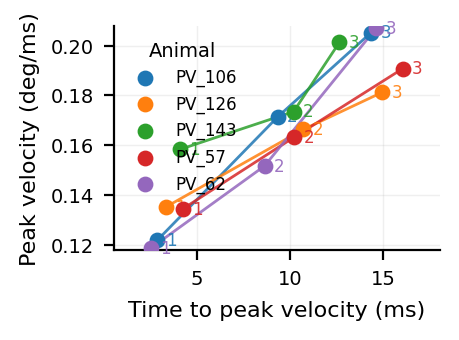

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from typing import Optional

def plot_ttp_vs_peakv_minimal(
    df: pd.DataFrame,
    sampling_rate: float = 60.0,
    speed_profile_col: str = "speed_profile_angular",   # deg/frame; list-like per saccade
    time_to_peak_col: str = "time_to_peak_v",           # ms (if available)
    length_col: str = "length",                          # frames
    animal_col: str = "animal",
    eyes: Optional[str] = None,                          # e.g., "L" or "R" to filter, or None
    refine_peak: bool = True,                            # quadratic 3-point peak refinement
    show_raw: bool = False,                              # overlay faint raw points
    fig_size=(2.4, 1.8),
    dpi=200
):
    """
    Minimal main-sequence-style view for ultra-short saccades at 60 fps:
    X = time-to-peak velocity (ms), Y = peak velocity (deg/ms).
    One averaged dot per (animal, length) for lengths 1..3 frames.

    Returns
    -------
    agg : pd.DataFrame with columns [animal, length, mean_ttp_ms, mean_pv_dms, n]
    fig : matplotlib Figure
    """
    work = df.copy()
    if eyes is not None and "eye" in work.columns:
        work = work[work["eye"] == eyes]

    frame_ms = 1000.0 / sampling_rate

    def _to_array(x):
        if isinstance(x, (list, tuple, np.ndarray, pd.Series)):
            return np.asarray(x, dtype=float)
        if isinstance(x, str):
            try:
                return np.asarray(literal_eval(x), dtype=float)
            except Exception:
                return np.array([], dtype=float)
        if pd.isna(x):
            return np.array([], dtype=float)
        try:
            return np.asarray(x, dtype=float)
        except Exception:
            return np.array([], dtype=float)

    def _quad_refine_peak(arr):
        """Return (peak_deg_per_frame, ttp_ms) with optional quadratic refinement."""
        y = np.asarray(arr, dtype=float)
        if y.size == 0 or not np.isfinite(y).any():
            return np.nan, np.nan
        i = int(np.nanargmax(y))
        pv = y[i]
        ttp_ms = i * frame_ms
        if not refine_peak or i == 0 or i == y.size - 1:
            return pv, ttp_ms
        y0, y1, y2 = y[i-1], y[i], y[i+1]
        if not (np.isfinite(y0) and np.isfinite(y1) and np.isfinite(y2)):
            return pv, ttp_ms
        denom = (y0 - 2*y1 + y2)
        if denom == 0:
            return pv, ttp_ms
        d = 0.5 * (y0 - y2) / denom  # vertex offset in samples
        d = float(np.clip(d, -1.0, 1.0))
        pv_ref = y1 - 0.25 * (y0 - y2) * d
        ttp_ms_ref = (i + d) * frame_ms
        if np.isfinite(pv_ref) and pv_ref > 0:
            return pv_ref, (ttp_ms_ref if np.isfinite(ttp_ms_ref) else ttp_ms)
        return pv, ttp_ms

    # Compute per-row peak velocity (deg/ms) and ttp (ms)
    def _row_metrics(row):
        prof = _to_array(row.get(speed_profile_col, []))  # deg/frame
        if prof.size == 0:
            return pd.Series({"pv_dms": np.nan, "ttp_ms_est": np.nan})
        pv_df, ttp_ms_est = _quad_refine_peak(prof)
        pv_dms = pv_df * (sampling_rate / 1000.0)  # deg/frame -> deg/ms
        return pd.Series({"pv_dms": pv_dms, "ttp_ms_est": ttp_ms_est})

    metrics = work.apply(_row_metrics, axis=1)
    work = pd.concat([work, metrics], axis=1)

    # Prefer provided time_to_peak_v (ms) if present and finite; else use estimate
    if time_to_peak_col in work.columns:
        ttp_col = pd.to_numeric(work[time_to_peak_col], errors="coerce")
        work["ttp_ms"] = np.where(np.isfinite(ttp_col), ttp_col, work["ttp_ms_est"])
    else:
        work["ttp_ms"] = work["ttp_ms_est"]

    # Keep lengths 1..3 frames and valid metrics
    work[length_col] = pd.to_numeric(work[length_col], errors="coerce")
    keep = work[length_col].isin([1, 2, 3]) & np.isfinite(work["pv_dms"]) & np.isfinite(work["ttp_ms"])
    work = work[keep].copy()
    if animal_col not in work.columns:
        work[animal_col] = "ALL"

    # Aggregate one dot per (animal, length)
    agg = (work
           .groupby([animal_col, length_col], dropna=False)
           .agg(mean_pv_dms=("pv_dms", "mean"),
                mean_ttp_ms=("ttp_ms", "mean"),
                n=("pv_dms", "size"))
           .reset_index()
           .rename(columns={animal_col: "animal", length_col: "length"}))

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=fig_size, dpi=dpi)

    animals = agg["animal"].unique().tolist()
    cmap = plt.get_cmap("tab10")
    color_map = {a: cmap(i % 10) for i, a in enumerate(animals)}

    if show_raw:
        for a, g in work.groupby(animal_col):
            ax.scatter(g["ttp_ms"], g["pv_dms"], s=6, alpha=0.15, color=color_map.get(a))

    for a, g in agg.sort_values(["animal", "length"]).groupby("animal"):
        g = g.sort_values("length")
        ax.plot(g["mean_ttp_ms"], g["mean_pv_dms"], lw=1.0, alpha=0.85, color=color_map[a])
        ax.scatter(g["mean_ttp_ms"], g["mean_pv_dms"], s=22, color=color_map[a], label=a, zorder=3)
        for _, r in g.iterrows():
            ax.text(r["mean_ttp_ms"] + 0.5, r["mean_pv_dms"], str(int(r["length"])),
                    fontsize=6, va="center", ha="left", color=color_map[a], alpha=0.9)

    ax.set_xlabel("Time to peak velocity (ms)", fontsize=8)
    ax.set_ylabel("Peak velocity (deg/ms)", fontsize=8)
    ax.tick_params(axis='both', labelsize=7)
    ax.grid(True, alpha=0.2, linewidth=0.5)
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

    if agg.shape[0] > 0:
        xpad, ypad = 2.0, 0.001
        ax.set_xlim(max(0, agg["mean_ttp_ms"].min() - xpad), agg["mean_ttp_ms"].max() + xpad)
        ax.set_ylim(max(0, agg["mean_pv_dms"].min() - ypad), agg["mean_pv_dms"].max() + ypad)

    ax.legend(frameon=False, fontsize=6, loc="best", title="Animal", title_fontsize=7)
    plt.tight_layout()
    return agg, fig

# Example:
agg, fig = plot_ttp_vs_peakv_minimal(
    all_saccade_collection,
    sampling_rate=60.0,
    eyes=None,            # or "L"/"R"
    refine_peak=True,
    show_raw=False,
    fig_size=(2.4, 1.8),
    dpi=200
)
display(agg)


(array([4512., 2862., 3101., 3266., 4818., 4757., 2837., 3313., 3225.,
        5059.]),
 array([8.25407137e-03, 3.60068712e+01, 7.20054883e+01, 1.08004105e+02,
        1.44002723e+02, 1.80001340e+02, 2.15999957e+02, 2.51998574e+02,
        2.87997191e+02, 3.23995808e+02, 3.59994425e+02]),
 <BarContainer object of 10 artists>)

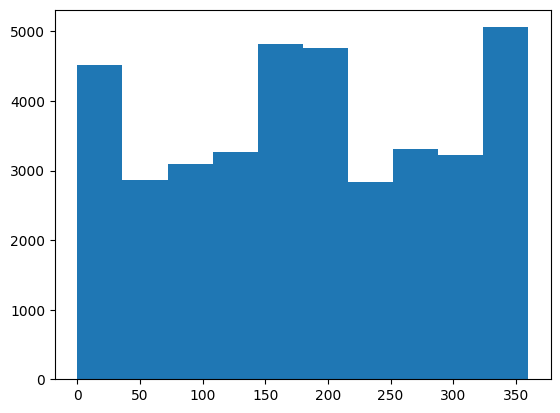

In [94]:
plt.hist(all_saccade_collection.overall_angle_deg)

(5, 39)
Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_amp_hist_deg\saccade_amplitude_averaged_histogram_angle_2025_08_25_00_50_05


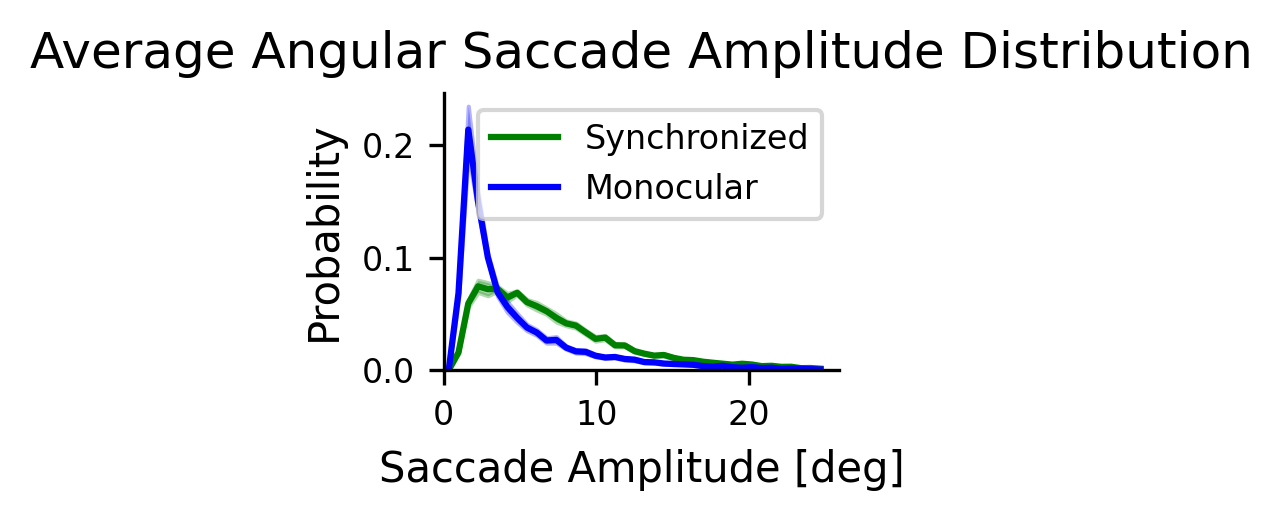

In [33]:
# overall saccade magnitude histogram
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t
import datetime
import os
import pickle

def plot_averaged_saccade_amplitude_distribution_angle(
    synced_saccade_collection, non_synced_saccade_collection, figure_size=(2.5, 1.7), export_path=None,
    bins=np.linspace(0,5,40)
):
    """
    Plots the average angular saccade amplitude likelihood histogram across animals,
    showing only the outline (with SEM shading) of the distributions.

    For each saccade event, the angular amplitude is computed as:

        angular_amplitude [deg] = sqrt( (angle_dx)^2 + (angle_dy)^2 )

    Parameters:
    - synced_saccade_collection (pd.DataFrame): DataFrame containing synced saccade data with an 'animal' column,
          and the angular delta columns 'angle_dx' and 'angle_dy'.
    - non_synced_saccade_collection (pd.DataFrame): DataFrame containing non-synced saccade data with an 'animal' column,
          and the angular delta columns.
    - figure_size (tuple): Size of the figure for the plot.
    - export_path (str or pathlib.Path, optional): Path to save the plot and data.
    - bins (array-like): Bin edges for the histogram (default spans 0 to 5 deg).
    """
    # Compute angular amplitude for each event (if not already computed)
    # We'll add a new column "angular_magnitude" computed from angle_dx and angle_dy.
    for df in [synced_saccade_collection, non_synced_saccade_collection]:
        if 'magnitude_raw_angular' not in df.columns:
            df['magnitude_raw_angular'] = np.abs(df['delta_phi']) + np.abs(df['delta_theta'])

    bin_centers = (bins[:-1] + bins[1:]) / 2  # For plotting the outline

    # Group by animals
    animals = synced_saccade_collection['animal'].unique()
    num_animals = len(animals)

    # Store normalized histograms for synced and non-synced data
    synced_likelihoods = []
    non_synced_likelihoods = []

    for animal in animals:
        # For each animal, filter the angular amplitudes
        synced_data = synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values
        non_synced_data = non_synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values

        # Calculate histograms normalized to probabilities
        synced_hist, _ = np.histogram(synced_data, bins=bins)
        non_synced_hist, _ = np.histogram(non_synced_data, bins=bins)
        if synced_hist.sum() > 0:
            synced_hist = synced_hist / synced_hist.sum()
        if non_synced_hist.sum() > 0:
            non_synced_hist = non_synced_hist / non_synced_hist.sum()

        synced_likelihoods.append(synced_hist)
        non_synced_likelihoods.append(non_synced_hist)

    # Convert to arrays for averaging
    synced_likelihoods = np.array(synced_likelihoods)
    non_synced_likelihoods = np.array(non_synced_likelihoods)
    print(np.shape(synced_likelihoods))

    # Calculate mean and SEM across animals
    synced_mean = synced_likelihoods.mean(axis=0)
    synced_sem = synced_likelihoods.std(axis=0) / np.sqrt(num_animals)

    non_synced_mean = non_synced_likelihoods.mean(axis=0)
    non_synced_sem = non_synced_likelihoods.std(axis=0) / np.sqrt(num_animals)

    # Plot averaged histograms
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)

    # Plot outline and SEM for synced (angle-based)
    ax.plot(bin_centers, synced_mean, color='green', linestyle='-', linewidth=1.5, label='Synchronized')
    ax.fill_between(bin_centers, synced_mean - synced_sem, synced_mean + synced_sem, color='green', alpha=0.3)

    # Plot outline and SEM for non-synced (angle-based)
    ax.plot(bin_centers, non_synced_mean, color='blue', linestyle='-', linewidth=1.5, label='Monocular')
    ax.fill_between(bin_centers, non_synced_mean - non_synced_sem, non_synced_mean + non_synced_sem, color='blue', alpha=0.3)

    # Customize the plot
    ax.set_title('Average Angular Saccade Amplitude Distribution', fontsize=12)
    ax.set_xlabel('Saccade Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Probability', fontsize=10)
    ax.legend(fontsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    # Handle export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_amplitude_averaged_histogram_angle_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_amplitude_averaged_histogram_angle.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "averaged_saccade_amplitude_angle_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({
                'synced_mean': synced_mean,
                'synced_sem': synced_sem,
                'non_synced_mean': non_synced_mean,
                'non_synced_sem': non_synced_sem,
                'bins': bins,
            }, f)
        print(f"Exported plot and data to: {full_export_path}")


    plt.show()
    print()

export_path = r"Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_amp_hist_deg"

plot_averaged_saccade_amplitude_distribution_angle(
    synced_saccade_collection, non_synced_saccade_collection, figure_size=(1.7, 1.2), export_path=export_path,
    bins=np.linspace(0,25,40))

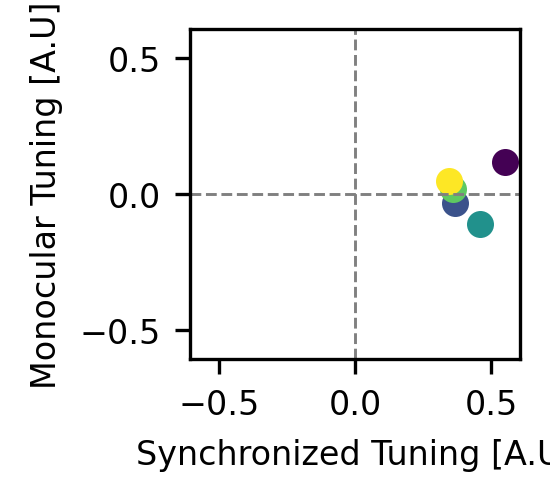

{'PV_143': (0.5518796992481203, 0.1182994454713493),
 'PV_62': (0.36865148861646224, -0.031075697211155384),
 'PV_106': (0.45789640927867814, -0.1110173068805404),
 'PV_126': (0.3607327383748238, 0.017363851617995252),
 'PV_57': (0.3436293436293436, 0.046583116576022654)}

In [21]:
import numpy as np
import matplotlib.pyplot as plt
def calculate_orientation_tuning(saccade_angles):
    """
    Calculates the orientation tuning statistic for a collection of saccade angles.

    Parameters:
        saccade_angles (array-like): List or array of saccade angles in degrees.

    Returns:
        float: Orientation tuning statistic.
    """
    # Convert angles to range [0, 360] if they aren't already
    saccade_angles = np.array(saccade_angles) % 360

    # Define horizontal saccade ranges
    horizontal_ranges = [
        (315, 360),  # 330° to 0°
        (0, 45),     # 0° to 30°
        (135, 225)   # 150° to 210°
    ]

    # Identify horizontal saccades
    is_horizontal = np.logical_or.reduce([
        (saccade_angles >= low) & (saccade_angles <= high)
        if low < high else
        (saccade_angles >= low) | (saccade_angles <= high)
        for low, high in horizontal_ranges
    ])

    # Calculate probabilities
    p_horizontal = np.sum(is_horizontal) / len(saccade_angles)
    p_vertical = 1 - p_horizontal  # Vertical saccades are the complement

    # Calculate orientation tuning
    tuning_statistic = (p_horizontal - p_vertical) / (p_horizontal + p_vertical)

    return tuning_statistic

# 'tuning' is not good - I need to use something that will be clear to someone without reading the text.. maybe saccade horizontal bias

def analyze_orientation_tuning(synced_df, non_synced_df, export_path=None):
    """
    Analyze orientation tuning for each unique animal in the given dataframes.

    Parameters:
        synced_df (pd.DataFrame): DataFrame containing 'animal' and 'angle' columns for synchronized saccades.
        non_synced_df (pd.DataFrame): DataFrame containing 'animal' and 'angle' columns for non-synchronized saccades.

    Returns:
        dict: Dictionary with animal IDs as keys and a tuple of (synced_tuning, non_synced_tuning) as values.
    """
    # Initialize dictionary to store results
    tuning_results = {}

    # Get unique animals
    unique_animals = synced_df['animal'].unique()

    for animal in unique_animals:
        # Filter data for the current animal
        synced_angles = synced_df.query('animal == @animal')['overall_angle_deg'].values
        non_synced_angles = non_synced_df.query('animal == @animal')['overall_angle_deg'].values

        # Calculate orientation tuning
        synced_tuning = calculate_orientation_tuning(synced_angles)
        non_synced_tuning = calculate_orientation_tuning(non_synced_angles)

        # Save to dictionary
        tuning_results[animal] = (synced_tuning, non_synced_tuning)

    # Plot results
    fig, ax = plt.subplots(figsize=(2, 2), dpi=300)

    synced_tuning_values = [v[0] for v in tuning_results.values()]
    non_synced_tuning_values = [v[1] for v in tuning_results.values()]
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_animals)))  # Generate unique colors

    for i, animal in enumerate(unique_animals):
        ax.scatter(
            synced_tuning_values[i],
            non_synced_tuning_values[i],
            color=colors[i],
            label=f"{animal}",
            s=30  # Marker size
        )

    # Formatting
    ax.set_xlabel("Synchronized Tuning [A.U]", fontsize=8)
    ax.set_ylabel("Monocular Tuning [A.U]", fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_aspect('equal')  # Ensure equal scaling
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.7)

    # Adjust axes limits to make sure x and y scales are identical
    all_values = synced_tuning_values + non_synced_tuning_values
    axis_limit = max(abs(min(all_values)), abs(max(all_values))) * 1.1
    ax.set_xlim(-axis_limit, axis_limit)
    ax.set_ylim(-axis_limit, axis_limit)

    # Move legend outside the plot
    #ax.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0)

    plt.tight_layout()
    if export_path:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_dir = pathlib.Path(export_path) / f'{timestamp}_horizontal_tuning_per_animal'
        export_dir.mkdir(parents=True, exist_ok=True)

        # Save PDF
        export_file_pdf = export_dir / f'{timestamp}_horizontal_tuning_per_animal.pdf'
        plt.savefig(export_file_pdf, format='pdf')
        print(f"Exported plot to {export_file_pdf}")

        # Save Pickle
        export_file_pkl = export_dir / f'{timestamp}_saccade_angles_data.pkl'
        with open(export_file_pkl, 'wb') as pkl_file:
            pickle.dump(saccade_collection, pkl_file)
        print(f"Exported data to {export_file_pkl}")
    plt.show()

    return tuning_results

export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\horizontal_tuning'
analyze_orientation_tuning(synced_saccade_collection,non_synced_saccade_collection,export_path=None)

<ipython-input-65-2bef2ab902a7>:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  fallback = plt.cm.get_cmap('tab10')


Exported plot to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\horizontal_tuning\2025_09_08_20_16_horizontal_bias_per_animal\2025_09_08_20_16_horizontal_bias_per_animal.pdf
Exported results table to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\horizontal_tuning\2025_09_08_20_16_horizontal_bias_per_animal\2025_09_08_20_16_horizontal_bias_results.csv
Exported results dict to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\horizontal_tuning\2025_09_08_20_16_horizontal_bias_per_animal\2025_09_08_20_16_horizontal_bias_results.pkl
Exported legend to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\horizontal_tuning\2025_09_08_20_16_horizontal_bias_per_animal\2025_09_08_20_16_horizontal_bias_legend.pdf


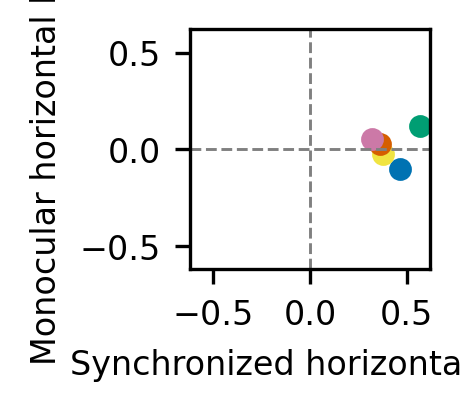

{'PV_106': (0.46598322460391417, -0.10368144252441769),
 'PV_143': (0.5703933747412009, 0.12191235059760963),
 'PV_62': (0.3794610342316096, -0.02571638501102136),
 'PV_126': (0.36232449297971914, 0.026093348033811026),
 'PV_57': (0.3216851730894841, 0.054109871953738065)}

In [65]:
# Example: your global per-animal colors (use your real hexes)
GLOBAL_COLORS = {
'PV_106': '#0072B2',
'PV_126': '#D55E00',
'PV_143': '#009E73',
'PV_57': '#CC79A7',
'PV_62': '#F0E442'
}

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import datetime, pathlib, pickle

def calculate_horizontal_bias(saccade_angles, horizontal_ranges=None):
    """
    Horizontal bias = (p_horizontal - p_vertical) / (p_horizontal + p_vertical) in [-1, 1]
    """
    if horizontal_ranges is None:
        # Wide (±45°) around 0° and 180°
        horizontal_ranges = [(315, 360), (0, 45), (135, 225)]

    arr = np.asarray(saccade_angles, dtype=float)
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        return np.nan
    arr = arr % 360

    masks = []
    for low, high in horizontal_ranges:
        if low <= high:
            masks.append((arr >= low) & (arr <= high))
        else:
            masks.append((arr >= low) | (arr <= high))
    is_horizontal = np.logical_or.reduce(masks) if masks else np.zeros_like(arr, dtype=bool)

    p_horizontal = is_horizontal.mean()
    p_vertical = 1.0 - p_horizontal
    denom = p_horizontal + p_vertical
    if denom == 0:
        return np.nan
    return (p_horizontal - p_vertical) / denom


def _save_legend_pdf(labels, colors, pdf_path, ncol=1, figsize=(1.6, 1.2), fontsize=8, frameon=True):
    """Create a standalone legend PDF."""
    fig = plt.figure(figsize=figsize, dpi=300)
    handles = [Line2D([0], [0], marker='o', linestyle='None',
                      markersize=6, markerfacecolor=c, markeredgecolor='none')
               for c in colors]
    fig.legend(handles=handles, labels=labels, loc='center',
               frameon=frameon, fontsize=fontsize, ncol=ncol)
    fig.savefig(pdf_path, format='pdf', bbox_inches='tight')
    plt.close(fig)


def analyze_orientation_tuning(
    synced_df,
    non_synced_df,
    export_path=None,
    color_map=None,              # e.g. GLOBAL_COLORS
    show_legend=False,           # legend is hidden on the plot; export separately if export_path is given
    figure_size=(2.2, 2.2),
    dpi=300,
    show_identity=False          # diagonal reference line (off by default)
):
    """
    Compute and plot per-animal horizontal bias for synchronized vs non-synchronized saccades.
    Exports: main PDF, CSV + PKL (results), and a standalone legend PDF if export_path is provided.
    """
    unique_animals = pd.unique(synced_df['animal'])

    # Compute biases
    results = {}
    for animal in unique_animals:
        s_angles = synced_df.loc[synced_df['animal'] == animal, 'overall_angle_deg'].to_numpy()
        ns_angles = non_synced_df.loc[non_synced_df['animal'] == animal, 'overall_angle_deg'].to_numpy()
        s_bias = calculate_horizontal_bias(s_angles)
        ns_bias = calculate_horizontal_bias(ns_angles)
        results[animal] = (s_bias, ns_bias)

    # Prepare plot data (drop NaNs)
    animals_for_plot, synced_vals, nonsynced_vals = [], [], []
    for a in unique_animals:
        sb, nsb = results.get(a, (np.nan, np.nan))
        if np.isfinite(sb) and np.isfinite(nsb):
            animals_for_plot.append(a)
            synced_vals.append(sb)
            nonsynced_vals.append(nsb)

    # Colors
    if color_map:
        colors = [color_map.get(a, None) for a in animals_for_plot]
        fallback = plt.cm.get_cmap('tab10')
        for i, c in enumerate(colors):
            if c is None:
                colors[i] = fallback(i % 10)
    else:
        cmap = plt.cm.get_cmap('tab10')
        colors = [cmap(i % 10) for i in range(len(animals_for_plot))]

    # Plot (no legend drawn here)
    fig, ax = plt.subplots(figsize=figure_size, dpi=dpi)
    for x, y, c in zip(synced_vals, nonsynced_vals, colors):
        ax.scatter(x, y, s=20, color=c)

    ax.set_xlabel("Synchronized horizontal bias", fontsize=8)
    ax.set_ylabel("Monocular horizontal bias", fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_aspect('equal')
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.7)
    if show_identity:
        ax.plot([-1, 1], [-1, 1], linestyle=':', linewidth=0.8, color='gray')

    margin = 0.05
    max_value = np.max([np.max(synced_vals),np.max(nonsynced_vals)])
    ax.set_xlim(-max_value - margin, max_value + margin)
    ax.set_ylim(-max_value - margin, max_value + margin)

    if show_legend:
        # Still possible to show on-figure if you explicitly ask for it
        handles = [Line2D([0],[0], marker='o', linestyle='None', markersize=6,
                          markerfacecolor=c, markeredgecolor='none')
                   for c in colors]
        ax.legend(handles, animals_for_plot, fontsize=7, loc='center left',
                  bbox_to_anchor=(1.05, 0.5), borderaxespad=0)

    plt.tight_layout()

    # Exports
    if export_path:
        export_dir = pathlib.Path(export_path)
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        out_dir = export_dir / f"{timestamp}_horizontal_bias_per_animal"
        out_dir.mkdir(parents=True, exist_ok=True)

        pdf_path = out_dir / f"{timestamp}_horizontal_bias_per_animal.pdf"
        plt.savefig(pdf_path, format='pdf')
        print(f"Exported plot to {pdf_path}")

        # Results table + dict
        df_out = pd.DataFrame({
            'animal': animals_for_plot,
            'synced_horizontal_bias': synced_vals,
            'monocular_horizontal_bias': nonsynced_vals
        })
        csv_path = out_dir / f"{timestamp}_horizontal_bias_results.csv"
        df_out.to_csv(csv_path, index=False)
        print(f"Exported results table to {csv_path}")

        pkl_path = out_dir / f"{timestamp}_horizontal_bias_results.pkl"
        with open(pkl_path, 'wb') as f:
            pickle.dump(results, f)
        print(f"Exported results dict to {pkl_path}")

        # Standalone legend PDF
        legend_pdf = out_dir / f"{timestamp}_horizontal_bias_legend.pdf"
        _save_legend_pdf(labels=animals_for_plot, colors=colors, pdf_path=legend_pdf,
                         ncol=1, figsize=(1.6, 1.2), fontsize=8, frameon=True)
        print(f"Exported legend to {legend_pdf}")

    plt.show()
    return results

analyze_orientation_tuning(
    synced_saccade_collection,
    non_synced_saccade_collection,
    export_path=r"Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\horizontal_tuning",
    color_map=GLOBAL_COLORS,
    show_legend=False,      # keep off-axes
    show_identity=False,    # no diagonal
    figure_size=(1.7, 1.7)
)


In [52]:
def plot_peak_velocity_vs_time(
    saccade_collection, sampling_rate=60, floor=None, ceiling=None,
    export_path=None, fig_size=(2.5,1.7), set_xlim=None, example_animal=None, set_ylim=None
):
    """
    Computes and plots the peak angular velocity (in deg/ms) for each saccade,
    grouped by time-to-peak (in ms) and by animal.

    For each saccade:
      - The peak velocity is computed as the maximum value in 'speed_profile_angular'
        (which is in deg/frame) converted to deg/ms using the formula:
            peak_velocity = max(speed_profile_angular) * (sampling_rate / 1000)

    Then the data is grouped by 'time_to_peak_v' (already in ms) and 'animal', so that
    each animal contributes one average peak velocity per time-to-peak value.

    The function creates a scatter plot where:
      - The x-axis is the time-to-peak (ms).
      - Each unique time value has as many points as the number of animals with data for that time.
      - A black error bar represents the mean ± SEM across animals for each time value.
      - Optionally, one animal can be highlighted in red.

    Parameters:
      - saccade_collection: DataFrame that must include:
            * 'time_to_peak_v': time-to-peak in ms.
            * 'speed_profile_angular': a list/array of angular speeds (in deg/frame).
            * 'animal': animal identifier.
      - sampling_rate: Sampling rate in Hz (default 60). Used to convert deg/frame to deg/ms.
      - floor: Minimum time-to-peak value (ms) to include.
      - ceiling: Maximum time-to-peak value (ms) to include.
      - export_path: Optional directory to export the plot as a PDF.
      - fig_size: Figure size tuple.
      - set_xlim: Optional x-axis limits.
      - example_animal: Optional string specifying an animal to highlight.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import datetime, os

    # Filter the dataframe for rows with valid time-to-peak and speed profile
    df = saccade_collection.dropna(subset=['time_to_peak_v', 'speed_profile_angular']).copy()

    # Apply floor and ceiling filters if provided (time-to-peak is in ms)
    if floor is not None:
        df = df[df['time_to_peak_v'] >= floor]
    if ceiling is not None:
        df = df[df['time_to_peak_v'] <= ceiling]

    # Compute the peak velocity for each saccade.
    # Convert from deg/frame to deg/ms by multiplying with (sampling_rate / 1000)
    def compute_peak(row):
        profile = np.array(row['speed_profile_angular'])
        return np.max(profile) * (sampling_rate / 1000)

    df['peak_velocity'] = df.apply(compute_peak, axis=1)

    # Group by time-to-peak and animal, so that each animal contributes one (average) peak value per time value.
    grouped = df.groupby(['time_to_peak_v', 'animal'])['peak_velocity'].mean().reset_index()

    # For each unique time-to-peak, compute the overall mean and SEM across animals.
    summary = grouped.groupby('time_to_peak_v').agg(
        mean_peak=('peak_velocity', 'mean'),
        sem_peak=('peak_velocity', lambda x: np.std(x, ddof=1)/np.sqrt(len(x)) if len(x) > 1 else 0)
    ).reset_index()

    # Create the scatter plot with x-axis in ms.
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)

    # Plot individual animal points (with slight jitter along the x-axis for clarity).
    for animal in grouped['animal'].unique():
        animal_data = grouped[grouped['animal'] == animal]
        jitter = np.random.normal(0, 0.5, size=len(animal_data))
        ax.scatter(animal_data['time_to_peak_v'] + jitter, animal_data['peak_velocity'],
                   s=5, alpha=0.7, label=animal)

    # # Plot the overall mean ± SEM for each time-to-peak value.
    # ax.errorbar(summary['time_to_peak_v'], summary['mean_peak'], yerr=summary['sem_peak'],
    #             fmt='o', color='black', capsize=3, markersize=5, label='Mean ± SEM')
    #
    # Optionally, highlight a specific animal in red.
    if example_animal is not None:
        if example_animal in grouped['animal'].unique():
            animal_data = grouped[grouped['animal'] == example_animal]
            jitter = np.random.normal(0, 0.5, size=len(animal_data))
            ax.scatter(animal_data['time_to_peak_v'] + jitter, animal_data['peak_velocity'],
                       s=5, color='red', alpha=0.9, label=f'Example: {example_animal}')

    ax.set_xlabel('TTP [ms]', fontsize=8)
    ax.set_ylabel('Peak V [deg/ms]', fontsize=8)
    if set_xlim is not None:
        ax.set_xlim(set_xlim)
    ax.tick_params(axis='both', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if set_ylim is not None:
        ax.set_ylim(set_ylim)

    plt.tight_layout()
    #ax.legend(fontsize=6)

    # Optionally export the plot as a PDF.
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"peak_velocity_vs_time_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "peak_velocity_vs_time.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Exported plot to: {full_export_path}")

    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\ttp_profiles\inset'
plot_peak_velocity_vs_time(all_saccade_collection.query('animal=="PV_24"'), sampling_rate=60, floor=1, ceiling=61,
    export_path=None, fig_size=(2,1.5), set_xlim=(0,70), example_animal=None)

ValueError: Wrong number of items passed 29, placement implies 1

Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_amp_hist_deg\diff_per_animal\saccade_amplitude_difference_all_animals_2025_08_25_01_06_32


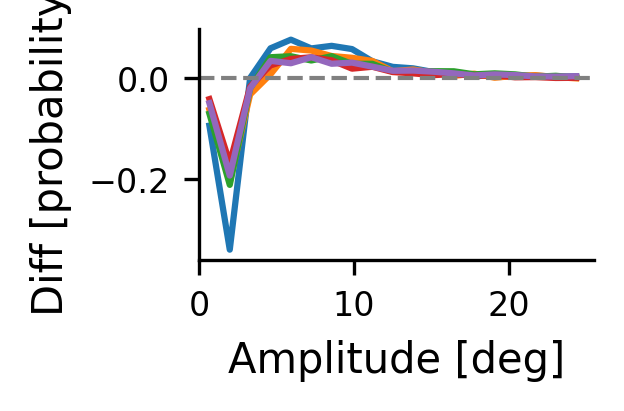

In [42]:
def plot_difference_saccade_amplitude_distribution_all_animals(
    synced_saccade_collection, non_synced_saccade_collection, figure_size=(2, 1.5), export_path=None,
    bins=np.linspace(0,5,40)
):
    """
    Plots the difference (synchronized minus monocular) of the normalized saccade amplitude histograms
    for each animal on a single plot. Each animal's trace is given a unique color.

    Parameters:
    - synced_saccade_collection (pd.DataFrame): DataFrame containing synchronized saccade data with an 'animal' column,
          and angular data (e.g. 'delta_phi' and 'delta_theta').
    - non_synced_saccade_collection (pd.DataFrame): DataFrame containing non-synchronized saccade data with an 'animal' column.
    - figure_size (tuple): Size of the figure.
    - export_path (str or pathlib.Path, optional): Directory where the plot and data will be saved.
    - bins (array-like): Bin edges for the histogram (default spans 0 to 5 deg).
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import datetime, os, pickle

    # Make sure both DataFrames have the computed angular amplitude column.
    for df in [synced_saccade_collection, non_synced_saccade_collection]:
        if 'magnitude_raw_angular' not in df.columns:
            df['magnitude_raw_angular'] = np.abs(df['delta_phi']) + np.abs(df['delta_theta'])

    # Compute bin centers for plotting.
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Retrieve unique animals.
    animals = synced_saccade_collection['animal'].unique()

    # Set up a single figure and axes.
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)

    # Get the default color cycle from matplotlib.
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Loop over each animal and plot its difference trace.
    for i, animal in enumerate(animals):
        # Filter data for the current animal.
        synced_data = synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values
        non_synced_data = non_synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values

        # Compute histograms.
        synced_hist, _ = np.histogram(synced_data, bins=bins)
        non_synced_hist, _ = np.histogram(non_synced_data, bins=bins)

        # Normalize the histograms.
        if synced_hist.sum() > 0:
            synced_hist = synced_hist / synced_hist.sum()
        if non_synced_hist.sum() > 0:
            non_synced_hist = non_synced_hist / non_synced_hist.sum()

        # Compute the difference: (synchronized minus monocular).
        diff_trace = synced_hist - non_synced_hist

        # Plot the trace using a color from the cycle.
        ax.plot(bin_centers, diff_trace, color=colors[i % len(colors)], linestyle='-',
                linewidth=1.5, label=f'{animal}')

    # Add a horizontal reference line at zero.
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Customize the plot.
    #ax.set_title('Difference in Saccade Amplitude Distribution\n(Synchronized - Monocular)', fontsize=12)
    ax.set_xlabel('Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Diff [probability]', fontsize=10)
    #ax.legend(fontsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(left=0)

    # Optionally export the plot and data.
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_amplitude_difference_all_animals_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_amplitude_difference_all_animals.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_amplitude_difference_all_animals_data.pkl")
        # Save each animal's difference trace keyed by animal name.
        data_dict = {}
        for animal in animals:
            synced_data = synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values
            non_synced_data = non_synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values
            synced_hist, _ = np.histogram(synced_data, bins=bins)
            non_synced_hist, _ = np.histogram(non_synced_data, bins=bins)
            if synced_hist.sum() > 0:
                synced_hist = synced_hist / synced_hist.sum()
            if non_synced_hist.sum() > 0:
                non_synced_hist = non_synced_hist / non_synced_hist.sum()
            data_dict[animal] = synced_hist - non_synced_hist
        with open(data_file, 'wb') as f:
            pickle.dump({
                'animal_diff_traces': data_dict,
                'bins': bins,
            }, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_amp_hist_deg\diff_per_animal'
plot_difference_saccade_amplitude_distribution_all_animals(synced_saccade_collection,
                                                          non_synced_saccade_collection,
                                                          figure_size=(1.7, 1),
                                                          export_path=export_path,
                                                          bins=np.linspace(0,25,20))
